# Object Detection

## First let's look at the dataset

## And try to visualize the bounding box

In [1]:
# my tool box for pytorch
from p3self.matchbox import *
from constant import *
from utils import *

In [2]:

%ls {IMG}|wc -l

5000


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
import numpy as np
import pandas as pd
import json
from glob import glob
from PIL import Image
import os

os.system("mkdir -p /data/bbsample")

0

#### Image table, with image url , image id, yup , that's all we need now

In [4]:
imgdf=pd.DataFrame(jsdict["images"])
imgdf.head()

,coco_url,date_captured,file_name,flickr_url,height,id,license,width
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640
1,http://images.cocodataset.org/val2017/00000003...,2013-11-14 20:55:31,000000037777.jpg,http://farm9.staticflickr.com/8429/7839199426_...,230,37777,1,352
2,http://images.cocodataset.org/val2017/00000025...,2013-11-14 22:32:02,000000252219.jpg,http://farm4.staticflickr.com/3446/3232237447_...,428,252219,4,640
3,http://images.cocodataset.org/val2017/00000008...,2013-11-14 23:11:37,000000087038.jpg,http://farm8.staticflickr.com/7355/8825114508_...,480,87038,1,640
4,http://images.cocodataset.org/val2017/00000017...,2013-11-14 23:16:55,000000174482.jpg,http://farm8.staticflickr.com/7020/6478877255_...,388,174482,6,640


#### An annotation table, in this case, we use "bbox"

In [5]:
ann_df=pd.DataFrame(jsdict["annotations"])
ann_df.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,702.10575,"[473.07, 395.93, 38.65, 28.67]",18,1768,289343,0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416...."
1,27718.47630,"[272.1, 200.23, 151.97, 279.77]",18,1773,61471,0,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427...."
2,78969.31690,"[124.71, 196.18, 372.85, 356.81]",18,2551,472375,0,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347...."
3,108316.66515,"[112.71, 154.82, 367.29, 479.35]",18,3186,520301,0,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6..."
4,75864.53530,"[200.61, 89.65, 400.22, 251.02]",18,3419,579321,0,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336...."


#### A category table

In [6]:
len(idx2name)

80

In [7]:
urls = glob(IMG+"/*")

In [8]:
urls[:5]

['/data/val2017/000000489091.jpg',
 '/data/val2017/000000224119.jpg',
 '/data/val2017/000000407646.jpg',
 '/data/val2017/000000225670.jpg',
 '/data/val2017/000000032735.jpg']

#### Get the image id from image url

In [9]:
rdimg = np.random.choice(urls)
def get_id(url):
    return int(url.split("/")[-1].split(".")[0])

#### Get the bounding box data from annotation

In [10]:
def get_bb(rdimg):
    match = ann_df[ann_df["image_id"]==get_id(rdimg)][["bbox","category_id"]]
    return list(match["bbox"]),list(match["category_id"])

In [11]:
get_bb(rdimg)

([[222.0, 58.0, 140.0, 137.0],
  [180.58, 254.5, 133.68, 88.79],
  [473.88, 293.41, 79.82, 80.81],
  [186.22, 134.41, 119.07, 122.73],
  [218.71, 10.51, 421.29, 240.67],
  [87.14, 111.57, 51.29, 60.91],
  [347.43, 114.39, 61.18, 76.48],
  [488.28, 68.86, 37.03, 37.85],
  [233.99, 341.91, 54.44, 57.3],
  [149.6, 84.68, 58.1, 62.77],
  [92.87, 133.93, 172.8, 291.07],
  [0.0, 0.0, 639.15, 425.0],
  [347.87, 218.86, 18.54, 22.43]],
 [56, 56, 56, 56, 49, 56, 56, 56, 56, 56, 48, 51, 57])

#### Picture boxes by loops into the picture

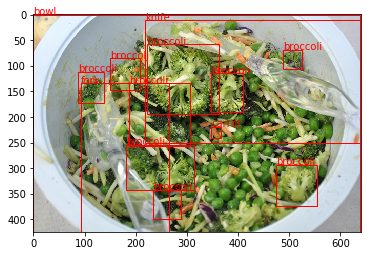

In [12]:
fig,ax = plt.subplots(1)
ax.imshow(Image.open(rdimg))
bbs,cids = get_bb(rdimg)
for i in range(len(bbs)):
    bb=bbs[i]
    # format of the bb: x, y, width, height
    rect = patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    # format of bb 
    ax.text(bb[0],bb[1],idx2name[cids[i]],dict({"color":"#ff0000"}))

In [13]:
fig.savefig("bbtest.png")

## You Only Look Once

### Introduction

From the paper [You Only Look Once: Unified, Real-Time Object Detection](http://arxiv.org/abs/1506.02640)

We divid the image to the grid boxes of size $S*S$

In each grid cell, we predict $B$ bounding boxes 

Each $B$ we have 5 predictions $x, y, w, h$ and confidence, 

$x,y$ relative to the grid box.$w, h$ relative to the entire picture.

Each grid cell, we predict class probability $Pr(Class_{i}|Object)$.

Then **class specified** confidence scores, when at test time we shall calculate, are:

$Pr(Class_{i}|Object)*Pr(Object)* IOU^{truth}_{pred}=Pr(Class_{i})* IOU^{truth}_{pred}$

IOU: **Intersection Over Union**

So the prediction are encoded in a tensor of size $S*S*(B*5+C)$

### YOLO style with anchor box

In [14]:
anc_cluster = np.array([[10,13],[16,30],[33,23],[30,61],[62,45],[59,119],[116,90],[156,198],[373,326]])
anc_cluster

array([[ 10,  13],
       [ 16,  30],
       [ 33,  23],
       [ 30,  61],
       [ 62,  45],
       [ 59, 119],
       [116,  90],
       [156, 198],
       [373, 326]])

#### Get resized bb

In [15]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

In [16]:
def p_structure(md):
    """Print out the model structure"""
    for par in md.parameters():
        print(par.size())

def p_count(md):
    """count the parameters in side a pytorch module"""
    allp=0
    for p in md.parameters():allp+=np.product(p.data.numpy().shape)
    return allp

##### Random Try

In [17]:
cell_y=torch.arange(0,FEAT_W)

cell_y=cell_y.repeat(FEAT_H).view(1,FEAT_H,FEAT_W,1,1)

cell_x=cell_y.transpose(1,2)
#cell_x,cell_y
cell_grid=torch.cat([cell_x,cell_y],dim=-1)

#### Prepare bb data

In [18]:
def df_data(imgdf,ann_df,shuffle=True):
    """
    imgdf:
    A dataframe about images, fields: "id","file_name","height","width"
    ann_df:
    A dataframe about annotation, fields: "image_id","category_id","bbox",
    The field "bbox" is a list of 4 values: x,y,height, width of the bounding box
    """
    data_df=pd.merge(ann_df[["bbox","category_id","image_id"]],
                     imgdf[["id","file_name","height","width"]],
                     left_on="image_id",right_on="id")
    
    data_df["cate_id_oh"] = data_df["category_id"].apply(lambda x:idx2id[x])
    if shuffle:
        data_df = data_df.sample(frac=1).reset_index(drop=True)
    print("total data rows",len(data_df))
    return data_df

data_df = df_data(imgdf,ann_df)
data_df.head()

total data rows 36781


,bbox,category_id,image_id,id,file_name,height,width,cate_id_oh
0,"[71.56, 206.74, 37.35, 11.59]",81,450488,450488,000000450488.jpg,500,334,71
1,"[11.95, 92.39, 271.23, 536.5]",1,52591,52591,000000052591.jpg,640,359,0
2,"[198.67, 132.95, 40.07, 23.33]",76,190236,190236,000000190236.jpg,393,640,66
3,"[147.14, 283.0, 39.78, 33.2]",58,468505,468505,000000468505.jpg,480,640,52
4,"[432.69, 210.13, 28.18, 54.09]",28,494188,494188,000000494188.jpg,640,480,25


##### Resize the bounding box

In [19]:
bbox_array = np.array(data_df.bbox.tolist())
wh_array = data_df[["width","height"]].as_matrix()

def re_calibrate(bbox_array,wh_array):
    """return the resized bbox array"""
    bb_resized = (bbox_array/np.concatenate([wh_array,wh_array],axis=-1)) *SIZE
    
    true_bb = bb_resized/32
    # swith xy as left top conner to center point
    true_bb[...,:2]=true_bb[...,:2]+true_bb[...,2:]/2
    # Labels' Anchor positions on the grid map
    grid_bbxy = np.floor(true_bb[...,:2])
    return bb_resized,true_bb,grid_bbxy

bb_resized,true_bb,grid_bbxy = re_calibrate(bbox_array,wh_array)
true_bbxy,true_bbwh = true_bb[...,:2],true_bb[...,2:]

In [20]:
bb_resized

array([[ 89.12862275, 172.00768   ,  46.51976048,   9.64288   ],
       [ 13.84735376,  60.0535    , 314.29437326, 348.725     ],
       [129.1355    , 140.7307888 ,  26.0455    ,  24.69536896],
       ...,
       [  0.        , 370.69066667,  12.8505    ,  11.84733333],
       [ 39.3185    ,  99.67533333,  49.062     , 249.71266667],
       [129.34272   , 196.70698667,  72.40896   ,  61.81205333]])

In [21]:
def find_best_anchors(true_bbwh):
    iou_score = []
    for b in range(BOX):
        wh_anc = np.tile(ANC_ARR[b],[true_bbwh.shape[0],1])
        true_area = true_bbwh.prod(axis=-1)
        anc_area = wh_anc.prod(axis=-1)
    
        inter_area = np.min([wh_anc,true_bbwh],axis=0).prod(axis=-1)
    
        union_area = true_area + anc_area - inter_area
        iou_score.append(inter_area/union_area)
    best_anchor_idx = np.array(iou_score).T.argmax(axis=-1)
    return best_anchor_idx

best_anchor_idx = find_best_anchors(true_bbwh)

##### Index to onehot

In [22]:
cate_idx = data_df["cate_id_oh"].as_matrix()

cate_oh = np.eye(cate_idx.max()+1)[cate_idx]

In [23]:
true_vec = np.concatenate([true_bb,np.ones((true_bb.shape[0],1)),cate_oh],axis=-1)

#### Reverse adjust funtion to get train labels

* t to b

$\large b_{x}=\sigma(t_{x})+c_{x}$

$\large b_{y}=\sigma(t_{y})+c_{y}$

$\large b_{w}=p_{w}e^{w}$

$\large b_{h}=p_{h}e^{h}$

* b to t

$\large t_{x}=-ln(\frac{1}{b_{x}-c_{x}}-1)$

$\large t_{y}=-ln(\frac{1}{b_{y}-c_{y}}-1)$

$\large t_{w}=ln(\frac{b_{w}}{p_{w}})$

$\large t_{h}=ln(\frac{b_{h}}{p_{h}})$

In [24]:
from numpy import inf
true_adj = true_vec
# true_adj[true_adj == -inf] = 0

In [25]:
vec_loc = np.concatenate([grid_bbxy,np.expand_dims(best_anchor_idx,axis=-1)],axis=-1).astype(np.int)

#### Feature Extractor

In [26]:
from conv_model import dn121_conv

dn121=dn121_conv(DN121)

In [27]:
bce = nn.modules.loss.BCELoss()

In [28]:
class dn_yolo(nn.Module):
    def __init__(self,feat_extra,feat_in):
        super(dn_yolo,self).__init__()
        self.feat_in = feat_in
        self.feat_extra=feat_extra
        
        self.conv_1 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_2 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
        self.conv_3 = nn.Conv2d(self.feat_in,VEC_LEN*BOX,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(self.feat_in)
        self.bn2 = nn.BatchNorm2d(self.feat_in)
        self.bn3 = nn.BatchNorm2d(self.feat_in)
    
    def forward(self,x):
        
        x = self.feat_extra(x)
        
        x = self.bn1(x)
        x = self.conv_1(x)
        x = self.bn2(x)
        x = self.conv_2(x)
        x = self.bn3(x)
        x = self.conv_3(x)
        
        # from: bs,channel, height, width
        # to: bs, width, height, channel
        x = x.permute([0,3,2,1]).contiguous().view(-1,FEAT_W,FEAT_H,BOX,VEC_LEN)
        
        return x

### Data Generator

In [29]:
from torch.utils.data import DataLoader,dataset
from torchvision import transforms
from PIL import Image

In [30]:
transform = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
trans_origin = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                               ])
back2PIL = transforms.Compose([transforms.ToPILImage(mode="RGB")])

### Training

In [31]:
from torch.utils.data import DataLoader
from tqdm import trange
from datetime import datetime
import os
from p3self.matchbox import Trainer


In [32]:
from data import odData

train_set = odData(urllist = list(IMG+i for i in list(data_df["file_name"])),
                          true_adj = true_adj,
                          vec_loc = vec_loc[:,np.newaxis,:],
#                            true_vec = true_vec,
                          transform = transform,
                           trans_origin=trans_origin,
                  )

In [33]:
trainer=Trainer(train_set,batch_size=8,print_on=5)
model = dn_yolo(dn121,1024)
from loss_ import yolo3_loss_on_b as yolo3_loss
loss_func = yolo3_loss(lbd_noobj=.3,testing=True)

In [34]:
CUDA = torch.cuda.is_available()
if CUDA:
    torch.cuda.empty_cache()
    model.cuda()
    loss_func.cuda()

In [35]:
from torch.optim import Adam
optimizer = Adam(model.parameters())

In [ ]:
def action(*args,**kwargs):
    """
    y_s: label for scoring, because the y's bb has been transformed into t
    """
    x,y,imgs,lbl_mask,vec_loc,t_xy,t_wh = args[0]
    iteration=kwargs["ite"]
    x,y,lbl_mask,vec_loc,t_xy,t_wh = Variable(x),Variable(y),Variable(lbl_mask),Variable(vec_loc),Variable(t_xy),Variable(t_wh)
    if CUDA:
        x,y,lbl_mask,t_xy,t_wh=x.cuda(),y.cuda(),lbl_mask.cuda(),t_xy.cuda(),t_wh.cuda()
    optimizer.zero_grad()
    
    y_ = model(x)
    model.x=x
    model.y_=y_
    model.y=y
    
    loss,loss_xy,loss_wh,loss_obj,loss_noobj,loss_cls = loss_func(y_,y,lbl_mask,vec_loc,t_xy,t_wh)
    loss.backward()

    optimizer.step()
    
    if iteration%50==0:
        y_pred = loss_func.t2b(y_)[0]
        if CUDA:
            y_pred=y_pred.cpu()
        img=back2PIL(imgs[0])
        printimg=plot_bb(img,data_to_df(y_pred))
    return {"loss":loss.data[0],
            "loss_xy":loss_xy.data[0],
            "loss_wh":loss_wh.data[0],
            "loss_obj":loss_obj.data[0],
            "loss_noobj":loss_noobj.data[0],
            "loss_cls":loss_cls.data[0],}

trainer.action=action

In [ ]:
trainer.train(1)

  0%|          | 0/4598 [00:00<?, ?it/s]

bb [3.4655738 5.472523  0.3544678 0.9294785] 	 [3.5121408 5.52591   1.4537425 0.30134  ]
conf 0.4227132201194763 	 1.0
cls 0.6801061034202576 	 1.0


  0%|          | 1/4598 [00:01<2:25:45,  1.90s/it]

bb [12.642325   3.5423117  1.0974488  0.3351842] 	 [12.67019    3.6693773  0.65962    1.0053025]
conf 0.6357941031455994 	 1.0
cls 0.7021050453186035 	 1.0


  0%|          | 2/4598 [00:03<1:55:13,  1.50s/it]

bb [ 6.504712  6.490106 55.895977 12.086193] 	 [ 6.5       6.472781 13.       12.766271]
conf 0.27387672662734985 	 1.0
cls 0.6682619452476501 	 1.0


  0%|          | 3/4598 [00:04<1:44:27,  1.36s/it]

bb [10.559975   9.633492   3.7954159  1.3139677] 	 [10.918375   9.910597   4.16325    5.8116393]
conf 0.3386678695678711 	 1.0
cls 0.6701191663742065 	 1.0


  0%|          | 4/4598 [00:05<1:39:33,  1.30s/it]

bb [ 7.627449   12.639941    0.12278939  5.628972  ] 	 [ 7.507297  12.230175   1.5547187  1.2237617]
conf 0.5676261186599731 	 1.0
cls 0.7463729381561279 	 1.0


⭐[ep_0_i_4]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   0%|          | 5/4598 [00:06<1:36:01,  1.25s/it]

bb [6.474496  7.214633  2.8844504 0.6493415] 	 [6.597195  7.527213  5.3391404 5.2121778]
conf 0.5474837422370911 	 1.0
cls 0.6586576700210571 	 1.0


⭐[ep_0_i_4]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   0%|          | 6/4598 [00:07<1:34:57,  1.24s/it]

bb [6.455622  9.385783  3.8047643 0.6856938] 	 [6.5611405 9.390469  4.863625  6.790604 ]
conf 0.6048560738563538 	 1.0
cls 0.5958319902420044 	 1.0


⭐[ep_0_i_4]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   0%|          | 7/4598 [00:08<1:33:11,  1.22s/it]

bb [6.478875  8.501026  5.3343964 3.500452 ] 	 [ 6.649195  8.378763 12.70161   8.957526]
conf 0.5705379247665405 	 1.0
cls 0.5431863069534302 	 1.0


⭐[ep_0_i_4]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   0%|          | 8/4598 [00:09<1:32:23,  1.21s/it]

bb [5.2218738 8.763366  1.760596  0.7372099] 	 [5.6662736  8.830562   0.25248438 0.937096  ]
conf 0.1172594279050827 	 1.0
cls 0.8893673419952393 	 1.0


⭐[ep_0_i_4]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   0%|          | 9/4598 [00:10<1:31:14,  1.19s/it]

bb [11.723354    7.224342    0.25215214  0.994455  ] 	 [11.1421175  7.6625233  1.1913282  0.5990376]
conf 0.8501220345497131 	 1.0
cls 0.5144056677818298 	 1.0


⭐[ep_0_i_9]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:   0%|          | 10/4598 [00:11<1:30:25,  1.18s/it]

bb [ 8.407695   10.434405    1.6624355   0.60672724] 	 [ 8.824867  10.747615   4.224797   1.2428541]
conf 0.6960132718086243 	 1.0
cls 0.46262750029563904 	 1.0


⭐[ep_0_i_9]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:   0%|          | 11/4598 [00:12<1:29:45,  1.17s/it]

bb [5.1584816e+00 6.3750134e+00 1.9125121e-04 8.8938957e-01] 	 [ 5.1659765  6.558338   7.135172  12.474238 ]
conf 0.9280162453651428 	 1.0
cls 0.32772648334503174 	 1.0


⭐[ep_0_i_9]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:   0%|          | 12/4598 [00:13<1:29:10,  1.17s/it]

bb [6.481101   5.6238284  0.62859446 0.762175  ] 	 [6.874664   5.3391333  0.65589064 0.98276347]
conf 0.4119569957256317 	 1.0
cls 0.6155247688293457 	 1.0


⭐[ep_0_i_9]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:   0%|          | 13/4598 [00:15<1:29:07,  1.17s/it]

bb [11.543305    8.598442    0.5775528   0.80857044] 	 [11.96286    8.898414   0.37544    0.5349067]
conf 0.4430330693721771 	 1.0
cls 0.5905017256736755 	 1.0


⭐[ep_0_i_9]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:   0%|          | 14/4598 [00:16<1:29:03,  1.17s/it]

bb [4.5581665  8.511096   0.5901146  0.72183985] 	 [4.875203  8.637494  0.7210938 1.2936951]
conf 0.5124498009681702 	 1.0
cls 0.5167935490608215 	 1.0


⭐[ep_0_i_14]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   0%|          | 15/4598 [00:17<1:28:54,  1.16s/it]

bb [5.4974647 7.4497204 7.1468844 2.3407664] 	 [5.9796953 7.5785127 9.250516  4.8349648]
conf 0.46010345220565796 	 1.0
cls 0.6067531704902649 	 1.0


⭐[ep_0_i_14]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   0%|          | 16/4598 [00:18<1:28:52,  1.16s/it]

bb [2.4020846  7.4356203  0.45693192 9.473271  ] 	 [2.9775176 7.9315233 5.955035  9.611265 ]
conf 0.7764617204666138 	 1.0
cls 0.4040154218673706 	 1.0


⭐[ep_0_i_14]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   0%|          | 17/4598 [00:19<1:28:53,  1.16s/it]

bb [ 7.470863  11.518099   0.6172875  0.7557356] 	 [ 7.9714603  11.5421715   0.25908878  0.44971874]
conf 0.5115053653717041 	 1.0
cls 0.5118820667266846 	 1.0


⭐[ep_0_i_14]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   0%|          | 18/4598 [00:20<1:28:31,  1.16s/it]

bb [8.360698  9.424578  0.0251626 8.850843 ] 	 [8.278833 9.54068  9.422833 6.570078]
conf 0.8392631411552429 	 1.0
cls 0.4457213580608368 	 1.0


⭐[ep_0_i_14]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   0%|          | 19/4598 [00:22<1:28:26,  1.16s/it]

bb [6.4212193  6.458474   0.18646017 8.721776  ] 	 [6.7895546 6.7934895 5.297297  8.722483 ]
conf 0.8046355247497559 	 1.0
cls 0.46344783902168274 	 1.0


⭐[ep_0_i_19]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   0%|          | 20/4598 [00:23<1:28:11,  1.16s/it]

bb [0.56299394 2.5061479  0.46500176 0.82025725] 	 [0.25129   2.7204354 0.50258   0.422012 ]
conf 0.570216953754425 	 1.0
cls 0.4717884361743927 	 1.0


⭐[ep_0_i_19]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   0%|          | 21/4598 [00:24<1:27:55,  1.15s/it]

bb [10.550125    7.507624    0.48195618  0.7867573 ] 	 [10.693007   7.5657573  0.3837031  0.5164938]
conf 0.5739710927009583 	 1.0
cls 0.47266116738319397 	 1.0


⭐[ep_0_i_19]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   0%|          | 22/4598 [00:25<1:27:53,  1.15s/it]

bb [ 7.4963646  11.519828    0.46038577  0.6213928 ] 	 [ 7.8595157  11.398156    0.6926563   0.50415623]
conf 0.5672152042388916 	 1.0
cls 0.48594143986701965 	 1.0


⭐[ep_0_i_19]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   1%|          | 23/4598 [00:26<1:27:54,  1.15s/it]

bb [10.499847   6.4531336  2.9353511  4.4853797] 	 [10.865461   6.2999763  4.2690783  5.1464167]
conf 0.6541915535926819 	 1.0
cls 0.49602699279785156 	 1.0


⭐[ep_0_i_19]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   1%|          | 24/4598 [00:27<1:27:43,  1.15s/it]

bb [7.5189195 9.469756  3.1267393 4.4841037] 	 [7.6137342 9.742687  3.3080938 6.222125 ]
conf 0.6412660479545593 	 1.0
cls 0.4945358633995056 	 1.0


⭐[ep_0_i_24]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   1%|          | 25/4598 [00:28<1:27:32,  1.15s/it]

bb [6.5795565 6.492407  0.3959178 0.8468074] 	 [6.5918126  6.053829   0.70728123 1.1285949 ]
conf 0.6758173108100891 	 1.0
cls 0.4081611633300781 	 1.0


⭐[ep_0_i_24]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   1%|          | 26/4598 [00:29<1:27:22,  1.15s/it]

bb [7.55704   5.455191  3.1372411 4.4764132] 	 [7.485631  5.5182967 3.573785  5.8398438]
conf 0.781929075717926 	 1.0
cls 0.46723321080207825 	 1.0


⭐[ep_0_i_24]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   1%|          | 27/4598 [00:30<1:27:13,  1.14s/it]

bb [ 5.5226307 11.494549   0.4043734  0.6272045] 	 [ 5.13204   11.075188   0.4096539  0.7028125]
conf 0.6655188202857971 	 1.0
cls 0.4176151156425476 	 1.0


⭐[ep_0_i_24]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   1%|          | 28/4598 [00:32<1:27:03,  1.14s/it]

bb [7.572342  5.469415  3.5330656 4.677284 ] 	 [7.1040936 5.872986  1.66075   5.5333724]
conf 0.7434566617012024 	 1.0
cls 0.4586396813392639 	 1.0


⭐[ep_0_i_24]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   1%|          | 29/4598 [00:33<1:26:53,  1.14s/it]

bb [0.5493342  6.4729347  0.44947556 0.8204317 ] 	 [0.33160156 6.1592097  0.6632031  0.8391745 ]
conf 0.629707932472229 	 1.0
cls 0.42940694093704224 	 1.0


⭐[ep_0_i_29]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 30/4598 [00:34<1:26:44,  1.14s/it]

bb [8.543551   8.464647   0.40638855 0.7711259 ] 	 [8.322336   8.077802   0.90410936 0.3305947 ]
conf 0.7287812232971191 	 1.0
cls 0.36320170760154724 	 1.0


⭐[ep_0_i_29]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 31/4598 [00:35<1:26:36,  1.14s/it]

bb [6.5620675 7.514492  3.4279656 3.9710817] 	 [6.6802397 7.5760546 3.6223958 4.9954534]
conf 0.7559686899185181 	 1.0
cls 0.4634636640548706 	 1.0


⭐[ep_0_i_29]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 32/4598 [00:36<1:26:27,  1.14s/it]

bb [3.5680962  6.446052   0.41171935 0.882237  ] 	 [3.5523515  6.886073   0.39751562 0.9666042 ]
conf 0.720314085483551 	 1.0
cls 0.36571091413497925 	 1.0


⭐[ep_0_i_29]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 33/4598 [00:37<1:26:20,  1.13s/it]

bb [5.568492   7.426401   0.3650839  0.82419497] 	 [5.599547   7.002917   0.83321875 1.2030555 ]
conf 0.8135626912117004 	 1.0
cls 0.29294589161872864 	 1.0


⭐[ep_0_i_29]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 34/4598 [00:38<1:26:16,  1.13s/it]

bb [1.5362084  9.434882   0.41969717 0.730374  ] 	 [1.2530104 9.666515  0.7602292 1.5165312]
conf 0.7594671845436096 	 1.0
cls 0.3309192955493927 	 1.0


⭐[ep_0_i_34]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   1%|          | 35/4598 [00:39<1:26:10,  1.13s/it]

bb [9.461655  6.5050154 1.7736834 2.0392566] 	 [9.57907   6.653443  0.7615156 2.9884777]
conf 0.7210188508033752 	 1.0
cls 0.44857579469680786 	 1.0


⭐[ep_0_i_34]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   1%|          | 36/4598 [00:40<1:26:02,  1.13s/it]

bb [8.466955  6.512631  1.859948  1.9832036] 	 [8.448984  6.3921914 1.0595    2.253238 ]
conf 0.7657175660133362 	 1.0
cls 0.43461498618125916 	 1.0


⭐[ep_0_i_34]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   1%|          | 37/4598 [00:41<1:25:55,  1.13s/it]

bb [1.4775177 8.504296  1.7066689 2.049013 ] 	 [1.0249687 8.119164  1.5165312 1.5513152]
conf 0.6462680101394653 	 1.0
cls 0.46991270780563354 	 1.0


⭐[ep_0_i_34]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   1%|          | 38/4598 [00:42<1:25:57,  1.13s/it]

bb [11.479887   1.4903097  2.0251415  2.1687305] 	 [11.242658  1.46939   2.124114  1.37462 ]
conf 0.5326640605926514 	 1.0
cls 0.4902271330356598 	 1.0


⭐[ep_0_i_34]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   1%|          | 39/4598 [00:44<1:25:52,  1.13s/it]

bb [1.4914424 8.518901  1.7241609 2.0537622] 	 [1.5624375 8.07625   1.2991875 1.1947813]
conf 0.753147542476654 	 1.0
cls 0.44288796186447144 	 1.0


⭐[ep_0_i_39]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 40/4598 [00:45<1:25:47,  1.13s/it]

bb [6.5654545 5.5168867 5.9547534 8.40548  ] 	 [6.473347  5.424758  7.8620086 6.8942657]
conf 0.743406355381012 	 1.0
cls 0.46673330664634705 	 1.0


⭐[ep_0_i_39]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 41/4598 [00:46<1:25:41,  1.13s/it]

bb [ 3.5729291  7.5107026  4.5828104 10.451786 ] 	 [ 3.3820312  7.7840166  6.7640624 10.140913 ]
conf 0.7294694781303406 	 1.0
cls 0.4560301601886749 	 1.0


⭐[ep_0_i_39]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 42/4598 [00:47<1:25:36,  1.13s/it]

bb [6.5417204 3.5204167 8.999604  8.246425 ] 	 [6.01118  3.747827 7.871297 7.40757 ]
conf 0.7051085233688354 	 1.0
cls 0.48258349299430847 	 1.0


⭐[ep_0_i_39]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 43/4598 [00:48<1:25:31,  1.13s/it]

bb [6.5146623 7.505791  1.6624831 2.177777 ] 	 [6.499086   7.95764    0.58926564 2.1401403 ]
conf 0.7220941185951233 	 1.0
cls 0.4460689127445221 	 1.0


⭐[ep_0_i_39]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 44/4598 [00:49<1:25:27,  1.13s/it]

bb [1.5237846 2.5082922 1.5784818 2.1776931] 	 [1.594125  2.0696688 1.6566875 3.1125386]
conf 0.7340123057365417 	 1.0
cls 0.4479678273200989 	 1.0


⭐[ep_0_i_44]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 45/4598 [00:50<1:25:22,  1.13s/it]

bb [1.5277792 6.5046353 1.595072  2.2366376] 	 [1.5098004 6.7916875 3.0196009 2.4314063]
conf 0.7845714092254639 	 1.0
cls 0.41809457540512085 	 1.0


⭐[ep_0_i_44]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 46/4598 [00:51<1:25:17,  1.12s/it]

bb [9.524084  2.5019932 1.5802742 2.248468 ] 	 [9.8973675  2.769271   0.72292185 1.8026667 ]
conf 0.7583457827568054 	 1.0
cls 0.42763420939445496 	 1.0


⭐[ep_0_i_44]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 47/4598 [00:52<1:25:13,  1.12s/it]

bb [ 0.52109   11.504785   1.5656581  2.26121  ] 	 [ 0.8624688 11.411258   1.5743542  2.9629843]
conf 0.7223497033119202 	 1.0
cls 0.43450674414634705 	 1.0


⭐[ep_0_i_44]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 48/4598 [00:53<1:25:09,  1.12s/it]

bb [10.507827  10.5697155  3.0673592  5.1562753] 	 [10.344344  10.082764   1.7261562  5.834472 ]
conf 0.7770005464553833 	 1.0
cls 0.46152976155281067 	 1.0


⭐[ep_0_i_44]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 49/4598 [00:54<1:25:05,  1.12s/it]

bb [4.5038686 9.571751  3.003133  5.3686376] 	 [4.746828  9.858662  2.7324376 6.2826767]
conf 0.7760701775550842 	 1.0
cls 0.4627299904823303 	 1.0


⭐[ep_0_i_49]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 50/4598 [00:56<1:25:03,  1.12s/it]

bb [ 5.5314164 10.504941   1.5387176  2.301493 ] 	 [ 5.3751955 10.917833   0.8053906  2.9027917]
conf 0.7717522978782654 	 1.0
cls 0.3994155526161194 	 1.0


⭐[ep_0_i_49]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 51/4598 [00:57<1:25:10,  1.12s/it]

bb [9.530551  9.507724  1.5565584 2.2555242] 	 [9.946828  9.955803  2.3111563 2.5492244]
conf 0.7809261083602905 	 1.0
cls 0.3864688277244568 	 1.0


⭐[ep_0_i_49]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 52/4598 [00:58<1:25:10,  1.12s/it]

bb [9.548625   5.484633   0.54637766 0.8908461 ] 	 [9.849633  5.887904  1.0885469 1.097541 ]
conf 0.8045450448989868 	 1.0
cls 0.39903971552848816 	 1.0


⭐[ep_0_i_49]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 53/4598 [00:59<1:25:05,  1.12s/it]

bb [11.494731   5.5889573  3.0798411  5.1747875] 	 [11.754031   5.0004616  2.3335     4.256284 ]
conf 0.8516213893890381 	 1.0
cls 0.4481179118156433 	 1.0


⭐[ep_0_i_49]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|          | 54/4598 [01:00<1:25:02,  1.12s/it]

bb [3.4901083 3.6033187 3.035944  5.2910976] 	 [3.7565937 3.8650107 3.8744063 3.6142766]
conf 0.8562024831771851 	 1.0
cls 0.44996199011802673 	 1.0


⭐[ep_0_i_54]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   1%|          | 55/4598 [01:01<1:24:58,  1.12s/it]

bb [3.5416908 7.526155  8.152918  8.426002 ] 	 [ 3.5594609  7.6711903  6.119953  10.599048 ]
conf 0.7713057994842529 	 1.0
cls 0.4693310856819153 	 1.0


⭐[ep_0_i_54]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   1%|          | 56/4598 [01:02<1:24:55,  1.12s/it]

bb [4.528628   9.489666   0.5429529  0.85545856] 	 [4.6748204  9.412948   0.04489062 0.04685417]
conf 0.7387330532073975 	 1.0
cls 0.43552741408348083 	 1.0


⭐[ep_0_i_54]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   1%|          | 57/4598 [01:03<1:24:51,  1.12s/it]

bb [6.5439234 6.5240917 8.313203  8.41916  ] 	 [ 6.1442266  6.704416  10.10039    6.865093 ]
conf 0.7805922627449036 	 1.0
cls 0.4715132713317871 	 1.0


⭐[ep_0_i_54]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   1%|▏         | 58/4598 [01:05<1:24:49,  1.12s/it]

bb [12.521314   6.4936237  0.5304124  0.7784057] 	 [12.101578   6.1351275  0.7324687  0.5750694]
conf 0.7587945461273193 	 1.0
cls 0.40937575697898865 	 1.0


⭐[ep_0_i_54]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   1%|▏         | 59/4598 [01:06<1:24:46,  1.12s/it]

bb [2.512149   3.4978225  0.5377685  0.89685714] 	 [2.1761796 3.7239583 0.6506094 0.209625 ]
conf 0.6981895565986633 	 1.0
cls 0.4301951825618744 	 1.0


⭐[ep_0_i_59]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 60/4598 [01:07<1:24:43,  1.12s/it]

bb [5.530317  9.510579  1.5282274 2.3349411] 	 [5.106969  9.86893   1.90125   2.9483595]
conf 0.785609245300293 	 1.0
cls 0.3697107434272766 	 1.0


⭐[ep_0_i_59]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 61/4598 [01:08<1:24:40,  1.12s/it]

bb [2.533609  6.5102935 7.2212033 9.6626835] 	 [ 2.5550077  6.477927   5.1100154 12.501007 ]
conf 0.6972429752349854 	 1.0
cls 0.4731815457344055 	 1.0


⭐[ep_0_i_59]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 62/4598 [01:09<1:24:37,  1.12s/it]

bb [6.5605345 6.5105658 5.408821  9.559242 ] 	 [ 6.5        6.4764376 13.        12.678657 ]
conf 0.7922160625457764 	 1.0
cls 0.45666444301605225 	 1.0


⭐[ep_0_i_59]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 63/4598 [01:10<1:24:34,  1.12s/it]

bb [3.490506  5.556941  2.988689  5.2720323] 	 [3.46242   5.9009805 1.33484   9.114566 ]
conf 0.8019641041755676 	 1.0
cls 0.4361131191253662 	 1.0


⭐[ep_0_i_59]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 64/4598 [01:11<1:24:29,  1.12s/it]

bb [10.491942    0.49680194  0.5065283   0.7289251 ] 	 [10.988961    0.27577406  1.3847032   0.511841  ]
conf 0.8047796487808228 	 1.0
cls 0.38333770632743835 	 1.0


⭐[ep_0_i_64]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 65/4598 [01:12<1:24:27,  1.12s/it]

bb [0.49045706 2.532655   3.1271338  5.04657   ] 	 [0.79858595 2.7724707  1.5971719  5.4840517 ]
conf 0.611630916595459 	 1.0
cls 0.48306336998939514 	 1.0


⭐[ep_0_i_64]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 66/4598 [01:13<1:24:24,  1.12s/it]

bb [8.485736   7.4875517  0.51196235 0.79021806] 	 [8.18157    7.402647   0.11517187 0.21529412]
conf 0.8421325087547302 	 1.0
cls 0.3794526159763336 	 1.0


⭐[ep_0_i_64]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 67/4598 [01:14<1:24:22,  1.12s/it]

bb [ 8.490208   10.479208    0.53694874  0.82319283] 	 [ 8.330867   10.811312    0.12817188  0.47128806]
conf 0.8017147779464722 	 1.0
cls 0.428522527217865 	 1.0


⭐[ep_0_i_64]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   1%|▏         | 68/4598 [01:15<1:24:20,  1.12s/it]

bb [3.4818652  9.471151   0.54549843 0.8215459 ] 	 [3.2684844  9.6894245  0.13446875 0.5434977 ]
conf 0.8334186673164368 	 1.0
cls 0.43312063813209534 	 1.0


⭐[ep_0_i_64]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 69/4598 [01:17<1:24:17,  1.12s/it]

bb [3.5116863 3.5379467 1.5145211 2.34822  ] 	 [3.9468203 3.1638942 1.0499531 3.099506 ]
conf 0.8823986053466797 	 1.0
cls 0.30146756768226624 	 1.0


⭐[ep_0_i_69]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 70/4598 [01:18<1:24:15,  1.12s/it]

bb [6.514229  3.5178475 1.5291591 2.1708636] 	 [6.5571795 3.563625  2.3564532 2.4207084]
conf 0.7079328894615173 	 1.0
cls 0.43856924772262573 	 1.0


⭐[ep_0_i_69]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 71/4598 [01:19<1:24:12,  1.12s/it]

bb [11.450748    1.4864955   0.48925838  0.6750366 ] 	 [11.703149    1.051147    0.08795313  0.08714922]
conf 0.8454074859619141 	 1.0
cls 0.36728838086128235 	 1.0


⭐[ep_0_i_69]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 72/4598 [01:20<1:24:09,  1.12s/it]

bb [ 3.4834538 12.485247   0.5622712  0.7797149] 	 [ 3.809914  12.270375   0.2829531  0.63375  ]
conf 0.6654895544052124 	 1.0
cls 0.4758446514606476 	 1.0


⭐[ep_0_i_69]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 73/4598 [01:21<1:24:07,  1.12s/it]

bb [11.487059   6.562547   2.8465788  6.0977607] 	 [11.340164   6.967388   3.3196719  7.3326116]
conf 0.8269052505493164 	 1.0
cls 0.41801032423973083 	 1.0


⭐[ep_0_i_69]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 74/4598 [01:22<1:24:05,  1.12s/it]

bb [10.443514   4.4630284  0.5041508  0.772556 ] 	 [10.488766    4.734302    0.28315625  0.6968542 ]
conf 0.867308497428894 	 1.0
cls 0.3968484401702881 	 1.0


⭐[ep_0_i_74]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 75/4598 [01:23<1:24:02,  1.11s/it]

bb [ 1.4856741 11.54313    1.6394048  2.1924615] 	 [ 1.4758047 11.512056   0.7651719  2.453716 ]
conf 0.8552745580673218 	 1.0
cls 0.32040727138519287 	 1.0


⭐[ep_0_i_74]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 76/4598 [01:24<1:24:00,  1.11s/it]

bb [9.435965   7.4576445  0.50151163 0.7841559 ] 	 [9.184399   7.4949064  0.13304688 0.43902084]
conf 0.8898965716362 	 1.0
cls 0.38498324155807495 	 1.0


⭐[ep_0_i_74]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 77/4598 [01:25<1:23:57,  1.11s/it]

bb [9.390553   4.4706564  0.41626287 0.50154066] 	 [9.157998   4.685078   0.06728337 0.08978125]
conf 0.9418565034866333 	 1.0
cls 0.26970452070236206 	 1.0


⭐[ep_0_i_74]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 78/4598 [01:26<1:23:55,  1.11s/it]

bb [2.4996028 5.5521874 2.8922908 6.125732 ] 	 [2.4889922 5.024683  4.5502033 4.849366 ]
conf 0.7752637267112732 	 1.0
cls 0.4375286102294922 	 1.0


⭐[ep_0_i_74]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 79/4598 [01:27<1:23:53,  1.11s/it]

bb [11.475952   4.5492806  1.5463839  2.1854987] 	 [11.028984   4.8024845  1.071224   1.9073437]
conf 0.8835384249687195 	 1.0
cls 0.30835312604904175 	 1.0


⭐[ep_0_i_79]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 80/4598 [01:29<1:23:51,  1.11s/it]

bb [8.467047 7.552344 1.547704 2.175111] 	 [8.338485  7.008219  0.8571875 2.8943958]
conf 0.9123792052268982 	 1.0
cls 0.281515508890152 	 1.0


⭐[ep_0_i_79]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 81/4598 [01:30<1:23:49,  1.11s/it]

bb [ 7.5556955  4.4362082 11.218677   5.0307975] 	 [7.119531  4.414583  9.689062  2.2208333]
conf 0.7220157980918884 	 1.0
cls 0.5262787938117981 	 1.0


⭐[ep_0_i_79]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 82/4598 [01:31<1:23:48,  1.11s/it]

bb [8.530339  6.5808654 2.8204675 6.2325387] 	 [8.390891  6.631515  2.5260625 8.238182 ]
conf 0.8884588479995728 	 1.0
cls 0.3986796736717224 	 1.0


⭐[ep_0_i_79]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 83/4598 [01:32<1:23:47,  1.11s/it]

bb [11.472943  12.513983   1.7660218  2.0505402] 	 [11.80452  12.129069  2.33012   0.9425  ]
conf 0.775542140007019 	 1.0
cls 0.3818064332008362 	 1.0


⭐[ep_0_i_79]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 84/4598 [01:33<1:23:47,  1.11s/it]

bb [0.46763986 7.5134306  1.7887988  2.0473025 ] 	 [0.7703516 7.4504895 1.5407032 2.5450208]
conf 0.7861112952232361 	 1.0
cls 0.3809671998023987 	 1.0


⭐[ep_0_i_84]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   2%|▏         | 85/4598 [01:34<1:23:47,  1.11s/it]

bb [ 4.424692   10.478924    0.47423825  0.65475446] 	 [ 4.890539   10.628033    0.13264063  0.74894613]
conf 0.8709166049957275 	 1.0
cls 0.35400262475013733 	 1.0


⭐[ep_0_i_84]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   2%|▏         | 86/4598 [01:35<1:23:44,  1.11s/it]

bb [4.4519577 2.5132    1.7553413 2.035742 ] 	 [4.9266953 2.4055417 2.211422  0.6787083]
conf 0.848003625869751 	 1.0
cls 0.3489600419998169 	 1.0


⭐[ep_0_i_84]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   2%|▏         | 87/4598 [01:36<1:23:42,  1.11s/it]

bb [4.5452223 7.5872107 2.9760602 6.3809247] 	 [4.457104  7.496125  2.7012916 3.511625 ]
conf 0.8875989317893982 	 1.0
cls 0.39056405425071716 	 1.0


⭐[ep_0_i_84]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   2%|▏         | 88/4598 [01:38<1:23:44,  1.11s/it]

bb [1.4426925  0.4835432  0.4943063  0.59910005] 	 [1.040914   0.39959016 0.43326563 0.7991803 ]
conf 0.7920090556144714 	 1.0
cls 0.3808545470237732 	 1.0


⭐[ep_0_i_84]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   2%|▏         | 89/4598 [01:39<1:23:42,  1.11s/it]

bb [4.543612  4.585249  3.0869162 6.6013465] 	 [4.93675   4.586077  2.7100937 4.701616 ]
conf 0.8841326236724854 	 1.0
cls 0.38565418124198914 	 1.0


⭐[ep_0_i_89]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 90/4598 [01:40<1:23:41,  1.11s/it]

bb [2.4849694 9.498354  1.8442911 1.9962575] 	 [2.0265963 9.315008  3.9469953 2.099703 ]
conf 0.6585614085197449 	 1.0
cls 0.44156551361083984 	 1.0


⭐[ep_0_i_89]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 91/4598 [01:41<1:23:39,  1.11s/it]

bb [8.449447  7.5068035 1.7271023 2.0458944] 	 [8.354226  7.0045624 0.8679531 1.8438333]
conf 0.854831337928772 	 1.0
cls 0.35985836386680603 	 1.0


⭐[ep_0_i_89]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 92/4598 [01:42<1:23:37,  1.11s/it]

bb [3.4459357 5.50282   1.8089072 2.0116832] 	 [3.1137185 5.423133  3.5116386 1.8624531]
conf 0.8644265532493591 	 1.0
cls 0.3490506112575531 	 1.0


⭐[ep_0_i_89]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 93/4598 [01:43<1:23:37,  1.11s/it]

bb [8.464991  2.4935613 1.784304  1.9948493] 	 [8.877477  2.188635  0.8029531 1.6135933]
conf 0.7736947536468506 	 1.0
cls 0.392586350440979 	 1.0


⭐[ep_0_i_89]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 94/4598 [01:44<1:23:39,  1.11s/it]

bb [ 6.5643253  8.507147   4.6660914 11.056857 ] 	 [ 6.3812733  8.909875  11.236265   6.3645835]
conf 0.900550365447998 	 1.0
cls 0.40512245893478394 	 1.0


⭐[ep_0_i_94]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 95/4598 [01:45<1:23:37,  1.11s/it]

bb [5.564825  8.559756  3.1278353 5.8114357] 	 [5.8730545 8.225615  5.8237967 5.7500625]
conf 0.8440743088722229 	 1.0
cls 0.38812026381492615 	 1.0


⭐[ep_0_i_94]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 96/4598 [01:46<1:23:35,  1.11s/it]

bb [3.4398618 2.455613  0.4738697 0.6563268] 	 [3.7289953  2.8312578  0.61476636 1.1478593 ]
conf 0.8488361239433289 	 1.0
cls 0.36752840876579285 	 1.0


⭐[ep_0_i_94]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 97/4598 [01:48<1:23:34,  1.11s/it]

bb [2.462978  4.4880285 1.711447  2.0756657] 	 [2.465456  4.290406  2.3245897 1.246375 ]
conf 0.8700357675552368 	 1.0
cls 0.33850476145744324 	 1.0


⭐[ep_0_i_94]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 98/4598 [01:49<1:23:32,  1.11s/it]

bb [ 0.46130824 10.449152    0.49659157  0.73852575] 	 [ 0.23958594 10.149885    0.47917187  2.3294375 ]
conf 0.8254469037055969 	 1.0
cls 0.4029650390148163 	 1.0


⭐[ep_0_i_94]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 99/4598 [01:50<1:23:31,  1.11s/it]

bb [10.4474945   8.458155    0.4773561   0.65915394] 	 [10.5663595   8.540865    0.13690625  0.20014584]
conf 0.8294194340705872 	 1.0
cls 0.36846789717674255 	 1.0


⭐[ep_0_i_99]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 100/4598 [01:51<1:23:30,  1.11s/it]

bb [12.488243   6.4895945  1.7530493  2.0532572] 	 [12.403828   6.431507   1.1923437  2.6598365]
conf 0.7448109984397888 	 1.0
cls 0.4026232063770294 	 1.0


⭐[ep_0_i_99]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 101/4598 [01:52<1:23:34,  1.11s/it]

bb [ 8.450251   10.462566    0.4822028   0.65184236] 	 [ 8.260937   10.154118    2.031897    0.23704687]
conf 0.834998607635498 	 1.0
cls 0.369396448135376 	 1.0


⭐[ep_0_i_99]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 102/4598 [01:53<1:23:32,  1.11s/it]

bb [1.4857523 9.482978  1.7394793 2.1034207] 	 [1.5313817 9.2177105 2.9549882 1.9632031]
conf 0.8484339118003845 	 1.0
cls 0.3399158716201782 	 1.0


⭐[ep_0_i_99]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 103/4598 [01:54<1:23:31,  1.11s/it]

bb [0.4984296 4.4793024 1.7289718 2.1105127] 	 [0.64558  4.609339 1.17936  4.513694]
conf 0.8227347135543823 	 1.0
cls 0.3499448597431183 	 1.0


⭐[ep_0_i_99]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 104/4598 [01:55<1:23:29,  1.11s/it]

bb [9.43815    6.4628296  0.4561848  0.67454976] 	 [9.433734   6.564323   0.17671876 0.23535417]
conf 0.8938294053077698 	 1.0
cls 0.32750827074050903 	 1.0


⭐[ep_0_i_104]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 105/4598 [01:57<1:23:28,  1.11s/it]

bb [8.531999  3.5012896 5.620463  9.744642 ] 	 [8.772765  3.6242917 8.409375  6.3375   ]
conf 0.818152129650116 	 1.0
cls 0.41999197006225586 	 1.0


⭐[ep_0_i_104]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 106/4598 [01:58<1:23:26,  1.11s/it]

bb [1.4494464  7.449756   0.48266947 0.76188195] 	 [1.6118984  7.218385   0.30529687 0.32202083]
conf 0.8878058791160583 	 1.0
cls 0.35572853684425354 	 1.0


⭐[ep_0_i_104]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 107/4598 [01:59<1:23:24,  1.11s/it]

bb [11.430376    4.4522233   0.4425149   0.69139284] 	 [11.427406    4.406878    0.15071875  0.4986385 ]
conf 0.933077871799469 	 1.0
cls 0.29939812421798706 	 1.0


⭐[ep_0_i_104]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 108/4598 [02:00<1:23:22,  1.11s/it]

bb [4.435596   6.455698   0.44034794 0.6908971 ] 	 [4.087789  6.9865108 1.3115782 0.8865574]
conf 0.923549473285675 	 1.0
cls 0.3113958239555359 	 1.0


⭐[ep_0_i_104]	loss	0.001✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 109/4598 [02:01<1:23:21,  1.11s/it]

bb [10.461287   1.4630897  0.5001263  0.7928205] 	 [10.825039    1.9638987   0.14117187  0.25686496]
conf 0.8355813026428223 	 1.0
cls 0.3973405659198761 	 1.0


⭐[ep_0_i_109]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 110/4598 [02:02<1:23:19,  1.11s/it]

bb [4.5713997 1.4866705 1.586202  2.356788 ] 	 [4.9890547 1.2356075 1.6012343 2.4299066]
conf 0.9479598999023438 	 1.0
cls 0.23748616874217987 	 1.0


⭐[ep_0_i_109]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 111/4598 [02:03<1:23:18,  1.11s/it]

bb [2.4499466  8.459657   0.47996506 0.80346394] 	 [2.3263907 8.788706  0.1746875 0.5400835]
conf 0.8991130590438843 	 1.0
cls 0.3618272840976715 	 1.0


⭐[ep_0_i_109]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 112/4598 [02:04<1:23:17,  1.11s/it]

bb [ 1.5716031 10.506853   3.2717247  5.395286 ] 	 [ 1.9111016 10.156921   3.1470156  4.8701653]
conf 0.8232766389846802 	 1.0
cls 0.4003469944000244 	 1.0


⭐[ep_0_i_109]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 113/4598 [02:05<1:23:15,  1.11s/it]

bb [7.3001275 4.4279113 2.4485712 1.377767 ] 	 [7.682323  4.4670234 1.5543125 2.1005156]
conf 0.00035080360248684883 	 1.0
cls 0.9999749660491943 	 1.0


⭐[ep_0_i_109]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   2%|▏         | 114/4598 [02:06<1:23:13,  1.11s/it]

bb [8.517858  7.510982  5.6824064 9.052703 ] 	 [ 8.268812   7.8299885  5.9633436 10.340023 ]
conf 0.8782102465629578 	 1.0
cls 0.392835795879364 	 1.0


⭐[ep_0_i_114]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 115/4598 [02:08<1:23:12,  1.11s/it]

bb [7.568941  8.50585   1.7210839 2.2546391] 	 [7.0255523 8.796633  1.1377709 1.1949843]
conf 0.9169158339500427 	 1.0
cls 0.28416287899017334 	 1.0


⭐[ep_0_i_114]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 116/4598 [02:09<1:23:10,  1.11s/it]

bb [3.5785418 3.497254  3.1557343 5.7758446] 	 [3.2503047 3.7408855 4.163453  4.4728127]
conf 0.8867448568344116 	 1.0
cls 0.3633710443973541 	 1.0


⭐[ep_0_i_114]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 117/4598 [02:10<1:23:12,  1.11s/it]

bb [9.448663   4.4765134  0.45543963 0.77921283] 	 [9.501273   4.181396   0.36623436 1.4132084 ]
conf 0.9335665702819824 	 1.0
cls 0.3298225402832031 	 1.0


⭐[ep_0_i_114]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 118/4598 [02:11<1:23:14,  1.11s/it]

bb [3.4496279  5.474755   0.46754712 0.867687  ] 	 [3.8848672  5.9965925  0.58764064 0.9313115 ]
conf 0.9417620301246643 	 1.0
cls 0.3455091714859009 	 1.0


⭐[ep_0_i_114]	loss	0.002✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 119/4598 [02:12<1:23:14,  1.12s/it]

bb [2.4486036  7.480594   0.43111712 0.87128955] 	 [2.7318282  7.0285244  0.26853126 1.3340983 ]
conf 0.9682720899581909 	 1.0
cls 0.3003372550010681 	 1.0


⭐[ep_0_i_119]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 120/4598 [02:13<1:23:12,  1.11s/it]

bb [ 3.52174   11.52887    1.5910592  2.2570665] 	 [ 3.8232787 11.100679   4.600843   1.0966718]
conf 0.9047617316246033 	 1.0
cls 0.3226085305213928 	 1.0


⭐[ep_0_i_119]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 121/4598 [02:14<1:23:14,  1.12s/it]

bb [11.47506     1.4969895   0.4504403   0.79085666] 	 [11.976352    1.5113854   0.3280469   0.66327083]
conf 0.9491806626319885 	 1.0
cls 0.32514727115631104 	 1.0


⭐[ep_0_i_119]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 122/4598 [02:16<1:23:12,  1.12s/it]

bb [5.453071   6.573078   0.41113943 0.04952418] 	 [5.32064  6.047593 0.31044  1.063165]
conf 0.54749995470047 	 1.0
cls 0.5025722980499268 	 1.0


⭐[ep_0_i_119]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 123/4598 [02:17<1:23:13,  1.12s/it]

bb [7.5107994 3.5303907 1.6688722 2.2061498] 	 [7.2189302 3.012242  3.094     1.4838281]
conf 0.926028847694397 	 1.0
cls 0.3195192217826843 	 1.0


⭐[ep_0_i_119]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 124/4598 [02:18<1:23:12,  1.12s/it]

bb [7.5267134 4.513322  1.6404562 2.234119 ] 	 [7.6347494 4.0379186 1.621536  4.049137 ]
conf 0.9369820356369019 	 1.0
cls 0.3061615526676178 	 1.0


⭐[ep_0_i_124]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 125/4598 [02:19<1:23:10,  1.12s/it]

bb [8.535467  4.5325937 7.7439823 4.42135  ] 	 [8.939147  4.78946   5.3130136 3.99672  ]
conf 0.7911988496780396 	 1.0
cls 0.4762464165687561 	 1.0


⭐[ep_0_i_124]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 126/4598 [02:20<1:23:09,  1.12s/it]

bb [0.4972056 8.494249  3.029575  5.651831 ] 	 [0.8673437 8.311323  1.3056875 5.5796485]
conf 0.8332551717758179 	 1.0
cls 0.4203805923461914 	 1.0


⭐[ep_0_i_124]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 127/4598 [02:21<1:23:08,  1.12s/it]

bb [2.5075197 9.501287  1.8279717 2.0956159] 	 [2.0427265 9.248552  1.9380156 3.0455208]
conf 0.7384363412857056 	 1.0
cls 0.43012458086013794 	 1.0


⭐[ep_0_i_124]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 128/4598 [02:22<1:23:07,  1.12s/it]

bb [ 1.438669  11.6161175  2.5982163  1.917858 ] 	 [ 1.8407187 11.785246   3.6814375  2.4295082]
conf 0.9900708794593811 	 1.0
cls 0.2662752568721771 	 1.0


⭐[ep_0_i_124]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 129/4598 [02:23<1:23:06,  1.12s/it]

bb [8.467822  7.551636  9.055434  7.7947187] 	 [ 8.288637  7.4269    9.372025 10.749267]
conf 0.890352725982666 	 1.0
cls 0.43413737416267395 	 1.0


⭐[ep_0_i_129]	loss	0.324✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.322✨	loss_xy	0.001:   3%|▎         | 130/4598 [02:25<1:23:05,  1.12s/it]

bb [12.522831   6.537723   2.0326343  1.9940267] 	 [12.649406   6.762906   0.7011875  3.4384236]
conf 0.8976101279258728 	 1.0
cls 0.3876290023326874 	 1.0


⭐[ep_0_i_129]	loss	0.324✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.322✨	loss_xy	0.001:   3%|▎         | 131/4598 [02:26<1:23:03,  1.12s/it]

bb [1.4994081 6.497494  1.8166984 2.0640976] 	 [1.7633528 6.0205235 1.4388084 1.6520156]
conf 0.6704397201538086 	 1.0
cls 0.4604199230670929 	 1.0


⭐[ep_0_i_129]	loss	0.324✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.322✨	loss_xy	0.001:   3%|▎         | 132/4598 [02:27<1:23:04,  1.12s/it]

bb [6.5070696 5.50789   1.8626215 2.0384755] 	 [6.305     5.6988406 0.3989375 3.5544496]
conf 0.847074568271637 	 1.0
cls 0.4071718454360962 	 1.0


⭐[ep_0_i_129]	loss	0.324✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.322✨	loss_xy	0.001:   3%|▎         | 133/4598 [02:28<1:23:03,  1.12s/it]

bb [8.511138  6.5061316 1.8656716 2.0321076] 	 [8.2525625 6.320979  1.7765312 4.4600835]
conf 0.8924500346183777 	 1.0
cls 0.3868657648563385 	 1.0


⭐[ep_0_i_129]	loss	0.324✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.322✨	loss_xy	0.001:   3%|▎         | 134/4598 [02:29<1:23:02,  1.12s/it]

bb [8.544378   7.5204434  0.5176948  0.79816574] 	 [8.536531  7.1980233 0.2234375 0.5976941]
conf 0.8669415712356567 	 1.0
cls 0.41379109025001526 	 1.0


⭐[ep_0_i_134]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 135/4598 [02:30<1:23:00,  1.12s/it]

bb [3.5365481  7.5113297  0.5235201  0.69128746] 	 [3.3108358  7.0908227  1.0950469  0.72989583]
conf 0.8463630676269531 	 1.0
cls 0.4157743752002716 	 1.0


⭐[ep_0_i_134]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 136/4598 [02:31<1:22:59,  1.12s/it]

bb [5.5450068  3.5201175  0.5218223  0.83669496] 	 [5.0014453 3.5074608 0.6423828 0.6534531]
conf 0.848930835723877 	 1.0
cls 0.4149794280529022 	 1.0


⭐[ep_0_i_134]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 137/4598 [02:32<1:22:57,  1.12s/it]

bb [12.495956   7.49869    1.882235   1.9949688] 	 [12.240093   7.7307343  1.5198127  1.971125 ]
conf 0.774533748626709 	 1.0
cls 0.44009581208229065 	 1.0


⭐[ep_0_i_134]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 138/4598 [02:33<1:22:56,  1.12s/it]

bb [5.5436287 5.52057   0.5314869 0.7953382] 	 [5.8368983  5.18581    0.13426563 0.5044366 ]
conf 0.8468285202980042 	 1.0
cls 0.41706863045692444 	 1.0


⭐[ep_0_i_134]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.001:   3%|▎         | 139/4598 [02:35<1:22:54,  1.12s/it]

bb [1.5074872 7.4992585 1.8757839 2.020126 ] 	 [1.1544    7.06264   1.3936    3.6309867]
conf 0.8303837180137634 	 1.0
cls 0.4247302711009979 	 1.0


⭐[ep_0_i_139]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.001:   3%|▎         | 140/4598 [02:36<1:22:53,  1.12s/it]

bb [4.535133   5.5040755  0.51673746 0.60164946] 	 [4.3620076  5.844965   0.05057812 0.10223005]
conf 0.8833951354026794 	 1.0
cls 0.3845278322696686 	 1.0


⭐[ep_0_i_139]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.001:   3%|▎         | 141/4598 [02:37<1:22:52,  1.12s/it]

bb [9.532301   5.514867   0.57861114 0.7687175 ] 	 [9.158805   5.6869583  0.50964063 0.6797917 ]
conf 0.7207021117210388 	 1.0
cls 0.4607519209384918 	 1.0


⭐[ep_0_i_139]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.001:   3%|▎         | 142/4598 [02:38<1:22:50,  1.12s/it]

bb [3.5142462 3.5038638 9.30397   4.0520086] 	 [3.3327734 3.087771  6.665547  3.5273333]
conf 0.6828890442848206 	 1.0
cls 0.4799211919307709 	 1.0


⭐[ep_0_i_139]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.001:   3%|▎         | 143/4598 [02:39<1:22:48,  1.12s/it]

bb [9.487039  2.487782  1.860974  2.0015724] 	 [9.837141  2.9157143 1.55025   3.1419203]
conf 0.7528479099273682 	 1.0
cls 0.4467247426509857 	 1.0


⭐[ep_0_i_139]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.001:   3%|▎         | 144/4598 [02:40<1:22:47,  1.12s/it]

bb [5.5342894  5.509513   0.54903644 0.7411824 ] 	 [5.996758   5.5218034  0.30570313 0.33063233]
conf 0.8123931884765625 	 1.0
cls 0.4247356355190277 	 1.0


⭐[ep_0_i_144]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 145/4598 [02:41<1:22:45,  1.12s/it]

bb [ 6.5124116 10.527002   9.098085   7.914975 ] 	 [ 6.539     10.343532  12.922      4.9664063]
conf 0.7042986154556274 	 1.0
cls 0.5230327248573303 	 1.0


⭐[ep_0_i_144]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 146/4598 [02:42<1:22:44,  1.12s/it]

bb [12.526738   12.507405    0.52773595  0.7463067 ] 	 [12.232086  12.62318    0.9333594  0.7153611]
conf 0.7593562602996826 	 1.0
cls 0.4338216483592987 	 1.0


⭐[ep_0_i_144]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 147/4598 [02:43<1:22:42,  1.11s/it]

bb [2.541889   8.51143    0.50796056 0.8175053 ] 	 [2.3037422 8.758208  0.5348281 0.5395   ]
conf 0.8631336092948914 	 1.0
cls 0.39991629123687744 	 1.0


⭐[ep_0_i_144]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 148/4598 [02:45<1:22:41,  1.11s/it]

bb [6.4834194 3.4733293 1.9073071 1.9889894] 	 [6.04884   3.1518905 1.8342232 1.5384687]
conf 0.88460373878479 	 1.0
cls 0.39385971426963806 	 1.0


⭐[ep_0_i_144]	loss	0.002✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.001✨	loss_xy	0.000:   3%|▎         | 149/4598 [02:46<1:22:40,  1.11s/it]

bb [9.512929   0.48611847 1.7241796  2.0636606 ] 	 [9.845333  0.651625  1.7945417 1.2597812]
conf 0.6671304702758789 	 1.0
cls 0.467779278755188 	 1.0


⭐[ep_0_i_149]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   3%|▎         | 150/4598 [02:47<1:22:39,  1.11s/it]

bb [1.4480315 1.4558794 5.027591  4.949168 ] 	 [1.5735078 1.8608353 3.1470156 3.650094 ]
conf 0.7584596872329712 	 1.0
cls 0.4549281597137451 	 1.0


⭐[ep_0_i_149]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   3%|▎         | 151/4598 [02:48<1:22:41,  1.12s/it]

bb [12.503532  10.494907   1.8266543  2.0207574] 	 [12.075477  10.574091   1.3493594  1.3372728]
conf 0.6533435583114624 	 1.0
cls 0.4769029915332794 	 1.0


⭐[ep_0_i_149]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   3%|▎         | 152/4598 [02:49<1:22:40,  1.12s/it]

bb [10.472469   9.472818   3.9478188  5.939817 ] 	 [10.726523   9.154843   3.8754218  5.7370625]
conf 0.6535146236419678 	 1.0
cls 0.49567270278930664 	 1.0


⭐[ep_0_i_149]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   3%|▎         | 153/4598 [02:50<1:22:39,  1.12s/it]

bb [6.5163364  4.5111027  0.55992144 0.5776066 ] 	 [6.833633  4.0336533 0.7745156 1.1008899]
conf 0.7453283667564392 	 1.0
cls 0.44963929057121277 	 1.0


⭐[ep_0_i_149]	loss	0.003✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.002✨	loss_xy	0.000:   3%|▎         | 154/4598 [02:51<1:22:38,  1.12s/it]

bb [3.4339957 5.5637774 1.4400145 1.6867294] 	 [3.1609297 5.724567  0.8545469 2.327213 ]
conf 0.01621442288160324 	 1.0
cls 0.9910634756088257 	 1.0


⭐[ep_0_i_154]	loss	0.436✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.434✨	loss_xy	0.001:   3%|▎         | 155/4598 [02:52<1:22:36,  1.12s/it]

bb [11.478645   3.4934916  4.3136454  7.705173 ] 	 [11.07925    3.7392604  3.8415     5.0247707]
conf 0.6586675643920898 	 1.0
cls 0.5282378792762756 	 1.0


⭐[ep_0_i_154]	loss	0.436✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.434✨	loss_xy	0.001:   3%|▎         | 156/4598 [02:54<1:22:35,  1.12s/it]

bb [ 2.5011845 11.538574   6.5152736  3.3389428] 	 [ 2.5526307 11.047557   5.098464   3.9048855]
conf 0.5649100542068481 	 1.0
cls 0.5073291659355164 	 1.0


⭐[ep_0_i_154]	loss	0.436✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.434✨	loss_xy	0.001:   3%|▎         | 157/4598 [02:55<1:22:33,  1.12s/it]

bb [6.5228643 1.4999979 0.5477584 0.6907848] 	 [6.7196937 1.93713   0.6522304 0.54782  ]
conf 0.6123884916305542 	 1.0
cls 0.47723424434661865 	 1.0


⭐[ep_0_i_154]	loss	0.436✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.434✨	loss_xy	0.001:   3%|▎         | 158/4598 [02:56<1:22:32,  1.12s/it]

bb [6.99497700e+00 7.00513077e+00 1.38879615e-14 3.68133460e-21] 	 [6.6271563 7.0491276 3.5258439 5.7218394]
conf 2.2042171917014695e-27 	 1.0
cls 1.0 	 1.0


⭐[ep_0_i_154]	loss	0.436✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.434✨	loss_xy	0.001:   3%|▎         | 159/4598 [02:57<1:22:30,  1.12s/it]

bb [3.5114918  3.5071778  0.57910466 0.53677946] 	 [3.3810372 3.06787   0.421117  0.35958  ]
conf 0.6849721074104309 	 1.0
cls 0.4803582727909088 	 1.0


⭐[ep_0_i_159]	loss	0.006✨	loss_cls	0.002✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   3%|▎         | 160/4598 [02:58<1:22:29,  1.12s/it]

bb [6.4502406  8.468685   0.62599695 0.53545123] 	 [6.8059063  8.389694   0.80315626 1.0616666 ]
conf 0.03882120922207832 	 1.0
cls 0.9707658290863037 	 1.0


⭐[ep_0_i_159]	loss	0.006✨	loss_cls	0.002✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   4%|▎         | 161/4598 [02:59<1:22:28,  1.12s/it]

bb [4.5043917  5.4962254  0.5742844  0.56364673] 	 [4.2585683  5.049789   1.1321596  0.45682812]
conf 0.5450347661972046 	 1.0
cls 0.5224809646606445 	 1.0


⭐[ep_0_i_159]	loss	0.006✨	loss_cls	0.002✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   4%|▎         | 162/4598 [03:00<1:22:27,  1.12s/it]

bb [9.448291   6.5483046  0.80859506 1.9177865 ] 	 [9.520062  6.312916  1.1297812 2.040726 ]
conf 0.17532676458358765 	 1.0
cls 0.8380570411682129 	 1.0


⭐[ep_0_i_159]	loss	0.006✨	loss_cls	0.002✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   4%|▎         | 163/4598 [03:01<1:22:27,  1.12s/it]

bb [ 1.4875727  9.506755   3.9731858 14.392879 ] 	 [1.6004219 9.938387  3.163875  5.754839 ]
conf 0.6330578923225403 	 1.0
cls 0.5822191834449768 	 1.0


⭐[ep_0_i_159]	loss	0.006✨	loss_cls	0.002✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   4%|▎         | 164/4598 [03:02<1:22:25,  1.12s/it]

bb [10.510786    4.5353055   0.5145693   0.47292826] 	 [10.91373     4.9290314   0.182       0.11415625]
conf 0.9158303141593933 	 1.0
cls 0.40053591132164 	 1.0


⭐[ep_0_i_164]	loss	3515.609✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	3515.607✨	loss_xy	0.001:   4%|▎         | 165/4598 [03:04<1:22:24,  1.12s/it]

bb [4.512368   2.4541671  0.5718256  0.93298554] 	 [4.1245317  2.393625   0.1342623  0.11578125]
conf 0.7667047381401062 	 1.0
cls 0.4259665906429291 	 1.0


⭐[ep_0_i_164]	loss	3515.609✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	3515.607✨	loss_xy	0.001:   4%|▎         | 166/4598 [03:05<1:22:23,  1.12s/it]

bb [7.563224  4.458873  4.4461827 2.3278182] 	 [7.3038673 4.910399  1.2473906 1.5557277]
conf 0.8952881097793579 	 1.0
cls 0.553604781627655 	 1.0


⭐[ep_0_i_164]	loss	3515.609✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	3515.607✨	loss_xy	0.001:   4%|▎         | 167/4598 [03:06<1:22:22,  1.12s/it]

bb [6.427714  5.492349  0.5073446 0.6489869] 	 [6.69175    5.965843   0.455      0.45454332]
conf 0.9960852861404419 	 1.0
cls 0.30996957421302795 	 1.0


⭐[ep_0_i_164]	loss	3515.609✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	3515.607✨	loss_xy	0.001:   4%|▎         | 168/4598 [03:07<1:22:20,  1.12s/it]

bb [3.4366865  7.5993423  0.02514378 2.504492  ] 	 [3.359608  7.2888155 1.3437582 3.651683 ]
conf 0.2994111478328705 	 1.0
cls 0.9827374815940857 	 1.0


⭐[ep_0_i_164]	loss	3515.609✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	3515.607✨	loss_xy	0.001:   4%|▎         | 169/4598 [03:08<1:22:19,  1.12s/it]

bb [8.495472  8.485029  2.9318936 1.9417205] 	 [8.093946  8.855437  0.7066276 2.3700626]
conf 0.6875112652778625 	 1.0
cls 0.5193869471549988 	 1.0


⭐[ep_0_i_169]	loss	0.014✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.000:   4%|▎         | 170/4598 [03:09<1:22:18,  1.12s/it]      

bb [9.5191145 8.414256  0.54393   1.5838857] 	 [9.543828   8.93467    0.47165626 1.2360706 ]
conf 0.744250476360321 	 1.0
cls 0.3949606120586395 	 1.0


⭐[ep_0_i_169]	loss	0.014✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.000:   4%|▎         | 171/4598 [03:10<1:22:17,  1.12s/it]

bb [11.506107   7.435199   0.5517478  1.6506202] 	 [11.786836   7.7618685  0.3520156  0.5479541]
conf 0.6449615359306335 	 1.0
cls 0.4623873829841614 	 1.0


⭐[ep_0_i_169]	loss	0.014✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.000:   4%|▎         | 172/4598 [03:11<1:22:15,  1.12s/it]

bb [1.4927921 3.4939888 2.9815168 1.9663469] 	 [1.74707   3.252928  1.55298   2.8564866]
conf 0.7991965413093567 	 1.0
cls 0.5217722654342651 	 1.0


⭐[ep_0_i_169]	loss	0.014✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.000:   4%|▍         | 173/4598 [03:12<1:22:14,  1.12s/it]

bb [4.4994326  6.4196997  0.53530526 2.0901208 ] 	 [4.951375   6.36209    0.4038125  0.05915344]
conf 0.8067030310630798 	 1.0
cls 0.3413981795310974 	 1.0


⭐[ep_0_i_169]	loss	0.014✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.000:   4%|▍         | 174/4598 [03:14<1:22:13,  1.12s/it]

bb [6.509374  6.5052757 1.310457  1.7130593] 	 [6.807633  6.69884   1.8332031 4.2112036]
conf 0.5938551425933838 	 1.0
cls 0.48035937547683716 	 1.0


⭐[ep_0_i_174]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:   4%|▍         | 175/4598 [03:15<1:22:12,  1.12s/it]

bb [5.5194607 8.454023  0.5638822 1.399618 ] 	 [5.46975    8.912915   0.11171875 0.2944028 ]
conf 0.8097711205482483 	 1.0
cls 0.3876439332962036 	 1.0


⭐[ep_0_i_174]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:   4%|▍         | 176/4598 [03:16<1:22:10,  1.12s/it]

bb [10.543869   3.4226098  0.5716     3.4449477] 	 [10.581492   3.6351173  0.5969844  1.8840845]
conf 0.8631026148796082 	 1.0
cls 0.34563013911247253 	 1.0


⭐[ep_0_i_174]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:   4%|▍         | 177/4598 [03:17<1:22:09,  1.11s/it]

bb [10.538699    8.468138    0.54803205  2.2880228 ] 	 [10.5391     8.308213   0.37648    1.9399467]
conf 0.8633349537849426 	 1.0
cls 0.39930665493011475 	 1.0


⭐[ep_0_i_174]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:   4%|▍         | 178/4598 [03:18<1:22:07,  1.11s/it]

bb [6.536977   1.4733505  0.52566946 2.719485  ] 	 [6.18735    1.9576355  0.9607     0.99966866]
conf 0.851801872253418 	 1.0
cls 0.4077064096927643 	 1.0


⭐[ep_0_i_174]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:   4%|▍         | 179/4598 [03:19<1:22:06,  1.11s/it]

bb [ 7.49169   4.509649  6.029169 10.255573] 	 [7.3759766 4.7258644 2.0728905 5.8238783]
conf 0.864925742149353 	 1.0
cls 0.5859239101409912 	 1.0


⭐[ep_0_i_179]	loss	0.009✨	loss_cls	0.003✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   4%|▍         | 180/4598 [03:20<1:22:04,  1.11s/it]

bb [6.4019794 6.166846  0.6595851 1.350422 ] 	 [6.0137186 6.443493  1.3060937 2.2591465]
conf 0.989270031452179 	 1.0
cls 0.4204864203929901 	 1.0


⭐[ep_0_i_179]	loss	0.009✨	loss_cls	0.003✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   4%|▍         | 181/4598 [03:21<1:22:03,  1.11s/it]

bb [5.4537907 9.512363  2.3897333 1.3336374] 	 [5.4239454 9.033353  0.8716094 2.7896082]
conf 0.8511550426483154 	 1.0
cls 0.4157360792160034 	 1.0


⭐[ep_0_i_179]	loss	0.009✨	loss_cls	0.003✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   4%|▍         | 182/4598 [03:22<1:22:02,  1.11s/it]

bb [1.5161275 0.5192653 2.6006293 2.5936933] 	 [1.2824297  0.79123956 2.3361406  1.5803125 ]
conf 0.6736547946929932 	 1.0
cls 0.5427974462509155 	 1.0


⭐[ep_0_i_179]	loss	0.009✨	loss_cls	0.003✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   4%|▍         | 183/4598 [03:23<1:22:00,  1.11s/it]

bb [ 8.38853   9.482847 28.996542 10.357629] 	 [8.833906  9.018479  6.1945    7.2707915]
conf 0.8224546313285828 	 1.0
cls 0.5202707648277283 	 1.0


⭐[ep_0_i_179]	loss	0.009✨	loss_cls	0.003✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   4%|▍         | 184/4598 [03:25<1:21:59,  1.11s/it]

bb [10.472305   2.4523778  1.9736881  1.6271836] 	 [10.83743    2.708875   1.0036407  3.5013332]
conf 0.8617657423019409 	 1.0
cls 0.4456399083137512 	 1.0


⭐[ep_0_i_184]	loss	1.317✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	1.315✨	loss_xy	0.000:   4%|▍         | 185/4598 [03:26<1:21:58,  1.11s/it]

bb [1.2521507e+00 1.0000984e+01 5.5155891e-04 7.0499313e-01] 	 [ 1.8355391 10.8789     1.6195157  1.6823888]
conf 0.9230499863624573 	 1.0
cls 0.9958179593086243 	 1.0


⭐[ep_0_i_184]	loss	1.317✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	1.315✨	loss_xy	0.000:   4%|▍         | 186/4598 [03:27<1:21:58,  1.11s/it]

bb [1.39230061e+00 4.10719299e+00 1.84571850e+00 1.07874286e-04] 	 [1.6699053  4.2617655  0.6352366  0.54396874]
conf 0.011190962977707386 	 1.0
cls 0.9551178216934204 	 1.0


⭐[ep_0_i_184]	loss	1.317✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	1.315✨	loss_xy	0.000:   4%|▍         | 187/4598 [03:28<1:21:57,  1.11s/it]

bb [7.5329127  0.5640237  0.6938048  0.17316104] 	 [7.754906   0.46699765 0.24253125 0.40913552]
conf 0.8281558752059937 	 1.0
cls 0.6090394854545593 	 1.0


⭐[ep_0_i_184]	loss	1.317✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	1.315✨	loss_xy	0.000:   4%|▍         | 188/4598 [03:29<1:21:56,  1.11s/it]

bb [3.4803138  0.53372854 3.0882142  2.5981557 ] 	 [3.9564688 0.8512292 2.5297186 1.6575   ]
conf 0.7439230680465698 	 1.0
cls 0.5501348376274109 	 1.0


⭐[ep_0_i_184]	loss	1.317✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	1.315✨	loss_xy	0.000:   4%|▍         | 189/4598 [03:30<1:21:54,  1.11s/it]

bb [3.56148   5.449391  7.8671603 3.2658577] 	 [3.6917968 5.600021  6.814031  4.3820834]
conf 0.7557844519615173 	 1.0
cls 0.4954157769680023 	 1.0


⭐[ep_0_i_189]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   4%|▍         | 190/4598 [03:31<1:21:53,  1.11s/it]

bb [4.414157  4.5448294 2.9493363 1.7087054] 	 [4.2843127 4.676411  2.3164375 3.2398977]
conf 0.8805176615715027 	 1.0
cls 0.4231901466846466 	 1.0


⭐[ep_0_i_189]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   4%|▍         | 191/4598 [03:32<1:21:52,  1.11s/it]

bb [9.663047  2.3080492 1.7912691 5.1943736] 	 [9.204406  2.553823  1.9170938 3.651646 ]
conf 0.6795915365219116 	 1.0
cls 0.6924806237220764 	 1.0


⭐[ep_0_i_189]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   4%|▍         | 192/4598 [03:34<1:21:51,  1.11s/it]

bb [6.47856   6.4296803 0.4361141 1.3598126] 	 [6.245586   6.3979883  0.6185156  0.45545882]
conf 0.044298894703388214 	 1.0
cls 0.8866515755653381 	 1.0


⭐[ep_0_i_189]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   4%|▍         | 193/4598 [03:35<1:21:49,  1.11s/it]

bb [11.395585   6.593652   0.8106462 11.778373 ] 	 [11.775867   6.630948   2.4413593  9.238937 ]
conf 0.22730322182178497 	 1.0
cls 0.8977394700050354 	 1.0


⭐[ep_0_i_189]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   4%|▍         | 194/4598 [03:36<1:21:48,  1.11s/it]

bb [1.4172637 9.471728  2.3671484 2.5719748] 	 [1.4378203 9.393854  0.9634219 2.3649166]
conf 0.9379753470420837 	 1.0
cls 0.3807869851589203 	 1.0


⭐[ep_0_i_194]	loss	0.015✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.001:   4%|▍         | 195/4598 [03:37<1:21:47,  1.11s/it]

bb [8.517592   7.523111   0.61267644 1.0364269 ] 	 [8.445851 7.67039  1.134734 0.9763  ]
conf 0.7883293628692627 	 1.0
cls 0.5701863765716553 	 1.0


⭐[ep_0_i_194]	loss	0.015✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.001:   4%|▍         | 196/4598 [03:38<1:21:46,  1.11s/it]

bb [6.4989862 6.671989  4.4790454 6.6741433] 	 [ 6.345879   6.6100936  4.98875   11.767438 ]
conf 0.24904654920101166 	 1.0
cls 0.5529689192771912 	 1.0


⭐[ep_0_i_194]	loss	0.015✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.001:   4%|▍         | 197/4598 [03:39<1:21:45,  1.11s/it]

bb [1.3995638 3.4838793 2.8801877 3.4451716] 	 [1.8126875 3.8123186 1.8711874 1.4899765]
conf 0.8859374523162842 	 1.0
cls 0.47212716937065125 	 1.0


⭐[ep_0_i_194]	loss	0.015✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.001:   4%|▍         | 198/4598 [03:40<1:21:43,  1.11s/it]

bb [7.217171   8.992298   8.689312   0.05706365] 	 [7.0359454 8.495029  1.6719218 8.259452 ]
conf 0.12667356431484222 	 1.0
cls 0.30030885338783264 	 1.0


⭐[ep_0_i_194]	loss	0.015✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.013✨	loss_xy	0.001:   4%|▍         | 199/4598 [03:41<1:21:42,  1.11s/it]

bb [2.4090533 7.45726   2.5991323 4.0411525] 	 [2.786875  7.384948  2.0966563 0.7011875]
conf 0.8851870894432068 	 1.0
cls 0.46053802967071533 	 1.0


⭐[ep_0_i_199]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   4%|▍         | 200/4598 [03:42<1:21:41,  1.11s/it]

bb [9.707235   8.971301   0.53704906 0.02909265] 	 [9.6224375 8.196229  3.8764374 8.825916 ]
conf 5.573919406742789e-05 	 1.0
cls 0.9639783501625061 	 1.0


⭐[ep_0_i_199]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   4%|▍         | 201/4598 [03:44<1:21:42,  1.11s/it]

bb [4.455576   7.560343   0.22287588 0.00837119] 	 [4.6417108  7.782911   0.34023437 0.11107981]
conf 0.792259931564331 	 1.0
cls 0.26938357949256897 	 1.0


⭐[ep_0_i_199]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   4%|▍         | 202/4598 [03:45<1:21:41,  1.12s/it]

bb [ 2.4371104  8.442203   4.1766505 12.79723  ] 	 [2.24575  8.472013 4.4915   5.49224 ]
conf 0.9023582935333252 	 1.0
cls 0.4975302517414093 	 1.0


⭐[ep_0_i_199]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   4%|▍         | 203/4598 [03:46<1:21:40,  1.12s/it]

bb [9.474891  9.4700775 2.3921485 2.7172203] 	 [9.786031  9.070648  2.2418664 1.0491406]
conf 0.7907370328903198 	 1.0
cls 0.5047459006309509 	 1.0


⭐[ep_0_i_199]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   4%|▍         | 204/4598 [03:47<1:21:38,  1.11s/it]

bb [10.506061   2.4993818  0.7714069  1.201806 ] 	 [10.035391    2.4518542   0.24171875  0.6602917 ]
conf 0.7393081784248352 	 1.0
cls 0.48419004678726196 	 1.0


⭐[ep_0_i_204]	loss	0.021✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.019✨	loss_xy	0.001:   4%|▍         | 205/4598 [03:48<1:21:37,  1.11s/it]

bb [11.419822   3.295733   1.7078321  5.9571347] 	 [11.2112     3.389955   2.29164    2.0866365]
conf 0.8898285031318665 	 1.0
cls 0.7719781398773193 	 1.0


⭐[ep_0_i_204]	loss	0.021✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.019✨	loss_xy	0.001:   4%|▍         | 206/4598 [03:49<1:21:36,  1.11s/it]

bb [ 7.4666185  7.4505386 23.237598  10.321772 ] 	 [ 7.9075704  7.485156  10.184859  11.029688 ]
conf 0.8354995250701904 	 1.0
cls 0.5416013598442078 	 1.0


⭐[ep_0_i_204]	loss	0.021✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.019✨	loss_xy	0.001:   5%|▍         | 207/4598 [03:50<1:21:35,  1.11s/it]

bb [5.52889    7.413216   0.40204525 0.50146735] 	 [5.4250627  7.4608374  0.54640627 0.6681881 ]
conf 0.028122343122959137 	 1.0
cls 0.7719390392303467 	 1.0


⭐[ep_0_i_204]	loss	0.021✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.019✨	loss_xy	0.001:   5%|▍         | 208/4598 [03:51<1:21:34,  1.11s/it]

bb [ 9.505725   12.614827    0.2835165   0.29855263] 	 [ 9.905594   12.474854    0.52853125  0.9479167 ]
conf 0.97624671459198 	 1.0
cls 0.7709348797798157 	 1.0


⭐[ep_0_i_204]	loss	0.021✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.019✨	loss_xy	0.001:   5%|▍         | 209/4598 [03:52<1:21:32,  1.11s/it]

bb [ 4.5534406 10.01235    1.0244336  3.8294942] 	 [ 4.9366484  10.300604    0.72617185  0.4485    ]
conf 7.051527330798057e-13 	 1.0
cls 0.9999707937240601 	 1.0


⭐[ep_0_i_209]	loss	0.259✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.257✨	loss_xy	0.001:   5%|▍         | 210/4598 [03:54<1:21:31,  1.11s/it]

bb [10.527357  12.496627   0.3205774  0.5843532] 	 [10.570828  12.850317   0.64025    0.2993662]
conf 0.28239211440086365 	 1.0
cls 0.5862945318222046 	 1.0


⭐[ep_0_i_209]	loss	0.259✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.257✨	loss_xy	0.001:   5%|▍         | 211/4598 [03:55<1:21:30,  1.11s/it]

bb [11.494247   3.560354   0.8694445  1.1786727] 	 [11.210265    3.1157155   0.15315625  0.15863344]
conf 0.8908541798591614 	 1.0
cls 0.5833780169487 	 1.0


⭐[ep_0_i_209]	loss	0.259✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.257✨	loss_xy	0.001:   5%|▍         | 212/4598 [03:56<1:21:29,  1.11s/it]

bb [6.5379024 6.5267043 8.98162   3.2453103] 	 [6.7786875 6.0714064 6.904625  2.8207293]
conf 0.7962576150894165 	 1.0
cls 0.49104049801826477 	 1.0


⭐[ep_0_i_209]	loss	0.259✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.257✨	loss_xy	0.001:   5%|▍         | 213/4598 [03:57<1:21:28,  1.11s/it]

bb [8.482883  6.4972124 3.8812416 7.566468 ] 	 [8.078485  6.3387446 4.794156  7.936085 ]
conf 0.7796098589897156 	 1.0
cls 0.5044736266136169 	 1.0


⭐[ep_0_i_209]	loss	0.259✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.257✨	loss_xy	0.001:   5%|▍         | 214/4598 [03:58<1:21:26,  1.11s/it]

bb [ 8.559696  6.536428 10.430697  3.116153] 	 [8.081328  6.7354894 6.696219  0.9016042]
conf 0.802010715007782 	 1.0
cls 0.5303415656089783 	 1.0


⭐[ep_0_i_214]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   5%|▍         | 215/4598 [03:59<1:21:25,  1.11s/it]

bb [1.4388862 9.428632  3.702894  3.2473843] 	 [1.806086  9.952312  1.0312656 1.594125 ]
conf 0.8226904273033142 	 1.0
cls 0.5492264032363892 	 1.0


⭐[ep_0_i_214]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   5%|▍         | 216/4598 [04:00<1:21:24,  1.11s/it]

bb [1.08967905e+01 4.20565033e+00 6.85043214e-03 4.13630297e-03] 	 [10.044633    4.656253    0.14645313  0.21676815]
conf 3.5842739976033045e-07 	 1.0
cls 0.32131731510162354 	 1.0


⭐[ep_0_i_214]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   5%|▍         | 217/4598 [04:01<1:21:23,  1.11s/it]

bb [6.438922  3.423539  4.2384095 3.5106254] 	 [6.89975    3.9828103  0.74059373 2.4830914 ]
conf 0.8310829401016235 	 1.0
cls 0.5855046510696411 	 1.0


⭐[ep_0_i_214]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   5%|▍         | 218/4598 [04:03<1:21:22,  1.11s/it]

bb [5.532412  9.602199  1.7486004 6.3136487] 	 [5.7162423 9.501086  3.5455468 6.997827 ]
conf 0.5977713465690613 	 1.0
cls 0.631047248840332 	 1.0


⭐[ep_0_i_214]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   5%|▍         | 219/4598 [04:04<1:21:21,  1.11s/it]

bb [4.5964713e+00 6.8128457e+00 1.6401275e-03 4.6406402e-03] 	 [4.260242  6.920205  1.1194218 1.0133169]
conf 0.00037558359326794744 	 1.0
cls 0.8982807397842407 	 1.0


⭐[ep_0_i_219]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   5%|▍         | 220/4598 [04:05<1:21:20,  1.11s/it]

bb [ 8.456519   7.5323486  4.097729  11.208814 ] 	 [8.379719  7.4638877 3.2475624 4.4224358]
conf 0.8876778483390808 	 1.0
cls 0.5065920352935791 	 1.0


⭐[ep_0_i_219]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   5%|▍         | 221/4598 [04:06<1:21:18,  1.11s/it]

bb [6.3900490e+00 3.8781271e+00 1.8201876e-03 5.5434552e-06] 	 [6.478851  3.45852   0.8277314 1.40764  ]
conf 0.9797055125236511 	 1.0
cls 0.5614429712295532 	 1.0


⭐[ep_0_i_219]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   5%|▍         | 222/4598 [04:07<1:21:17,  1.11s/it]

bb [6.342388   7.72164    0.29137388 0.53474814] 	 [6.5547423  7.5500207  3.6982968  0.93545836]
conf 0.2587413489818573 	 1.0
cls 0.8022815585136414 	 1.0


⭐[ep_0_i_219]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   5%|▍         | 223/4598 [04:08<1:21:16,  1.11s/it]

bb [1.5097884 6.431462  0.9668111 1.2959869] 	 [1.36175    6.8871565  0.18321875 0.5874375 ]
conf 0.8423651456832886 	 1.0
cls 0.5018474459648132 	 1.0


⭐[ep_0_i_219]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:   5%|▍         | 224/4598 [04:09<1:21:15,  1.11s/it]

bb [9.517144  9.38559   1.430604  2.6756675] 	 [9.877054   9.7598715  0.49135938 0.24633178]
conf 0.8108852505683899 	 1.0
cls 0.5749197602272034 	 1.0


⭐[ep_0_i_224]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▍         | 225/4598 [04:10<1:21:14,  1.11s/it]

bb [ 6.4479628  6.311302   5.043088  14.282111 ] 	 [6.8453126 6.852083  9.18125   8.9375   ]
conf 0.9432410001754761 	 1.0
cls 0.6611347794532776 	 1.0


⭐[ep_0_i_224]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▍         | 226/4598 [04:11<1:21:13,  1.11s/it]

bb [ 3.5171056  7.4834886 13.549291   9.012092 ] 	 [3.576367  7.7546015 5.660771  8.568829 ]
conf 0.9060007929801941 	 1.0
cls 0.4304511547088623 	 1.0


⭐[ep_0_i_224]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▍         | 227/4598 [04:13<1:21:12,  1.11s/it]

bb [8.498623  5.4956284 3.3928852 2.8600025] 	 [8.06312  5.644427 1.67076  2.05504 ]
conf 0.6825191974639893 	 1.0
cls 0.715256929397583 	 1.0


⭐[ep_0_i_224]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▍         | 228/4598 [04:14<1:21:12,  1.12s/it]

bb [8.5182295 4.4022903 1.2655343 1.6143438] 	 [8.269117  4.1712394 0.5722031 1.2103542]
conf 0.9015143513679504 	 1.0
cls 0.5017378330230713 	 1.0


⭐[ep_0_i_224]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▍         | 229/4598 [04:15<1:21:12,  1.12s/it]

bb [10.522268   2.4079354  1.1615876  1.7196105] 	 [10.915114    2.8207026   0.91977125  1.042549  ]
conf 0.8309307098388672 	 1.0
cls 0.5021268725395203 	 1.0


⭐[ep_0_i_229]	loss	0.045✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.044✨	loss_xy	0.001:   5%|▌         | 230/4598 [04:16<1:21:11,  1.12s/it]

bb [ 6.666983  11.6602    19.879066   2.5151803] 	 [ 6.627867  11.042687   7.252172   3.5056667]
conf 0.8471779823303223 	 1.0
cls 0.6835217475891113 	 1.0


⭐[ep_0_i_229]	loss	0.045✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.044✨	loss_xy	0.001:   5%|▌         | 231/4598 [04:17<1:21:10,  1.12s/it]

bb [3.4409876 7.446302  5.036758  6.5553093] 	 [ 3.751211  7.554033  2.650578 10.56998 ]
conf 0.8437023758888245 	 1.0
cls 0.4980354309082031 	 1.0


⭐[ep_0_i_229]	loss	0.045✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.044✨	loss_xy	0.001:   5%|▌         | 232/4598 [04:18<1:21:09,  1.12s/it]

bb [11.587312   9.52096    9.266653   3.6188443] 	 [11.259219   9.516584   0.8324062  3.5929787]
conf 0.8851345777511597 	 1.0
cls 0.7176753878593445 	 1.0


⭐[ep_0_i_229]	loss	0.045✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.044✨	loss_xy	0.001:   5%|▌         | 233/4598 [04:19<1:21:08,  1.12s/it]

bb [8.4445305 5.5102353 3.8333685 8.692548 ] 	 [8.708375  5.3966784 1.3788126 4.984859 ]
conf 0.8112132549285889 	 1.0
cls 0.48361527919769287 	 1.0


⭐[ep_0_i_229]	loss	0.045✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.044✨	loss_xy	0.001:   5%|▌         | 234/4598 [04:20<1:21:06,  1.12s/it]

bb [ 6.600355  8.485413 31.299036  4.310257] 	 [6.090906  8.209028  2.0076876 2.86274  ]
conf 0.9955990314483643 	 1.0
cls 0.5990865230560303 	 1.0


⭐[ep_0_i_234]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 235/4598 [04:22<1:21:05,  1.12s/it]

bb [ 1.4239417 11.442187   0.7975307  1.3627461] 	 [ 1.2510982 11.672883   2.2968693  1.5183594]
conf 0.9135777354240417 	 1.0
cls 0.39868393540382385 	 1.0


⭐[ep_0_i_234]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 236/4598 [04:23<1:21:04,  1.12s/it]

bb [7.5653124 6.483283  5.180722  2.5017955] 	 [7.0870314 6.856589  0.713375  3.3824298]
conf 0.959875226020813 	 1.0
cls 0.3853331208229065 	 1.0


⭐[ep_0_i_234]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 237/4598 [04:24<1:21:03,  1.12s/it]

bb [12.51272     7.4886007   0.64143014  0.47919983] 	 [12.755742    7.5732517   0.15701562  0.252982  ]
conf 0.8194528818130493 	 1.0
cls 0.45799964666366577 	 1.0


⭐[ep_0_i_234]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 238/4598 [04:25<1:21:01,  1.12s/it]

bb [11.51246     3.4026988   0.56766146  0.47865272] 	 [11.793032   3.4016328  1.6686041  0.6221719]
conf 0.9112533926963806 	 1.0
cls 0.4661024510860443 	 1.0


⭐[ep_0_i_234]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 239/4598 [04:26<1:21:00,  1.12s/it]

bb [3.5305696 6.4553256 1.1009105 1.7558358] 	 [3.5528593  6.844771   0.32053125 1.0145416 ]
conf 0.8270066380500793 	 1.0
cls 0.46575185656547546 	 1.0


⭐[ep_0_i_239]	loss	0.029✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.028✨	loss_xy	0.001:   5%|▌         | 240/4598 [04:27<1:20:59,  1.12s/it]

bb [7.510612  7.5006266 2.055734  2.0589569] 	 [7.91466   7.20356   1.37644   1.7433866]
conf 0.5500959753990173 	 1.0
cls 0.5743675231933594 	 1.0


⭐[ep_0_i_239]	loss	0.029✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.028✨	loss_xy	0.001:   5%|▌         | 241/4598 [04:28<1:20:58,  1.12s/it]

bb [9.540863  7.4327135 0.9138146 1.2577394] 	 [9.509589  7.6211486 1.5700914 0.5348281]
conf 0.8765543103218079 	 1.0
cls 0.4621477425098419 	 1.0


⭐[ep_0_i_239]	loss	0.029✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.028✨	loss_xy	0.001:   5%|▌         | 242/4598 [04:29<1:20:56,  1.12s/it]

bb [ 2.5314956  12.441343    0.586542    0.40352046] 	 [ 2.768086   12.304306    0.35079688  1.0413889 ]
conf 0.9065313935279846 	 1.0
cls 0.4401090443134308 	 1.0


⭐[ep_0_i_239]	loss	0.029✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.028✨	loss_xy	0.001:   5%|▌         | 243/4598 [04:30<1:20:55,  1.11s/it]

bb [ 4.4399004  12.408218    0.28979528  1.3495811 ] 	 [ 4.8699646 12.108993   3.7776291  1.7820157]
conf 0.23887795209884644 	 1.0
cls 0.4868382215499878 	 1.0


⭐[ep_0_i_239]	loss	0.029✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.028✨	loss_xy	0.001:   5%|▌         | 244/4598 [04:32<1:20:54,  1.11s/it]

bb [ 2.5432568 10.585951   6.831227   2.4232743] 	 [ 2.3452814 10.375      4.6905627  1.4315   ]
conf 0.8586153984069824 	 1.0
cls 0.578337550163269 	 1.0


⭐[ep_0_i_244]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   5%|▌         | 245/4598 [04:33<1:20:54,  1.12s/it]

bb [ 5.5005374  6.584542  25.957184  11.85838  ] 	 [ 5.485289   6.7272463  4.5993595 12.545507 ]
conf 0.8945028185844421 	 1.0
cls 0.4194755256175995 	 1.0


⭐[ep_0_i_244]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   5%|▌         | 246/4598 [04:34<1:20:53,  1.12s/it]

bb [0.542398  3.4991672 1.0529677 4.237866 ] 	 [0.7713672 3.782288  0.2504531 0.9230919]
conf 0.6310820579528809 	 1.0
cls 0.5042591691017151 	 1.0


⭐[ep_0_i_244]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   5%|▌         | 247/4598 [04:35<1:20:52,  1.12s/it]

bb [5.47108   0.509919  4.3216305 2.0905282] 	 [5.840453  0.927875  3.7257187 1.85575  ]
conf 0.5776367783546448 	 1.0
cls 0.608928382396698 	 1.0


⭐[ep_0_i_244]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   5%|▌         | 248/4598 [04:36<1:20:51,  1.12s/it]

bb [6.563268   6.4500084  0.53491753 0.36699814] 	 [6.97775   6.324789  0.6625937 1.6650351]
conf 0.9309743642807007 	 1.0
cls 0.4085824191570282 	 1.0


⭐[ep_0_i_244]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   5%|▌         | 249/4598 [04:37<1:20:50,  1.12s/it]

bb [1.3302189e+00 4.0822477e+00 5.8748846e+00 4.9135112e-04] 	 [1.6021484 4.148264  3.2042968 3.0965278]
conf 8.749244276122503e-13 	 1.0
cls 0.8037647604942322 	 1.0


⭐[ep_0_i_249]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 250/4598 [04:38<1:20:48,  1.12s/it]

bb [4.5726914 9.47673   0.8337614 1.2520872] 	 [4.0189295  9.249531   0.43164062 0.6670892 ]
conf 0.9151149392127991 	 1.0
cls 0.40645766258239746 	 1.0


⭐[ep_0_i_249]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 251/4598 [04:40<1:20:49,  1.12s/it]

bb [1.4993207 5.465039  4.3034563 5.9223948] 	 [1.9460391 5.197153  3.8920782 6.587932 ]
conf 0.8115606904029846 	 1.0
cls 0.5216431617736816 	 1.0


⭐[ep_0_i_249]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   5%|▌         | 252/4598 [04:41<1:20:48,  1.12s/it]

bb [3.4678771 5.643955  9.192226  2.138145 ] 	 [3.9469218 5.4785714 0.7576563 3.2752693]
conf 0.8547884821891785 	 1.0
cls 0.6258621215820312 	 1.0


⭐[ep_0_i_249]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 253/4598 [04:42<1:20:47,  1.12s/it]

bb [3.5510461 6.513329  1.0321192 2.2667112] 	 [3.114414   6.2668123  0.41051564 0.71879166]
conf 0.884676992893219 	 1.0
cls 0.41778573393821716 	 1.0


⭐[ep_0_i_249]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 254/4598 [04:43<1:20:46,  1.12s/it]

bb [ 2.4751253  2.5442252  3.999745  11.3621235] 	 [2.4629903 2.5387173 4.809575  4.809363 ]
conf 0.8751877546310425 	 1.0
cls 0.6412649750709534 	 1.0


⭐[ep_0_i_254]	loss	0.085✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.083✨	loss_xy	0.001:   6%|▌         | 255/4598 [04:44<1:20:45,  1.12s/it]

bb [8.472475  2.5992906 4.78365   1.9852958] 	 [8.334614  2.2760155 1.771288  2.5390625]
conf 0.8238039612770081 	 1.0
cls 0.5131178498268127 	 1.0


⭐[ep_0_i_254]	loss	0.085✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.083✨	loss_xy	0.001:   6%|▌         | 256/4598 [04:45<1:20:44,  1.12s/it]

bb [ 8.606564   8.620366  17.798004   2.7055326] 	 [8.523531  8.736244  8.237532  6.0215025]
conf 0.8558857440948486 	 1.0
cls 0.6122904419898987 	 1.0


⭐[ep_0_i_254]	loss	0.085✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.083✨	loss_xy	0.001:   6%|▌         | 257/4598 [04:46<1:20:43,  1.12s/it]

bb [5.5294404  7.403597   0.39720306 0.19192135] 	 [5.809984   7.8598123  0.3241875  0.91732395]
conf 0.9748551249504089 	 1.0
cls 0.6483163237571716 	 1.0


⭐[ep_0_i_254]	loss	0.085✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.083✨	loss_xy	0.001:   6%|▌         | 258/4598 [04:47<1:20:41,  1.12s/it]

bb [10.494932   8.48401    0.7981545  1.565866 ] 	 [10.602312    8.620339    0.7109375   0.50021076]
conf 0.8575531244277954 	 1.0
cls 0.4573734700679779 	 1.0


⭐[ep_0_i_254]	loss	0.085✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.083✨	loss_xy	0.001:   6%|▌         | 259/4598 [04:48<1:20:40,  1.12s/it]

bb [1.6549716e+00 6.0311899e+00 2.7909440e-03 1.7011509e+00] 	 [1.9878829 6.900247  1.2217969 3.0664706]
conf 0.00010742770245997235 	 1.0
cls 0.9835572242736816 	 1.0


⭐[ep_0_i_259]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   6%|▌         | 260/4598 [04:50<1:20:39,  1.12s/it]

bb [5.4800196 1.595526  2.847265  1.9479132] 	 [5.3335547 1.2884309 1.7332656 1.8540983]
conf 0.9486761093139648 	 1.0
cls 0.5632190108299255 	 1.0


⭐[ep_0_i_259]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   6%|▌         | 261/4598 [04:51<1:20:39,  1.12s/it]

bb [ 1.4469221 10.630068   3.2452977  1.8253231] 	 [ 1.1951874 10.367365   0.9384375  3.6565208]
conf 0.9340206980705261 	 1.0
cls 0.5993974208831787 	 1.0


⭐[ep_0_i_259]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   6%|▌         | 262/4598 [04:52<1:20:38,  1.12s/it]

bb [8.831184e+00 5.982964e+00 6.833395e-07 8.518793e-18] 	 [8.509719 5.025389 0.560625 1.443184]
conf 0.0012927146162837744 	 1.0
cls 0.08390345424413681 	 1.0


⭐[ep_0_i_259]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   6%|▌         | 263/4598 [04:53<1:20:37,  1.12s/it]

bb [4.464729  2.5663052 5.24037   1.8299131] 	 [4.0252266 2.6608021 2.3556406 2.6067708]
conf 0.8368290662765503 	 1.0
cls 0.5113358497619629 	 1.0


⭐[ep_0_i_259]	loss	0.004✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.000:   6%|▌         | 264/4598 [04:54<1:20:36,  1.12s/it]

bb [ 4.5346427  7.614926  22.771881  11.058806 ] 	 [4.07485   7.2687335 8.1003    7.0252   ]
conf 0.8792902827262878 	 1.0
cls 0.373738557100296 	 1.0


⭐[ep_0_i_264]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 265/4598 [04:55<1:20:34,  1.12s/it]

bb [3.0597525e+00 5.9999642e+00 1.7773006e-04 1.5941698e-05] 	 [3.8962827 5.358995  0.5206373 0.6621078]
conf 8.562121390829912e-27 	 1.0
cls 0.282409131526947 	 1.0


⭐[ep_0_i_264]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 266/4598 [04:56<1:20:33,  1.12s/it]

bb [2.512341   5.579996   0.31281942 0.03467884] 	 [2.53513    5.7256775  0.35542    0.70521086]
conf 0.9700636267662048 	 1.0
cls 0.4882960617542267 	 1.0


⭐[ep_0_i_264]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 267/4598 [04:57<1:20:32,  1.12s/it]

bb [8.525367  6.4274344 0.9869803 2.2166562] 	 [8.3105545  6.895823   0.6952969  0.35235417]
conf 0.8990629315376282 	 1.0
cls 0.5384618043899536 	 1.0


⭐[ep_0_i_264]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 268/4598 [04:59<1:20:31,  1.12s/it]

bb [8.463836  6.5458307 5.0142393 1.6131865] 	 [8.75524   6.6469865 1.25164   2.4128   ]
conf 0.8605631589889526 	 1.0
cls 0.5294554829597473 	 1.0


⭐[ep_0_i_264]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   6%|▌         | 269/4598 [05:00<1:20:30,  1.12s/it]

bb [12.408183    7.6239557   0.43955073  1.6768363 ] 	 [12.531695   7.274177   0.7468906  2.4540207]
conf 0.9471435546875 	 1.0
cls 0.6998299956321716 	 1.0


⭐[ep_0_i_269]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   6%|▌         | 270/4598 [05:01<1:20:28,  1.12s/it]

bb [6.5576777 4.4287853 2.361015  1.8420604] 	 [6.03954   4.03572   1.8746    1.3190666]
conf 0.3673410713672638 	 1.0
cls 0.6699846982955933 	 1.0


⭐[ep_0_i_269]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   6%|▌         | 271/4598 [05:02<1:20:27,  1.12s/it]

bb [4.5264792  0.49184158 0.7570978  1.4344018 ] 	 [4.479617   0.38634375 0.8683594  0.7548125 ]
conf 0.7146878838539124 	 1.0
cls 0.4685325026512146 	 1.0


⭐[ep_0_i_269]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   6%|▌         | 272/4598 [05:03<1:20:26,  1.12s/it]

bb [8.1353083e+00 6.8423300e+00 1.8359181e-04 2.3841286e+00] 	 [8.114801  6.4459686 2.110445  2.9977188]
conf 0.9692835211753845 	 1.0
cls 0.949800968170166 	 1.0


⭐[ep_0_i_269]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   6%|▌         | 273/4598 [05:04<1:20:25,  1.12s/it]

bb [12.506334    7.5345135   0.60027397  0.45948824] 	 [12.777067   7.0553675  0.419951   0.4645588]
conf 0.8471421003341675 	 1.0
cls 0.46703407168388367 	 1.0


⭐[ep_0_i_269]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:   6%|▌         | 274/4598 [05:05<1:20:23,  1.12s/it]

bb [ 5.478543  11.511144   6.3372016  1.7804496] 	 [ 5.797289  11.755656   3.337953   2.4009376]
conf 0.8847016096115112 	 1.0
cls 0.508155882358551 	 1.0


⭐[ep_0_i_274]	loss	0.087✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.000:   6%|▌         | 275/4598 [05:06<1:20:22,  1.12s/it]

bb [3.4943175 5.5094438 5.8034997 2.1021788] 	 [3.2798593 5.482834  1.1062187 2.2827635]
conf 0.9042882323265076 	 1.0
cls 0.5127871036529541 	 1.0


⭐[ep_0_i_274]	loss	0.087✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.000:   6%|▌         | 276/4598 [05:07<1:20:21,  1.12s/it]

bb [0.49808782 6.494551   2.9106007  2.0699337 ] 	 [0.7420156 6.299188  1.391     2.4106588]
conf 0.7350368499755859 	 1.0
cls 0.5417237877845764 	 1.0


⭐[ep_0_i_274]	loss	0.087✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.000:   6%|▌         | 277/4598 [05:09<1:20:20,  1.12s/it]

bb [2.4720268 8.468075  0.7793134 1.3240459] 	 [2.0208907 8.855226  0.723125  0.4555856]
conf 0.9201138615608215 	 1.0
cls 0.4856368899345398 	 1.0


⭐[ep_0_i_274]	loss	0.087✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.000:   6%|▌         | 278/4598 [05:10<1:20:18,  1.12s/it]

bb [5.446397  2.4712267 0.8419539 1.4442655] 	 [5.98195    2.841205   1.0725     0.94759035]
conf 0.9649555087089539 	 1.0
cls 0.5147627592086792 	 1.0


⭐[ep_0_i_274]	loss	0.087✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.000:   6%|▌         | 279/4598 [05:11<1:20:17,  1.12s/it]

bb [3.0314949  8.736736   0.01870465 0.0146671 ] 	 [3.8591719 8.0117445 5.4965625 5.725785 ]
conf 0.00012044044706271961 	 1.0
cls 0.945888876914978 	 1.0


⭐[ep_0_i_279]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   6%|▌         | 280/4598 [05:12<1:20:16,  1.12s/it]

bb [3.3383112e+00 1.0263806e+01 2.5362369e-05 2.0618071e-03] 	 [ 3.1514845 10.715385   2.0860937  3.9365625]
conf 0.000373672170098871 	 1.0
cls 0.9654481410980225 	 1.0


⭐[ep_0_i_279]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   6%|▌         | 281/4598 [05:13<1:20:15,  1.12s/it]

bb [5.0420747e+00 5.5642543e+00 2.7812710e-06 5.9537370e-02] 	 [5.364734  5.6887836 1.0716875 1.3883784]
conf 0.08892109990119934 	 1.0
cls 0.9658235311508179 	 1.0


⭐[ep_0_i_279]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   6%|▌         | 282/4598 [05:14<1:20:14,  1.12s/it]

bb [0.504139   8.406531   0.77694064 3.02816   ] 	 [0.34683594 8.944972   0.6936719  1.6395845 ]
conf 0.7672145962715149 	 1.0
cls 0.5373645424842834 	 1.0


⭐[ep_0_i_279]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   6%|▌         | 283/4598 [05:15<1:20:12,  1.12s/it]

bb [1.4389185  9.558414   0.40216583 0.29955092] 	 [1.1322187 9.285432  0.134875  0.6727804]
conf 0.940327525138855 	 1.0
cls 0.4272621273994446 	 1.0


⭐[ep_0_i_279]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   6%|▌         | 284/4598 [05:16<1:20:11,  1.12s/it]

bb [10.576848   5.4545383 12.663092   4.7590394] 	 [10.637775   5.136625   4.7244496  2.2786562]
conf 0.8423863649368286 	 1.0
cls 0.5760180354118347 	 1.0


⭐[ep_0_i_284]	loss	0.037✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.036✨	loss_xy	0.001:   6%|▌         | 285/4598 [05:17<1:20:10,  1.12s/it]

bb [4.520671  6.4402976 0.7852217 1.4476233] 	 [4.062297   6.708542   0.30834374 1.014     ]
conf 0.915528416633606 	 1.0
cls 0.4491475820541382 	 1.0


⭐[ep_0_i_284]	loss	0.037✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.036✨	loss_xy	0.001:   6%|▌         | 286/4598 [05:18<1:20:09,  1.12s/it]

bb [5.1715355e+00 8.9728785e+00 5.5842486e-07 9.6699325e-05] 	 [5.4335938 8.734375  9.607813  4.360417 ]
conf 6.038636684024823e-07 	 1.0
cls 0.912339448928833 	 1.0


⭐[ep_0_i_284]	loss	0.037✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.036✨	loss_xy	0.001:   6%|▌         | 287/4598 [05:20<1:20:07,  1.12s/it]

bb [7.46856   8.528911  1.2381715 1.2767705] 	 [7.334031  8.899447  0.9563125 3.2405207]
conf 0.7365770936012268 	 1.0
cls 0.4444810450077057 	 1.0


⭐[ep_0_i_284]	loss	0.037✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.036✨	loss_xy	0.001:   6%|▋         | 288/4598 [05:21<1:20:06,  1.12s/it]

bb [9.1200171e+00 1.5956953e+00 2.2214587e-04 5.4569780e-03] 	 [9.4539795 1.0243593 1.122875  1.63475  ]
conf 0.0008481251425109804 	 1.0
cls 0.9506396651268005 	 1.0


⭐[ep_0_i_284]	loss	0.037✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.036✨	loss_xy	0.001:   6%|▋         | 289/4598 [05:22<1:20:05,  1.12s/it]

bb [2.5021787 8.546847  3.0383441 9.839121 ] 	 [2.02436   8.8386135 1.8356    8.31584  ]
conf 0.8727132678031921 	 1.0
cls 0.5935516953468323 	 1.0


⭐[ep_0_i_289]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   6%|▋         | 290/4598 [05:23<1:20:04,  1.12s/it]

bb [3.668264  6.382764  9.413837  5.8602214] 	 [ 3.349328  6.897719  4.68     10.430604]
conf 0.9153346419334412 	 1.0
cls 0.6720423102378845 	 1.0


⭐[ep_0_i_289]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   6%|▋         | 291/4598 [05:24<1:20:02,  1.12s/it]

bb [5.598648 9.504628 8.54818  8.339198] 	 [5.7289376 9.222011  2.117375  2.3012707]
conf 0.9065800905227661 	 1.0
cls 0.5727639198303223 	 1.0


⭐[ep_0_i_289]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   6%|▋         | 292/4598 [05:25<1:20:01,  1.12s/it]

bb [8.565651   9.3855915  2.1893778  0.15506274] 	 [8.121243 9.8085   2.032672 3.481111]
conf 0.001061687245965004 	 1.0
cls 0.962040364742279 	 1.0


⭐[ep_0_i_289]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   6%|▋         | 293/4598 [05:26<1:20:00,  1.12s/it]

bb [9.535122  2.5098088 3.2515762 3.9419143] 	 [9.225532   2.419383   2.2173126  0.67876595]
conf 0.8502852320671082 	 1.0
cls 0.49799540638923645 	 1.0


⭐[ep_0_i_289]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:   6%|▋         | 294/4598 [05:27<1:19:58,  1.11s/it]

bb [4.0065103e+00 5.0053291e+00 3.5967331e+01 5.4354081e-07] 	 [4.6745157 5.8850727 3.6375625 3.8163126]
conf 2.411997002127464e-07 	 1.0
cls 0.09007571637630463 	 1.0


⭐[ep_0_i_294]	loss	6.390✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	6.388✨	loss_xy	0.001:   6%|▋         | 295/4598 [05:28<1:19:57,  1.11s/it]

bb [5.536793   2.4079893  0.82233655 1.9897048 ] 	 [5.129414   2.6482558  0.27645314 0.31651163]
conf 0.915824294090271 	 1.0
cls 0.4329196512699127 	 1.0


⭐[ep_0_i_294]	loss	6.390✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	6.388✨	loss_xy	0.001:   6%|▋         | 296/4598 [05:30<1:19:56,  1.11s/it]

bb [11.381027   7.2265425  0.8856766  3.1813447] 	 [11.022679   7.8114853  3.6507657 10.377029 ]
conf 0.9934713840484619 	 1.0
cls 0.6720529198646545 	 1.0


⭐[ep_0_i_294]	loss	6.390✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	6.388✨	loss_xy	0.001:   6%|▋         | 297/4598 [05:31<1:19:55,  1.11s/it]

bb [6.5231204 5.4053473 0.767593  1.681843 ] 	 [6.2540154  5.805211   1.3475312  0.54132813]
conf 0.9226892590522766 	 1.0
cls 0.4545377194881439 	 1.0


⭐[ep_0_i_294]	loss	6.390✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	6.388✨	loss_xy	0.001:   6%|▋         | 298/4598 [05:32<1:19:53,  1.11s/it]

bb [ 6.576222   6.5777707  6.304474  14.593571 ] 	 [6.073906  6.3891954 2.9205647 3.0860782]
conf 0.9121671915054321 	 1.0
cls 0.619189441204071 	 1.0


⭐[ep_0_i_294]	loss	6.390✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	6.388✨	loss_xy	0.001:   7%|▋         | 299/4598 [05:33<1:19:52,  1.11s/it]

bb [ 7.59083   11.3548     0.9321064  4.147381 ] 	 [ 7.005578   11.066972    0.49278125  1.7571666 ]
conf 0.9200632572174072 	 1.0
cls 0.45418161153793335 	 1.0


⭐[ep_0_i_299]	loss	0.040✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.038✨	loss_xy	0.001:   7%|▋         | 300/4598 [05:34<1:19:51,  1.11s/it]

bb [11.577882   5.4147525  0.7483654  1.6803793] 	 [11.062417   5.5795393  0.5932783  0.3930469]
conf 0.9056662917137146 	 1.0
cls 0.47131162881851196 	 1.0


⭐[ep_0_i_299]	loss	0.040✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.038✨	loss_xy	0.001:   7%|▋         | 301/4598 [05:35<1:19:51,  1.12s/it]

bb [10.590589    5.399786    0.62843883  1.542637  ] 	 [10.19616    5.912217   0.15496    0.6921407]
conf 0.9193338751792908 	 1.0
cls 0.46267980337142944 	 1.0


⭐[ep_0_i_299]	loss	0.040✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.038✨	loss_xy	0.001:   7%|▋         | 302/4598 [05:36<1:19:50,  1.12s/it]

bb [12.518171   6.51295    0.6097685  0.57004  ] 	 [12.159977    6.1858788   0.33292186  0.5227197 ]
conf 0.7161719799041748 	 1.0
cls 0.45964664220809937 	 1.0


⭐[ep_0_i_299]	loss	0.040✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.038✨	loss_xy	0.001:   7%|▋         | 303/4598 [05:37<1:19:49,  1.12s/it]

bb [ 6.6148148  8.480521  22.610893  21.163656 ] 	 [ 6.64183   8.56908  12.0185    8.579654]
conf 0.8549931645393372 	 1.0
cls 0.7337470054626465 	 1.0


⭐[ep_0_i_299]	loss	0.040✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.038✨	loss_xy	0.001:   7%|▋         | 304/4598 [05:38<1:19:48,  1.12s/it]

bb [ 3.5017173 10.461028   1.4114181  7.4588523] 	 [ 3.0158985 10.556123   1.3627657  4.0173993]
conf 0.9638056755065918 	 1.0
cls 0.5184065103530884 	 1.0


⭐[ep_0_i_304]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   7%|▋         | 305/4598 [05:40<1:19:46,  1.12s/it]

bb [5.55585    7.5196857  0.51709235 0.37466285] 	 [5.29542   7.295267  0.38324   1.3370106]
conf 0.9293946027755737 	 1.0
cls 0.514708399772644 	 1.0


⭐[ep_0_i_304]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   7%|▋         | 306/4598 [05:41<1:19:45,  1.11s/it]

bb [4.5447965 5.612795  9.185948  8.457219 ] 	 [4.0718436 5.328932  2.2189374 2.5081456]
conf 0.8714210391044617 	 1.0
cls 0.6084797382354736 	 1.0


⭐[ep_0_i_304]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   7%|▋         | 307/4598 [05:42<1:19:44,  1.11s/it]

bb [ 5.625917   11.41204     0.76060474  1.999286  ] 	 [ 5.3934765  11.072627    0.76760936  1.1867183 ]
conf 0.8628053665161133 	 1.0
cls 0.4920996427536011 	 1.0


⭐[ep_0_i_304]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   7%|▋         | 308/4598 [05:43<1:19:43,  1.11s/it]

bb [ 6.555363   5.48912   13.191862   6.8660064] 	 [ 6.448078  5.4483   12.896156  4.5864  ]
conf 0.861858606338501 	 1.0
cls 0.5942593812942505 	 1.0


⭐[ep_0_i_304]	loss	0.006✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:   7%|▋         | 309/4598 [05:44<1:19:41,  1.11s/it]

bb [9.3489418e+00 5.8320899e+00 1.3144743e-01 6.8617996e-04] 	 [9.608829  5.8953032 0.2819375 2.1331818]
conf 0.9967992305755615 	 1.0
cls 0.5733478665351868 	 1.0


⭐[ep_0_i_309]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 310/4598 [05:45<1:19:40,  1.11s/it]

bb [1.6992035 6.3604383 0.8752079 3.6438694] 	 [1.4755     6.595198   0.39853126 0.49264583]
conf 0.9271944165229797 	 1.0
cls 0.5214014649391174 	 1.0


⭐[ep_0_i_309]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 311/4598 [05:46<1:19:39,  1.11s/it]

bb [1.3676696e+00 8.0578709e+00 5.9120801e-05 9.6872363e-06] 	 [1.5003828 8.787594  2.335328  3.193125 ]
conf 1.472190433560172e-06 	 1.0
cls 0.6004058122634888 	 1.0


⭐[ep_0_i_309]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 312/4598 [05:47<1:19:38,  1.11s/it]

bb [6.3724365e+00 1.0025950e+01 1.6134660e-06 1.3115437e-08] 	 [ 6.5582967 10.674428   2.0954375  2.3324065]
conf 2.133696398232132e-06 	 1.0
cls 0.7026116251945496 	 1.0


⭐[ep_0_i_309]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 313/4598 [05:48<1:19:36,  1.11s/it]

bb [ 5.0522246  8.495367   0.7797797 24.071146 ] 	 [5.0406485  8.211938   0.18260938 0.33041668]
conf 2.593631904801441e-07 	 1.0
cls 0.9185508489608765 	 1.0


⭐[ep_0_i_309]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 314/4598 [05:50<1:19:35,  1.11s/it]

bb [6.649558   7.6511383  0.22665763 0.04042611] 	 [6.68889   7.101201  0.26026   0.5223423]
conf 0.9952174425125122 	 1.0
cls 0.542060911655426 	 1.0


⭐[ep_0_i_314]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.015✨	loss_xy	0.001:   7%|▋         | 315/4598 [05:51<1:19:34,  1.11s/it]

bb [4.872129e+00 9.378099e+00 8.401601e-02 6.160634e-05] 	 [4.758406  9.315908  2.916875  1.4046828]
conf 1.5285862673408701e-06 	 1.0
cls 0.8354556560516357 	 1.0


⭐[ep_0_i_314]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.015✨	loss_xy	0.001:   7%|▋         | 316/4598 [05:52<1:19:33,  1.11s/it]

bb [1.5310957  6.788961   0.08891141 0.01985424] 	 [1.0289297  6.613864   0.37679687 1.7767682 ]
conf 0.9592986106872559 	 1.0
cls 0.4302286207675934 	 1.0


⭐[ep_0_i_314]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.015✨	loss_xy	0.001:   7%|▋         | 317/4598 [05:53<1:19:32,  1.11s/it]

bb [2.6464853 5.403444  0.8025601 3.0273888] 	 [2.131888   5.9635468  0.41532758 0.4980625 ]
conf 0.861894965171814 	 1.0
cls 0.47822272777557373 	 1.0


⭐[ep_0_i_314]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.015✨	loss_xy	0.001:   7%|▋         | 318/4598 [05:54<1:19:30,  1.11s/it]

bb [0.62725073 7.3913317  0.88885707 8.941026  ] 	 [0.56255955 7.893031   0.3562619  0.32865626]
conf 0.6400056481361389 	 1.0
cls 0.5154728293418884 	 1.0


⭐[ep_0_i_314]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.015✨	loss_xy	0.001:   7%|▋         | 319/4598 [05:55<1:19:29,  1.11s/it]

bb [11.3897    10.4410515  3.6362948 12.177349 ] 	 [11.327875  10.982717   2.9160626  2.5774708]
conf 0.9459997415542603 	 1.0
cls 0.664758563041687 	 1.0


⭐[ep_0_i_319]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 320/4598 [05:56<1:19:28,  1.11s/it]

bb [4.0013814e+00 1.1869744e+01 3.6096472e-02 1.6978624e-03] 	 [ 4.04859    11.097823    0.47086     0.47822824]
conf 1.1572983543706172e-10 	 1.0
cls 0.8646256327629089 	 1.0


⭐[ep_0_i_319]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 321/4598 [05:57<1:19:27,  1.11s/it]

bb [7.6039257 6.5444303 7.530167  9.319587 ] 	 [7.228711 6.470873 7.838391 8.851651]
conf 0.8211450576782227 	 1.0
cls 0.41201844811439514 	 1.0


⭐[ep_0_i_319]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 322/4598 [05:58<1:19:26,  1.11s/it]

bb [11.439409  10.54587    4.0019407  6.1628532] 	 [11.971273  10.638976   1.9814844  4.722047 ]
conf 0.973466694355011 	 1.0
cls 0.5369236469268799 	 1.0


⭐[ep_0_i_319]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 323/4598 [06:00<1:19:25,  1.11s/it]

bb [3.6286912 2.5191581 0.5573159 1.1646417] 	 [3.0569296  2.8195946  1.1478593  0.30391893]
conf 0.9360139966011047 	 1.0
cls 0.442909300327301 	 1.0


⭐[ep_0_i_319]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   7%|▋         | 324/4598 [06:01<1:19:24,  1.11s/it]

bb [7.0100269e+00 6.4636455e+00 1.8356243e-02 2.2302522e-06] 	 [7.766789  6.3330545 0.3820781 1.0127356]
conf 3.603264246976323e-07 	 1.0
cls 0.7414241433143616 	 1.0


⭐[ep_0_i_324]	loss	0.402✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.400✨	loss_xy	0.001:   7%|▋         | 325/4598 [06:02<1:19:23,  1.11s/it]

bb [ 7.490591  6.464077 12.628533 16.230137] 	 [ 7.57081    6.9956007  2.95074   11.659009 ]
conf 0.8529806137084961 	 1.0
cls 0.5909214019775391 	 1.0


⭐[ep_0_i_324]	loss	0.402✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.400✨	loss_xy	0.001:   7%|▋         | 326/4598 [06:03<1:19:21,  1.11s/it]

bb [ 7.5939612 10.522564   0.7017863  2.2794373] 	 [ 7.450422   10.730281    0.56346875  0.5403125 ]
conf 0.8783147931098938 	 1.0
cls 0.4355974793434143 	 1.0


⭐[ep_0_i_324]	loss	0.402✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.400✨	loss_xy	0.001:   7%|▋         | 327/4598 [06:04<1:19:20,  1.11s/it]

bb [12.469658   11.520096    0.64615405  0.9518209 ] 	 [12.574047  11.033936   0.2535     0.7389474]
conf 0.5061570405960083 	 1.0
cls 0.46143147349357605 	 1.0


⭐[ep_0_i_324]	loss	0.402✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.400✨	loss_xy	0.001:   7%|▋         | 328/4598 [06:05<1:19:19,  1.11s/it]

bb [12.585796    8.4703045   0.95039195  1.0425742 ] 	 [12.267836   8.174169   1.2157031  2.932459 ]
conf 0.1960313469171524 	 1.0
cls 0.4703497588634491 	 1.0


⭐[ep_0_i_324]	loss	0.402✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.400✨	loss_xy	0.001:   7%|▋         | 329/4598 [06:06<1:19:18,  1.11s/it]

bb [ 8.64049   6.631032 33.25886  64.12815 ] 	 [ 8.9657345  6.4244967  4.482969  12.848993 ]
conf 0.9326468110084534 	 1.0
cls 0.7433627843856812 	 1.0


⭐[ep_0_i_329]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   7%|▋         | 330/4598 [06:07<1:19:17,  1.11s/it]

bb [4.6194386  3.6038036  0.2810591  0.16877326] 	 [4.875203  3.6145418 0.3274375 0.164125 ]
conf 0.9925369620323181 	 1.0
cls 0.4128531813621521 	 1.0


⭐[ep_0_i_329]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   7%|▋         | 331/4598 [06:08<1:19:16,  1.11s/it]

bb [5.0221343e+00 7.2348309e+00 2.3234080e-01 7.9105096e-04] 	 [5.8463435 7.956978  8.9895    5.855794 ]
conf 2.9911730052845087e-06 	 1.0
cls 0.8120689988136292 	 1.0


⭐[ep_0_i_329]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   7%|▋         | 332/4598 [06:10<1:19:15,  1.11s/it]

bb [10.466685   9.390962   4.1768003  4.159046 ] 	 [10.180524   9.992802   1.6698906  0.7645625]
conf 0.5821231603622437 	 1.0
cls 0.5097715258598328 	 1.0


⭐[ep_0_i_329]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   7%|▋         | 333/4598 [06:11<1:19:14,  1.11s/it]

bb [2.380661  8.374897  8.256553  6.8102274] 	 [2.4279532  8.393144   0.67640626 2.5556612 ]
conf 0.7746722102165222 	 1.0
cls 0.5857007503509521 	 1.0


⭐[ep_0_i_329]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   7%|▋         | 334/4598 [06:12<1:19:12,  1.11s/it]

bb [4.5196705 5.557692  0.6632187 1.9710852] 	 [4.493328   5.7728505  0.51025    0.24845794]
conf 0.8415845036506653 	 1.0
cls 0.43390989303588867 	 1.0


⭐[ep_0_i_334]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:   7%|▋         | 335/4598 [06:13<1:19:11,  1.11s/it]

bb [0.4528636 1.3955455 3.449805  3.460145 ] 	 [0.8662604 1.112211  1.0223958 1.8303593]
conf 0.5537023544311523 	 1.0
cls 0.5563787221908569 	 1.0


⭐[ep_0_i_334]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:   7%|▋         | 336/4598 [06:14<1:19:10,  1.11s/it]

bb [ 7.578734   7.5217767 10.280638  15.072116 ] 	 [7.460578  7.3918853 4.0312185 8.762365 ]
conf 0.795992910861969 	 1.0
cls 0.5780068039894104 	 1.0


⭐[ep_0_i_334]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:   7%|▋         | 337/4598 [06:15<1:19:09,  1.11s/it]

bb [1.5135281 7.594327  4.5515985 8.128365 ] 	 [ 1.765461   7.2887177  3.414328  11.072023 ]
conf 0.97343510389328 	 1.0
cls 0.5342177748680115 	 1.0


⭐[ep_0_i_334]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:   7%|▋         | 338/4598 [06:16<1:19:08,  1.11s/it]

bb [4.6368055  4.6219044  0.23171543 0.00676218] 	 [4.5097814  4.226768   0.524875   0.40985355]
conf 0.9952250719070435 	 1.0
cls 0.46758365631103516 	 1.0


⭐[ep_0_i_334]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:   7%|▋         | 339/4598 [06:17<1:19:06,  1.11s/it]

bb [ 6.5710397  8.558195  26.24497   31.41292  ] 	 [ 6.464961   8.977854  10.06586    5.1664166]
conf 0.8568861484527588 	 1.0
cls 0.6097499132156372 	 1.0


⭐[ep_0_i_339]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   7%|▋         | 340/4598 [06:18<1:19:05,  1.11s/it]

bb [ 3.4459915  9.351752   2.2108269 19.67202  ] 	 [3.4341328 9.850344  0.5453906 0.7076875]
conf 3.7364821992014186e-07 	 1.0
cls 0.870756983757019 	 1.0


⭐[ep_0_i_339]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   7%|▋         | 341/4598 [06:20<1:19:04,  1.11s/it]

bb [4.4273505  6.5683775  0.70246094 2.5652    ] 	 [4.668828   6.866979   0.72190624 1.12775   ]
conf 0.9265441298484802 	 1.0
cls 0.4437291920185089 	 1.0


⭐[ep_0_i_339]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   7%|▋         | 342/4598 [06:21<1:19:04,  1.11s/it]

bb [0.4956448 1.3984286 4.759811  4.5991297] 	 [0.55185   1.5603467 1.1037    2.8551466]
conf 0.4545431435108185 	 1.0
cls 0.5736280679702759 	 1.0


⭐[ep_0_i_339]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   7%|▋         | 343/4598 [06:22<1:19:03,  1.11s/it]

bb [2.4783225  8.510428   0.42474034 0.32521582] 	 [2.299375   8.808008   1.1297812  0.38167188]
conf 0.9653280377388 	 1.0
cls 0.3619098365306854 	 1.0


⭐[ep_0_i_339]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   7%|▋         | 344/4598 [06:23<1:19:01,  1.11s/it]

bb [7.5743303  8.385031   0.22216961 0.21484672] 	 [7.549039   8.059087   1.3489531  0.49503514]
conf 0.25567901134490967 	 1.0
cls 0.4471076726913452 	 1.0


⭐[ep_0_i_344]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   8%|▊         | 345/4598 [06:24<1:19:00,  1.11s/it]

bb [10.565362   6.560484   6.8463593 11.43955  ] 	 [10.533961   6.0910354  1.8234531  5.930447 ]
conf 0.8760351538658142 	 1.0
cls 0.5387476682662964 	 1.0


⭐[ep_0_i_344]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   8%|▊         | 346/4598 [06:25<1:18:59,  1.11s/it]

bb [2.4865036 9.483724  5.437464  4.738025 ] 	 [2.98272   9.40342   2.4225066 1.5054   ]
conf 0.8042261600494385 	 1.0
cls 0.4586550295352936 	 1.0


⭐[ep_0_i_344]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   8%|▊         | 347/4598 [06:26<1:18:58,  1.11s/it]

bb [1.379934   5.7080584  0.03222302 0.04520822] 	 [1.5561407 5.5199766 1.805375  2.9610772]
conf 0.9288275241851807 	 1.0
cls 0.38943830132484436 	 1.0


⭐[ep_0_i_344]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   8%|▊         | 348/4598 [06:27<1:18:57,  1.11s/it]

bb [ 5.5474443  7.5343637 22.954025  32.1904   ] 	 [5.601172  7.8688054 6.3318124 7.80548  ]
conf 0.8830563426017761 	 1.0
cls 0.5476123094558716 	 1.0


⭐[ep_0_i_344]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   8%|▊         | 349/4598 [06:28<1:18:55,  1.11s/it]

bb [8.380843  4.5517035 0.6738996 2.6054618] 	 [8.013484   4.835052   0.25796875 0.06797916]
conf 0.8967884182929993 	 1.0
cls 0.41282689571380615 	 1.0


⭐[ep_0_i_349]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 350/4598 [06:30<1:18:54,  1.11s/it]

bb [ 5.5422845  6.5326533  6.8405514 11.210534 ] 	 [5.7465076 6.0798473 3.6341093 8.272695 ]
conf 0.861428439617157 	 1.0
cls 0.5452192425727844 	 1.0


⭐[ep_0_i_349]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 351/4598 [06:31<1:18:56,  1.12s/it]

bb [ 3.5157695  3.51618   20.59262   37.702736 ] 	 [3.4481485 3.3400583 6.818297  6.5732007]
conf 0.924933135509491 	 1.0
cls 0.5272256731987 	 1.0


⭐[ep_0_i_349]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 352/4598 [06:32<1:18:55,  1.12s/it]

bb [10.401264    7.55526     0.64240336  1.7234799 ] 	 [10.359104   7.359117   0.531375   0.4503281]
conf 0.886674165725708 	 1.0
cls 0.42029908299446106 	 1.0


⭐[ep_0_i_349]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 353/4598 [06:33<1:18:54,  1.12s/it]

bb [0.5917919 4.482165  4.588876  4.4992337] 	 [0.5380781 4.667948  1.0131875 3.4127707]
conf 0.5696355700492859 	 1.0
cls 0.5232030749320984 	 1.0


⭐[ep_0_i_349]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 354/4598 [06:34<1:18:53,  1.12s/it]

bb [9.4658623e+00 7.8821573e+00 1.7072400e-02 1.9294927e-03] 	 [9.387015  7.0117397 0.9124375 1.6025208]
conf 0.6772648692131042 	 1.0
cls 0.7254879474639893 	 1.0


⭐[ep_0_i_354]	loss	0.996✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.995✨	loss_xy	0.001:   8%|▊         | 355/4598 [06:35<1:18:51,  1.12s/it]

bb [10.542421   8.518402   7.1460986  5.705331 ] 	 [10.21696    8.20599    1.3783467  0.96902  ]
conf 0.8644458055496216 	 1.0
cls 0.5170649290084839 	 1.0


⭐[ep_0_i_354]	loss	0.996✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.995✨	loss_xy	0.001:   8%|▊         | 356/4598 [06:37<1:18:50,  1.12s/it]

bb [6.5705624 8.552068  6.8781805 4.5446825] 	 [6.427383  8.787795  1.3810469 1.012021 ]
conf 0.9204137921333313 	 1.0
cls 0.5360615849494934 	 1.0


⭐[ep_0_i_354]	loss	0.996✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.995✨	loss_xy	0.001:   8%|▊         | 357/4598 [06:38<1:18:49,  1.12s/it]

bb [6.627262   5.520728   0.83625835 0.03257919] 	 [6.9723334 5.2       9.89352   7.82912  ]
conf 0.000202857336262241 	 1.0
cls 0.9020484685897827 	 1.0


⭐[ep_0_i_354]	loss	0.996✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.995✨	loss_xy	0.001:   8%|▊         | 358/4598 [06:39<1:18:48,  1.12s/it]

bb [ 9.511061 10.747185 30.515825  9.711021] 	 [ 9.424862  10.530812   7.0191736  2.6755624]
conf 0.8844943642616272 	 1.0
cls 0.6620184779167175 	 1.0


⭐[ep_0_i_354]	loss	0.996✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.995✨	loss_xy	0.001:   8%|▊         | 359/4598 [06:40<1:18:46,  1.12s/it]

bb [9.4892235 0.473356  3.4116712 3.6458402] 	 [9.3756    0.9642211 0.84032   1.9284422]
conf 0.7791233062744141 	 1.0
cls 0.4956318140029907 	 1.0


⭐[ep_0_i_359]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 360/4598 [06:41<1:18:45,  1.12s/it]

bb [ 12.494547     3.0546844    0.24202175 220.75713   ] 	 [12.587859    3.8875175   0.11659375  0.48042154]
conf 3.1193291919284994e-17 	 1.0
cls 0.9495706558227539 	 1.0


⭐[ep_0_i_359]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 361/4598 [06:42<1:18:44,  1.12s/it]

bb [12.521355    9.433542    0.38422567  1.4045181 ] 	 [12.600554    9.19021     0.21998438  0.6761215 ]
conf 0.006842734292149544 	 1.0
cls 0.5034566521644592 	 1.0


⭐[ep_0_i_359]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 362/4598 [06:43<1:18:43,  1.12s/it]

bb [1.5034711 1.4924191 7.003109  5.8385158] 	 [1.1634133 1.98042   1.62864   1.97756  ]
conf 0.8629456162452698 	 1.0
cls 0.5177870392799377 	 1.0


⭐[ep_0_i_359]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 363/4598 [06:44<1:18:41,  1.11s/it]

bb [3.5134952 5.5044537 8.274383  6.0911713] 	 [3.2210548 5.4705033 2.4836094 3.3736064]
conf 0.8835768699645996 	 1.0
cls 0.5428537130355835 	 1.0


⭐[ep_0_i_359]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 364/4598 [06:45<1:18:40,  1.11s/it]

bb [10.999078    6.508739    0.02690955  0.02271616] 	 [10.082313   6.4634376  5.835375  12.678792 ]
conf 0.983337938785553 	 1.0
cls 0.9272948503494263 	 1.0


⭐[ep_0_i_364]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.021✨	loss_xy	0.001:   8%|▊         | 365/4598 [06:46<1:18:39,  1.11s/it]

bb [ 4.507337  10.379957   1.3373092  2.6799793] 	 [ 4.446914   10.747092    0.85576564  1.785309  ]
conf 0.04479900002479553 	 1.0
cls 0.626419723033905 	 1.0


⭐[ep_0_i_364]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.021✨	loss_xy	0.001:   8%|▊         | 366/4598 [06:48<1:18:38,  1.11s/it]

bb [ 5.520507  11.404036   6.8639655 12.563962 ] 	 [ 5.9820313 11.706089   4.1234374  2.526932 ]
conf 0.8591543436050415 	 1.0
cls 0.5177152156829834 	 1.0


⭐[ep_0_i_364]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.021✨	loss_xy	0.001:   8%|▊         | 367/4598 [06:49<1:18:37,  1.11s/it]

bb [  7.4390187    8.239442     0.60694426 358.15714   ] 	 [7.69431  8.630213 0.5603   0.344825]
conf 1.7853330973593984e-06 	 1.0
cls 0.608109712600708 	 1.0


⭐[ep_0_i_364]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.021✨	loss_xy	0.001:   8%|▊         | 368/4598 [06:50<1:18:35,  1.11s/it]

bb [ 5.2850966  6.526212  21.883364  34.140976 ] 	 [ 5.3979425  6.661078   6.477531  11.770281 ]
conf 0.9021260142326355 	 1.0
cls 0.5727993845939636 	 1.0


⭐[ep_0_i_364]	loss	0.023✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.021✨	loss_xy	0.001:   8%|▊         | 369/4598 [06:51<1:18:34,  1.11s/it]

bb [11.265161   4.4664044  3.7346957 16.887081 ] 	 [11.155422   4.5091043  3.6891563  6.002208 ]
conf 0.9999953508377075 	 1.0
cls 0.4471580386161804 	 1.0


⭐[ep_0_i_369]	loss	0.039✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.037✨	loss_xy	0.001:   8%|▊         | 370/4598 [06:52<1:18:33,  1.11s/it]

bb [0.45534134 4.4094152  0.7097305  5.662856  ] 	 [0.40699792 4.8811955  0.6878033  1.4249219 ]
conf 0.6441600918769836 	 1.0
cls 0.44501638412475586 	 1.0


⭐[ep_0_i_369]	loss	0.039✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.037✨	loss_xy	0.001:   8%|▊         | 371/4598 [06:53<1:18:32,  1.11s/it]

bb [8.535878  1.4795668 6.2811556 5.07831  ] 	 [8.576547  1.6895444 1.68025   2.6877804]
conf 0.9103618264198303 	 1.0
cls 0.48376885056495667 	 1.0


⭐[ep_0_i_369]	loss	0.039✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.037✨	loss_xy	0.001:   8%|▊         | 372/4598 [06:54<1:18:31,  1.11s/it]

bb [ 8.54091    7.3897653  5.7313323 11.373646 ] 	 [8.648656  7.134206  2.4265313 5.370701 ]
conf 0.9294536113739014 	 1.0
cls 0.47542253136634827 	 1.0


⭐[ep_0_i_369]	loss	0.039✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.037✨	loss_xy	0.001:   8%|▊         | 373/4598 [06:55<1:18:29,  1.11s/it]

bb [11.528995  4.42287   4.07505  10.392671] 	 [11.314265   4.382096   3.3714688  7.4788055]
conf 0.9993699193000793 	 1.0
cls 0.3309391736984253 	 1.0


⭐[ep_0_i_369]	loss	0.039✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.037✨	loss_xy	0.001:   8%|▊         | 374/4598 [06:56<1:18:28,  1.11s/it]

bb [7.4879913 6.417427  0.716346  2.7480888] 	 [7.672133   6.194637   0.18301563 0.22407494]
conf 0.8441076278686523 	 1.0
cls 0.4584463834762573 	 1.0


⭐[ep_0_i_374]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   8%|▊         | 375/4598 [06:58<1:18:27,  1.11s/it]

bb [ 8.489426  10.43173    0.6438908  1.5246823] 	 [ 8.09926   10.260657   1.00984    0.8328746]
conf 0.8580659627914429 	 1.0
cls 0.4306369423866272 	 1.0


⭐[ep_0_i_374]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   8%|▊         | 376/4598 [06:59<1:18:26,  1.11s/it]

bb [12.458814  10.480123   3.5938566  3.8226757] 	 [12.670023  10.830835   0.6599531  3.450047 ]
conf 0.9055790901184082 	 1.0
cls 0.5093777775764465 	 1.0


⭐[ep_0_i_374]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   8%|▊         | 377/4598 [07:00<1:18:25,  1.11s/it]

bb [6.5418487 6.4673243 3.5886276 5.7481494] 	 [6.367156  6.7991824 1.2098125 5.2492056]
conf 0.35963404178619385 	 1.0
cls 0.52779620885849 	 1.0


⭐[ep_0_i_374]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   8%|▊         | 378/4598 [07:01<1:18:24,  1.11s/it]

bb [ 7.1726236  6.5396924 20.182394  47.03957  ] 	 [7.428078  6.7732744 6.6503124 8.930634 ]
conf 0.8637428879737854 	 1.0
cls 0.6764755249023438 	 1.0


⭐[ep_0_i_374]	loss	0.009✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   8%|▊         | 379/4598 [07:02<1:18:24,  1.11s/it]

bb [ 5.2607746  6.5692997 27.333399  44.639347 ] 	 [ 5.941      6.7426667 11.882     11.266666 ]
conf 0.8819746971130371 	 1.0
cls 0.599520206451416 	 1.0


⭐[ep_0_i_379]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   8%|▊         | 380/4598 [07:03<1:18:22,  1.11s/it]

bb [ 7.5077     8.361218   5.9893966 11.530938 ] 	 [7.7421093 8.654895  2.289625  3.8098829]
conf 0.7047314047813416 	 1.0
cls 0.5027521848678589 	 1.0


⭐[ep_0_i_379]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   8%|▊         | 381/4598 [07:04<1:18:21,  1.11s/it]

bb [4.511775  6.4099245 0.6742607 2.211034 ] 	 [4.2210393  6.6760416  0.14889063 0.9468333 ]
conf 0.8788593411445618 	 1.0
cls 0.45743221044540405 	 1.0


⭐[ep_0_i_379]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   8%|▊         | 382/4598 [07:05<1:18:20,  1.11s/it]

bb [6.521078   6.3928366  0.71237737 2.8055658 ] 	 [6.9723673  6.5924897  0.65426564 0.80302083]
conf 0.8825278282165527 	 1.0
cls 0.4526412785053253 	 1.0


⭐[ep_0_i_379]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   8%|▊         | 383/4598 [07:06<1:18:19,  1.11s/it]

bb [10.432627  8.450955  5.232729  5.580463] 	 [10.83667    8.839599   1.87538    1.2836832]
conf 0.811506450176239 	 1.0
cls 0.5426546931266785 	 1.0


⭐[ep_0_i_379]	loss	0.010✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:   8%|▊         | 384/4598 [07:08<1:18:17,  1.11s/it]

bb [11.519927    5.426092    0.67084444  1.7074431 ] 	 [11.307867    5.025647    0.93254685  0.20432942]
conf 0.9036200046539307 	 1.0
cls 0.45631200075149536 	 1.0


⭐[ep_0_i_384]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   8%|▊         | 385/4598 [07:09<1:18:16,  1.11s/it]

bb [0.51877445 8.362689   0.7002388  7.101249  ] 	 [0.5858667  8.21093    0.47493333 0.66794   ]
conf 0.7009097337722778 	 1.0
cls 0.4078344702720642 	 1.0


⭐[ep_0_i_384]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   8%|▊         | 386/4598 [07:10<1:18:15,  1.11s/it]

bb [ 7.5276566  10.406311    0.69936997  3.3616521 ] 	 [ 7.113641   10.425481    0.42209375  2.8535914 ]
conf 0.8464913368225098 	 1.0
cls 0.4398116171360016 	 1.0


⭐[ep_0_i_384]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   8%|▊         | 387/4598 [07:11<1:18:14,  1.11s/it]

bb [11.45586   7.45656   7.149421  6.511784] 	 [11.985117   7.415789   2.0297658  2.9386094]
conf 0.8582655191421509 	 1.0
cls 0.5270668268203735 	 1.0


⭐[ep_0_i_384]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   8%|▊         | 388/4598 [07:12<1:18:13,  1.11s/it]

bb [ 6.3221855  6.594813  29.638403  60.27808  ] 	 [ 6.5       6.443518 13.       12.766472]
conf 0.889864444732666 	 1.0
cls 0.624805748462677 	 1.0


⭐[ep_0_i_384]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:   8%|▊         | 389/4598 [07:13<1:18:11,  1.11s/it]

bb [4.5292745 2.4285173 0.6824747 1.9548123] 	 [4.5134373  2.9068     0.27096874 0.6383    ]
conf 0.9491238594055176 	 1.0
cls 0.4760220944881439 	 1.0


⭐[ep_0_i_389]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   8%|▊         | 390/4598 [07:14<1:18:10,  1.11s/it]

bb [1.468748   7.723158   0.34173363 0.01399324] 	 [1.9674687  7.667394   0.14665624 0.28663698]
conf 0.806693971157074 	 1.0
cls 0.4182022213935852 	 1.0


⭐[ep_0_i_389]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   9%|▊         | 391/4598 [07:15<1:18:10,  1.11s/it]

bb [6.4557166  4.656053   0.34930953 0.05824941] 	 [6.4974     4.62956    0.09568    0.18061334]
conf 0.291475385427475 	 1.0
cls 0.3561871647834778 	 1.0


⭐[ep_0_i_389]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   9%|▊         | 392/4598 [07:17<1:18:09,  1.11s/it]

bb [6.6272407  3.1722875  0.5834369  0.02040428] 	 [6.2178593  3.4361677  0.49521875 0.58431   ]
conf 0.9999996423721313 	 1.0
cls 0.32286062836647034 	 1.0


⭐[ep_0_i_389]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   9%|▊         | 393/4598 [07:18<1:18:08,  1.11s/it]

bb [5.5300975  3.4317012  0.67488647 3.221527  ] 	 [5.993711   3.329317   0.44789064 0.71414095]
conf 0.8960462808609009 	 1.0
cls 0.4758448600769043 	 1.0


⭐[ep_0_i_389]	loss	0.011✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:   9%|▊         | 394/4598 [07:19<1:18:06,  1.11s/it]

bb [8.505245   9.5412655  0.49648747 0.25633773] 	 [8.7835045  9.428961   0.79154205 0.3247969 ]
conf 0.9693148732185364 	 1.0
cls 0.4577762484550476 	 1.0


⭐[ep_0_i_394]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▊         | 395/4598 [07:20<1:18:05,  1.11s/it]

bb [3.5258832 8.456368  0.6315241 2.2216809] 	 [3.2684844  8.903239   0.97784376 1.0229375 ]
conf 0.8918941617012024 	 1.0
cls 0.4700406789779663 	 1.0


⭐[ep_0_i_394]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▊         | 396/4598 [07:21<1:18:04,  1.11s/it]

bb [11.467606  7.467226  4.68885  10.525369] 	 [11.0789795  7.9057264  3.8420417  2.7858593]
conf 0.8018215894699097 	 1.0
cls 0.4332490563392639 	 1.0


⭐[ep_0_i_394]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▊         | 397/4598 [07:22<1:18:03,  1.11s/it]

bb [1.1862769e+01 1.1480006e+01 4.5345081e-03 1.0010038e-03] 	 [11.055383  11.995504   2.2236094  1.6796218]
conf 0.8260907530784607 	 1.0
cls 0.70661461353302 	 1.0


⭐[ep_0_i_394]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▊         | 398/4598 [07:23<1:18:02,  1.11s/it]

bb [10.49164    11.510135    0.50976306  1.6287901 ] 	 [10.693719   11.229965    0.35790625  0.46016356]
conf 0.5714109539985657 	 1.0
cls 0.4375007152557373 	 1.0


⭐[ep_0_i_394]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▊         | 399/4598 [07:24<1:18:00,  1.11s/it]

bb [ 8.525033   10.509436    0.58530056  1.454193  ] 	 [ 8.29033    10.02014     0.35057056  0.9932    ]
conf 0.8704795837402344 	 1.0
cls 0.46944791078567505 	 1.0


⭐[ep_0_i_399]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▊         | 400/4598 [07:25<1:17:59,  1.11s/it]

bb [ 9.546681   11.469685    0.55651146  6.007438  ] 	 [ 9.240562  11.328157   1.14075    0.9756103]
conf 0.03374316543340683 	 1.0
cls 0.5456663370132446 	 1.0


⭐[ep_0_i_399]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▊         | 401/4598 [07:27<1:17:59,  1.12s/it]

bb [5.5235305 9.498344  0.6238573 3.3835456] 	 [5.940797   9.990094   0.502125   0.80247915]
conf 0.8782219886779785 	 1.0
cls 0.4805777072906494 	 1.0


⭐[ep_0_i_399]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▊         | 402/4598 [07:28<1:17:58,  1.12s/it]

bb [ 8.457275  8.520252  5.409783 12.614651] 	 [8.540391  8.07774   2.7958126 9.844521 ]
conf 0.7751773595809937 	 1.0
cls 0.5818130970001221 	 1.0


⭐[ep_0_i_399]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 403/4598 [07:29<1:17:57,  1.11s/it]

bb [2.5381913  8.532125   0.60687244 1.8431187 ] 	 [2.6519363  8.503423   0.14805555 0.44968954]
conf 0.8705202341079712 	 1.0
cls 0.48558932542800903 	 1.0


⭐[ep_0_i_399]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 404/4598 [07:30<1:17:56,  1.11s/it]

bb [6.3894887 6.7781725 9.480751  2.260685 ] 	 [ 6.5073123  6.4123855 12.97075   12.824771 ]
conf 0.010003398172557354 	 1.0
cls 0.7606143951416016 	 1.0


⭐[ep_0_i_404]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 405/4598 [07:31<1:17:55,  1.11s/it]

bb [12.510148    3.5567436   0.52949244  0.46728626] 	 [12.239297   3.5789578  0.7060625  1.000726 ]
conf 0.9180811047554016 	 1.0
cls 0.43410882353782654 	 1.0


⭐[ep_0_i_404]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 406/4598 [07:32<1:17:54,  1.12s/it]

bb [10.013872    6.115298    1.0853531   0.16598909] 	 [10.216375  6.616594  5.56725  12.416896]
conf 2.4098195353872143e-05 	 1.0
cls 0.703281044960022 	 1.0


⭐[ep_0_i_404]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 407/4598 [07:33<1:17:53,  1.12s/it]

bb [8.2703009e+00 9.4695196e+00 1.5060386e-01 4.0475396e-05] 	 [8.536023   9.745861   0.76760936 0.83242923]
conf 0.0022429446689784527 	 1.0
cls 0.8309547901153564 	 1.0


⭐[ep_0_i_404]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 408/4598 [07:34<1:17:52,  1.12s/it]

bb [ 1.4719725  5.517998   5.728982  14.581171 ] 	 [ 1.1263281  5.490445   2.2526562 10.98089  ]
conf 0.8909878730773926 	 1.0
cls 0.7344803810119629 	 1.0


⭐[ep_0_i_404]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 409/4598 [07:36<1:17:51,  1.12s/it]

bb [7.4529223 9.4777775 4.7083716 4.551423 ] 	 [7.2320623  9.792167   0.99978125 4.9354334 ]
conf 0.829426646232605 	 1.0
cls 0.46743375062942505 	 1.0


⭐[ep_0_i_409]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 410/4598 [07:37<1:17:49,  1.12s/it]

bb [ 7.5399075  8.629142  27.2419    53.207745 ] 	 [7.8628674 8.317291  8.13536   9.030125 ]
conf 0.8735274076461792 	 1.0
cls 0.5885138511657715 	 1.0


⭐[ep_0_i_409]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 411/4598 [07:38<1:17:48,  1.12s/it]

bb [12.517997   7.537575   0.5269821  0.7031001] 	 [12.050695   7.328255   0.8837969  0.5416159]
conf 0.7949171662330627 	 1.0
cls 0.4565703868865967 	 1.0


⭐[ep_0_i_409]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 412/4598 [07:39<1:17:47,  1.12s/it]

bb [9.4907055  6.5067105  0.56534183 1.8350594 ] 	 [9.777422   6.981153   0.91771877 0.88828236]
conf 0.9233912825584412 	 1.0
cls 0.45052364468574524 	 1.0


⭐[ep_0_i_409]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 413/4598 [07:40<1:17:46,  1.12s/it]

bb [0.46856648 4.4999123  2.80665    3.32191   ] 	 [0.99445945 4.2520156  1.928919   0.7840625 ]
conf 0.5909090042114258 	 1.0
cls 0.4366382360458374 	 1.0


⭐[ep_0_i_409]	loss	0.013✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 414/4598 [07:41<1:17:45,  1.11s/it]

bb [ 4.584301   6.5339355 19.411032  38.554417 ] 	 [ 4.9078045  6.7365727  6.0553594 12.125479 ]
conf 0.8925573825836182 	 1.0
cls 0.5211076736450195 	 1.0


⭐[ep_0_i_414]	loss	0.149✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.148✨	loss_xy	0.001:   9%|▉         | 415/4598 [07:42<1:17:43,  1.11s/it]

bb [7.4968734  6.5045056  0.55577064 1.5107673 ] 	 [7.680156  6.013794  0.7340937 1.1167213]
conf 0.9493656158447266 	 1.0
cls 0.46811777353286743 	 1.0


⭐[ep_0_i_414]	loss	0.149✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.148✨	loss_xy	0.001:   9%|▉         | 416/4598 [07:43<1:17:42,  1.11s/it]

bb [10.465017   6.4971466  2.764956   2.1038065] 	 [10.025946   6.094427   1.7812032  3.771896 ]
conf 0.9663690328598022 	 1.0
cls 0.40403977036476135 	 1.0


⭐[ep_0_i_414]	loss	0.149✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.148✨	loss_xy	0.001:   9%|▉         | 417/4598 [07:44<1:17:41,  1.11s/it]

bb [9.458297  8.487682  5.776687  5.5978518] 	 [9.37818    8.258349   0.65751565 2.978431  ]
conf 0.8232859373092651 	 1.0
cls 0.4358583390712738 	 1.0


⭐[ep_0_i_414]	loss	0.149✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.148✨	loss_xy	0.001:   9%|▉         | 418/4598 [07:46<1:17:40,  1.11s/it]

bb [2.1774936e+00 9.7310028e+00 1.1116915e-01 5.4475902e-10] 	 [2.5484064  9.357869   0.2925     0.57297426]
conf 1.9559040083549917e-05 	 1.0
cls 0.4460592567920685 	 1.0


⭐[ep_0_i_414]	loss	0.149✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.148✨	loss_xy	0.001:   9%|▉         | 419/4598 [07:47<1:17:39,  1.11s/it]

bb [7.4716845 7.4632154 5.269446  4.970687 ] 	 [7.2814217 7.931354  1.3069062 1.4792917]
conf 0.8827619552612305 	 1.0
cls 0.4388248324394226 	 1.0


⭐[ep_0_i_419]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:   9%|▉         | 420/4598 [07:48<1:17:38,  1.11s/it]

bb [8.628540e+00 9.637458e+00 6.065305e-07 9.952872e-06] 	 [8.414773  9.580492  1.2242404 1.9684844]
conf 4.079669088241644e-05 	 1.0
cls 0.9875275492668152 	 1.0


⭐[ep_0_i_419]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:   9%|▉         | 421/4598 [07:49<1:17:36,  1.11s/it]

bb [ 3.6751773  6.429858  15.86091   52.401554 ] 	 [ 3.6052656  6.8329897  4.2063127 12.334021 ]
conf 0.9758061170578003 	 1.0
cls 0.5556642413139343 	 1.0


⭐[ep_0_i_419]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:   9%|▉         | 422/4598 [07:50<1:17:35,  1.11s/it]

bb [8.499309  5.5276723 0.5389086 2.3341057] 	 [8.341937   5.0002604  0.6877813  0.33122918]
conf 0.9229592084884644 	 1.0
cls 0.4590311050415039 	 1.0


⭐[ep_0_i_419]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:   9%|▉         | 423/4598 [07:51<1:17:34,  1.11s/it]

bb [6.2303605e+00 2.3509319e+00 2.3684978e-01 2.9721641e-05] 	 [6.3895    2.4677243 1.0720937 1.0769804]
conf 0.9993438124656677 	 1.0
cls 0.35808610916137695 	 1.0


⭐[ep_0_i_419]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:   9%|▉         | 424/4598 [07:52<1:17:33,  1.11s/it]

bb [ 0.4906036 12.525999   0.5148593  1.7466354] 	 [ 0.22384375 12.382364    0.4476875   1.2352709 ]
conf 0.8265382051467896 	 1.0
cls 0.42126792669296265 	 1.0


⭐[ep_0_i_424]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   9%|▉         | 425/4598 [07:53<1:17:31,  1.11s/it]

bb [8.4216356e+00 7.6772957e+00 3.9028075e-02 2.4623112e-03] 	 [8.985437  7.0803957 2.72675   6.5362916]
conf 9.254165820998252e-17 	 1.0
cls 0.9976894855499268 	 1.0


⭐[ep_0_i_424]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   9%|▉         | 426/4598 [07:54<1:17:31,  1.11s/it]

bb [ 8.4982395 10.387328   7.6804185  3.833939 ] 	 [ 8.062708 10.422953  7.892625  4.847781]
conf 0.5405727028846741 	 1.0
cls 0.4750140905380249 	 1.0


⭐[ep_0_i_424]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   9%|▉         | 427/4598 [07:56<1:17:30,  1.12s/it]

bb [6.445959   8.530042   0.4478135  0.20006084] 	 [6.562258  8.300771  0.9313281 0.7215   ]
conf 0.9870900511741638 	 1.0
cls 0.4306148588657379 	 1.0


⭐[ep_0_i_424]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   9%|▉         | 428/4598 [07:57<1:17:29,  1.12s/it]

bb [11.461787    3.5246425   0.4576542   0.31272602] 	 [11.71625    3.3491104  0.5841875  2.1201127]
conf 0.9720406532287598 	 1.0
cls 0.4137483239173889 	 1.0


⭐[ep_0_i_424]	loss	0.008✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:   9%|▉         | 429/4598 [07:58<1:17:28,  1.11s/it]

bb [ 0.5215727 11.47236    2.4488516  2.728346 ] 	 [ 0.61425   11.551264   1.2285     2.8974733]
conf 0.7743932008743286 	 1.0
cls 0.46628138422966003 	 1.0


⭐[ep_0_i_429]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 430/4598 [07:59<1:17:27,  1.11s/it]

bb [5.1418123 8.004372  0.407061  2.840922 ] 	 [ 5.81711   8.837053 11.59054   8.034   ]
conf 0.9955636262893677 	 1.0
cls 0.963901698589325 	 1.0


⭐[ep_0_i_429]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 431/4598 [08:00<1:17:26,  1.12s/it]

bb [9.502712 7.509089 0.529896 2.077148] 	 [9.442774   7.6649528  0.41823438 0.4976706 ]
conf 0.8943758606910706 	 1.0
cls 0.44992712140083313 	 1.0


⭐[ep_0_i_429]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 432/4598 [08:01<1:17:25,  1.12s/it]

bb [5.551591  2.4240541 5.7511196 5.235949 ] 	 [5.0924454 2.8819814 2.475078  2.559274 ]
conf 0.9145030975341797 	 1.0
cls 0.5416451096534729 	 1.0


⭐[ep_0_i_429]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 433/4598 [08:02<1:17:24,  1.12s/it]

bb [7.508187   6.4939346  0.52965635 2.8471467 ] 	 [7.59982    6.6202574  0.24679688 0.3233255 ]
conf 0.8685181736946106 	 1.0
cls 0.44266676902770996 	 1.0


⭐[ep_0_i_429]	loss	0.012✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:   9%|▉         | 434/4598 [08:03<1:17:23,  1.12s/it]

bb [2.5095837  6.4897995  0.52194095 5.444227  ] 	 [2.5706484  6.671708   0.05667188 0.28220832]
conf 0.5163145065307617 	 1.0
cls 0.4259229004383087 	 1.0


⭐[ep_0_i_434]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 435/4598 [08:05<1:17:21,  1.12s/it]

bb [3.558343  5.4573927 2.8083887 2.852027 ] 	 [3.8145986 5.4367423 2.8517761 2.3779843]
conf 0.843804657459259 	 1.0
cls 0.49676910042762756 	 1.0


⭐[ep_0_i_434]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:   9%|▉         | 436/4598 [08:06<1:17:21,  1.12s/it]

bb [5.789798  9.196582  1.4578156 1.9927177] 	 [5.229453  9.434137  3.1789062 3.502524 ]
conf 1.5246784812461556e-07 	 1.0
cls 0.42187008261680603 	 1.0


⭐[ep_0_i_434]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 437/4598 [08:07<1:17:20,  1.12s/it]

bb [ 4.6138897  5.6264434 21.939014  38.66054  ] 	 [4.8039064 5.243935  7.9421873 7.0416665]
conf 0.9183368682861328 	 1.0
cls 0.535946786403656 	 1.0


⭐[ep_0_i_434]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 438/4598 [08:08<1:17:18,  1.12s/it]

bb [ 3.4850998 12.53284    0.4741949  0.9884887] 	 [ 3.4371798 12.328739   0.6571094  0.8517708]
conf 0.9767377972602844 	 1.0
cls 0.4089372456073761 	 1.0


⭐[ep_0_i_434]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 439/4598 [08:09<1:17:17,  1.12s/it]

bb [3.46212    2.6275837  0.4101481  0.03984464] 	 [3.9058907 2.2110834 0.4135625 1.1071666]
conf 0.9717226028442383 	 1.0
cls 0.37981027364730835 	 1.0


⭐[ep_0_i_439]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:  10%|▉         | 440/4598 [08:10<1:17:16,  1.12s/it]

bb [1.36570621e+00 5.80143642e+00 2.86247998e-01 1.31184615e-05] 	 [1.0988047  5.9763637  0.26101562 0.20848484]
conf 0.9990277290344238 	 1.0
cls 0.7127154469490051 	 1.0


⭐[ep_0_i_439]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:  10%|▉         | 441/4598 [08:11<1:17:15,  1.12s/it]

bb [9.442267  9.518152  2.9837039 6.6320615] 	 [9.228375  9.644239  1.9642187 4.371521 ]
conf 0.6759709715843201 	 1.0
cls 0.5206915736198425 	 1.0


⭐[ep_0_i_439]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:  10%|▉         | 442/4598 [08:12<1:17:14,  1.12s/it]

bb [2.530539  7.442406  4.446049  4.8717146] 	 [2.4776173 7.1883755 0.6887969 3.2336385]
conf 0.8997038006782532 	 1.0
cls 0.5001032948493958 	 1.0


⭐[ep_0_i_439]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:  10%|▉         | 443/4598 [08:13<1:17:12,  1.12s/it]

bb [7.5155897  8.5152235  0.50001514 1.9375356 ] 	 [7.2066717  8.725491   0.1503125  0.53761685]
conf 0.9385480284690857 	 1.0
cls 0.4205222427845001 	 1.0


⭐[ep_0_i_439]	loss	0.017✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.016✨	loss_xy	0.001:  10%|▉         | 444/4598 [08:15<1:17:11,  1.12s/it]

bb [11.53157    9.449497   0.5658134  6.4398675] 	 [11.307834   9.843539   0.8200833  1.2884219]
conf 0.44384950399398804 	 1.0
cls 0.4580030143260956 	 1.0


⭐[ep_0_i_444]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 445/4598 [08:16<1:17:10,  1.12s/it]

bb [5.524821  1.4370937 4.8030725 4.7235417] 	 [5.211781  1.2329211 2.9904063 2.4658422]
conf 0.9233707189559937 	 1.0
cls 0.45896515250205994 	 1.0


⭐[ep_0_i_444]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 446/4598 [08:17<1:17:09,  1.11s/it]

bb [12.509798   5.4723034  2.5395257  3.0334568] 	 [12.57249    5.8748827  0.8550208  2.8394845]
conf 0.8618007302284241 	 1.0
cls 0.4660690426826477 	 1.0


⭐[ep_0_i_444]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 447/4598 [08:18<1:17:08,  1.11s/it]

bb [2.5128212 1.5120534 0.5043186 2.4500508] 	 [2.5782826 1.9195312 0.916986  1.1517187]
conf 0.9269625544548035 	 1.0
cls 0.41202855110168457 	 1.0


⭐[ep_0_i_444]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 448/4598 [08:19<1:17:06,  1.11s/it]

bb [2.486705   3.6046412  0.40423235 0.30249733] 	 [2.4720314  3.7424774  0.58053124 0.81045043]
conf 0.9869869351387024 	 1.0
cls 0.358000248670578 	 1.0


⭐[ep_0_i_444]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 449/4598 [08:20<1:17:05,  1.11s/it]

bb [ 9.371563  10.617944   3.9376283  9.609322 ] 	 [ 9.17322   10.122531   3.1087353  4.5280623]
conf 0.9168598055839539 	 1.0
cls 0.522786557674408 	 1.0


⭐[ep_0_i_449]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 450/4598 [08:21<1:17:04,  1.11s/it]

bb [2.5057237 8.534585  0.5154372 1.2079287] 	 [2.0778759  8.620891   0.28124183 0.73305553]
conf 0.856494128704071 	 1.0
cls 0.43159762024879456 	 1.0


⭐[ep_0_i_449]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 451/4598 [08:22<1:17:04,  1.12s/it]

bb [2.5048873  9.524387   0.51506174 1.9383967 ] 	 [2.8751328  9.914396   0.03595313 0.16304167]
conf 0.8951284885406494 	 1.0
cls 0.4153492748737335 	 1.0


⭐[ep_0_i_449]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 452/4598 [08:24<1:17:03,  1.12s/it]

bb [ 6.288487   5.6587024  4.275849  12.199435 ] 	 [6.5212417 5.5486846 2.7529411 6.5915523]
conf 0.8285179734230042 	 1.0
cls 0.599109947681427 	 1.0


⭐[ep_0_i_449]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 453/4598 [08:25<1:17:02,  1.12s/it]

bb [3.4512637 3.4134238 4.927128  5.270609 ] 	 [3.3020608 3.4233673 1.6397659 1.0523906]
conf 0.9005286693572998 	 1.0
cls 0.3903323709964752 	 1.0


⭐[ep_0_i_449]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  10%|▉         | 454/4598 [08:26<1:17:01,  1.12s/it]

bb [10.465651   4.3835654  4.013588   2.7378561] 	 [10.613484   4.919297   1.3816563  1.862623 ]
conf 0.976982593536377 	 1.0
cls 0.41125014424324036 	 1.0


⭐[ep_0_i_454]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|▉         | 455/4598 [08:27<1:17:00,  1.12s/it]

bb [9.502074  8.509461  0.5177329 2.7505906] 	 [9.666312   8.325793   0.46434376 2.1189306 ]
conf 0.8535594344139099 	 1.0
cls 0.4058680832386017 	 1.0


⭐[ep_0_i_454]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|▉         | 456/4598 [08:28<1:16:59,  1.12s/it]

bb [9.4966545  1.5362406  0.50205994 2.1521297 ] 	 [9.398898   1.5361007  0.9219844  0.78761125]
conf 0.9292574524879456 	 1.0
cls 0.39462968707084656 	 1.0


⭐[ep_0_i_454]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|▉         | 457/4598 [08:29<1:16:59,  1.12s/it]

bb [1.5227216 6.492448  0.528067  2.0142732] 	 [1.2549063 6.913833  0.3371875 0.48425  ]
conf 0.27538228034973145 	 1.0
cls 0.4863571226596832 	 1.0


⭐[ep_0_i_454]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|▉         | 458/4598 [08:30<1:16:57,  1.12s/it]

bb [8.501882  6.522231  0.5113737 3.014598 ] 	 [8.106414   6.1376824  0.17082812 0.3463048 ]
conf 0.9022801518440247 	 1.0
cls 0.3903713822364807 	 1.0


⭐[ep_0_i_454]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|▉         | 459/4598 [08:31<1:16:56,  1.12s/it]

bb [1.4341979 2.4216633 3.9527235 3.9753544] 	 [1.8527124 2.8984478 1.6632353 2.7869282]
conf 0.8843204379081726 	 1.0
cls 0.37893614172935486 	 1.0


⭐[ep_0_i_459]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 460/4598 [08:33<1:16:55,  1.12s/it]

bb [9.43707    7.6165204  0.40284035 0.02173538] 	 [9.350961   7.076621   0.28823438 1.5203906 ]
conf 0.982058048248291 	 1.0
cls 0.3268129527568817 	 1.0


⭐[ep_0_i_459]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 461/4598 [08:34<1:16:54,  1.12s/it]

bb [6.4209986 7.4104605 5.107406  5.2205477] 	 [6.4360833 7.9291873 1.77775   0.8653125]
conf 0.8779885172843933 	 1.0
cls 0.41082286834716797 	 1.0


⭐[ep_0_i_459]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 462/4598 [08:35<1:16:53,  1.12s/it]

bb [7.5010295  3.53573    0.50718755 1.5274749 ] 	 [7.994289   3.3641315  0.12532812 0.4369953 ]
conf 0.8624557852745056 	 1.0
cls 0.39410075545310974 	 1.0


⭐[ep_0_i_459]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 463/4598 [08:36<1:16:52,  1.12s/it]

bb [ 1.5044477 11.539808   0.4963752  1.0255303] 	 [ 1.9847344  11.422342    0.59190625  0.6326464 ]
conf 0.8405484557151794 	 1.0
cls 0.3996118903160095 	 1.0


⭐[ep_0_i_459]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 464/4598 [08:37<1:16:50,  1.12s/it]

bb [7.498847  6.538328  0.5107611 2.5475447] 	 [7.8897815  6.343458   0.44078124 1.7734166 ]
conf 0.9345676302909851 	 1.0
cls 0.37684598565101624 	 1.0


⭐[ep_0_i_464]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  10%|█         | 465/4598 [08:38<1:16:49,  1.12s/it]

bb [ 7.3460665  6.6109858  4.0486236 12.729557 ] 	 [7.1696014 6.5173535 4.559953  4.595363 ]
conf 0.9482396841049194 	 1.0
cls 0.5553434491157532 	 1.0


⭐[ep_0_i_464]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  10%|█         | 466/4598 [08:39<1:16:48,  1.12s/it]

bb [8.497614 7.546718 0.508111 2.009103] 	 [8.007391   7.1559367  0.37578124 0.22985949]
conf 0.919965386390686 	 1.0
cls 0.3835093080997467 	 1.0


⭐[ep_0_i_464]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  10%|█         | 467/4598 [08:40<1:16:47,  1.12s/it]

bb [ 6.540383  7.495375 12.952444 24.667086] 	 [ 6.175195  7.44679   8.45976  11.05494 ]
conf 0.9529637098312378 	 1.0
cls 0.4636065363883972 	 1.0


⭐[ep_0_i_464]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  10%|█         | 468/4598 [08:41<1:16:45,  1.12s/it]

bb [3.4731014e+00 5.5872149e+00 4.7784108e-01 4.5331377e-03] 	 [3.8928907  5.949132   0.27340624 0.4299791 ]
conf 0.6969704031944275 	 1.0
cls 0.5095512866973877 	 1.0


⭐[ep_0_i_464]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  10%|█         | 469/4598 [08:43<1:16:44,  1.12s/it]

bb [2.4506896 3.442986  4.906233  5.3335686] 	 [2.251539  3.756381  1.1035781 1.4547619]
conf 0.8962545394897461 	 1.0
cls 0.5053775906562805 	 1.0


⭐[ep_0_i_469]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  10%|█         | 470/4598 [08:44<1:16:43,  1.12s/it]

bb [3.4716332  5.5564265  0.49760997 1.2756717 ] 	 [3.1506047  5.4183593  0.17801295 0.38634375]
conf 0.934929370880127 	 1.0
cls 0.3769117295742035 	 1.0


⭐[ep_0_i_469]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  10%|█         | 471/4598 [08:45<1:16:42,  1.12s/it]

bb [9.486304  3.5522714 0.5029166 1.554428 ] 	 [9.546774   3.0601459  0.40401563 1.2257917 ]
conf 0.8690651655197144 	 1.0
cls 0.3988324999809265 	 1.0


⭐[ep_0_i_469]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  10%|█         | 472/4598 [08:46<1:16:41,  1.12s/it]

bb [ 9.406661   6.5823274  4.0149884 11.665594 ] 	 [9.708766  6.8367214 1.3284374 5.914239 ]
conf 0.9475696086883545 	 1.0
cls 0.5264410376548767 	 1.0


⭐[ep_0_i_469]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  10%|█         | 473/4598 [08:47<1:16:40,  1.12s/it]

bb [4.5039873 7.497513  3.4264853 7.0945277] 	 [ 4.288578   7.8735313  3.722875  10.192813 ]
conf 0.9617058038711548 	 1.0
cls 0.4072430729866028 	 1.0


⭐[ep_0_i_469]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  10%|█         | 474/4598 [08:48<1:16:38,  1.12s/it]

bb [3.4836206 3.4995015 1.9613276 1.7995511] 	 [3.9132032 3.2156775 1.1899062 3.2852337]
conf 0.967603325843811 	 1.0
cls 0.42922282218933105 	 1.0


⭐[ep_0_i_474]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|█         | 475/4598 [08:49<1:16:37,  1.12s/it]

bb [8.507033  3.5135388 1.8847837 1.5618273] 	 [8.788914  3.2353432 1.7900491 1.7312092]
conf 0.985112726688385 	 1.0
cls 0.4349055886268616 	 1.0


⭐[ep_0_i_474]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|█         | 476/4598 [08:50<1:16:36,  1.12s/it]

bb [1.44911    9.552276   0.48765844 1.270951  ] 	 [1.7700703  9.8072815  0.6448244  0.78203124]
conf 0.9353471994400024 	 1.0
cls 0.3783867061138153 	 1.0


⭐[ep_0_i_474]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|█         | 477/4598 [08:51<1:16:35,  1.12s/it]

bb [10.407857   5.5069695 11.42717   36.379482 ] 	 [10.136851   5.3762164  5.726297  10.416757 ]
conf 0.9719601273536682 	 1.0
cls 0.4879893958568573 	 1.0


⭐[ep_0_i_474]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|█         | 478/4598 [08:52<1:16:33,  1.12s/it]

bb [6.4245825 8.47322   4.7805037 5.3506303] 	 [6.4095078 8.937728  2.418203  2.635925 ]
conf 0.9035370945930481 	 1.0
cls 0.5352217555046082 	 1.0


⭐[ep_0_i_474]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  10%|█         | 479/4598 [08:54<1:16:32,  1.12s/it]

bb [ 5.452498  7.405226 20.874062 34.100246] 	 [5.570703  7.2784743 7.01675   8.554366 ]
conf 0.9047009348869324 	 1.0
cls 0.4300428330898285 	 1.0


⭐[ep_0_i_479]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 480/4598 [08:55<1:16:31,  1.12s/it]

bb [9.5969286e+00 9.4678831e+00 4.1971257e-01 5.6092232e-03] 	 [9.618781  9.234062  0.2803125 1.3050781]
conf 0.36919116973876953 	 1.0
cls 0.35008731484413147 	 1.0


⭐[ep_0_i_479]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 481/4598 [08:56<1:16:30,  1.12s/it]

bb [ 7.4690866 10.56185    0.5045007  1.1933976] 	 [ 7.7380466  10.492553    0.13853125  0.266089  ]
conf 0.9007170796394348 	 1.0
cls 0.4084968864917755 	 1.0


⭐[ep_0_i_479]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  10%|█         | 482/4598 [08:57<1:16:29,  1.11s/it]

bb [1.5002842  6.5158796  0.49240175 0.23510574] 	 [1.1306294 6.715008  1.1323278 0.6384219]
conf 0.8871433734893799 	 1.0
cls 0.333986759185791 	 1.0


⭐[ep_0_i_479]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 483/4598 [08:58<1:16:28,  1.11s/it]

bb [0.4906715  4.5015025  0.8582636  0.43211806] 	 [0.4186406  4.857565   0.77796876 5.046141  ]
conf 0.9683502316474915 	 1.0
cls 0.3638567328453064 	 1.0


⭐[ep_0_i_479]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 484/4598 [08:59<1:16:26,  1.11s/it]

bb [3.472367  6.5928006 0.5329542 3.1048925] 	 [3.3095326  6.356086   0.95799065 0.9443281 ]
conf 0.8786789178848267 	 1.0
cls 0.4260265827178955 	 1.0


⭐[ep_0_i_484]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.000:  11%|█         | 485/4598 [09:00<1:16:25,  1.11s/it]

bb [5.4318156 3.495311  3.7532647 3.9808612] 	 [5.947366  3.9730234 1.1983539 1.7665781]
conf 0.8940161466598511 	 1.0
cls 0.5125700831413269 	 1.0


⭐[ep_0_i_484]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.000:  11%|█         | 486/4598 [09:01<1:16:24,  1.11s/it]

bb [ 3.3221114 11.568432   1.050023  17.396591 ] 	 [ 3.3228    11.871742   1.6947273  2.2565157]
conf 5.861007821295061e-07 	 1.0
cls 0.9313280582427979 	 1.0


⭐[ep_0_i_484]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.000:  11%|█         | 487/4598 [09:02<1:16:23,  1.11s/it]

bb [0.8986208  5.330479   0.0262985  0.01411797] 	 [0.4384453 5.493588  0.8768906 2.09659  ]
conf 0.9993643164634705 	 1.0
cls 0.9662666320800781 	 1.0


⭐[ep_0_i_484]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.000:  11%|█         | 488/4598 [09:04<1:16:22,  1.11s/it]

bb [8.395771  5.4969125 5.8797975 6.601321 ] 	 [8.200461  5.0464373 0.8553594 3.1172917]
conf 0.8837447762489319 	 1.0
cls 0.5535134673118591 	 1.0


⭐[ep_0_i_484]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.000:  11%|█         | 489/4598 [09:05<1:16:21,  1.11s/it]

bb [2.5378752 5.485547  1.9845685 1.658405 ] 	 [2.5450208 5.111945  1.1987083 1.4334531]
conf 0.9732806086540222 	 1.0
cls 0.46705976128578186 	 1.0


⭐[ep_0_i_489]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 490/4598 [09:06<1:16:20,  1.11s/it]

bb [7.4725933  1.5915353  0.52760243 1.5422657 ] 	 [7.409492  1.6488775 0.6250156 0.8019481]
conf 0.9076247215270996 	 1.0
cls 0.41701072454452515 	 1.0


⭐[ep_0_i_489]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 491/4598 [09:07<1:16:18,  1.11s/it]

bb [4.4928093  0.56550664 0.51984984 2.1118279 ] 	 [4.12243    0.8067746  0.19214    0.61665803]
conf 0.6633745431900024 	 1.0
cls 0.4083791971206665 	 1.0


⭐[ep_0_i_489]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 492/4598 [09:08<1:16:17,  1.11s/it]

bb [1.1880106e+01 2.5788767e+00 7.3326370e-03 1.7820775e-04] 	 [11.96       2.323073   1.0176562  2.0493958]
conf 0.9998559951782227 	 1.0
cls 0.6206135749816895 	 1.0


⭐[ep_0_i_489]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 493/4598 [09:09<1:16:16,  1.11s/it]

bb [ 9.396252  8.415872 19.628649 34.95911 ] 	 [9.68812  8.010255 5.25616  8.150646]
conf 0.9129779934883118 	 1.0
cls 0.512222945690155 	 1.0


⭐[ep_0_i_489]	loss	0.007✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█         | 494/4598 [09:10<1:16:15,  1.11s/it]

bb [ 7.558367   12.506752    0.4514894   0.10350464] 	 [ 7.648672   12.048697    0.52        0.61072916]
conf 0.4975862205028534 	 1.0
cls 0.3645235300064087 	 1.0


⭐[ep_0_i_494]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  11%|█         | 495/4598 [09:11<1:16:14,  1.11s/it]

bb [2.565675   9.323159   1.2798349  0.41465616] 	 [2.7198439 9.809313  2.3014061 6.371625 ]
conf 1.8453114591920894e-07 	 1.0
cls 0.7857250571250916 	 1.0


⭐[ep_0_i_494]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  11%|█         | 496/4598 [09:12<1:16:12,  1.11s/it]

bb [5.446373  7.483815  4.0957117 4.6129875] 	 [5.5552654 7.6041875 1.6546563 3.4455416]
conf 0.8674875497817993 	 1.0
cls 0.5015012621879578 	 1.0


⭐[ep_0_i_494]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  11%|█         | 497/4598 [09:14<1:16:11,  1.11s/it]

bb [5.448307   2.562831   0.54820687 3.3429332 ] 	 [5.33507    2.2456326  0.15938    0.54114455]
conf 0.8611499667167664 	 1.0
cls 0.41000834107398987 	 1.0


⭐[ep_0_i_494]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  11%|█         | 498/4598 [09:15<1:16:10,  1.11s/it]

bb [5.5830655 5.4076896 2.4966846 2.1051   ] 	 [5.1679063 5.4260106 1.5900625 1.7574375]
conf 0.9757080674171448 	 1.0
cls 0.49126842617988586 	 1.0


⭐[ep_0_i_494]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  11%|█         | 499/4598 [09:16<1:16:09,  1.11s/it]

bb [ 6.4318814  8.44225   19.422718  28.031881 ] 	 [ 6.116258  8.471937 11.332473  8.413438]
conf 0.827050507068634 	 1.0
cls 0.5449259877204895 	 1.0


⭐[ep_0_i_499]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 500/4598 [09:17<1:16:08,  1.11s/it]

bb [9.5097275 4.5268297 1.2535776 1.3041699] 	 [9.160538  4.62553   1.5219702 1.02622  ]
conf 0.4618408679962158 	 1.0
cls 0.43292132019996643 	 1.0


⭐[ep_0_i_499]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 501/4598 [09:18<1:16:08,  1.12s/it]

bb [4.4567456  5.577791   0.48456305 0.22772573] 	 [4.1111484  5.499      0.27685937 0.37754166]
conf 0.9691900014877319 	 1.0
cls 0.45002663135528564 	 1.0


⭐[ep_0_i_499]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 502/4598 [09:19<1:16:07,  1.12s/it]

bb [ 7.559261   9.497185   3.6355357 10.374163 ] 	 [7.598094  9.2948475 3.7362812 3.1117606]
conf 0.97657710313797 	 1.0
cls 0.43937650322914124 	 1.0


⭐[ep_0_i_499]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 503/4598 [09:20<1:16:06,  1.12s/it]

bb [5.462651  9.528855  0.5388006 3.5060592] 	 [5.9420156 9.453022  0.5273125 0.8836417]
conf 0.7872942090034485 	 1.0
cls 0.4145151674747467 	 1.0


⭐[ep_0_i_499]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 504/4598 [09:21<1:16:05,  1.12s/it]

bb [7.4956880e+00 6.0288316e-01 3.9551419e-01 2.0120644e-03] 	 [7.718242   0.58225995 0.5673281  1.1645199 ]
conf 0.9924148917198181 	 1.0
cls 0.4440789222717285 	 1.0


⭐[ep_0_i_504]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  11%|█         | 505/4598 [09:23<1:16:03,  1.12s/it]

bb [11.458221   2.536656   0.5419147  2.860245 ] 	 [11.36967     2.240738    0.66326     0.50237954]
conf 0.868619441986084 	 1.0
cls 0.4030715525150299 	 1.0


⭐[ep_0_i_504]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  11%|█         | 506/4598 [09:24<1:16:02,  1.11s/it]

bb [2.4783807e+00 4.5460711e+00 3.7674612e-01 3.9236066e-03] 	 [2.8614218  4.9743958  0.4411875  0.22804166]
conf 0.9933639764785767 	 1.0
cls 0.4776168465614319 	 1.0


⭐[ep_0_i_504]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  11%|█         | 507/4598 [09:25<1:16:01,  1.11s/it]

bb [8.486914   5.599823   0.46788138 0.08039438] 	 [8.70753  5.753627 0.68354  1.42688 ]
conf 0.9605036973953247 	 1.0
cls 0.41229894757270813 	 1.0


⭐[ep_0_i_504]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  11%|█         | 508/4598 [09:26<1:16:00,  1.11s/it]

bb [ 9.322893  11.69213    2.2846675  5.5499797] 	 [ 9.05255   11.498413   1.80258    3.0031734]
conf 0.06463436782360077 	 1.0
cls 0.5049164891242981 	 1.0


⭐[ep_0_i_504]	loss	0.005✨	loss_cls	0.001✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  11%|█         | 509/4598 [09:27<1:15:58,  1.11s/it]

bb [ 9.456948  10.2650585  7.7939634  3.7316544] 	 [ 9.498836 10.137115  7.002328  5.375257]
conf 0.9907268285751343 	 1.0
cls 0.5774980783462524 	 1.0


⭐[ep_0_i_509]	loss	0.023✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:  11%|█         | 510/4598 [09:28<1:15:57,  1.11s/it]

bb [1.5080028 7.460955  4.3208117 4.817706 ] 	 [1.9615781 7.9329686 1.5262812 3.8015625]
conf 0.9465324878692627 	 1.0
cls 0.45935097336769104 	 1.0


⭐[ep_0_i_509]	loss	0.023✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:  11%|█         | 511/4598 [09:29<1:15:56,  1.11s/it]

bb [6.497101   4.5937557  0.48130688 0.15304083] 	 [6.5377812 4.0986185 1.3922187 0.7751753]
conf 0.9497324824333191 	 1.0
cls 0.40232938528060913 	 1.0


⭐[ep_0_i_509]	loss	0.023✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:  11%|█         | 512/4598 [09:30<1:15:55,  1.11s/it]

bb [ 5.597789   7.4720874  3.5705943 14.491565 ] 	 [ 5.66826    7.1088777  3.70968   10.065714 ]
conf 0.9610519409179688 	 1.0
cls 0.4807910621166229 	 1.0


⭐[ep_0_i_509]	loss	0.023✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:  11%|█         | 513/4598 [09:31<1:15:54,  1.11s/it]

bb [5.4357176 3.671449  2.1093118 4.006942 ] 	 [5.894383  3.4640281 1.2522656 1.7140515]
conf 0.047916460782289505 	 1.0
cls 0.511687695980072 	 1.0


⭐[ep_0_i_509]	loss	0.023✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.022✨	loss_xy	0.001:  11%|█         | 514/4598 [09:33<1:15:53,  1.11s/it]

bb [ 4.5179214 10.502386   4.734763   5.3712387] 	 [ 4.8897266 10.84051    1.5228281  1.4476042]
conf 0.8796014785766602 	 1.0
cls 0.44954004883766174 	 1.0


⭐[ep_0_i_514]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 515/4598 [09:34<1:15:51,  1.11s/it]

bb [9.521103   8.556664   0.45526996 0.31114018] 	 [9.115844   8.154587   0.60409373 1.7896463 ]
conf 0.7778394222259521 	 1.0
cls 0.4505070149898529 	 1.0


⭐[ep_0_i_514]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 516/4598 [09:35<1:15:50,  1.11s/it]

bb [10.485733    6.5100694   0.5160574   0.86909914] 	 [10.5755      6.553583    0.30875     0.45728338]
conf 0.9024040102958679 	 1.0
cls 0.3910776674747467 	 1.0


⭐[ep_0_i_514]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█         | 517/4598 [09:36<1:15:49,  1.11s/it]

bb [7.5273    1.4995396 4.691164  5.2905064] 	 [7.1737657 1.2590516 1.027     1.8227401]
conf 0.9062883853912354 	 1.0
cls 0.4390326738357544 	 1.0


⭐[ep_0_i_514]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█▏        | 518/4598 [09:37<1:15:47,  1.11s/it]

bb [ 9.600024   8.519102   3.2981007 10.408551 ] 	 [9.103656  8.642427  2.1250937 4.966271 ]
conf 0.9391539096832275 	 1.0
cls 0.46533769369125366 	 1.0


⭐[ep_0_i_514]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  11%|█▏        | 519/4598 [09:38<1:15:46,  1.11s/it]

bb [11.464655    3.4725306   0.53272325  2.4385827 ] 	 [11.28664     3.292623    0.07271875  0.12543325]
conf 0.8791311383247375 	 1.0
cls 0.39498522877693176 	 1.0


⭐[ep_0_i_519]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█▏        | 520/4598 [09:39<1:15:45,  1.11s/it]

bb [5.480864   4.492817   0.51915497 0.8912929 ] 	 [5.1077814  4.053225   0.26853126 1.0635266 ]
conf 0.91908860206604 	 1.0
cls 0.3984043598175049 	 1.0


⭐[ep_0_i_519]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█▏        | 521/4598 [09:40<1:15:44,  1.11s/it]

bb [ 2.4284282  6.52264   22.826715  43.04338  ] 	 [ 2.045  6.5    4.09  13.   ]
conf 0.8384941220283508 	 1.0
cls 0.656690776348114 	 1.0


⭐[ep_0_i_519]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█▏        | 522/4598 [09:41<1:15:43,  1.11s/it]

bb [ 0.5217627 11.492063   1.6600854  1.9009243] 	 [ 0.63202345 11.840504    1.2514532   2.318993  ]
conf 0.8529221415519714 	 1.0
cls 0.41910457611083984 	 1.0


⭐[ep_0_i_519]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█▏        | 523/4598 [09:42<1:15:42,  1.11s/it]

bb [7.4783483 5.506714  0.5224708 1.8772175] 	 [7.054836   5.097096   0.54254687 1.5338173 ]
conf 0.8630373477935791 	 1.0
cls 0.41050028800964355 	 1.0


⭐[ep_0_i_519]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  11%|█▏        | 524/4598 [09:44<1:15:41,  1.11s/it]

bb [ 6.5326753 10.527189   5.926238   7.0768995] 	 [ 6.896297  10.504559   1.1460313  1.5668257]
conf 0.9030473232269287 	 1.0
cls 0.44310295581817627 	 1.0


⭐[ep_0_i_524]	loss	0.077✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.076✨	loss_xy	0.001:  11%|█▏        | 525/4598 [09:45<1:15:39,  1.11s/it]

bb [ 9.685501   9.37211   16.391605   4.0188193] 	 [9.046985  9.304669  6.5946565 4.9955096]
conf 0.8729169368743896 	 1.0
cls 0.6430625915527344 	 1.0


⭐[ep_0_i_524]	loss	0.077✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.076✨	loss_xy	0.001:  11%|█▏        | 526/4598 [09:46<1:15:38,  1.11s/it]

bb [10.575688   7.563389   3.0981505  7.8428535] 	 [10.222062   7.129552   4.106375   6.2364793]
conf 0.9863003492355347 	 1.0
cls 0.42888009548187256 	 1.0


⭐[ep_0_i_524]	loss	0.077✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.076✨	loss_xy	0.001:  11%|█▏        | 527/4598 [09:47<1:15:37,  1.11s/it]

bb [ 1.5723042  8.551466   3.2411792 13.887749 ] 	 [1.5365391 8.125     3.0101094 4.958778 ]
conf 0.9252974390983582 	 1.0
cls 0.576506495475769 	 1.0


⭐[ep_0_i_524]	loss	0.077✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.076✨	loss_xy	0.001:  11%|█▏        | 528/4598 [09:48<1:15:36,  1.11s/it]

bb [ 6.448008   6.4990935 19.2102    34.654808 ] 	 [ 6.281742   6.359472  11.905359   7.3871126]
conf 0.892699122428894 	 1.0
cls 0.5968846678733826 	 1.0


⭐[ep_0_i_524]	loss	0.077✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.076✨	loss_xy	0.001:  12%|█▏        | 529/4598 [09:49<1:15:35,  1.11s/it]

bb [8.494944  3.4830065 2.7144873 3.1312602] 	 [8.197647  3.4341328 2.5816472 2.9544532]
conf 0.9081208109855652 	 1.0
cls 0.4245421886444092 	 1.0


⭐[ep_0_i_529]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 530/4598 [09:50<1:15:34,  1.11s/it]

bb [7.0598793  9.053465   2.1116462  0.02005189] 	 [7.077586  9.735691  3.700328  3.5103045]
conf 6.585829798178011e-11 	 1.0
cls 0.646336555480957 	 1.0


⭐[ep_0_i_529]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 531/4598 [09:51<1:15:32,  1.11s/it]

bb [11.472634    3.5356383   0.52746755  1.6876887 ] 	 [11.724239    3.4941564   0.31812617  0.5894688 ]
conf 0.9448882341384888 	 1.0
cls 0.42033082246780396 	 1.0


⭐[ep_0_i_529]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 532/4598 [09:52<1:15:31,  1.11s/it]

bb [0.47676048 8.52155    0.5064036  1.5100362 ] 	 [0.62305206 8.720055   0.4444375  0.28335938]
conf 0.8081628084182739 	 1.0
cls 0.41345760226249695 	 1.0


⭐[ep_0_i_529]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 533/4598 [09:54<1:15:30,  1.11s/it]

bb [3.49459   7.5175753 3.463024  3.955313 ] 	 [3.7170858 7.5540833 1.0024219 3.6492083]
conf 0.8899372220039368 	 1.0
cls 0.41916364431381226 	 1.0


⭐[ep_0_i_529]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 534/4598 [09:55<1:15:29,  1.11s/it]

bb [ 1.480924   10.545278    0.5017448   0.96787286] 	 [ 1.820914   10.613871    0.82895315  0.9219816 ]
conf 0.9139748215675354 	 1.0
cls 0.42120906710624695 	 1.0


⭐[ep_0_i_534]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 535/4598 [09:56<1:15:28,  1.11s/it]

bb [6.4722643 7.5197477 3.6924722 4.489842 ] 	 [6.229336  7.0759554 1.7101094 1.8160142]
conf 0.8863387703895569 	 1.0
cls 0.42148327827453613 	 1.0


⭐[ep_0_i_534]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 536/4598 [09:57<1:15:27,  1.11s/it]

bb [4.4909754 6.5232835 0.524367  3.4144523] 	 [4.9431486  6.4799585  0.41498438 0.5745278 ]
conf 0.9152309894561768 	 1.0
cls 0.40317395329475403 	 1.0


⭐[ep_0_i_534]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 537/4598 [09:58<1:15:25,  1.11s/it]

bb [4.461318  7.5087104 3.3709748 4.0045443] 	 [4.97382   7.7736387 1.4822031 3.8646111]
conf 0.9058313369750977 	 1.0
cls 0.41498270630836487 	 1.0


⭐[ep_0_i_534]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 538/4598 [09:59<1:15:24,  1.11s/it]

bb [11.4754305  9.480098   0.516439   4.889219 ] 	 [11.298219    9.175376    0.12471875  0.28868544]
conf 0.6927268505096436 	 1.0
cls 0.38372692465782166 	 1.0


⭐[ep_0_i_534]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  12%|█▏        | 539/4598 [10:00<1:15:23,  1.11s/it]

bb [8.591661  6.7690654 1.1085585 7.007729 ] 	 [8.806823  6.9513435 1.7000208 1.2390625]
conf 6.360020051943138e-05 	 1.0
cls 0.8767477869987488 	 1.0


⭐[ep_0_i_539]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  12%|█▏        | 540/4598 [10:01<1:15:22,  1.11s/it]

bb [6.723614  7.269912  2.6571155 1.9344156] 	 [6.8460236 7.5455523 5.916422  3.0325208]
conf 0.9854462146759033 	 1.0
cls 0.8239781856536865 	 1.0


⭐[ep_0_i_539]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  12%|█▏        | 541/4598 [10:02<1:15:21,  1.11s/it]

bb [6.9271965 8.816866  3.21676   1.8083324] 	 [6.578305  8.314216  1.4306093 5.1476345]
conf 0.9999973773956299 	 1.0
cls 0.48446252942085266 	 1.0


⭐[ep_0_i_539]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  12%|█▏        | 542/4598 [10:04<1:15:20,  1.11s/it]

bb [5.8076978e+00 3.7950854e+00 3.1217596e-01 9.2376773e-08] 	 [5.916625  3.2856352 0.3014375 1.1498117]
conf 0.9481716156005859 	 1.0
cls 0.5361692905426025 	 1.0


⭐[ep_0_i_539]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  12%|█▏        | 543/4598 [10:05<1:15:19,  1.11s/it]

bb [4.510846  9.505596  0.514052  2.1124291] 	 [4.4307656  9.020104   0.81615627 1.2052083 ]
conf 0.9054243564605713 	 1.0
cls 0.4071134924888611 	 1.0


⭐[ep_0_i_539]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  12%|█▏        | 544/4598 [10:06<1:15:17,  1.11s/it]

bb [ 5.541056  10.526866   0.5045548  1.0745384] 	 [ 5.924953   10.776541    0.39284375  2.075106  ]
conf 0.9501037001609802 	 1.0
cls 0.4076501131057739 	 1.0


⭐[ep_0_i_544]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 545/4598 [10:07<1:15:17,  1.11s/it]

bb [ 1.5769042  9.59638    2.7298136 11.855934 ] 	 [1.7457578 9.662158  3.4915156 3.2208726]
conf 0.8162323236465454 	 1.0
cls 0.5352539420127869 	 1.0


⭐[ep_0_i_544]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 546/4598 [10:08<1:15:16,  1.11s/it]

bb [5.0044894e+00 7.0013623e+00 5.2454762e-02 5.5644009e-06] 	 [ 5.06454    7.2650933  7.13856   11.231307 ]
conf 1.5064842014711499e-15 	 1.0
cls 0.9663543701171875 	 1.0


⭐[ep_0_i_544]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 547/4598 [10:09<1:15:14,  1.11s/it]

bb [2.520641  2.5126164 0.5166004 2.597233 ] 	 [2.907494   2.957703   0.37629977 0.336375  ]
conf 0.9278701543807983 	 1.0
cls 0.41490527987480164 	 1.0


⭐[ep_0_i_544]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 548/4598 [10:10<1:15:13,  1.11s/it]

bb [9.424462  6.4999714 4.2215037 5.000209 ] 	 [9.247063  6.585109  1.3872083 2.9026563]
conf 0.9412428140640259 	 1.0
cls 0.4038490056991577 	 1.0


⭐[ep_0_i_544]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 549/4598 [10:11<1:15:12,  1.11s/it]

bb [ 1.5927906 10.556097   2.839745   9.896199 ] 	 [ 1.3855985 10.672289   2.6833098  4.333266 ]
conf 0.9446112513542175 	 1.0
cls 0.4793214201927185 	 1.0


⭐[ep_0_i_549]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 550/4598 [10:12<1:15:11,  1.11s/it]

bb [2.5191593 6.610112  3.0221162 7.251818 ] 	 [2.59402   6.03148   2.3946    2.0546932]
conf 0.14828503131866455 	 1.0
cls 0.4441050589084625 	 1.0


⭐[ep_0_i_549]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 551/4598 [10:14<1:15:12,  1.11s/it]

bb [8.427084  6.481317  2.8040657 2.784759 ] 	 [8.296437  6.925294  0.9754062 1.5535294]
conf 0.9541214108467102 	 1.0
cls 0.4041845202445984 	 1.0


⭐[ep_0_i_549]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 552/4598 [10:15<1:15:11,  1.11s/it]

bb [1.5161066 5.493437  0.5018063 2.2065547] 	 [1.6390157  5.992054   0.14259376 0.47453052]
conf 0.9134126305580139 	 1.0
cls 0.40087735652923584 	 1.0


⭐[ep_0_i_549]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 553/4598 [10:16<1:15:09,  1.11s/it]

bb [10.504582  10.483936   0.5011246  2.564864 ] 	 [10.392383  10.394177   0.6798594  1.4503125]
conf 0.8977694511413574 	 1.0
cls 0.3984251022338867 	 1.0


⭐[ep_0_i_549]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 554/4598 [10:17<1:15:08,  1.11s/it]

bb [4.516153  6.4767175 0.5063178 3.1547828] 	 [4.6306424 6.2798123 0.9479673 1.1135312]
conf 0.9367392063140869 	 1.0
cls 0.3954215943813324 	 1.0


⭐[ep_0_i_554]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 555/4598 [10:18<1:15:07,  1.11s/it]

bb [ 4.5488567  6.6180644 12.743616  36.76725  ] 	 [ 4.797203   6.5293107  9.555407  12.88306  ]
conf 0.9961223006248474 	 1.0
cls 0.5623754858970642 	 1.0


⭐[ep_0_i_554]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 556/4598 [10:19<1:15:06,  1.11s/it]

bb [5.4178305 1.5118417 3.705488  4.1382275] 	 [5.45571   1.8397613 0.90402   3.601784 ]
conf 0.9429516196250916 	 1.0
cls 0.416799932718277 	 1.0


⭐[ep_0_i_554]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 557/4598 [10:21<1:15:05,  1.11s/it]

bb [ 7.668579   8.716745   2.8339436 16.695667 ] 	 [7.7695312 8.252859  4.326156  8.208964 ]
conf 0.9910392165184021 	 1.0
cls 0.39571085572242737 	 1.0


⭐[ep_0_i_554]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 558/4598 [10:22<1:15:04,  1.11s/it]

bb [10.467515    5.6270905   0.44306922  0.13023205] 	 [10.417198    5.564711    0.75860417  1.1169844 ]
conf 0.9725802540779114 	 1.0
cls 0.3706594705581665 	 1.0


⭐[ep_0_i_554]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  12%|█▏        | 559/4598 [10:23<1:15:03,  1.11s/it]

bb [ 7.5484333 10.5308275  2.8821666  2.6344697] 	 [ 7.2802033 10.413243   5.955625   4.0878453]
conf 0.9976521134376526 	 1.0
cls 0.5912973284721375 	 1.0


⭐[ep_0_i_559]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 560/4598 [10:24<1:15:01,  1.11s/it]

bb [ 8.496012   7.5937934  2.7046824 12.622871 ] 	 [8.155266  7.749461  2.0726874 4.7609835]
conf 0.8077750205993652 	 1.0
cls 0.5130177140235901 	 1.0


⭐[ep_0_i_559]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 561/4598 [10:25<1:15:00,  1.11s/it]

bb [8.489204   7.51199    0.47834608 0.8109317 ] 	 [8.738132   7.638044   0.39995313 0.41801256]
conf 0.9319728016853333 	 1.0
cls 0.3707658350467682 	 1.0


⭐[ep_0_i_559]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 562/4598 [10:26<1:14:59,  1.11s/it]

bb [1.4980961  6.5915003  0.4686542  0.14003016] 	 [1.32535   6.1135564 0.55198   1.2502128]
conf 0.8862591981887817 	 1.0
cls 0.36633217334747314 	 1.0


⭐[ep_0_i_559]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 563/4598 [10:27<1:14:58,  1.11s/it]

bb [10.505697    4.4443      0.49905944  2.3752277 ] 	 [10.49126    4.09188    0.6292     1.2081333]
conf 0.8830471634864807 	 1.0
cls 0.3675471544265747 	 1.0


⭐[ep_0_i_559]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  12%|█▏        | 564/4598 [10:28<1:14:57,  1.11s/it]

bb [4.2939982  8.532114   0.54131496 6.51596   ] 	 [4.54233    8.97832    0.52494    0.49018666]
conf 0.003386208787560463 	 1.0
cls 0.709772527217865 	 1.0


⭐[ep_0_i_564]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  12%|█▏        | 565/4598 [10:29<1:14:56,  1.11s/it]

bb [10.423114   7.532715   3.4168055  4.069333 ] 	 [10.406602    7.557875    0.80376565  2.3892918 ]
conf 0.9149616360664368 	 1.0
cls 0.43256890773773193 	 1.0


⭐[ep_0_i_564]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  12%|█▏        | 566/4598 [10:30<1:14:54,  1.11s/it]

bb [5.8907423e+00 4.9821692e+00 4.7119626e-01 2.8644714e-13] 	 [5.5861855  4.3223987  0.56058687 0.90085936]
conf 0.9848527312278748 	 1.0
cls 0.6866456866264343 	 1.0


⭐[ep_0_i_564]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  12%|█▏        | 567/4598 [10:32<1:14:53,  1.11s/it]

bb [2.4937572  3.4665186  0.48284417 1.625708  ] 	 [2.8032265  3.815433   0.20251563 0.2768866 ]
conf 0.9009341597557068 	 1.0
cls 0.368769109249115 	 1.0


⭐[ep_0_i_564]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  12%|█▏        | 568/4598 [10:33<1:14:52,  1.11s/it]

bb [10.526639   6.446556   0.4901233  1.8586239] 	 [10.249992    6.421061    0.59576565  0.4736324 ]
conf 0.9281969666481018 	 1.0
cls 0.3545057773590088 	 1.0


⭐[ep_0_i_564]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  12%|█▏        | 569/4598 [10:34<1:14:51,  1.11s/it]

bb [9.526286   3.482112   0.48219153 0.91738975] 	 [9.716584   3.9939454  0.24687794 0.33170313]
conf 0.9349388480186462 	 1.0
cls 0.3618607521057129 	 1.0


⭐[ep_0_i_569]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  12%|█▏        | 570/4598 [10:35<1:14:50,  1.11s/it]

bb [12.475283   5.477707   2.664296   3.5318892] 	 [12.54396    5.266778   0.55484    2.4427357]
conf 0.8678065538406372 	 1.0
cls 0.41199997067451477 	 1.0


⭐[ep_0_i_569]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  12%|█▏        | 571/4598 [10:36<1:14:49,  1.11s/it]

bb [ 2.9306638  5.8953815  2.8792727 15.474115 ] 	 [2.78252  5.82816  2.4102   4.937227]
conf 0.9999996423721313 	 1.0
cls 0.27010607719421387 	 1.0


⭐[ep_0_i_569]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  12%|█▏        | 572/4598 [10:37<1:14:47,  1.11s/it]

bb [11.521054   10.481951    0.48900682  1.2437342 ] 	 [11.835179   10.14975     0.19926563  0.39270833]
conf 0.9178454279899597 	 1.0
cls 0.34914156794548035 	 1.0


⭐[ep_0_i_569]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  12%|█▏        | 573/4598 [10:38<1:14:46,  1.11s/it]

bb [7.5251207  9.500509   0.4881001  0.75201255] 	 [7.08084  9.298986 0.65156  0.45968 ]
conf 0.9157857894897461 	 1.0
cls 0.3561684787273407 	 1.0


⭐[ep_0_i_569]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  12%|█▏        | 574/4598 [10:39<1:14:45,  1.11s/it]

bb [ 3.523758   11.502326    0.48704907  1.2367573 ] 	 [ 3.5592577  11.427       0.37720314  0.76754165]
conf 0.9294639229774475 	 1.0
cls 0.3517451882362366 	 1.0


⭐[ep_0_i_574]	loss	0.046✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.045✨	loss_xy	0.001:  13%|█▎        | 575/4598 [10:40<1:14:44,  1.11s/it]

bb [4.5238423  7.502606   0.48726347 0.91246   ] 	 [4.093477   7.5763817  0.11720312 0.48620608]
conf 0.931317150592804 	 1.0
cls 0.33382850885391235 	 1.0


⭐[ep_0_i_574]	loss	0.046✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.045✨	loss_xy	0.001:  13%|█▎        | 576/4598 [10:42<1:14:43,  1.11s/it]

bb [ 8.523058  10.497442   0.4950421  1.7058798] 	 [ 8.409985  10.621948   0.144625   1.4752291]
conf 0.8940505385398865 	 1.0
cls 0.3607802987098694 	 1.0


⭐[ep_0_i_574]	loss	0.046✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.045✨	loss_xy	0.001:  13%|█▎        | 577/4598 [10:43<1:14:42,  1.11s/it]

bb [11.520797   6.5052423  0.5003335  3.741353 ] 	 [11.298727    6.000177    0.20089063  0.38539582]
conf 0.9175751805305481 	 1.0
cls 0.3538878858089447 	 1.0


⭐[ep_0_i_574]	loss	0.046✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.045✨	loss_xy	0.001:  13%|█▎        | 578/4598 [10:44<1:14:40,  1.11s/it]

bb [11.525146    5.516673    0.47657284  0.49427676] 	 [11.619867    5.057542    0.27848437  0.49725   ]
conf 0.9485216736793518 	 1.0
cls 0.33286333084106445 	 1.0


⭐[ep_0_i_574]	loss	0.046✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.045✨	loss_xy	0.001:  13%|█▎        | 579/4598 [10:45<1:14:39,  1.11s/it]

bb [1.5192758  4.5042152  0.49388146 1.9034224 ] 	 [1.8953766  4.95625    0.56111443 0.25038   ]
conf 0.8827000856399536 	 1.0
cls 0.3685406744480133 	 1.0


⭐[ep_0_i_579]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  13%|█▎        | 580/4598 [10:46<1:14:38,  1.11s/it]

bb [8.590106  3.4641385 4.2343955 5.438382 ] 	 [8.855437  3.8523536 1.5742188 1.3350117]
conf 0.8686649799346924 	 1.0
cls 0.3803535997867584 	 1.0


⭐[ep_0_i_579]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  13%|█▎        | 581/4598 [10:47<1:14:37,  1.11s/it]

bb [2.5234478 2.5121386 0.4897793 1.4780078] 	 [2.6897812 2.8824792 0.31525   0.190125 ]
conf 0.9179115295410156 	 1.0
cls 0.3422216475009918 	 1.0


⭐[ep_0_i_579]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  13%|█▎        | 582/4598 [10:48<1:14:36,  1.11s/it]

bb [3.5523694 8.468294  2.8971186 8.529614 ] 	 [3.5772343 8.902156  3.3154063 6.805229 ]
conf 0.9606200456619263 	 1.0
cls 0.43731993436813354 	 1.0


⭐[ep_0_i_579]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  13%|█▎        | 583/4598 [10:49<1:14:35,  1.11s/it]

bb [2.803725   9.776777   0.07912397 0.0155331 ] 	 [2.8074923  9.856031   0.83260936 2.2086458 ]
conf 0.9236858487129211 	 1.0
cls 0.4309025704860687 	 1.0


⭐[ep_0_i_579]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  13%|█▎        | 584/4598 [10:50<1:14:33,  1.11s/it]

bb [5.6919847 5.275527  4.6035094 2.768087 ] 	 [5.723047  5.8470206 2.8360312 3.8285   ]
conf 0.9998292922973633 	 1.0
cls 0.5241130590438843 	 1.0


⭐[ep_0_i_584]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  13%|█▎        | 585/4598 [10:52<1:14:32,  1.11s/it]

bb [0.5024185  2.5098453  0.49789634 1.3858223 ] 	 [0.2656875 2.6039271 0.52975   1.7742292]
conf 0.8164163827896118 	 1.0
cls 0.3738150894641876 	 1.0


⭐[ep_0_i_584]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  13%|█▎        | 586/4598 [10:53<1:14:31,  1.11s/it]

bb [0.6159153 9.45404   2.4368517 3.2397957] 	 [0.6811797 9.539824  0.6550781 1.9772878]
conf 0.6437669396400452 	 1.0
cls 0.36956924200057983 	 1.0


⭐[ep_0_i_584]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  13%|█▎        | 587/4598 [10:54<1:14:30,  1.11s/it]

bb [5.505167   5.486397   0.50257677 1.4186522 ] 	 [5.2448907 5.1907916 0.55575   1.781    ]
conf 0.9033258557319641 	 1.0
cls 0.33442503213882446 	 1.0


⭐[ep_0_i_584]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  13%|█▎        | 588/4598 [10:55<1:14:29,  1.11s/it]

bb [9.451525  7.3765926 6.0771375 3.5895176] 	 [9.083547 7.692225 5.632656 3.361124]
conf 0.7221253514289856 	 1.0
cls 0.43890249729156494 	 1.0


⭐[ep_0_i_584]	loss	0.010✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.009✨	loss_xy	0.001:  13%|█▎        | 589/4598 [10:56<1:14:28,  1.11s/it]

bb [3.492754   9.486488   0.52010673 2.5410674 ] 	 [3.3640547 9.857386  1.7852657 0.5749792]
conf 0.8606907725334167 	 1.0
cls 0.3402292728424072 	 1.0


⭐[ep_0_i_589]	loss	0.021✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.020✨	loss_xy	0.000:  13%|█▎        | 590/4598 [10:57<1:14:27,  1.11s/it]

bb [ 3.5736225 10.529389   3.1229267 11.487975 ] 	 [ 3.5224922 10.038844   2.7939844  3.8114376]
conf 0.9947957396507263 	 1.0
cls 0.5026002526283264 	 1.0


⭐[ep_0_i_589]	loss	0.021✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.020✨	loss_xy	0.000:  13%|█▎        | 591/4598 [10:58<1:14:26,  1.11s/it]

bb [4.468914  3.494152  2.7849874 3.3724196] 	 [4.234953  3.9219668 1.3182813 2.453795 ]
conf 0.90111243724823 	 1.0
cls 0.4015994668006897 	 1.0


⭐[ep_0_i_589]	loss	0.021✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.020✨	loss_xy	0.000:  13%|█▎        | 592/4598 [10:59<1:14:24,  1.11s/it]

bb [ 1.6795449  2.5849023  3.6541812 20.190447 ] 	 [1.26555   2.8026125 2.5311    5.531051 ]
conf 0.9999992847442627 	 1.0
cls 0.6318508982658386 	 1.0


⭐[ep_0_i_589]	loss	0.021✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.020✨	loss_xy	0.000:  13%|█▎        | 593/4598 [11:00<1:14:23,  1.11s/it]

bb [7.5064883  5.479884   0.51711917 1.3550295 ] 	 [7.67026   5.9725466 0.92924   1.2393334]
conf 0.8940739631652832 	 1.0
cls 0.3397562503814697 	 1.0


⭐[ep_0_i_589]	loss	0.021✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.020✨	loss_xy	0.000:  13%|█▎        | 594/4598 [11:02<1:14:22,  1.11s/it]

bb [3.4051514e+00 3.7419057e+00 2.7993613e-01 5.5158464e-05] 	 [3.0423048  3.0303543  0.25492188 2.7646666 ]
conf 0.018149079754948616 	 1.0
cls 0.7322149872779846 	 1.0


⭐[ep_0_i_594]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  13%|█▎        | 595/4598 [11:03<1:14:21,  1.11s/it]

bb [5.5282245 7.4973464 2.799332  3.1204867] 	 [5.262055  7.111     0.9812969 4.603083 ]
conf 0.9378054738044739 	 1.0
cls 0.38316434621810913 	 1.0


⭐[ep_0_i_594]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  13%|█▎        | 596/4598 [11:04<1:14:20,  1.11s/it]

bb [10.508099    3.4986427   0.53009945  1.6683363 ] 	 [10.657562    3.0226355   0.20190625  1.3571458 ]
conf 0.9071885347366333 	 1.0
cls 0.3335568308830261 	 1.0


⭐[ep_0_i_594]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  13%|█▎        | 597/4598 [11:05<1:14:19,  1.11s/it]

bb [3.50346   3.5096512 2.9078119 8.83377  ] 	 [3.2261028 3.8072793 3.0985458 6.1803102]
conf 0.8616318106651306 	 1.0
cls 0.45551666617393494 	 1.0


⭐[ep_0_i_594]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  13%|█▎        | 598/4598 [11:06<1:14:17,  1.11s/it]

bb [6.5275464  8.530592   0.54214627 3.0616634 ] 	 [6.60764    8.952494   0.22932    0.41634667]
conf 0.8829621076583862 	 1.0
cls 0.34660619497299194 	 1.0


⭐[ep_0_i_594]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  13%|█▎        | 599/4598 [11:07<1:14:16,  1.11s/it]

bb [6.5436196  7.54214    0.53996605 3.397807  ] 	 [6.2775784 7.5646605 0.5484375 1.5222483]
conf 0.8973262906074524 	 1.0
cls 0.35440656542778015 	 1.0


⭐[ep_0_i_599]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 600/4598 [11:08<1:14:15,  1.11s/it]

bb [ 5.5379744  10.550661    0.53839606  2.8345916 ] 	 [ 5.8412657 10.681937   0.2786875  1.21225  ]
conf 0.9037867784500122 	 1.0
cls 0.355259507894516 	 1.0


⭐[ep_0_i_599]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 601/4598 [11:09<1:14:15,  1.11s/it]

bb [12.508329    6.512514    0.4817195   0.40859765] 	 [12.847757    6.468946    0.30448437  1.1569086 ]
conf 0.889327347278595 	 1.0
cls 0.36678001284599304 	 1.0


⭐[ep_0_i_599]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 602/4598 [11:11<1:14:14,  1.11s/it]

bb [3.5376215 6.5372787 0.5103159 2.5123231] 	 [3.6932187  6.6080794  0.34084374 0.38421544]
conf 0.8212830424308777 	 1.0
cls 0.3746410310268402 	 1.0


⭐[ep_0_i_599]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 603/4598 [11:12<1:14:12,  1.11s/it]

bb [2.4996893 8.489837  3.501062  4.675171 ] 	 [2.9983723 8.515914  2.234356  1.7405782]
conf 0.8672674298286438 	 1.0
cls 0.37539142370224 	 1.0


⭐[ep_0_i_599]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 604/4598 [11:13<1:14:11,  1.11s/it]

bb [ 9.513778  10.5122595  2.8294172 10.760854 ] 	 [ 9.959625  10.370831   3.1260939  5.2583394]
conf 0.8467070460319519 	 1.0
cls 0.44260865449905396 	 1.0


⭐[ep_0_i_604]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 605/4598 [11:14<1:14:10,  1.11s/it]

bb [5.539809  7.576348  0.5286345 2.0149417] 	 [5.754125   7.275396   0.65040624 0.65541667]
conf 0.9068769216537476 	 1.0
cls 0.35810279846191406 	 1.0


⭐[ep_0_i_604]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 606/4598 [11:15<1:14:09,  1.11s/it]

bb [6.5428934 6.5847373 0.5384974 2.004596 ] 	 [6.642801   6.8362737  0.54161924 1.2124531 ]
conf 0.907719612121582 	 1.0
cls 0.3581663966178894 	 1.0


⭐[ep_0_i_604]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 607/4598 [11:16<1:14:08,  1.11s/it]

bb [8.2636976e+00 1.1344272e+01 1.2192480e-03 8.7514427e-04] 	 [ 8.504133   11.331667    0.91264063  3.3161712 ]
conf 0.0037395728286355734 	 1.0
cls 0.8277869820594788 	 1.0


⭐[ep_0_i_604]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 608/4598 [11:17<1:14:07,  1.11s/it]

bb [6.541703  5.587299  0.533012  1.7585139] 	 [6.9713516  5.980849   0.31098437 0.8570496 ]
conf 0.9201683402061462 	 1.0
cls 0.3582696318626404 	 1.0


⭐[ep_0_i_604]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  13%|█▎        | 609/4598 [11:18<1:14:06,  1.11s/it]

bb [11.538329    0.48859823  0.48309895  3.8378177 ] 	 [11.81111     0.61980206  0.0739375   0.30685416]
conf 0.7457448840141296 	 1.0
cls 0.32015088200569153 	 1.0


⭐[ep_0_i_609]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 610/4598 [11:19<1:14:05,  1.11s/it]

bb [9.483843  7.532315  3.8071876 5.1575584] 	 [9.488781  7.1459713 2.4610624 1.1968595]
conf 0.8767315745353699 	 1.0
cls 0.39086833596229553 	 1.0


⭐[ep_0_i_609]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 611/4598 [11:21<1:14:03,  1.11s/it]

bb [ 6.284567  10.540258  10.068312   3.3648887] 	 [ 6.5667267 10.898435   7.2708592  1.4293926]
conf 0.9856823086738586 	 1.0
cls 0.46824440360069275 	 1.0


⭐[ep_0_i_609]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 612/4598 [11:22<1:14:03,  1.11s/it]

bb [6.433266  8.532019  2.3412626 2.423115 ] 	 [6.7398906  8.476406   0.79503125 4.953271  ]
conf 0.950033962726593 	 1.0
cls 0.4333863854408264 	 1.0


⭐[ep_0_i_609]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 613/4598 [11:23<1:14:02,  1.11s/it]

bb [0.49137208 4.4924436  1.740965   2.308246  ] 	 [0.79664   4.5590134 1.59328   1.09408  ]
conf 0.7744437456130981 	 1.0
cls 0.3847352862358093 	 1.0


⭐[ep_0_i_609]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 614/4598 [11:24<1:14:00,  1.11s/it]

bb [0.49541807 6.5433416  0.50325066 0.45399353] 	 [0.7201797  6.8151145  0.40726563 1.8229792 ]
conf 0.8738261461257935 	 1.0
cls 0.40020403265953064 	 1.0


⭐[ep_0_i_614]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  13%|█▎        | 615/4598 [11:25<1:13:59,  1.11s/it]

bb [ 1.3790838  4.516726   2.8120723 14.048372 ] 	 [1.2662812 4.6159477 2.5325625 4.0519376]
conf 0.9493826031684875 	 1.0
cls 0.41859328746795654 	 1.0


⭐[ep_0_i_614]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  13%|█▎        | 616/4598 [11:26<1:13:58,  1.11s/it]

bb [ 2.6391387  11.44114     0.17721145  0.2062797 ] 	 [ 2.331198  11.214734   1.4492291  1.0798125]
conf 0.14674465358257294 	 1.0
cls 0.3511010706424713 	 1.0


⭐[ep_0_i_614]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  13%|█▎        | 617/4598 [11:27<1:13:57,  1.11s/it]

bb [8.52753   7.5681777 0.5123354 1.8042989] 	 [8.902867  7.0721354 0.5839844 0.690625 ]
conf 0.9129775166511536 	 1.0
cls 0.3432312309741974 	 1.0


⭐[ep_0_i_614]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  13%|█▎        | 618/4598 [11:28<1:13:56,  1.11s/it]

bb [10.482729   5.5251207  4.0550823  5.915125 ] 	 [10.899179    5.683234    3.2014532   0.61140627]
conf 0.8503281474113464 	 1.0
cls 0.39538314938545227 	 1.0


⭐[ep_0_i_614]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  13%|█▎        | 619/4598 [11:30<1:13:55,  1.11s/it]

bb [0.52156836 4.537019   0.51218057 3.9625986 ] 	 [0.55967706 4.0495     0.3924375  0.21775   ]
conf 0.7664467692375183 	 1.0
cls 0.34098154306411743 	 1.0


⭐[ep_0_i_619]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  13%|█▎        | 620/4598 [11:31<1:13:54,  1.11s/it]

bb [1.5254433  6.550183   0.50933045 2.5710082 ] 	 [1.3762734  6.3155627  0.59414065 1.05625   ]
conf 0.886432409286499 	 1.0
cls 0.3302443325519562 	 1.0


⭐[ep_0_i_619]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  14%|█▎        | 621/4598 [11:32<1:13:53,  1.11s/it]

bb [9.481594  8.601731  0.5933613 3.1223767] 	 [9.655141   8.233469   0.17509376 0.74560416]
conf 0.8956315517425537 	 1.0
cls 0.4440564513206482 	 1.0


⭐[ep_0_i_619]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  14%|█▎        | 622/4598 [11:33<1:13:52,  1.11s/it]

bb [10.466351  9.513099  3.049738  4.084998] 	 [10.036914   9.150336   1.3899844  4.4230638]
conf 0.8853024244308472 	 1.0
cls 0.4068804979324341 	 1.0


⭐[ep_0_i_619]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  14%|█▎        | 623/4598 [11:34<1:13:50,  1.11s/it]

bb [0.47877887 6.500799   1.5443596  1.9324089 ] 	 [0.39020312 6.317605   0.7580625  1.7662383 ]
conf 0.7064533233642578 	 1.0
cls 0.35815197229385376 	 1.0


⭐[ep_0_i_619]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  14%|█▎        | 624/4598 [11:35<1:13:49,  1.11s/it]

bb [ 6.4500866 10.3899975 18.814775  31.586836 ] 	 [ 6.5292077 10.146797  12.941585   5.229314 ]
conf 0.8580852746963501 	 1.0
cls 0.5206705331802368 	 1.0


⭐[ep_0_i_624]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▎        | 625/4598 [11:36<1:13:48,  1.11s/it]

bb [ 7.5155263  8.475567  16.105434  27.229172 ] 	 [7.4319377 8.618019  6.3480625 7.7123113]
conf 0.9157944917678833 	 1.0
cls 0.4818643629550934 	 1.0


⭐[ep_0_i_624]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▎        | 626/4598 [11:37<1:13:47,  1.11s/it]

bb [ 5.221343   9.15226   11.924107   3.5799885] 	 [5.133932  9.267781  8.270868  5.0834064]
conf 0.9541881680488586 	 1.0
cls 0.5152595639228821 	 1.0


⭐[ep_0_i_624]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▎        | 627/4598 [11:39<1:13:47,  1.11s/it]

bb [2.5108628 0.533393  0.4803334 1.9477603] 	 [2.597982  0.4733742 1.236062  0.9361274]
conf 0.776945173740387 	 1.0
cls 0.33800047636032104 	 1.0


⭐[ep_0_i_624]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▎        | 628/4598 [11:40<1:13:46,  1.11s/it]

bb [ 6.5019674  6.556163   9.473362  16.102188 ] 	 [ 6.9659686  6.569858   6.305     12.748376 ]
conf 0.968745768070221 	 1.0
cls 0.40913259983062744 	 1.0


⭐[ep_0_i_624]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▎        | 629/4598 [11:41<1:13:45,  1.11s/it]

bb [6.515895  3.5755086 3.1259093 3.1465344] 	 [6.3594375 3.3045728 3.3251562 4.5345626]
conf 0.6698213815689087 	 1.0
cls 0.46320462226867676 	 1.0


⭐[ep_0_i_629]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▎        | 630/4598 [11:42<1:13:44,  1.11s/it]

bb [3.4887981  9.486344   0.49094144 0.14362748] 	 [3.3091094 9.238183  0.4558125 1.4196277]
conf 0.9526484608650208 	 1.0
cls 0.43419960141181946 	 1.0


⭐[ep_0_i_629]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▎        | 631/4598 [11:43<1:13:43,  1.12s/it]

bb [1.4795669 8.520988  3.0706508 4.1644173] 	 [1.31157   8.112347  1.66894   1.2882134]
conf 0.8676232695579529 	 1.0
cls 0.40498557686805725 	 1.0


⭐[ep_0_i_629]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▎        | 632/4598 [11:44<1:13:42,  1.11s/it]

bb [8.525343   0.53192127 0.48807088 2.9099386 ] 	 [8.112102   0.91198826 1.0377656  0.39795294]
conf 0.7342966794967651 	 1.0
cls 0.33901330828666687 	 1.0


⭐[ep_0_i_629]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 633/4598 [11:45<1:13:41,  1.12s/it]

bb [ 4.5244117 10.512576   0.4940442  2.0216198] 	 [ 4.916336   10.293698    0.72251564  0.41735417]
conf 0.8622780442237854 	 1.0
cls 0.3468576967716217 	 1.0


⭐[ep_0_i_629]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 634/4598 [11:46<1:13:39,  1.12s/it]

bb [4.496667  1.5180453 3.4047115 4.2605977] 	 [4.7280393  1.1215925  0.77735937 2.243185  ]
conf 0.9144032001495361 	 1.0
cls 0.4157857894897461 	 1.0


⭐[ep_0_i_634]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 635/4598 [11:48<1:13:38,  1.11s/it]

bb [6.592248  1.471597  1.521682  1.3605576] 	 [6.635789  1.2082129 1.6512032 2.305215 ]
conf 0.9589778780937195 	 1.0
cls 0.42725732922554016 	 1.0


⭐[ep_0_i_634]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 636/4598 [11:49<1:13:38,  1.12s/it]

bb [ 5.212486   4.1040244 16.348576   3.7154045] 	 [5.502373  4.4484377 7.05538   6.0125   ]
conf 0.9398489594459534 	 1.0
cls 0.5353725552558899 	 1.0


⭐[ep_0_i_634]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 637/4598 [11:50<1:13:37,  1.12s/it]

bb [ 3.4745274  6.456059  14.550974  24.846872 ] 	 [ 3.1505883  6.0258822  6.1788235 10.155294 ]
conf 0.9223413467407227 	 1.0
cls 0.44324618577957153 	 1.0


⭐[ep_0_i_634]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 638/4598 [11:51<1:13:35,  1.12s/it]

bb [6.4821925 3.5200415 3.602824  4.952996 ] 	 [6.5583982 3.337479  3.3351095 1.0876666]
conf 0.8866209387779236 	 1.0
cls 0.4118976294994354 	 1.0


⭐[ep_0_i_634]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 639/4598 [11:52<1:13:34,  1.12s/it]

bb [6.531299   2.4503489  0.50698507 1.6717347 ] 	 [6.0094533  2.4984374  0.593125   0.79083335]
conf 0.8857399821281433 	 1.0
cls 0.3328447639942169 	 1.0


⭐[ep_0_i_639]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 640/4598 [11:53<1:13:33,  1.12s/it]

bb [5.4079432 7.482305  0.9103523 1.2791324] 	 [5.6206717 7.8841705 1.1155626 1.4054378]
conf 0.7143651843070984 	 1.0
cls 0.35880047082901 	 1.0


⭐[ep_0_i_639]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 641/4598 [11:54<1:13:32,  1.12s/it]

bb [7.539177   9.5098095  0.48888922 0.40349734] 	 [7.061133   9.5720625  0.15620312 0.3859375 ]
conf 0.8727874159812927 	 1.0
cls 0.3275078237056732 	 1.0


⭐[ep_0_i_639]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 642/4598 [11:55<1:13:31,  1.12s/it]

bb [ 8.543333  11.449102   0.5018969  1.4057428] 	 [ 8.861605  11.8088045  0.616392   0.9003913]
conf 0.8874218463897705 	 1.0
cls 0.3220404386520386 	 1.0


⭐[ep_0_i_639]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 643/4598 [11:56<1:13:30,  1.12s/it]

bb [1.0351160e+01 1.0808094e+01 3.6799309e-01 6.6712825e-04] 	 [10.999422   10.414157    0.5212188   0.41131148]
conf 0.7249014973640442 	 1.0
cls 0.5699234008789062 	 1.0


⭐[ep_0_i_639]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  14%|█▍        | 644/4598 [11:58<1:13:28,  1.12s/it]

bb [ 0.5428278 11.50544    2.881093   3.9254792] 	 [ 0.99328125 11.305633    1.1296458   2.9796407 ]
conf 0.8422388434410095 	 1.0
cls 0.40953466296195984 	 1.0


⭐[ep_0_i_644]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  14%|█▍        | 645/4598 [11:59<1:13:27,  1.12s/it]

bb [12.537117    5.5134635   0.48421907  0.4550374 ] 	 [12.59524     5.090008    0.80952084  1.3912032 ]
conf 0.8761847615242004 	 1.0
cls 0.32774215936660767 	 1.0


⭐[ep_0_i_644]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  14%|█▍        | 646/4598 [12:00<1:13:26,  1.12s/it]

bb [7.501197  4.512694  3.4042819 4.6661415] 	 [7.2009845 4.990875  1.850875  1.9327624]
conf 0.8879178166389465 	 1.0
cls 0.41721946001052856 	 1.0


⭐[ep_0_i_644]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  14%|█▍        | 647/4598 [12:01<1:13:25,  1.12s/it]

bb [11.518886    4.453118    0.50976187  3.2753024 ] 	 [11.43025    4.7875524  0.73502    1.2957057]
conf 0.7887959480285645 	 1.0
cls 0.3328128457069397 	 1.0


⭐[ep_0_i_644]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  14%|█▍        | 648/4598 [12:02<1:13:24,  1.12s/it]

bb [6.5018854 8.520314  4.1673503 5.903029 ] 	 [6.73322   8.723504  1.4326    2.5722716]
conf 0.8990136384963989 	 1.0
cls 0.42624303698539734 	 1.0


⭐[ep_0_i_644]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  14%|█▍        | 649/4598 [12:03<1:13:23,  1.12s/it]

bb [0.513544  1.5229912 3.0401711 4.3746014] 	 [0.74568   1.1592534 1.4612    2.29008  ]
conf 0.7664825916290283 	 1.0
cls 0.41054296493530273 	 1.0


⭐[ep_0_i_649]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  14%|█▍        | 650/4598 [12:04<1:13:22,  1.12s/it]

bb [5.544688   4.5073547  0.48771593 0.3655603 ] 	 [5.71675   4.8039794 0.6800625 0.6573724]
conf 0.8913290500640869 	 1.0
cls 0.3162508010864258 	 1.0


⭐[ep_0_i_649]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  14%|█▍        | 651/4598 [12:05<1:13:21,  1.12s/it]

bb [ 9.521326  10.464659   0.5026291  1.9769713] 	 [ 9.578156   10.196632    0.31078124  0.79045975]
conf 0.8164116740226746 	 1.0
cls 0.3214912712574005 	 1.0


⭐[ep_0_i_649]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  14%|█▍        | 652/4598 [12:07<1:13:20,  1.12s/it]

bb [9.531805  5.4453654 0.5089423 3.4564385] 	 [9.539258  5.848973  1.1084532 0.7779458]
conf 0.8346752524375916 	 1.0
cls 0.30393245816230774 	 1.0


⭐[ep_0_i_649]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  14%|█▍        | 653/4598 [12:08<1:13:19,  1.12s/it]

bb [5.6113939e+00 5.5599489e+00 5.0558370e-01 5.3230245e-03] 	 [5.32168   5.7028117 0.34424   0.7843465]
conf 0.9538827538490295 	 1.0
cls 0.4676720201969147 	 1.0


⭐[ep_0_i_649]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  14%|█▍        | 654/4598 [12:09<1:13:18,  1.12s/it]

bb [6.4899783 6.537587  3.3026505 4.627786 ] 	 [6.224698  6.0458126 1.0830625 1.337375 ]
conf 0.8631355166435242 	 1.0
cls 0.41929304599761963 	 1.0


⭐[ep_0_i_654]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 655/4598 [12:10<1:13:17,  1.12s/it]

bb [6.513994  1.5437682 3.3010182 4.1594234] 	 [6.8566875 1.8153571 1.4698125 1.6690211]
conf 0.8971927762031555 	 1.0
cls 0.4283221960067749 	 1.0


⭐[ep_0_i_654]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 656/4598 [12:11<1:13:16,  1.12s/it]

bb [ 7.544091   6.5246816 12.231401  24.86538  ] 	 [ 7.4305987  6.997555  11.057019  12.00489  ]
conf 0.977816641330719 	 1.0
cls 0.4506042003631592 	 1.0


⭐[ep_0_i_654]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 657/4598 [12:12<1:13:14,  1.12s/it]

bb [10.565512    7.4829073   0.49602586  2.5013964 ] 	 [10.244102    7.8648643   0.50110936  1.1215209 ]
conf 0.8026862740516663 	 1.0
cls 0.34323355555534363 	 1.0


⭐[ep_0_i_654]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 658/4598 [12:13<1:13:13,  1.12s/it]

bb [10.487841  10.522787   2.7567608  3.8229024] 	 [10.32464   10.601635   1.1139375  1.8652291]
conf 0.8851937055587769 	 1.0
cls 0.4152280390262604 	 1.0


⭐[ep_0_i_654]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 659/4598 [12:14<1:13:12,  1.12s/it]

bb [2.5591292 6.5066047 0.4935053 1.3584974] 	 [2.9264219  6.778      0.5045625  0.61733335]
conf 0.8257297277450562 	 1.0
cls 0.345897912979126 	 1.0


⭐[ep_0_i_659]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 660/4598 [12:16<1:13:11,  1.12s/it]

bb [9.535083   6.535335   0.47211862 0.1488329 ] 	 [9.151484  6.1140623 0.7414252 0.7942188]
conf 0.9478631615638733 	 1.0
cls 0.26831719279289246 	 1.0


⭐[ep_0_i_659]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 661/4598 [12:17<1:13:10,  1.12s/it]

bb [11.605239    3.5117931   0.49588108  2.961663  ] 	 [11.960304    3.924508    0.05626563  0.07215457]
conf 0.8223799467086792 	 1.0
cls 0.33290690183639526 	 1.0


⭐[ep_0_i_659]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 662/4598 [12:18<1:13:09,  1.12s/it]

bb [3.4723265 7.4698043 2.920576  8.911455 ] 	 [3.5558372 7.504453  1.9343632 4.772625 ]
conf 0.9604858756065369 	 1.0
cls 0.43777647614479065 	 1.0


⭐[ep_0_i_659]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 663/4598 [12:19<1:13:08,  1.12s/it]

bb [9.471737 9.457369 2.936097 9.709902] 	 [9.663875  9.523643  3.5758126 6.543926 ]
conf 0.9641059637069702 	 1.0
cls 0.43652334809303284 	 1.0


⭐[ep_0_i_659]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 664/4598 [12:20<1:13:07,  1.12s/it]

bb [9.582155  6.5314684 0.4897389 1.267497 ] 	 [9.78393    6.8750935  0.13338    0.48325333]
conf 0.8398398756980896 	 1.0
cls 0.3350667655467987 	 1.0


⭐[ep_0_i_664]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 665/4598 [12:21<1:13:06,  1.12s/it]

bb [ 8.239604   3.1087155 21.371502   3.7102058] 	 [8.19589  3.038103 6.217656 2.570773]
conf 0.934005618095398 	 1.0
cls 0.5167138576507568 	 1.0


⭐[ep_0_i_664]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  14%|█▍        | 666/4598 [12:22<1:13:04,  1.12s/it]

bb [11.468884    0.59595484  2.9632263   5.321168  ] 	 [11.366875    0.98530304  1.14075     1.959697  ]
conf 0.7472379207611084 	 1.0
cls 0.3511471152305603 	 1.0


⭐[ep_0_i_664]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  15%|█▍        | 667/4598 [12:23<1:13:04,  1.12s/it]

bb [5.478898  6.539403  2.5295677 3.4267848] 	 [5.1914687  6.380047   0.80640626 3.2265575 ]
conf 0.8636438250541687 	 1.0
cls 0.3950214087963104 	 1.0


⭐[ep_0_i_664]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  15%|█▍        | 668/4598 [12:24<1:13:02,  1.12s/it]

bb [9.603961   2.540845   0.48565337 1.7214832 ] 	 [9.766047  2.5553982 0.273     1.0336065]
conf 0.8395987153053284 	 1.0
cls 0.3337478041648865 	 1.0


⭐[ep_0_i_664]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  15%|█▍        | 669/4598 [12:26<1:13:01,  1.12s/it]

bb [12.541465    7.5399766   0.47963372  0.40273476] 	 [12.482945    7.585093    0.45967188  2.521276  ]
conf 0.8948258757591248 	 1.0
cls 0.32729580998420715 	 1.0


⭐[ep_0_i_669]	loss	0.028✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.027✨	loss_xy	0.001:  15%|█▍        | 670/4598 [12:27<1:13:00,  1.12s/it]

bb [4.579488   2.535888   0.48510787 1.1713874 ] 	 [4.68507   2.2131937 0.8385    1.0253469]
conf 0.8328002691268921 	 1.0
cls 0.3427322506904602 	 1.0


⭐[ep_0_i_669]	loss	0.028✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.027✨	loss_xy	0.001:  15%|█▍        | 671/4598 [12:28<1:12:59,  1.12s/it]

bb [7.603955  7.528166  0.4844427 4.223283 ] 	 [7.125422   7.1062617  0.06621875 0.13850467]
conf 0.7489081621170044 	 1.0
cls 0.3604882061481476 	 1.0


⭐[ep_0_i_669]	loss	0.028✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.027✨	loss_xy	0.001:  15%|█▍        | 672/4598 [12:29<1:12:58,  1.12s/it]

bb [ 6.505289   6.5538225 16.237785  32.654644 ] 	 [ 6.108932   6.1298046 12.064107  10.030516 ]
conf 0.9503071308135986 	 1.0
cls 0.40318557620048523 	 1.0


⭐[ep_0_i_669]	loss	0.028✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.027✨	loss_xy	0.001:  15%|█▍        | 673/4598 [12:30<1:12:57,  1.12s/it]

bb [9.657615   8.483471   0.45039177 0.6906321 ] 	 [9.071461   8.850968   0.18382813 0.1665625 ]
conf 0.9023572206497192 	 1.0
cls 0.24449460208415985 	 1.0


⭐[ep_0_i_669]	loss	0.028✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.027✨	loss_xy	0.001:  15%|█▍        | 674/4598 [12:31<1:12:56,  1.12s/it]

bb [7.582908   5.527777   0.48643708 1.9797678 ] 	 [7.06043  5.086293 0.26962  1.78048 ]
conf 0.7940440773963928 	 1.0
cls 0.35022100806236267 	 1.0


⭐[ep_0_i_674]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  15%|█▍        | 675/4598 [12:32<1:12:54,  1.12s/it]

bb [11.580728   5.4824066  2.4276817  3.0854585] 	 [11.991078    5.277729    0.74140626  1.9115417 ]
conf 0.925997257232666 	 1.0
cls 0.4428313672542572 	 1.0


⭐[ep_0_i_674]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  15%|█▍        | 676/4598 [12:33<1:12:53,  1.12s/it]

bb [12.502951   4.532179   2.4059606  3.3519151] 	 [12.498688   4.9581146  1.002625   5.2234426]
conf 0.8697017431259155 	 1.0
cls 0.3845987617969513 	 1.0


⭐[ep_0_i_674]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  15%|█▍        | 677/4598 [12:34<1:12:52,  1.12s/it]

bb [0.5058804 8.588473  2.3287222 3.3789513] 	 [0.38055468 8.29889    0.76110935 2.6732008 ]
conf 0.6484989523887634 	 1.0
cls 0.3781813979148865 	 1.0


⭐[ep_0_i_674]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  15%|█▍        | 678/4598 [12:36<1:12:51,  1.12s/it]

bb [5.3197680e+00 4.0108309e+00 2.2812171e-03 2.5502639e-05] 	 [5.61977   4.8517733 1.7849    2.43464  ]
conf 0.7437942028045654 	 1.0
cls 0.7694420218467712 	 1.0


⭐[ep_0_i_674]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  15%|█▍        | 679/4598 [12:37<1:12:50,  1.12s/it]

bb [7.4707875  1.5561833  0.43007213 0.01498899] 	 [7.159438  1.4891094 0.9237002 0.7418125]
conf 0.9538578987121582 	 1.0
cls 0.32881924510002136 	 1.0


⭐[ep_0_i_679]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▍        | 680/4598 [12:38<1:12:48,  1.12s/it]

bb [ 6.5007296  9.50583   20.45655   37.30401  ] 	 [ 6.2355313  9.765031  12.471063   5.97675  ]
conf 0.8960005640983582 	 1.0
cls 0.4121732711791992 	 1.0


⭐[ep_0_i_679]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▍        | 681/4598 [12:39<1:12:47,  1.12s/it]

bb [11.534022   3.4789917  2.9129312 11.481863 ] 	 [11.75473    3.3304267  2.34442    4.3236265]
conf 0.9551068544387817 	 1.0
cls 0.5173143148422241 	 1.0


⭐[ep_0_i_679]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▍        | 682/4598 [12:40<1:12:46,  1.12s/it]

bb [ 1.5354433  7.46593    2.9004288 15.409232 ] 	 [1.4223828 7.5706043 2.4775157 3.823625 ]
conf 0.9760993123054504 	 1.0
cls 0.551164984703064 	 1.0


⭐[ep_0_i_679]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▍        | 683/4598 [12:41<1:12:45,  1.12s/it]

bb [1.0562394e+01 9.9413805e+00 2.9168746e+00 1.9238246e-06] 	 [10.818844  9.641106  4.344844  6.717788]
conf 1.3202589102223263e-23 	 1.0
cls 0.9647443890571594 	 1.0


⭐[ep_0_i_679]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▍        | 684/4598 [12:42<1:12:44,  1.12s/it]

bb [2.51982   3.467321  0.485112  2.8343077] 	 [2.1896875 3.6569722 0.297375  1.2162222]
conf 0.7084150910377502 	 1.0
cls 0.32611843943595886 	 1.0


⭐[ep_0_i_684]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▍        | 685/4598 [12:43<1:12:43,  1.12s/it]

bb [ 6.511707   6.490978   2.8773148 11.206374 ] 	 [6.908078  6.706917  5.7711873 6.092125 ]
conf 0.9097846746444702 	 1.0
cls 0.5387380719184875 	 1.0


⭐[ep_0_i_684]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▍        | 686/4598 [12:44<1:12:41,  1.12s/it]

bb [ 2.5903962 10.539274   3.5390007  5.415697 ] 	 [ 2.2081733 10.323625   3.1638408  0.72475  ]
conf 0.7629736661911011 	 1.0
cls 0.3519620895385742 	 1.0


⭐[ep_0_i_684]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▍        | 687/4598 [12:45<1:12:40,  1.11s/it]

bb [1.5006595  3.465692   0.49906516 2.2157917 ] 	 [1.0235469  3.7847657  0.1885     0.73829037]
conf 0.7220137715339661 	 1.0
cls 0.32195600867271423 	 1.0


⭐[ep_0_i_684]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▍        | 688/4598 [12:47<1:12:40,  1.12s/it]

bb [11.492808   10.48123     0.49289218  1.5040932 ] 	 [11.581273  10.042424   0.9410781  1.0122951]
conf 0.7667737007141113 	 1.0
cls 0.33503255248069763 	 1.0


⭐[ep_0_i_684]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▍        | 689/4598 [12:48<1:12:39,  1.12s/it]

bb [ 4.551415    6.6912613   0.47993535 11.824321  ] 	 [4.0661564  6.135052   0.55209374 0.38702083]
conf 0.9441994428634644 	 1.0
cls 0.591149628162384 	 1.0


⭐[ep_0_i_689]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▌        | 690/4598 [12:49<1:12:38,  1.12s/it]

bb [12.552292   7.4967012  3.1172578  4.300681 ] 	 [12.587758   7.539048   0.8062031  1.6989748]
conf 0.9023369550704956 	 1.0
cls 0.3688228726387024 	 1.0


⭐[ep_0_i_689]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▌        | 691/4598 [12:50<1:12:37,  1.12s/it]

bb [1.471614   9.463938   0.49460965 1.5817324 ] 	 [1.7011042  9.809211   0.128375   0.23135938]
conf 0.7407762408256531 	 1.0
cls 0.3216756284236908 	 1.0


⭐[ep_0_i_689]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▌        | 692/4598 [12:51<1:12:36,  1.12s/it]

bb [7.549629 8.479535 2.793172 8.393765] 	 [7.106836  8.837107  4.1224217 7.975519 ]
conf 0.17223753035068512 	 1.0
cls 0.5183683633804321 	 1.0


⭐[ep_0_i_689]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▌        | 693/4598 [12:52<1:12:35,  1.12s/it]

bb [7.62403   7.4996486 3.3827024 5.01946  ] 	 [7.0801516 7.8504767 2.0651515 1.6353594]
conf 0.7871438264846802 	 1.0
cls 0.3355487287044525 	 1.0


⭐[ep_0_i_689]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  15%|█▌        | 694/4598 [12:53<1:12:33,  1.12s/it]

bb [10.470474   11.486771    0.49582937  0.8894715 ] 	 [10.097242   11.353333    0.16310938  0.57416666]
conf 0.7875081300735474 	 1.0
cls 0.3375324606895447 	 1.0


⭐[ep_0_i_694]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▌        | 695/4598 [12:55<1:12:32,  1.12s/it]

bb [ 4.472603  7.627047  2.75892  12.088269] 	 [4.8544846 7.5468025 3.1910937 5.070756 ]
conf 0.9423028230667114 	 1.0
cls 0.43441006541252136 	 1.0


⭐[ep_0_i_694]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▌        | 696/4598 [12:56<1:12:31,  1.12s/it]

bb [ 6.400814   8.663619   2.7172897 12.450361 ] 	 [6.6561017 8.876078  3.177078  3.6811006]
conf 0.9894634485244751 	 1.0
cls 0.40207645297050476 	 1.0


⭐[ep_0_i_694]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▌        | 697/4598 [12:57<1:12:30,  1.12s/it]

bb [9.620613  9.49101   3.3809514 4.922844 ] 	 [9.451813  9.300011  1.0160313 2.8862708]
conf 0.8369719982147217 	 1.0
cls 0.32307106256484985 	 1.0


⭐[ep_0_i_694]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▌        | 698/4598 [12:58<1:12:29,  1.12s/it]

bb [9.452462  3.483985  0.5039514 1.7666364] 	 [9.973946   3.847323   0.40807813 0.2510625 ]
conf 0.7829329371452332 	 1.0
cls 0.3303166329860687 	 1.0


⭐[ep_0_i_694]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  15%|█▌        | 699/4598 [12:59<1:12:28,  1.12s/it]

bb [11.5681305  4.507122   3.1171052  4.5353284] 	 [11.570271   4.171273   2.8594584  1.0767657]
conf 0.8164325952529907 	 1.0
cls 0.30947205424308777 	 1.0


⭐[ep_0_i_699]	loss	0.032✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.031✨	loss_xy	0.001:  15%|█▌        | 700/4598 [13:00<1:12:27,  1.12s/it]

bb [2.4404511 6.482204  0.5072734 2.7372057] 	 [2.7876875  6.423326   0.28965625 0.28767183]
conf 0.7775320410728455 	 1.0
cls 0.32420429587364197 	 1.0


⭐[ep_0_i_699]	loss	0.032✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.031✨	loss_xy	0.001:  15%|█▌        | 701/4598 [13:01<1:12:26,  1.12s/it]

bb [8.5632305 6.4809914 2.5962715 3.4218667] 	 [8.802117  6.937847  1.5411093 3.7941945]
conf 0.8769538998603821 	 1.0
cls 0.3090842068195343 	 1.0


⭐[ep_0_i_699]	loss	0.032✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.031✨	loss_xy	0.001:  15%|█▌        | 702/4598 [13:03<1:12:25,  1.12s/it]

bb [0.5364718 7.516942  2.9500926 5.04059  ] 	 [ 0.8471328  7.055039   1.5191718 11.539329 ]
conf 0.9333944320678711 	 1.0
cls 0.38262683153152466 	 1.0


⭐[ep_0_i_699]	loss	0.032✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.031✨	loss_xy	0.001:  15%|█▌        | 703/4598 [13:04<1:12:24,  1.12s/it]

bb [8.612616  5.485513  3.1343951 4.337178 ] 	 [8.790336   5.819396   3.4898906  0.75616664]
conf 0.8660533428192139 	 1.0
cls 0.31312769651412964 	 1.0


⭐[ep_0_i_699]	loss	0.032✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.031✨	loss_xy	0.001:  15%|█▌        | 704/4598 [13:05<1:12:23,  1.12s/it]

bb [5.5784698 8.514476  3.261213  4.9778647] 	 [5.191608  8.017039  1.0915728 2.4970157]
conf 0.8271299600601196 	 1.0
cls 0.29888272285461426 	 1.0


⭐[ep_0_i_704]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 705/4598 [13:06<1:12:22,  1.12s/it]

bb [10.415538   12.506092    0.48611158  2.6962962 ] 	 [10.356024   12.4507885   0.14239062  0.20463529]
conf 0.8326926231384277 	 1.0
cls 0.31920182704925537 	 1.0


⭐[ep_0_i_704]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 706/4598 [13:07<1:12:21,  1.12s/it]

bb [ 5.5569186  6.488042  17.717384  35.99651  ] 	 [5.905758 6.695609 8.49814  6.806581]
conf 0.9473803639411926 	 1.0
cls 0.4732924997806549 	 1.0


⭐[ep_0_i_704]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 707/4598 [13:08<1:12:19,  1.12s/it]

bb [ 6.3317494  9.229081  19.915062   3.526683 ] 	 [6.3930545 9.494414  7.406547  1.986534 ]
conf 0.9082606434822083 	 1.0
cls 0.49792689085006714 	 1.0


⭐[ep_0_i_704]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 708/4598 [13:09<1:12:18,  1.12s/it]

bb [11.447     9.741698  2.734946 14.69197 ] 	 [11.298118   9.369344   2.700953   7.1443124]
conf 0.9964951872825623 	 1.0
cls 0.3940936326980591 	 1.0


⭐[ep_0_i_704]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 709/4598 [13:10<1:12:17,  1.12s/it]

bb [0.42104164 1.5123992  0.50381577 4.7914343 ] 	 [0.73196095 1.192277   0.16554688 0.15197183]
conf 0.8113986849784851 	 1.0
cls 0.31617775559425354 	 1.0


⭐[ep_0_i_709]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 710/4598 [13:11<1:12:16,  1.12s/it]

bb [9.6698732e+00 8.5693455e+00 3.9432508e-01 2.2672993e-04] 	 [9.0360155 8.656444  1.932125  0.3188967]
conf 0.9631913900375366 	 1.0
cls 0.6048566102981567 	 1.0


⭐[ep_0_i_709]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 711/4598 [13:13<1:12:15,  1.12s/it]

bb [6.4531655 1.1911908 4.8548174 3.437296 ] 	 [ 6.4847775  1.8179687 12.969555   3.6359375]
conf 0.20816734433174133 	 1.0
cls 0.46732911467552185 	 1.0


⭐[ep_0_i_709]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  15%|█▌        | 712/4598 [13:14<1:12:14,  1.12s/it]

bb [ 1.5274332  10.507662    0.49222213  0.7758778 ] 	 [ 1.5572916  10.823313    0.30333334  1.0347188 ]
conf 0.8250536918640137 	 1.0
cls 0.38709914684295654 	 1.0


⭐[ep_0_i_709]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  16%|█▌        | 713/4598 [13:15<1:12:13,  1.12s/it]

bb [10.354995    6.8672876   1.3993561   0.07956868] 	 [10.05823   6.361278  5.55958   8.618211]
conf 0.0021814312785863876 	 1.0
cls 0.5203884243965149 	 1.0


⭐[ep_0_i_709]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  16%|█▌        | 714/4598 [13:16<1:12:12,  1.12s/it]

bb [11.575813   6.49109    1.7305127  2.281305 ] 	 [11.195031    6.591837    0.45378125  3.7675378 ]
conf 0.8342266082763672 	 1.0
cls 0.3603683412075043 	 1.0


⭐[ep_0_i_714]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 715/4598 [13:17<1:12:11,  1.12s/it]

bb [ 6.8924527  8.988267  13.128225   4.1959395] 	 [6.840539  8.974164  6.4547033 5.153287 ]
conf 0.7623425126075745 	 1.0
cls 0.5320923924446106 	 1.0


⭐[ep_0_i_714]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 716/4598 [13:18<1:12:09,  1.12s/it]

bb [3.4909327 4.524915  0.4943491 2.080691 ] 	 [3.485422  4.123573  0.90675   1.2168542]
conf 0.8617710471153259 	 1.0
cls 0.34180107712745667 	 1.0


⭐[ep_0_i_714]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 717/4598 [13:19<1:12:08,  1.12s/it]

bb [ 9.502008  8.699857  3.039584 11.335846] 	 [9.661843  8.966073  2.6564689 3.8065624]
conf 0.9447835087776184 	 1.0
cls 0.4130025804042816 	 1.0


⭐[ep_0_i_714]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 718/4598 [13:20<1:12:07,  1.12s/it]

bb [9.4657545 4.5059505 2.773717  4.22865  ] 	 [9.10091  4.872053 2.80618  2.2568  ]
conf 0.8395280838012695 	 1.0
cls 0.3675173223018646 	 1.0


⭐[ep_0_i_714]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 719/4598 [13:21<1:12:06,  1.12s/it]

bb [10.727151    9.119446    1.5079966   0.24565831] 	 [10.749375  9.818349  4.50125   6.078337]
conf 0.9999525547027588 	 1.0
cls 0.5861037969589233 	 1.0


⭐[ep_0_i_719]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  16%|█▌        | 720/4598 [13:23<1:12:05,  1.12s/it]

bb [2.4913256  4.530912   0.49386305 1.5375805 ] 	 [2.1647031  4.189599   0.98840624 0.72127503]
conf 0.8613776564598083 	 1.0
cls 0.34366559982299805 	 1.0


⭐[ep_0_i_719]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  16%|█▌        | 721/4598 [13:24<1:12:04,  1.12s/it]

bb [8.514227   2.5324259  0.48788267 0.6542141 ] 	 [8.79682    2.7814922  0.18157277 0.30732813]
conf 0.8703186511993408 	 1.0
cls 0.37093234062194824 	 1.0


⭐[ep_0_i_719]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  16%|█▌        | 722/4598 [13:25<1:12:02,  1.12s/it]

bb [3.5506163  3.5024986  0.46524262 0.0676347 ] 	 [3.7993515 3.5403333 0.6270469 1.2160417]
conf 0.8818875551223755 	 1.0
cls 0.4608314633369446 	 1.0


⭐[ep_0_i_719]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  16%|█▌        | 723/4598 [13:26<1:12:01,  1.12s/it]

bb [7.7679186e+00 8.4853277e+00 4.7509378e-01 1.0609828e-06] 	 [7.865203  8.813639  0.4005625 1.456    ]
conf 0.9696260094642639 	 1.0
cls 0.5600506067276001 	 1.0


⭐[ep_0_i_719]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  16%|█▌        | 724/4598 [13:27<1:12:00,  1.12s/it]

bb [7.033294   7.5962296  0.38773972 0.01887587] 	 [ 7.210836   7.3632245  5.9091096 10.494766 ]
conf 0.3000160753726959 	 1.0
cls 0.44026270508766174 	 1.0


⭐[ep_0_i_724]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 725/4598 [13:28<1:11:59,  1.12s/it]

bb [ 3.3878937 11.366116  12.927541   3.404409 ] 	 [ 3.6101406 11.187343   4.697875   3.6253138]
conf 0.9229937791824341 	 1.0
cls 0.4425339996814728 	 1.0


⭐[ep_0_i_724]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 726/4598 [13:29<1:11:58,  1.12s/it]

bb [0.46530572 5.6108522  3.2386131  9.931035  ] 	 [0.7367344 5.552831  1.4734688 5.1022253]
conf 0.9269376993179321 	 1.0
cls 0.4683682322502136 	 1.0


⭐[ep_0_i_724]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 727/4598 [13:30<1:11:57,  1.12s/it]

bb [11.414748   4.4974895  3.594593   5.96103  ] 	 [11.932172   4.5134697  2.1356564  2.424723 ]
conf 0.8573168516159058 	 1.0
cls 0.4400348663330078 	 1.0


⭐[ep_0_i_724]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 728/4598 [13:31<1:11:55,  1.12s/it]

bb [ 7.5241084  7.713113   3.2624772 13.59129  ] 	 [ 7.36177    7.5614934  2.32258   10.575414 ]
conf 0.9447243213653564 	 1.0
cls 0.4487648010253906 	 1.0


⭐[ep_0_i_724]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  16%|█▌        | 729/4598 [13:32<1:11:54,  1.12s/it]

bb [3.5127733 6.604927  3.088108  8.916274 ] 	 [3.6362422 6.0324883 3.966828  5.8719716]
conf 0.9549102783203125 	 1.0
cls 0.3926689922809601 	 1.0


⭐[ep_0_i_729]	loss	0.018✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.017✨	loss_xy	0.001:  16%|█▌        | 730/4598 [13:34<1:11:53,  1.12s/it]

bb [4.3632936 7.486066  3.1629915 5.4838486] 	 [4.094695  7.1167407 1.9412656 1.6526402]
conf 0.8193844556808472 	 1.0
cls 0.41226181387901306 	 1.0


⭐[ep_0_i_729]	loss	0.018✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.017✨	loss_xy	0.001:  16%|█▌        | 731/4598 [13:35<1:11:52,  1.12s/it]

bb [5.4934464 4.5053935 0.4939559 1.8020064] 	 [5.965172  4.531177  0.28925   1.1681042]
conf 0.8243864178657532 	 1.0
cls 0.32796162366867065 	 1.0


⭐[ep_0_i_729]	loss	0.018✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.017✨	loss_xy	0.001:  16%|█▌        | 732/4598 [13:36<1:11:51,  1.12s/it]

bb [10.507373   6.5069323 10.707188  32.428864 ] 	 [10.925532   6.415297   4.1489363 12.796875 ]
conf 0.9969760179519653 	 1.0
cls 0.48526617884635925 	 1.0


⭐[ep_0_i_729]	loss	0.018✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.017✨	loss_xy	0.001:  16%|█▌        | 733/4598 [13:37<1:11:49,  1.12s/it]

bb [9.270559   8.5764675  0.24388109 0.20074332] 	 [9.41538   8.259986  1.94064   3.5349314]
conf 0.2816356420516968 	 1.0
cls 0.467916876077652 	 1.0


⭐[ep_0_i_729]	loss	0.018✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.017✨	loss_xy	0.001:  16%|█▌        | 734/4598 [13:38<1:11:48,  1.12s/it]

bb [11.785819    4.6781917   0.41388148  0.13951188] 	 [11.87056  4.06185  2.25888  2.96634]
conf 0.9070699214935303 	 1.0
cls 0.6647429466247559 	 1.0


⭐[ep_0_i_734]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 735/4598 [13:39<1:11:47,  1.12s/it]

bb [5.5078936  3.5466628  0.48924983 3.0444055 ] 	 [5.888289   3.7978165  0.05017187 0.08742358]
conf 0.7628259658813477 	 1.0
cls 0.31168001890182495 	 1.0


⭐[ep_0_i_734]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 736/4598 [13:40<1:11:46,  1.12s/it]

bb [8.506157  8.547799  0.4866142 2.3642666] 	 [8.595031  8.409164  0.3079375 0.7558353]
conf 0.7820722460746765 	 1.0
cls 0.330903559923172 	 1.0


⭐[ep_0_i_734]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 737/4598 [13:41<1:11:45,  1.12s/it]

bb [3.4149127 4.4752374 3.2337773 4.996689 ] 	 [3.255789  4.2014575 1.8518907 2.7233393]
conf 0.8511775732040405 	 1.0
cls 0.4698353707790375 	 1.0


⭐[ep_0_i_734]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 738/4598 [13:42<1:11:44,  1.12s/it]

bb [0.5052924 6.501196  0.4852853 3.0083067] 	 [0.6553828  6.1385727  1.3107656  0.67302084]
conf 0.7660009264945984 	 1.0
cls 0.34987103939056396 	 1.0


⭐[ep_0_i_734]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 739/4598 [13:44<1:11:42,  1.12s/it]

bb [11.523622   7.5242195  0.4790686  1.6898472] 	 [11.36447  7.73058  0.19578  0.58136]
conf 0.7926656007766724 	 1.0
cls 0.3463200330734253 	 1.0


⭐[ep_0_i_739]	loss	0.087✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.001:  16%|█▌        | 740/4598 [13:45<1:11:41,  1.12s/it]

bb [12.507709   10.539995    0.48406065  0.43507272] 	 [12.685867   10.532131    0.18017188  0.22711943]
conf 0.861380934715271 	 1.0
cls 0.3579223155975342 	 1.0


⭐[ep_0_i_739]	loss	0.087✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.001:  16%|█▌        | 741/4598 [13:46<1:11:41,  1.12s/it]

bb [12.51332     6.5481696   0.48454663  0.4727991 ] 	 [12.114882    6.806581    0.29960936  0.65639347]
conf 0.8662114143371582 	 1.0
cls 0.34955015778541565 	 1.0


⭐[ep_0_i_739]	loss	0.087✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.001:  16%|█▌        | 742/4598 [13:47<1:11:39,  1.12s/it]

bb [ 5.5339627 10.506439   0.4742424  2.3160048] 	 [ 5.7484374  10.640515    1.259375    0.39578456]
conf 0.7874464988708496 	 1.0
cls 0.35866907238960266 	 1.0


⭐[ep_0_i_739]	loss	0.087✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.001:  16%|█▌        | 743/4598 [13:48<1:11:38,  1.12s/it]

bb [2.5069065  0.5324847  0.48804507 1.5384849 ] 	 [2.6214933 0.36504   1.4608533 0.73008  ]
conf 0.8411048650741577 	 1.0
cls 0.3400481641292572 	 1.0


⭐[ep_0_i_739]	loss	0.087✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.086✨	loss_xy	0.001:  16%|█▌        | 744/4598 [13:49<1:11:37,  1.12s/it]

bb [1.4865403  7.6159234  0.50127834 0.12730491] 	 [1.4677813  7.0877147  0.43915626 1.3853596 ]
conf 0.926409125328064 	 1.0
cls 0.30957531929016113 	 1.0


⭐[ep_0_i_744]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 745/4598 [13:50<1:11:36,  1.12s/it]

bb [10.522902    3.5026016   0.47940907  2.5462985 ] 	 [10.025946    3.2702458   0.41254687  1.0543091 ]
conf 0.8013905882835388 	 1.0
cls 0.3662652373313904 	 1.0


⭐[ep_0_i_744]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 746/4598 [13:51<1:11:35,  1.12s/it]

bb [ 3.6133668  7.471436   9.713481  40.25106  ] 	 [3.58397   7.4664373 7.16794   9.918143 ]
conf 0.9976391792297363 	 1.0
cls 0.5095310211181641 	 1.0


⭐[ep_0_i_744]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▌        | 747/4598 [13:52<1:11:34,  1.12s/it]

bb [4.5247283  6.4808593  0.46756208 2.601317  ] 	 [4.9126797  6.1037908  0.93214065 1.1935163 ]
conf 0.7952694296836853 	 1.0
cls 0.39599165320396423 	 1.0


⭐[ep_0_i_744]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▋        | 748/4598 [13:54<1:11:32,  1.12s/it]

bb [11.52017     3.4892342   0.47318792  2.3656428 ] 	 [11.89305     3.1681867   0.46306     0.50682664]
conf 0.8086950778961182 	 1.0
cls 0.3847467005252838 	 1.0


⭐[ep_0_i_744]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  16%|█▋        | 749/4598 [13:55<1:11:31,  1.12s/it]

bb [8.51145    4.512705   0.48119378 1.011293  ] 	 [8.847922   4.6005106  0.16290624 0.28410417]
conf 0.8443310260772705 	 1.0
cls 0.3599781394004822 	 1.0


⭐[ep_0_i_749]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  16%|█▋        | 750/4598 [13:56<1:11:30,  1.11s/it]

bb [6.482455 7.536085 3.021126 7.320585] 	 [6.48507   7.960669  2.2362032 8.79331  ]
conf 0.6084693670272827 	 1.0
cls 0.5189386010169983 	 1.0


⭐[ep_0_i_749]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  16%|█▋        | 751/4598 [13:57<1:11:29,  1.12s/it]

bb [4.494595  3.5377746 2.150996  2.62752  ] 	 [4.3137655 3.6754792 2.7730625 2.3183334]
conf 0.8398019075393677 	 1.0
cls 0.42089924216270447 	 1.0


⭐[ep_0_i_749]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  16%|█▋        | 752/4598 [13:58<1:11:28,  1.12s/it]

bb [5.5232334 9.49062   0.4798726 2.2419558] 	 [5.209547   9.350521   0.3965     0.78866667]
conf 0.836598813533783 	 1.0
cls 0.3650450110435486 	 1.0


⭐[ep_0_i_749]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  16%|█▋        | 753/4598 [13:59<1:11:27,  1.12s/it]

bb [ 3.4329495 10.493332   2.585314   3.9127495] 	 [ 3.3748202 10.399698   1.0418282  2.8756845]
conf 0.8112156987190247 	 1.0
cls 0.43576332926750183 	 1.0


⭐[ep_0_i_749]	loss	0.013✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  16%|█▋        | 754/4598 [14:00<1:11:26,  1.12s/it]

bb [11.37658    6.4868627  3.3687348  5.5198236] 	 [11.906883   6.3158336  2.1862345  1.638    ]
conf 0.7794274091720581 	 1.0
cls 0.4685607850551605 	 1.0


⭐[ep_0_i_754]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  16%|█▋        | 755/4598 [14:01<1:11:25,  1.12s/it]

bb [1.3391864 4.4848833 3.4476428 5.8120112] 	 [1.6466156 4.1243515 2.273467  2.2918594]
conf 0.7701741456985474 	 1.0
cls 0.48161670565605164 	 1.0


⭐[ep_0_i_754]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  16%|█▋        | 756/4598 [14:03<1:11:24,  1.12s/it]

bb [4.2455211e+00 7.9420280e+00 1.5474303e-02 3.6756121e-04] 	 [4.0392423 7.764385  1.2644532 2.363021 ]
conf 0.9486176371574402 	 1.0
cls 0.897572934627533 	 1.0


⭐[ep_0_i_754]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  16%|█▋        | 757/4598 [14:04<1:11:22,  1.12s/it]

bb [0.3657038 5.490569  1.930972  2.7813683] 	 [0.34023437 5.4761147  0.68046874 2.350021  ]
conf 0.8120274543762207 	 1.0
cls 0.43607667088508606 	 1.0


⭐[ep_0_i_754]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  16%|█▋        | 758/4598 [14:05<1:11:21,  1.12s/it]

bb [0.31640214 9.453356   2.4178865  4.185657  ] 	 [0.47378907 9.138052   0.94757813 2.6056876 ]
conf 0.7817150950431824 	 1.0
cls 0.4613177180290222 	 1.0


⭐[ep_0_i_754]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 759/4598 [14:06<1:11:20,  1.12s/it]

bb [6.4753165  5.4831724  0.50320786 2.5689044 ] 	 [6.7566485  5.0843544  0.38735938 0.57525   ]
conf 0.7896737456321716 	 1.0
cls 0.45383042097091675 	 1.0


⭐[ep_0_i_759]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 760/4598 [14:07<1:11:19,  1.12s/it]

bb [3.4657896 5.445523  6.05193   1.9976869] 	 [3.23544  5.497267 6.38352  9.9684  ]
conf 0.3411812484264374 	 1.0
cls 0.4243922233581543 	 1.0


⭐[ep_0_i_759]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 761/4598 [14:08<1:11:18,  1.12s/it]

bb [7.1556449e+00 7.4062662e+00 6.4167961e-02 1.0662311e-05] 	 [ 7.4183283  7.683122  10.908625  10.575165 ]
conf 4.524227037450146e-08 	 1.0
cls 0.5992550849914551 	 1.0


⭐[ep_0_i_759]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 762/4598 [14:09<1:11:17,  1.12s/it]

bb [10.370046  8.46342   4.17164   7.08743 ] 	 [10.766539   8.984321   2.2500157  1.4033906]
conf 0.8111389875411987 	 1.0
cls 0.4942386746406555 	 1.0


⭐[ep_0_i_759]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 763/4598 [14:10<1:11:16,  1.12s/it]

bb [2.4887938  3.5147648  0.49487698 1.488188  ] 	 [2.0102265  3.824953   0.17285937 0.3924356 ]
conf 0.8484135866165161 	 1.0
cls 0.4105004072189331 	 1.0


⭐[ep_0_i_759]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 764/4598 [14:11<1:11:15,  1.12s/it]

bb [11.357992    2.6249914   0.5071982   0.18125336] 	 [11.248859    2.3709016   0.67234373  1.0543091 ]
conf 0.8325889706611633 	 1.0
cls 0.5438631772994995 	 1.0


⭐[ep_0_i_764]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  17%|█▋        | 765/4598 [14:12<1:11:13,  1.12s/it]

bb [9.497094 7.506014 0.488231 1.508733] 	 [9.687336  7.4031396 1.1746719 1.0146512]
conf 0.8513617515563965 	 1.0
cls 0.392427533864975 	 1.0


⭐[ep_0_i_764]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  17%|█▋        | 766/4598 [14:14<1:11:12,  1.12s/it]

bb [12.881962    3.080966    0.54258776  0.03087886] 	 [12.031805   3.4069479  0.5417344  1.9101875]
conf 0.053441647440195084 	 1.0
cls 0.9956596493721008 	 1.0


⭐[ep_0_i_764]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  17%|█▋        | 767/4598 [14:15<1:11:11,  1.12s/it]

bb [8.407268  5.4353795 2.7867863 3.935984 ] 	 [8.016125  5.48925   3.2673333 0.9189375]
conf 0.7579479813575745 	 1.0
cls 0.4386093020439148 	 1.0


⭐[ep_0_i_764]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  17%|█▋        | 768/4598 [14:16<1:11:10,  1.12s/it]

bb [2.525552  3.5021214 0.4881137 2.398343 ] 	 [2.4048984  3.7033217  0.42067188 1.6280516 ]
conf 0.8502876162528992 	 1.0
cls 0.3964393436908722 	 1.0


⭐[ep_0_i_764]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  17%|█▋        | 769/4598 [14:17<1:11:09,  1.11s/it]

bb [5.5310984  7.5127673  0.49239883 2.0641913 ] 	 [5.001547  7.055316  0.693875  1.2920843]
conf 0.8522551655769348 	 1.0
cls 0.4041462242603302 	 1.0


⭐[ep_0_i_769]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 770/4598 [14:18<1:11:08,  1.11s/it]

bb [8.523902   8.483575   0.48044905 3.5043733 ] 	 [8.578048  8.02893   0.7464264 1.30702  ]
conf 0.8477079272270203 	 1.0
cls 0.3804807960987091 	 1.0


⭐[ep_0_i_769]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 771/4598 [14:19<1:11:06,  1.11s/it]

bb [3.3255455  7.0067973  0.3925996  0.01816705] 	 [ 3.9008124  7.82925    5.126875  10.3415   ]
conf 0.6107481122016907 	 1.0
cls 0.5850843191146851 	 1.0


⭐[ep_0_i_769]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 772/4598 [14:20<1:11:05,  1.11s/it]

bb [3.407778   9.434535   0.75180995 0.03820388] 	 [3.8531797  9.29351    0.6380156  0.94764584]
conf 0.2245059609413147 	 1.0
cls 0.8437091708183289 	 1.0


⭐[ep_0_i_769]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 773/4598 [14:21<1:11:04,  1.11s/it]

bb [ 8.353125   1.5645239  2.9491313 14.017214 ] 	 [8.54906   1.2226933 4.37216   2.4453866]
conf 0.9796900749206543 	 1.0
cls 0.49013638496398926 	 1.0


⭐[ep_0_i_769]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  17%|█▋        | 774/4598 [14:22<1:11:03,  1.11s/it]

bb [2.4747717  1.4146829  0.597468   0.27209324] 	 [2.915758   1.6174166  0.09404688 0.12079167]
conf 0.7171885967254639 	 1.0
cls 0.5141051411628723 	 1.0


⭐[ep_0_i_774]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  17%|█▋        | 775/4598 [14:24<1:11:02,  1.11s/it]

bb [ 4.3644    10.543255   2.9176047 12.637301 ] 	 [ 4.754445 10.721344  3.812453  3.563896]
conf 0.9097894430160522 	 1.0
cls 0.48915231227874756 	 1.0


⭐[ep_0_i_774]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  17%|█▋        | 776/4598 [14:25<1:11:01,  1.11s/it]

bb [12.502238    6.525869    0.48760968  0.50403607] 	 [12.230258    6.042956    0.3828906   0.22566038]
conf 0.8537988066673279 	 1.0
cls 0.36572274565696716 	 1.0


⭐[ep_0_i_774]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  17%|█▋        | 777/4598 [14:26<1:11:00,  1.11s/it]

bb [4.577211   8.488894   0.49889657 1.3465029 ] 	 [4.6741095  8.168044   0.09953125 0.10246183]
conf 0.87117600440979 	 1.0
cls 0.3806760609149933 	 1.0


⭐[ep_0_i_774]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  17%|█▋        | 778/4598 [14:27<1:10:59,  1.11s/it]

bb [11.54068     6.489484    0.49077103  1.580903  ] 	 [11.851531    6.950396    0.39284375  0.63104165]
conf 0.8602073788642883 	 1.0
cls 0.38237419724464417 	 1.0


⭐[ep_0_i_774]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  17%|█▋        | 779/4598 [14:28<1:10:57,  1.11s/it]

bb [1.9873204  4.351778   2.985087   0.00460556] 	 [1.41518   4.2991743 2.51992   4.3626127]
conf 1.4517192994389916e-06 	 1.0
cls 0.6964190006256104 	 1.0


⭐[ep_0_i_779]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  17%|█▋        | 780/4598 [14:29<1:10:56,  1.11s/it]

bb [ 6.52775    7.4600306 16.47235   43.31109  ] 	 [ 6.5        7.3036504 13.        11.086925 ]
conf 0.9180015325546265 	 1.0
cls 0.49534517526626587 	 1.0


⭐[ep_0_i_779]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  17%|█▋        | 781/4598 [14:30<1:10:55,  1.11s/it]

bb [3.5251784  3.4866104  0.49136552 2.8746357 ] 	 [3.6382735  3.160465   0.25451562 0.5055814 ]
conf 0.8442916870117188 	 1.0
cls 0.3843197822570801 	 1.0


⭐[ep_0_i_779]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  17%|█▋        | 782/4598 [14:31<1:10:54,  1.11s/it]

bb [5.5554776  7.5025153  0.49442732 0.6215646 ] 	 [5.653375   7.4885416  0.54153126 0.90255207]
conf 0.8730297088623047 	 1.0
cls 0.3683765232563019 	 1.0


⭐[ep_0_i_779]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  17%|█▋        | 783/4598 [14:32<1:10:53,  1.11s/it]

bb [1.5039797  3.5049434  0.48993596 0.7274757 ] 	 [1.9023861 3.537625  1.7137082 0.3859375]
conf 0.8558154702186584 	 1.0
cls 0.3707740306854248 	 1.0


⭐[ep_0_i_779]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  17%|█▋        | 784/4598 [14:34<1:10:52,  1.11s/it]

bb [11.528403    7.493932    0.49307185  1.8299199 ] 	 [11.853461   7.970264   0.7420156  0.5398611]
conf 0.8480048179626465 	 1.0
cls 0.3736259639263153 	 1.0


⭐[ep_0_i_784]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  17%|█▋        | 785/4598 [14:35<1:10:51,  1.11s/it]

bb [ 7.510709   10.510254    0.49267852  0.9796999 ] 	 [ 7.5396953  10.02151     0.6465469   0.38052082]
conf 0.853094756603241 	 1.0
cls 0.3762083351612091 	 1.0


⭐[ep_0_i_784]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  17%|█▋        | 786/4598 [14:36<1:10:49,  1.11s/it]

bb [ 6.5728455  6.4546514 14.557518  34.5598   ] 	 [ 6.485375   6.4123855 12.97075   12.707771 ]
conf 0.9112420082092285 	 1.0
cls 0.5063765645027161 	 1.0


⭐[ep_0_i_784]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  17%|█▋        | 787/4598 [14:37<1:10:48,  1.11s/it]

bb [4.5419273  7.503376   0.50083673 2.925715  ] 	 [4.8051286 7.0204062 1.4083841 0.7373437]
conf 0.8451976776123047 	 1.0
cls 0.36632129549980164 	 1.0


⭐[ep_0_i_784]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  17%|█▋        | 788/4598 [14:38<1:10:47,  1.11s/it]

bb [0.4666596  9.499009   0.4822048  0.95369774] 	 [0.4268672  9.046845   0.15051563 0.72714955]
conf 0.8455114960670471 	 1.0
cls 0.3685169517993927 	 1.0


⭐[ep_0_i_784]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  17%|█▋        | 789/4598 [14:39<1:10:46,  1.11s/it]

bb [4.5386996 5.414715  1.0960246 0.7993613] 	 [4.7927175 5.5587187 1.8949412 2.2904375]
conf 0.742872953414917 	 1.0
cls 0.34314990043640137 	 1.0


⭐[ep_0_i_789]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 790/4598 [14:40<1:10:45,  1.11s/it]

bb [2.5404124  7.5161185  0.49911073 1.8471521 ] 	 [2.3956563  7.4252105  0.77634376 0.2702862 ]
conf 0.8336674571037292 	 1.0
cls 0.3598868250846863 	 1.0


⭐[ep_0_i_789]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 791/4598 [14:41<1:10:44,  1.11s/it]

bb [7.444858  7.456658  2.8781903 7.9764915] 	 [7.8049765 7.328712  3.3562343 8.808947 ]
conf 0.7547826766967773 	 1.0
cls 0.399843692779541 	 1.0


⭐[ep_0_i_789]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 792/4598 [14:42<1:10:43,  1.11s/it]

bb [3.5522807  5.513825   0.49891037 3.3660207 ] 	 [3.1895704  5.427576   0.36907813 1.0348244 ]
conf 0.8287994265556335 	 1.0
cls 0.3544589877128601 	 1.0


⭐[ep_0_i_789]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 793/4598 [14:44<1:10:41,  1.11s/it]

bb [11.559481   5.524022   0.5100283  2.205535 ] 	 [11.44132     5.5824165   0.24882813  0.38620833]
conf 0.8314670920372009 	 1.0
cls 0.3522302806377411 	 1.0


⭐[ep_0_i_789]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  17%|█▋        | 794/4598 [14:45<1:10:40,  1.11s/it]

bb [ 6.533504  8.478339 15.465513 36.0816  ] 	 [ 6.4949894  8.862445  12.90873    7.976516 ]
conf 0.8739901185035706 	 1.0
cls 0.5085009336471558 	 1.0


⭐[ep_0_i_794]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  17%|█▋        | 795/4598 [14:46<1:10:39,  1.11s/it]

bb [1.5548319  4.1940484  0.5869933  0.09992658] 	 [1.0545235 4.6422195 2.109047  3.6078718]
conf 0.5245859026908875 	 1.0
cls 0.6746726632118225 	 1.0


⭐[ep_0_i_794]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  17%|█▋        | 796/4598 [14:47<1:10:38,  1.11s/it]

bb [2.5178032 6.503644  0.4926217 4.203914 ] 	 [2.3595     6.6677814  0.169      0.43739584]
conf 0.8199123740196228 	 1.0
cls 0.3527916371822357 	 1.0


⭐[ep_0_i_794]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  17%|█▋        | 797/4598 [14:48<1:10:37,  1.11s/it]

bb [6.531827   8.516833   0.50157255 0.97888595] 	 [6.551289   8.0271225  0.94067186 0.7793968 ]
conf 0.8510704040527344 	 1.0
cls 0.3482411503791809 	 1.0


⭐[ep_0_i_794]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  17%|█▋        | 798/4598 [14:49<1:10:36,  1.11s/it]

bb [1.5034808  8.542415   0.5054617  0.19545312] 	 [1.7559141  8.71799    0.7139844  0.52135414]
conf 0.8715391755104065 	 1.0
cls 0.3658234179019928 	 1.0


⭐[ep_0_i_794]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  17%|█▋        | 799/4598 [14:50<1:10:35,  1.11s/it]

bb [ 3.539832  10.410687   3.069623   4.9955106] 	 [ 3.5843437  10.779345    0.99003124  1.5033723 ]
conf 0.8024867177009583 	 1.0
cls 0.3833993077278137 	 1.0


⭐[ep_0_i_799]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  17%|█▋        | 800/4598 [14:51<1:10:34,  1.11s/it]

bb [ 2.5464802 11.385452   3.1750612  5.3759537] 	 [ 2.8758252 11.823309   2.9239378  2.3533823]
conf 0.8121684789657593 	 1.0
cls 0.3807560205459595 	 1.0


⭐[ep_0_i_799]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  17%|█▋        | 801/4598 [14:53<1:10:33,  1.11s/it]

bb [7.5534115 5.558566  0.5305165 2.4791884] 	 [7.1111016  5.4386044  0.33982813 0.58120835]
conf 0.8279187679290771 	 1.0
cls 0.3204779624938965 	 1.0


⭐[ep_0_i_799]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  17%|█▋        | 802/4598 [14:54<1:10:32,  1.11s/it]

bb [9.548191 5.420627 2.986234 4.859522] 	 [9.878882  5.8868637 0.8915156 1.9296794]
conf 0.8213640451431274 	 1.0
cls 0.377102792263031 	 1.0


⭐[ep_0_i_799]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  17%|█▋        | 803/4598 [14:55<1:10:31,  1.11s/it]

bb [ 7.442938   3.4592197  2.7042222 10.990463 ] 	 [7.815031  3.4789584 1.5214063 5.8220835]
conf 0.942060649394989 	 1.0
cls 0.3673599362373352 	 1.0


⭐[ep_0_i_799]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  17%|█▋        | 804/4598 [14:56<1:10:30,  1.11s/it]

bb [8.623233   5.7109547  0.49503008 0.01395072] 	 [8.147304  5.7820263 0.5331699 1.3569281]
conf 0.968458354473114 	 1.0
cls 0.23980677127838135 	 1.0


⭐[ep_0_i_804]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  18%|█▊        | 805/4598 [14:57<1:10:29,  1.11s/it]

bb [10.557216   6.4335146  3.4458127  6.4407024] 	 [10.662743   6.422      4.6745157  2.0659168]
conf 0.8404313921928406 	 1.0
cls 0.37321171164512634 	 1.0


⭐[ep_0_i_804]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  18%|█▊        | 806/4598 [14:58<1:10:27,  1.11s/it]

bb [6.5600834 1.4510497 2.5899358 3.7325552] 	 [6.7512655 1.7994014 2.1454062 3.543263 ]
conf 0.8488674759864807 	 1.0
cls 0.36792057752609253 	 1.0


⭐[ep_0_i_804]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  18%|█▊        | 807/4598 [14:59<1:10:26,  1.11s/it]

bb [ 6.3747125  9.606934  14.2726755 17.76895  ] 	 [6.1494064 9.815762  9.609032  6.076206 ]
conf 0.3368988037109375 	 1.0
cls 0.48281335830688477 	 1.0


⭐[ep_0_i_804]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  18%|█▊        | 808/4598 [15:00<1:10:25,  1.11s/it]

bb [7.5079045 5.5461426 0.5204103 2.3704937] 	 [7.344086  5.183073  0.9382344 0.4428125]
conf 0.8233393430709839 	 1.0
cls 0.3154984712600708 	 1.0


⭐[ep_0_i_804]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  18%|█▊        | 809/4598 [15:01<1:10:24,  1.11s/it]

bb [4.5105643 7.5601435 1.5370866 1.780341 ] 	 [4.04625   7.3095546 3.161612  1.0682343]
conf 0.8388404846191406 	 1.0
cls 0.37033984065055847 	 1.0


⭐[ep_0_i_809]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  18%|█▊        | 810/4598 [15:03<1:10:23,  1.11s/it]

bb [10.477534    7.5136228   0.49872535  0.7724966 ] 	 [10.58982     7.0446606   0.24151562  0.8670726 ]
conf 0.8453027606010437 	 1.0
cls 0.3549996316432953 	 1.0


⭐[ep_0_i_809]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  18%|█▊        | 811/4598 [15:04<1:10:22,  1.11s/it]

bb [ 5.864585   11.949468    0.23491764  0.04475189] 	 [ 5.889     11.602906   1.5571562  2.6035209]
conf 0.7577102780342102 	 1.0
cls 0.78569495677948 	 1.0


⭐[ep_0_i_809]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  18%|█▊        | 812/4598 [15:05<1:10:21,  1.11s/it]

bb [1.507736   4.5307     0.52589136 2.36677   ] 	 [1.9039922 4.879216  0.6168906 0.887045 ]
conf 0.8260863423347473 	 1.0
cls 0.3068556785583496 	 1.0


⭐[ep_0_i_809]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  18%|█▊        | 813/4598 [15:06<1:10:20,  1.11s/it]

bb [ 6.543294  10.520518   1.715779   1.8848306] 	 [ 6.3123126 10.910047   1.7430834  1.5165312]
conf 0.8612444400787354 	 1.0
cls 0.37061670422554016 	 1.0


⭐[ep_0_i_809]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  18%|█▊        | 814/4598 [15:07<1:10:19,  1.11s/it]

bb [ 5.604207    6.8715515  11.604883    0.17768471] 	 [5.067969  6.5456676 7.8203125 6.332553 ]
conf 0.5979956984519958 	 1.0
cls 0.4153139591217041 	 1.0


⭐[ep_0_i_814]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  18%|█▊        | 815/4598 [15:08<1:10:18,  1.12s/it]

bb [11.517168   6.502812   0.5171665  2.290387 ] 	 [11.927196   6.682211   0.7200781  0.9883164]
conf 0.8325017094612122 	 1.0
cls 0.3112735152244568 	 1.0


⭐[ep_0_i_814]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  18%|█▊        | 816/4598 [15:09<1:10:17,  1.12s/it]

bb [7.0499344e+00 6.9885640e+00 2.0466355e-04 5.1650769e-15] 	 [ 7.5626483  6.324771  10.874703  12.649542 ]
conf 7.888455732991112e-20 	 1.0
cls 0.40004757046699524 	 1.0


⭐[ep_0_i_814]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  18%|█▊        | 817/4598 [15:10<1:10:15,  1.12s/it]

bb [5.5203867 5.51799   0.5209351 2.4678907] 	 [5.658656   5.748618   0.84053123 1.2598126 ]
conf 0.8388907313346863 	 1.0
cls 0.30081215500831604 	 1.0


⭐[ep_0_i_814]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  18%|█▊        | 818/4598 [15:12<1:10:14,  1.12s/it]

bb [ 4.492874 10.483223 13.660017 10.50393 ] 	 [ 4.743578  10.180896   8.216406   4.9372916]
conf 0.8339042663574219 	 1.0
cls 0.5355884432792664 	 1.0


⭐[ep_0_i_814]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  18%|█▊        | 819/4598 [15:13<1:10:13,  1.12s/it]

bb [1.4005966 7.4477077 1.359865  1.8317208] 	 [1.23461   7.60448   2.46922   2.5077868]
conf 0.8771623373031616 	 1.0
cls 0.3544688820838928 	 1.0


⭐[ep_0_i_819]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  18%|█▊        | 820/4598 [15:14<1:10:12,  1.12s/it]

bb [12.543149   9.546941   2.7264264  6.965917 ] 	 [12.327385   9.598976   1.3452291  6.802047 ]
conf 0.9378017783164978 	 1.0
cls 0.447468638420105 	 1.0


⭐[ep_0_i_819]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  18%|█▊        | 821/4598 [15:15<1:10:11,  1.12s/it]

bb [10.524493   10.509787    0.49661475  2.0683994 ] 	 [10.137054   10.701406    0.3471406   0.54861826]
conf 0.878702700138092 	 1.0
cls 0.3185039758682251 	 1.0


⭐[ep_0_i_819]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  18%|█▊        | 822/4598 [15:16<1:10:11,  1.12s/it]

bb [3.5015168 2.6187148 2.9165013 4.970187 ] 	 [3.5041585  2.339469   0.88387257 1.4922385 ]
conf 0.8055851459503174 	 1.0
cls 0.40057772397994995 	 1.0


⭐[ep_0_i_819]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  18%|█▊        | 823/4598 [15:17<1:10:09,  1.12s/it]

bb [7.5060897 8.484877  0.5077537 1.4600309] 	 [7.37451   8.658623  0.28886   0.7963473]
conf 0.8552855253219604 	 1.0
cls 0.32297855615615845 	 1.0


⭐[ep_0_i_819]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  18%|█▊        | 824/4598 [15:18<1:10:08,  1.12s/it]

bb [3.3493607  4.6180463  0.4988187  0.05580089] 	 [3.5043125 4.834064  0.3566875 0.8441702]
conf 0.8818831443786621 	 1.0
cls 0.403413861989975 	 1.0


⭐[ep_0_i_824]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 825/4598 [15:20<1:10:07,  1.12s/it]

bb [7.4593754 6.62087   1.7424142 2.032735 ] 	 [7.0022264 6.9427943 1.2282969 1.5679412]
conf 0.8070014119148254 	 1.0
cls 0.34299972653388977 	 1.0


⭐[ep_0_i_824]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 826/4598 [15:21<1:10:06,  1.12s/it]

bb [8.488069  1.5164012 0.5239086 1.4736979] 	 [8.28035 1.99004 0.57226 2.07272]
conf 0.8684844374656677 	 1.0
cls 0.3317854702472687 	 1.0


⭐[ep_0_i_824]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 827/4598 [15:22<1:10:05,  1.12s/it]

bb [ 8.379872  7.544653 17.76879  43.022446] 	 [ 8.804555  7.411625  8.390891 10.703875]
conf 0.7722613215446472 	 1.0
cls 0.5313281416893005 	 1.0


⭐[ep_0_i_824]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 828/4598 [15:23<1:10:04,  1.12s/it]

bb [1.520513  7.6317906 2.9837506 4.534826 ] 	 [1.7223984 7.0103126 1.3546406 2.381875 ]
conf 0.8093279600143433 	 1.0
cls 0.3401053845882416 	 1.0


⭐[ep_0_i_824]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 829/4598 [15:24<1:10:03,  1.12s/it]

bb [ 5.4499855  7.50761   17.878119  57.667957 ] 	 [ 5.5700665  7.5517    11.140133  10.60436  ]
conf 0.9191124439239502 	 1.0
cls 0.571129560470581 	 1.0


⭐[ep_0_i_829]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 830/4598 [15:25<1:10:02,  1.12s/it]

bb [2.4592416 3.5209131 0.5113023 0.5130128] 	 [2.692625   3.4864376  0.64065623 1.36825   ]
conf 0.8721966743469238 	 1.0
cls 0.35593748092651367 	 1.0


⭐[ep_0_i_829]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 831/4598 [15:26<1:10:00,  1.12s/it]

bb [10.495702    6.4841185   0.52217156  2.1016343 ] 	 [10.215867    6.2310624   0.20535937  0.377     ]
conf 0.8642932176589966 	 1.0
cls 0.3492625653743744 	 1.0


⭐[ep_0_i_829]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 832/4598 [15:27<1:09:59,  1.12s/it]

bb [4.5432644 7.459548  3.073024  9.985384 ] 	 [4.494242  7.243959  1.2469844 5.4282084]
conf 0.6171141266822815 	 1.0
cls 0.39006534218788147 	 1.0


⭐[ep_0_i_829]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 833/4598 [15:28<1:09:58,  1.12s/it]

bb [4.5918126  6.4895597  0.4324243  0.92115057] 	 [4.1082706  6.477758   0.19933334 0.6030781 ]
conf 0.9264057874679565 	 1.0
cls 0.31556805968284607 	 1.0


⭐[ep_0_i_829]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  18%|█▊        | 834/4598 [15:30<1:09:57,  1.12s/it]

bb [ 4.493614  10.482196   0.5222742  1.6847585] 	 [ 4.8637266  10.75575     0.17326562  0.18236534]
conf 0.8714669346809387 	 1.0
cls 0.3578583896160126 	 1.0


⭐[ep_0_i_834]	loss	0.175✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.174✨	loss_xy	0.001:  18%|█▊        | 835/4598 [15:31<1:09:56,  1.12s/it]

bb [11.328269   7.4151545  1.2977184  2.1191819] 	 [11.830268   7.451742   2.1458025  1.7913594]
conf 0.8683763742446899 	 1.0
cls 0.37804797291755676 	 1.0


⭐[ep_0_i_834]	loss	0.175✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.174✨	loss_xy	0.001:  18%|█▊        | 836/4598 [15:32<1:09:55,  1.12s/it]

bb [8.500126  6.4845533 0.5122784 2.2751815] 	 [8.541305  6.647875  0.9366094 1.0551667]
conf 0.8760383129119873 	 1.0
cls 0.3664381206035614 	 1.0


⭐[ep_0_i_834]	loss	0.175✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.174✨	loss_xy	0.001:  18%|█▊        | 837/4598 [15:33<1:09:54,  1.12s/it]

bb [6.508699  5.4838505 0.5231074 2.1172874] 	 [6.099133   5.8277917  0.47510937 0.414375  ]
conf 0.873144268989563 	 1.0
cls 0.362722247838974 	 1.0


⭐[ep_0_i_834]	loss	0.175✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.174✨	loss_xy	0.001:  18%|█▊        | 838/4598 [15:34<1:09:52,  1.12s/it]

bb [9.431721  7.5865107 3.180553  5.8803887] 	 [9.703078  7.43756   1.5100312 1.80492  ]
conf 0.8091601729393005 	 1.0
cls 0.38129502534866333 	 1.0


⭐[ep_0_i_834]	loss	0.175✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.174✨	loss_xy	0.001:  18%|█▊        | 839/4598 [15:35<1:09:51,  1.12s/it]

bb [4.1454697  9.22343    0.064062   0.02347651] 	 [4.7401514 9.530828  1.9663637 3.4324062]
conf 0.9106020331382751 	 1.0
cls 0.39945170283317566 	 1.0


⭐[ep_0_i_839]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  18%|█▊        | 840/4598 [15:36<1:09:50,  1.12s/it]

bb [1.5125232  3.481572   0.52760214 2.1250143 ] 	 [1.5916874  3.6682942  0.5147188  0.74788237]
conf 0.882900595664978 	 1.0
cls 0.37082386016845703 	 1.0


⭐[ep_0_i_839]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  18%|█▊        | 841/4598 [15:37<1:09:49,  1.12s/it]

bb [8.461393  6.5675764 2.6800153 4.2303414] 	 [8.427656  6.760153  1.782625  2.7391765]
conf 0.8318294882774353 	 1.0
cls 0.37910422682762146 	 1.0


⭐[ep_0_i_839]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  18%|█▊        | 842/4598 [15:39<1:09:49,  1.12s/it]

bb [2.454673  9.524778  1.2196184 1.34549  ] 	 [2.8702579  9.669698   0.83260936 2.9214792 ]
conf 0.847368061542511 	 1.0
cls 0.3794610798358917 	 1.0


⭐[ep_0_i_839]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  18%|█▊        | 843/4598 [15:40<1:09:47,  1.12s/it]

bb [10.518659   10.487468    0.53693104  3.5991006 ] 	 [10.646086  10.013521   0.3845156  0.702    ]
conf 0.8876066207885742 	 1.0
cls 0.373006135225296 	 1.0


⭐[ep_0_i_839]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  18%|█▊        | 844/4598 [15:41<1:09:46,  1.12s/it]

bb [11.432235  8.557097  2.817853  4.909339] 	 [11.226516   8.508454   3.5469687  2.453864 ]
conf 0.832446813583374 	 1.0
cls 0.3919695019721985 	 1.0


⭐[ep_0_i_844]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  18%|█▊        | 845/4598 [15:42<1:09:45,  1.12s/it]

bb [6.4908853 4.5166025 0.5244665 7.236561 ] 	 [6.6292405  4.0054216  1.9976869  0.36440626]
conf 0.8819609880447388 	 1.0
cls 0.3848254978656769 	 1.0


⭐[ep_0_i_844]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  18%|█▊        | 846/4598 [15:43<1:09:44,  1.12s/it]

bb [11.417779  11.530214   2.5124168  4.162882 ] 	 [11.339352  11.460855   1.7328594  3.0782905]
conf 0.8362680077552795 	 1.0
cls 0.3851592242717743 	 1.0


⭐[ep_0_i_844]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  18%|█▊        | 847/4598 [15:44<1:09:43,  1.12s/it]

bb [ 4.5270977  7.501902  11.066031  14.664343 ] 	 [4.717984  7.1757293 9.435968  4.4178333]
conf 0.8821119666099548 	 1.0
cls 0.5728752613067627 	 1.0


⭐[ep_0_i_844]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  18%|█▊        | 848/4598 [15:45<1:09:42,  1.12s/it]

bb [ 2.3779373  6.580695   9.761099  20.207108 ] 	 [ 2.585375  6.5       5.17075  13.      ]
conf 0.9901993870735168 	 1.0
cls 0.41713014245033264 	 1.0


⭐[ep_0_i_844]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  18%|█▊        | 849/4598 [15:46<1:09:41,  1.12s/it]

bb [8.481422   8.526574   0.50389504 1.6852438 ] 	 [8.321828  8.855166  0.5135    1.6872916]
conf 0.8890663981437683 	 1.0
cls 0.3450910151004791 	 1.0


⭐[ep_0_i_849]	loss	0.385✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.384✨	loss_xy	0.001:  18%|█▊        | 850/4598 [15:47<1:09:39,  1.12s/it]

bb [10.476651    6.467049    0.4962646   0.53556246] 	 [10.374914    6.6072116   0.34104687  0.81945884]
conf 0.7813339829444885 	 1.0
cls 0.44470325112342834 	 1.0


⭐[ep_0_i_849]	loss	0.385✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.384✨	loss_xy	0.001:  19%|█▊        | 851/4598 [15:49<1:09:39,  1.12s/it]

bb [3.5575476e+00 7.2452555e+00 4.1496420e-01 3.2803833e-05] 	 [3.18201   7.551126  0.74594   1.4643544]
conf 0.26233094930648804 	 1.0
cls 0.9026395082473755 	 1.0


⭐[ep_0_i_849]	loss	0.385✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.384✨	loss_xy	0.001:  19%|█▊        | 852/4598 [15:50<1:09:38,  1.12s/it]

bb [5.4692388  0.43151477 0.46748814 0.00599264] 	 [5.9947333 0.91325   1.2122934 0.53898  ]
conf 0.7004101872444153 	 1.0
cls 0.48923468589782715 	 1.0


⭐[ep_0_i_849]	loss	0.385✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.384✨	loss_xy	0.001:  19%|█▊        | 853/4598 [15:51<1:09:37,  1.12s/it]

bb [1.4866624 3.5157886 0.5090118 1.0503181] 	 [1.1071328  3.6856353  0.10095312 0.61885417]
conf 0.8252629637718201 	 1.0
cls 0.39446941018104553 	 1.0


⭐[ep_0_i_849]	loss	0.385✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.384✨	loss_xy	0.001:  19%|█▊        | 854/4598 [15:52<1:09:35,  1.12s/it]

bb [10.460029   8.491972   1.7793068  2.3420455] 	 [10.397258   8.009746   1.3436719  3.6532407]
conf 0.8769262433052063 	 1.0
cls 0.4287858307361603 	 1.0


⭐[ep_0_i_854]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:  19%|█▊        | 855/4598 [15:53<1:09:34,  1.12s/it]

bb [4.4703794 7.548062  0.5266846 3.8692393] 	 [4.4386873  7.281373   0.22790626 1.0183333 ]
conf 0.8331915736198425 	 1.0
cls 0.4101238548755646 	 1.0


⭐[ep_0_i_854]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:  19%|█▊        | 856/4598 [15:54<1:09:33,  1.12s/it]

bb [8.466788   4.5142827  0.4867075  0.11977289] 	 [8.237938   4.493387   0.38025    0.15003584]
conf 0.7035517692565918 	 1.0
cls 0.5149150490760803 	 1.0


⭐[ep_0_i_854]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:  19%|█▊        | 857/4598 [15:55<1:09:32,  1.12s/it]

bb [ 6.5466743  6.424276  11.369357   8.687692 ] 	 [ 6.487      6.4354305 12.974     11.321192 ]
conf 0.12194227427244186 	 1.0
cls 0.5416101813316345 	 1.0


⭐[ep_0_i_854]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:  19%|█▊        | 858/4598 [15:56<1:09:31,  1.12s/it]

bb [3.4319224e+00 1.1503310e+01 4.0157843e-02 7.5091869e-03] 	 [ 3.9042623 11.708429   1.5727869  2.5831406]
conf 0.8407465815544128 	 1.0
cls 0.3954009413719177 	 1.0


⭐[ep_0_i_854]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.000:  19%|█▊        | 859/4598 [15:58<1:09:30,  1.12s/it]

bb [3.5179033 3.4919233 2.1159887 2.9965823] 	 [3.8949218 3.740605  3.1395    1.5641401]
conf 0.8653568029403687 	 1.0
cls 0.43644967675209045 	 1.0


⭐[ep_0_i_859]	loss	0.014✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  19%|█▊        | 860/4598 [15:59<1:09:29,  1.12s/it]

bb [ 6.4432054  9.518193  14.103784  28.900467 ] 	 [ 6.470953  9.129228 12.941906  7.449274]
conf 0.834416389465332 	 1.0
cls 0.4592280089855194 	 1.0


⭐[ep_0_i_859]	loss	0.014✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  19%|█▊        | 861/4598 [16:00<1:09:27,  1.12s/it]

bb [8.508124  8.499868  2.991048  5.6343665] 	 [8.9413595 8.546892  1.4486876 2.1298132]
conf 0.8671075105667114 	 1.0
cls 0.4283176362514496 	 1.0


⭐[ep_0_i_859]	loss	0.014✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  19%|█▊        | 862/4598 [16:01<1:09:26,  1.12s/it]

bb [9.248434  9.551281  1.5693876 2.5730286] 	 [9.244125  9.453039  0.6162255 2.953889 ]
conf 0.8378187417984009 	 1.0
cls 0.31884878873825073 	 1.0


⭐[ep_0_i_859]	loss	0.014✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  19%|█▉        | 863/4598 [16:02<1:09:25,  1.12s/it]

bb [9.4445095 8.553237  0.4983615 1.6791518] 	 [9.770414   8.378906   0.30407813 0.4314375 ]
conf 0.8053387999534607 	 1.0
cls 0.44274041056632996 	 1.0


⭐[ep_0_i_859]	loss	0.014✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.012✨	loss_xy	0.001:  19%|█▉        | 864/4598 [16:03<1:09:24,  1.12s/it]

bb [4.445806   7.536607   0.49910566 2.9117975 ] 	 [4.9836717  7.7741218  0.7340937  0.45423886]
conf 0.8332234621047974 	 1.0
cls 0.41159188747406006 	 1.0


⭐[ep_0_i_864]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 865/4598 [16:04<1:09:23,  1.12s/it]

bb [1.4514749 9.541381  0.5000986 3.1172538] 	 [1.180808   9.71557    0.09163935 0.24964063]
conf 0.8191452622413635 	 1.0
cls 0.41794800758361816 	 1.0


⭐[ep_0_i_864]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 866/4598 [16:05<1:09:22,  1.12s/it]

bb [ 6.195452   3.5255291 13.297411  19.195515 ] 	 [6.64404 3.71228 6.01068 5.33416]
conf 0.34372368454933167 	 1.0
cls 0.6116456985473633 	 1.0


⭐[ep_0_i_864]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 867/4598 [16:06<1:09:21,  1.12s/it]

bb [ 7.5701213 11.486063   1.8370397  2.5442655] 	 [ 7.3878593 11.089677   1.8277187  3.8206458]
conf 0.8859122395515442 	 1.0
cls 0.43913742899894714 	 1.0


⭐[ep_0_i_864]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 868/4598 [16:08<1:09:19,  1.12s/it]

bb [6.7365365 5.4691515 1.8127809 1.0203421] 	 [6.6193194 5.9938126 6.0733805 6.979781 ]
conf 0.9999998807907104 	 1.0
cls 0.7751780152320862 	 1.0


⭐[ep_0_i_864]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 869/4598 [16:09<1:09:18,  1.12s/it]

bb [3.4772973  0.52055514 0.500754   1.7304054 ] 	 [3.41263    0.33262667 0.90818    0.66525334]
conf 0.8601223230361938 	 1.0
cls 0.3471949100494385 	 1.0


⭐[ep_0_i_869]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 870/4598 [16:10<1:09:17,  1.12s/it]

bb [10.485714    3.5164177   0.48438022  0.23931937] 	 [10.546517    3.9358516   0.67294115  1.3493594 ]
conf 0.8341261148452759 	 1.0
cls 0.3818778693675995 	 1.0


⭐[ep_0_i_869]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 871/4598 [16:11<1:09:16,  1.12s/it]

bb [4.4767537  7.4548836  0.44855103 0.01143434] 	 [4.29782    7.695388   0.36664063 1.6467867 ]
conf 0.874424159526825 	 1.0
cls 0.400992214679718 	 1.0


⭐[ep_0_i_869]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 872/4598 [16:12<1:09:15,  1.12s/it]

bb [7.477305   2.5366073  0.48651728 3.5077643 ] 	 [7.150203  2.3792064 0.65      0.3473545]
conf 0.8378448486328125 	 1.0
cls 0.3985356390476227 	 1.0


⭐[ep_0_i_869]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 873/4598 [16:13<1:09:14,  1.12s/it]

bb [10.554067   2.5389037  3.58942   11.830716 ] 	 [10.493873   2.1472344  3.4772866  4.2359686]
conf 0.7256142497062683 	 1.0
cls 0.38650697469711304 	 1.0


⭐[ep_0_i_869]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  19%|█▉        | 874/4598 [16:14<1:09:13,  1.12s/it]

bb [ 5.2116733  7.569391  17.644613  51.63299  ] 	 [ 5.3131   7.8      6.02524 10.34176]
conf 0.7748997211456299 	 1.0
cls 0.45531415939331055 	 1.0


⭐[ep_0_i_874]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  19%|█▉        | 875/4598 [16:15<1:09:11,  1.12s/it]

bb [7.4770985  9.530169   0.47736943 3.4467025 ] 	 [7.8284373  9.025792   0.81290627 0.62779164]
conf 0.8593671321868896 	 1.0
cls 0.38674473762512207 	 1.0


⭐[ep_0_i_874]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  19%|█▉        | 876/4598 [16:16<1:09:10,  1.12s/it]

bb [10.4562845   4.3043604   0.43395275  0.04298425] 	 [10.85747    4.6619735  0.39286    1.24592  ]
conf 0.9871248602867126 	 1.0
cls 0.24767255783081055 	 1.0


⭐[ep_0_i_874]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  19%|█▉        | 877/4598 [16:18<1:09:09,  1.12s/it]

bb [6.723655  2.5831354 2.216752  3.5839784] 	 [6.5661173 2.1494043 4.581078  4.2927337]
conf 0.0016154805198311806 	 1.0
cls 0.40629440546035767 	 1.0


⭐[ep_0_i_874]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  19%|█▉        | 878/4598 [16:19<1:09:08,  1.12s/it]

bb [7.519031  3.5723195 2.540124  4.3716736] 	 [7.9559608 3.15354   1.8453754 3.20268  ]
conf 0.8364242911338806 	 1.0
cls 0.3603750765323639 	 1.0


⭐[ep_0_i_874]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  19%|█▉        | 879/4598 [16:20<1:09:07,  1.12s/it]

bb [3.4404383 3.4280438 1.180559  0.5840558] 	 [3.2733593 3.8731456 2.1730313 1.6381221]
conf 0.7342987060546875 	 1.0
cls 0.4995477795600891 	 1.0


⭐[ep_0_i_879]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  19%|█▉        | 880/4598 [16:21<1:09:06,  1.12s/it]

bb [12.49498   10.552294   0.5032948  0.8490667] 	 [12.626758   10.047781    0.2589844   0.32310417]
conf 0.8499245047569275 	 1.0
cls 0.34536153078079224 	 1.0


⭐[ep_0_i_879]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  19%|█▉        | 881/4598 [16:22<1:09:05,  1.12s/it]

bb [6.4966745  3.493601   0.45604202 4.223417  ] 	 [6.4829693  3.2667577  0.17598253 0.60104686]
conf 0.8534672260284424 	 1.0
cls 0.37898173928260803 	 1.0


⭐[ep_0_i_879]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  19%|█▉        | 882/4598 [16:23<1:09:04,  1.12s/it]

bb [4.546328  7.6073074 2.762772  5.275445 ] 	 [4.4643826 7.2605    0.9601719 3.333909 ]
conf 0.8222643733024597 	 1.0
cls 0.3650898337364197 	 1.0


⭐[ep_0_i_879]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  19%|█▉        | 883/4598 [16:24<1:09:03,  1.12s/it]

bb [6.4896364 9.487563  0.4599425 3.152682 ] 	 [6.957133  9.437724  0.8053906 1.4517689]
conf 0.8657765984535217 	 1.0
cls 0.3618246614933014 	 1.0


⭐[ep_0_i_879]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  19%|█▉        | 884/4598 [16:25<1:09:02,  1.12s/it]

bb [6.484476   1.4666774  0.44798562 2.4910252 ] 	 [6.000211  1.3467188 0.7302344 0.9091875]
conf 0.8799375891685486 	 1.0
cls 0.3574542701244354 	 1.0


⭐[ep_0_i_884]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  19%|█▉        | 885/4598 [16:26<1:09:00,  1.12s/it]

bb [ 3.2155566  7.5933485 14.703702  43.39139  ] 	 [ 3.6041484  7.128198   6.6826096 11.451646 ]
conf 0.9422487616539001 	 1.0
cls 0.41440653800964355 	 1.0


⭐[ep_0_i_884]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  19%|█▉        | 886/4598 [16:28<1:08:59,  1.12s/it]

bb [5.491099   8.490405   0.47253108 0.5493332 ] 	 [5.2625623  8.2382555  1.1305938  0.52578455]
conf 0.8817240595817566 	 1.0
cls 0.32640641927719116 	 1.0


⭐[ep_0_i_884]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  19%|█▉        | 887/4598 [16:29<1:08:58,  1.12s/it]

bb [7.0000000e+00 6.0014768e+00 4.8313018e-02 6.4434147e-10] 	 [ 6.544958  6.5845   12.910084 12.425969]
conf 5.02778132237887e-15 	 1.0
cls 0.9787409901618958 	 1.0


⭐[ep_0_i_884]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  19%|█▉        | 888/4598 [16:30<1:08:57,  1.12s/it]

bb [ 8.294468   7.6582556 14.785357   8.365248 ] 	 [8.690989  7.8510866 5.521389  1.9574347]
conf 0.6090090870857239 	 1.0
cls 0.44526904821395874 	 1.0


⭐[ep_0_i_884]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  19%|█▉        | 889/4598 [16:31<1:08:56,  1.12s/it]

bb [7.553964  8.572716  1.4784342 1.4963688] 	 [7.6956954 8.217083  2.8333907 1.9537916]
conf 0.7546582818031311 	 1.0
cls 0.54434734582901 	 1.0


⭐[ep_0_i_889]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  19%|█▉        | 890/4598 [16:32<1:08:56,  1.12s/it]

bb [8.530782  8.590846  2.8238463 5.3455844] 	 [8.867016  8.130823  1.145625  1.0846875]
conf 0.8209415078163147 	 1.0
cls 0.3641698956489563 	 1.0


⭐[ep_0_i_889]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  19%|█▉        | 891/4598 [16:33<1:08:55,  1.12s/it]

bb [ 8.285576 10.652484 13.708789 11.043925] 	 [ 8.700656 10.577802  8.132313  4.774521]
conf 0.6817728877067566 	 1.0
cls 0.48218172788619995 	 1.0


⭐[ep_0_i_889]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  19%|█▉        | 892/4598 [16:34<1:08:53,  1.12s/it]

bb [2.5335672 9.538685  1.7918216 2.5798185] 	 [2.472133  9.99383   1.1937656 2.4235713]
conf 0.833675742149353 	 1.0
cls 0.41576358675956726 	 1.0


⭐[ep_0_i_889]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  19%|█▉        | 893/4598 [16:36<1:08:52,  1.12s/it]

bb [4.0000000e+00 7.0037642e+00 7.5109191e-03 7.0872086e-09] 	 [3.085164  7.3895617 1.4704219 7.8877835]
conf 3.402713612369529e-26 	 1.0
cls 0.9743568897247314 	 1.0


⭐[ep_0_i_889]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  19%|█▉        | 894/4598 [16:37<1:08:51,  1.12s/it]

bb [6.4938188 9.528682  3.2191422 7.9984746] 	 [6.43175   9.701554  1.3784063 3.2363906]
conf 0.8585125207901001 	 1.0
cls 0.24119716882705688 	 1.0


⭐[ep_0_i_894]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  19%|█▉        | 895/4598 [16:38<1:08:50,  1.12s/it]

bb [6.9999800e+00 6.0021029e+00 4.7263664e-01 1.0058663e-05] 	 [6.2218204 6.3243327 9.826172  6.4707727]
conf 4.74038346689196e-15 	 1.0
cls 0.9942821264266968 	 1.0


⭐[ep_0_i_894]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  19%|█▉        | 896/4598 [16:39<1:08:49,  1.12s/it]

bb [7.9960856  7.0915356  0.71208376 0.03910838] 	 [7.57575   7.7872133 1.6436875 5.8996253]
conf 4.842411360783672e-09 	 1.0
cls 0.7582804560661316 	 1.0


⭐[ep_0_i_894]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|█▉        | 897/4598 [16:40<1:08:48,  1.12s/it]

bb [ 6.3957386  1.5522599  3.5500016 12.580531 ] 	 [6.6826096 1.7001562 2.9798439 3.3011875]
conf 0.9433377385139465 	 1.0
cls 0.41886046528816223 	 1.0


⭐[ep_0_i_894]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|█▉        | 898/4598 [16:41<1:08:47,  1.12s/it]

bb [5.475424   5.513268   0.47198796 2.742684  ] 	 [5.67775   5.8222313 0.56875   1.0080429]
conf 0.8803489208221436 	 1.0
cls 0.3343593180179596 	 1.0


⭐[ep_0_i_894]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|█▉        | 899/4598 [16:42<1:08:46,  1.12s/it]

bb [11.514527    4.3946476   0.47060007 33.729694  ] 	 [11.9943285  4.951104   0.1755     0.121875 ]
conf 0.9209828972816467 	 1.0
cls 0.4476258158683777 	 1.0


⭐[ep_0_i_899]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  20%|█▉        | 900/4598 [16:43<1:08:45,  1.12s/it]

bb [ 8.3291025  5.573292   3.3695326 11.073103 ] 	 [8.880625  5.5976043 2.8478124 3.2279108]
conf 0.9898653626441956 	 1.0
cls 0.5405225157737732 	 1.0


⭐[ep_0_i_899]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  20%|█▉        | 901/4598 [16:45<1:08:44,  1.12s/it]

bb [ 5.242404  5.540053 17.369194 54.933064] 	 [ 5.312227  5.275833  9.837547 10.551666]
conf 0.8686792850494385 	 1.0
cls 0.4614328444004059 	 1.0


⭐[ep_0_i_899]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  20%|█▉        | 902/4598 [16:46<1:08:43,  1.12s/it]

bb [1.514138  5.504065  2.3856974 4.1984506] 	 [1.19964   5.2833734 0.74152   2.61768  ]
conf 0.8437169790267944 	 1.0
cls 0.3570815920829773 	 1.0


⭐[ep_0_i_899]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  20%|█▉        | 903/4598 [16:47<1:08:42,  1.12s/it]

bb [9.6868525e+00 3.3738964e+00 5.2200264e-01 3.6873355e-06] 	 [9.893609   3.238431   1.2012813  0.91456676]
conf 0.8369110226631165 	 1.0
cls 0.5458223223686218 	 1.0


⭐[ep_0_i_899]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  20%|█▉        | 904/4598 [16:48<1:08:40,  1.12s/it]

bb [3.4906974 6.4658127 2.4336746 4.4841895] 	 [3.4820702 6.9957604 1.8681406 0.6372708]
conf 0.8629695177078247 	 1.0
cls 0.2580994665622711 	 1.0


⭐[ep_0_i_904]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|█▉        | 905/4598 [16:49<1:08:39,  1.12s/it]

bb [1.4794996 4.494393  2.5566921 4.47628  ] 	 [1.8852031 4.653729  1.1590313 1.57625  ]
conf 0.8442782163619995 	 1.0
cls 0.3188760578632355 	 1.0


⭐[ep_0_i_904]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|█▉        | 906/4598 [16:50<1:08:38,  1.12s/it]

bb [9.517531  6.438634  3.0387943 6.432186 ] 	 [9.22168   6.7840934 0.57876   2.9241333]
conf 0.8444067239761353 	 1.0
cls 0.34569478034973145 	 1.0


⭐[ep_0_i_904]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|█▉        | 907/4598 [16:51<1:08:37,  1.12s/it]

bb [9.433723   9.543815   0.49333197 6.2133045 ] 	 [9.056227   9.410375   0.34104687 0.23183334]
conf 0.8533428907394409 	 1.0
cls 0.3499545156955719 	 1.0


⭐[ep_0_i_904]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|█▉        | 908/4598 [16:52<1:08:36,  1.12s/it]

bb [1.1999061e+01 3.0105937e+00 6.0597646e-01 2.3681417e-04] 	 [11.660898   3.098477   1.0471094  5.6677704]
conf 2.604728282021296e-12 	 1.0
cls 0.97446209192276 	 1.0


⭐[ep_0_i_904]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|█▉        | 909/4598 [16:54<1:08:35,  1.12s/it]

bb [8.465403  7.5712657 0.4933974 3.5087426] 	 [8.772664   7.340396   0.49014062 0.77133334]
conf 0.8667846322059631 	 1.0
cls 0.3488197922706604 	 1.0


⭐[ep_0_i_909]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|█▉        | 910/4598 [16:55<1:08:34,  1.12s/it]

bb [ 9.523692   7.4653344 10.712058   7.4569964] 	 [9.316633  7.946136  5.145766  8.9977045]
conf 0.23158642649650574 	 1.0
cls 0.38159072399139404 	 1.0


⭐[ep_0_i_909]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|█▉        | 911/4598 [16:56<1:08:33,  1.12s/it]

bb [8.463483  7.4200363 2.7712433 5.5304003] 	 [8.152016  7.0662766 3.2755938 1.735363 ]
conf 0.858546257019043 	 1.0
cls 0.29463329911231995 	 1.0


⭐[ep_0_i_909]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|█▉        | 912/4598 [16:57<1:08:31,  1.12s/it]

bb [ 3.4315753  6.501889  12.045898  17.140345 ] 	 [ 3.5196486  6.856127   7.000297  11.919108 ]
conf 0.8453732132911682 	 1.0
cls 0.4441663920879364 	 1.0


⭐[ep_0_i_909]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|█▉        | 913/4598 [16:58<1:08:30,  1.12s/it]

bb [5.1399813 9.781145  1.881875  3.106461 ] 	 [5.2805586 9.81175   1.6035638 6.18982  ]
conf 0.9990928173065186 	 1.0
cls 0.899078369140625 	 1.0


⭐[ep_0_i_909]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|█▉        | 914/4598 [16:59<1:08:29,  1.12s/it]

bb [5.3656616  7.470199   0.30633244 0.7253136 ] 	 [5.984164   7.859533   1.6812656  0.26911214]
conf 0.9864699244499207 	 1.0
cls 0.6158050894737244 	 1.0


⭐[ep_0_i_914]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  20%|█▉        | 915/4598 [17:00<1:08:28,  1.12s/it]

bb [10.971573    8.159062    2.5301173   0.63493824] 	 [10.603531   8.805367   2.8526876  4.3560157]
conf 1.7383439399054623e-07 	 1.0
cls 0.5340757966041565 	 1.0


⭐[ep_0_i_914]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  20%|█▉        | 916/4598 [17:01<1:08:27,  1.12s/it]

bb [12.416143   4.516487   2.1452465  3.0791268] 	 [12.53265    4.3311863  0.90506    1.821952 ]
conf 0.8571560978889465 	 1.0
cls 0.3480397164821625 	 1.0


⭐[ep_0_i_914]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  20%|█▉        | 917/4598 [17:02<1:08:26,  1.12s/it]

bb [7.477228   7.5201015  0.50927943 0.26801392] 	 [7.675992   7.680484   0.45479688 0.13359447]
conf 0.8340393304824829 	 1.0
cls 0.34487566351890564 	 1.0


⭐[ep_0_i_914]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  20%|█▉        | 918/4598 [17:04<1:08:25,  1.12s/it]

bb [5.4199386 4.427478  2.4262745 4.293274 ] 	 [5.3899217 4.1318383 1.0456876 1.321007 ]
conf 0.8636019825935364 	 1.0
cls 0.3054824769496918 	 1.0


⭐[ep_0_i_914]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  20%|█▉        | 919/4598 [17:05<1:08:24,  1.12s/it]

bb [7.4503884  7.499999   0.52350855 1.9308866 ] 	 [7.3741145 7.865203  1.0841458 0.5728125]
conf 0.8081928491592407 	 1.0
cls 0.37028321623802185 	 1.0


⭐[ep_0_i_919]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 920/4598 [17:06<1:08:22,  1.12s/it]

bb [5.440783  4.4926233 0.5277319 3.679355 ] 	 [5.47534    4.764324   0.37544    0.15771772]
conf 0.7992427349090576 	 1.0
cls 0.373359739780426 	 1.0


⭐[ep_0_i_919]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 921/4598 [17:07<1:08:21,  1.12s/it]

bb [ 6.5287786  7.540775   6.9154835 14.547697 ] 	 [ 6.4726233  7.0905857 12.945247  11.818829 ]
conf 0.9983997941017151 	 1.0
cls 0.4742330014705658 	 1.0


⭐[ep_0_i_919]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 922/4598 [17:08<1:08:20,  1.12s/it]

bb [12.480013    8.486079    0.49207664  0.60282093] 	 [12.312321    8.862173    0.57301563  1.3826169 ]
conf 0.8636919260025024 	 1.0
cls 0.36809098720550537 	 1.0


⭐[ep_0_i_919]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 923/4598 [17:09<1:08:19,  1.12s/it]

bb [4.687515  4.375767  5.534315  0.4649801] 	 [4.55975   4.752806  6.965156  6.9234557]
conf 0.1860639601945877 	 1.0
cls 0.5845067501068115 	 1.0


⭐[ep_0_i_919]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 924/4598 [17:10<1:08:18,  1.12s/it]

bb [ 6.3712797  2.5485015 17.431887  57.950977 ] 	 [ 6.6015625  2.410798  12.75625    4.821596 ]
conf 0.8760236501693726 	 1.0
cls 0.4936114549636841 	 1.0


⭐[ep_0_i_924]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.000:  20%|██        | 925/4598 [17:11<1:08:17,  1.12s/it]

bb [6.8801389e+00 2.3200498e+00 4.8538119e-01 6.8574122e-12] 	 [6.2345157  2.9735212  0.2250625  0.35704225]
conf 0.7878671884536743 	 1.0
cls 0.5088754296302795 	 1.0


⭐[ep_0_i_924]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.000:  20%|██        | 926/4598 [17:12<1:08:16,  1.12s/it]

bb [ 2.4993627  7.451969   2.9111884 11.947034 ] 	 [2.1941562 7.0956526 3.5465624 4.2109165]
conf 0.8728676438331604 	 1.0
cls 0.457341730594635 	 1.0


⭐[ep_0_i_924]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.000:  20%|██        | 927/4598 [17:14<1:08:15,  1.12s/it]

bb [ 6.486602   3.4449363  2.7792392 15.843554 ] 	 [6.87011   3.2739372 0.9867    6.5478745]
conf 0.9236031174659729 	 1.0
cls 0.5561731457710266 	 1.0


⭐[ep_0_i_924]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.000:  20%|██        | 928/4598 [17:15<1:08:14,  1.12s/it]

bb [12.486172    6.5123987   0.50243175  0.48200196] 	 [12.295757   6.7740154  0.6442424  1.1687813]
conf 0.8627659678459167 	 1.0
cls 0.3313133418560028 	 1.0


⭐[ep_0_i_924]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.000:  20%|██        | 929/4598 [17:16<1:08:13,  1.12s/it]

bb [10.44324    4.3736587  2.8822844  6.416683 ] 	 [10.64524    4.3168125  4.709521   0.884    ]
conf 0.8704283833503723 	 1.0
cls 0.2662903368473053 	 1.0


⭐[ep_0_i_929]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|██        | 930/4598 [17:17<1:08:12,  1.12s/it]

bb [9.504377  5.4289346 0.5184016 1.7997559] 	 [9.465321   5.0763936  0.3138281  0.92978925]
conf 0.818353533744812 	 1.0
cls 0.3701845407485962 	 1.0


⭐[ep_0_i_929]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|██        | 931/4598 [17:18<1:08:11,  1.12s/it]

bb [ 4.4138665 10.643877  10.90905    7.8296156] 	 [ 4.555176  10.7052965  6.3203745  1.68675  ]
conf 0.8566155433654785 	 1.0
cls 0.416159063577652 	 1.0


⭐[ep_0_i_929]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|██        | 932/4598 [17:19<1:08:10,  1.12s/it]

bb [12.404671    2.465988    0.491697    0.24498697] 	 [12.292414    2.8619835   0.14360937  0.22551644]
conf 0.837584912776947 	 1.0
cls 0.4769757091999054 	 1.0


⭐[ep_0_i_929]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|██        | 933/4598 [17:20<1:08:08,  1.12s/it]

bb [6.687174   7.4292693  8.25288    0.40725327] 	 [6.619844  7.488584  7.7520623 0.7761914]
conf 0.1008925512433052 	 1.0
cls 0.9262038469314575 	 1.0


⭐[ep_0_i_929]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  20%|██        | 934/4598 [17:22<1:08:07,  1.12s/it]

bb [ 6.441506  7.485996 14.62515  29.497387] 	 [ 6.65028  7.04093 11.43896 11.57494]
conf 0.7811986804008484 	 1.0
cls 0.45296111702919006 	 1.0


⭐[ep_0_i_934]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|██        | 935/4598 [17:23<1:08:06,  1.12s/it]

bb [10.373201    7.6152673   0.480668    0.26079908] 	 [10.978297   7.5357375  0.6524375  3.071897 ]
conf 0.9111760854721069 	 1.0
cls 0.4910700023174286 	 1.0


⭐[ep_0_i_934]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|██        | 936/4598 [17:24<1:08:05,  1.12s/it]

bb [9.5785065e+00 6.9841766e+00 1.7378291e-01 3.7183547e-03] 	 [9.549064   6.3726406  1.3468852  0.81453127]
conf 0.9999955892562866 	 1.0
cls 0.45736658573150635 	 1.0


⭐[ep_0_i_934]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|██        | 937/4598 [17:25<1:08:04,  1.12s/it]

bb [1.4206357 9.601511  1.6087335 1.7662507] 	 [1.4052187 9.118101  1.1671562 4.2333455]
conf 0.8604717254638672 	 1.0
cls 0.3990635573863983 	 1.0


⭐[ep_0_i_934]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|██        | 938/4598 [17:26<1:08:03,  1.12s/it]

bb [2.454465  5.4574814 0.5093254 0.7170802] 	 [2.066289  5.80854   0.7822344 0.9746963]
conf 0.7797155976295471 	 1.0
cls 0.4119133949279785 	 1.0


⭐[ep_0_i_934]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  20%|██        | 939/4598 [17:27<1:08:02,  1.12s/it]

bb [4.356939  6.296505  2.6142805 5.045958 ] 	 [4.0266485 6.4736943 5.465484  5.787294 ]
conf 0.9880609512329102 	 1.0
cls 0.6132650971412659 	 1.0


⭐[ep_0_i_939]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 940/4598 [17:28<1:08:00,  1.12s/it]

bb [4.626742  8.387184  0.5073875 2.085209 ] 	 [4.1242075  8.273268   1.1370752  0.46859476]
conf 0.8260329961776733 	 1.0
cls 0.3092908561229706 	 1.0


⭐[ep_0_i_939]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 941/4598 [17:29<1:08:00,  1.12s/it]

bb [ 2.4801567  6.3877635  2.5400426 13.196979 ] 	 [2.4958985 6.9846144 2.8606093 3.3547897]
conf 0.9031903743743896 	 1.0
cls 0.4371781647205353 	 1.0


⭐[ep_0_i_939]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  20%|██        | 942/4598 [17:30<1:07:58,  1.12s/it]

bb [4.618314  7.384053  0.5018192 1.951291 ] 	 [4.7035627  7.5700703  0.1876875  0.50542057]
conf 0.8114643096923828 	 1.0
cls 0.299886018037796 	 1.0


⭐[ep_0_i_939]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 943/4598 [17:32<1:07:57,  1.12s/it]

bb [10.181362    8.761427    0.43026108  0.02972767] 	 [10.09905     8.871027    0.53274     0.44061333]
conf 0.9881835579872131 	 1.0
cls 0.43248969316482544 	 1.0


⭐[ep_0_i_939]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 944/4598 [17:33<1:07:56,  1.12s/it]

bb [ 6.3264475  6.203161   4.8926373 14.106449 ] 	 [ 6.6124296  6.763501   4.0046096 12.209344 ]
conf 0.19442853331565857 	 1.0
cls 0.7053060531616211 	 1.0


⭐[ep_0_i_944]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 945/4598 [17:34<1:07:55,  1.12s/it]

bb [8.611657   5.397976   0.49441215 1.6412513 ] 	 [8.244336   5.497375   0.45235938 0.37375   ]
conf 0.815624475479126 	 1.0
cls 0.28872597217559814 	 1.0


⭐[ep_0_i_944]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 946/4598 [17:35<1:07:54,  1.12s/it]

bb [8.6558008e+00 5.7860780e+00 6.5716510e-03 2.9243434e-05] 	 [8.62164   5.4920936 2.03775   3.2719376]
conf 0.9933158755302429 	 1.0
cls 0.817176103591919 	 1.0


⭐[ep_0_i_944]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 947/4598 [17:36<1:07:53,  1.12s/it]

bb [8.485463  8.417058  4.2436624 9.207287 ] 	 [8.02425   8.302606  1.2699375 5.2231927]
conf 0.9070082306861877 	 1.0
cls 0.5199168920516968 	 1.0


⭐[ep_0_i_944]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 948/4598 [17:37<1:07:52,  1.12s/it]

bb [10.37273     2.5722818   0.44725293  0.4012469 ] 	 [10.304937    2.3220375   0.26446876  1.2372833 ]
conf 0.8905720710754395 	 1.0
cls 0.3523047864437103 	 1.0


⭐[ep_0_i_944]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 949/4598 [17:38<1:07:50,  1.12s/it]

bb [2.2706448e-01 3.9887133e+00 5.1146880e-02 2.2607805e-04] 	 [0.54447657 3.6444688  1.0081093  2.0277293 ]
conf 0.9993491768836975 	 1.0
cls 0.4171960651874542 	 1.0


⭐[ep_0_i_949]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  21%|██        | 950/4598 [17:39<1:07:49,  1.12s/it]

bb [12.491966   6.479842   1.3466775  1.391684 ] 	 [12.279541   6.282453   1.440918   4.4878435]
conf 0.8747590780258179 	 1.0
cls 0.43616580963134766 	 1.0


⭐[ep_0_i_949]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  21%|██        | 951/4598 [17:41<1:07:49,  1.12s/it]

bb [7.685874   9.337337   0.48224926 3.736605  ] 	 [7.4854608  9.363045   0.36176562 0.91578454]
conf 0.843701958656311 	 1.0
cls 0.27015942335128784 	 1.0


⭐[ep_0_i_949]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  21%|██        | 952/4598 [17:42<1:07:48,  1.12s/it]

bb [7.6423125  6.374252   0.48597443 2.519632  ] 	 [7.81727    6.823477   0.38972804 0.21104687]
conf 0.8386325240135193 	 1.0
cls 0.28295931220054626 	 1.0


⭐[ep_0_i_949]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  21%|██        | 953/4598 [17:43<1:07:46,  1.12s/it]

bb [11.635084    5.3728266   0.48093575  2.7624445 ] 	 [11.123125   5.5159273  0.60125    0.6529792]
conf 0.8471620678901672 	 1.0
cls 0.279285728931427 	 1.0


⭐[ep_0_i_949]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  21%|██        | 954/4598 [17:44<1:07:45,  1.12s/it]

bb [7.5213323 1.4301188 2.4403338 4.6258903] 	 [7.5167084 1.7330625 0.736125  2.7637188]
conf 0.8238394260406494 	 1.0
cls 0.4907725155353546 	 1.0


⭐[ep_0_i_954]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 955/4598 [17:45<1:07:44,  1.12s/it]

bb [3.8736014  9.541537   0.8551479  0.38941172] 	 [3.891875   9.557734   0.13853125 0.21686916]
conf 0.9845411777496338 	 1.0
cls 0.7078897356987 	 1.0


⭐[ep_0_i_954]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 956/4598 [17:46<1:07:43,  1.12s/it]

bb [10.040113    7.731602    5.049029    0.04723823] 	 [10.542391  7.464031  4.915219 11.071938]
conf 2.4080890170807834e-08 	 1.0
cls 0.9725095629692078 	 1.0


⭐[ep_0_i_954]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 957/4598 [17:47<1:07:42,  1.12s/it]

bb [10.530403    2.368519    0.72460526  0.61027205] 	 [10.609727   2.3092506  1.3006094  4.618501 ]
conf 0.9351307153701782 	 1.0
cls 0.3756493330001831 	 1.0


⭐[ep_0_i_954]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 958/4598 [17:48<1:07:41,  1.12s/it]

bb [ 9.456167  7.40065  10.365612 11.993317] 	 [9.460649  7.1290526 4.7862344 6.0945115]
conf 0.9100356698036194 	 1.0
cls 0.6673702597618103 	 1.0


⭐[ep_0_i_954]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 959/4598 [17:49<1:07:40,  1.12s/it]

bb [10.594994    3.296972    0.25549436  0.05448487] 	 [10.143758   3.1105208  0.7818281  2.1455417]
conf 0.9630111455917358 	 1.0
cls 0.6400585770606995 	 1.0


⭐[ep_0_i_959]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  21%|██        | 960/4598 [17:51<1:07:38,  1.12s/it]

bb [ 7.4652357  8.526952  13.005021  18.916952 ] 	 [7.8969584 8.361032  4.7504168 9.256    ]
conf 0.3193579912185669 	 1.0
cls 0.5529252290725708 	 1.0


⭐[ep_0_i_959]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  21%|██        | 961/4598 [17:52<1:07:37,  1.12s/it]

bb [9.598759  2.3836737 0.5165089 1.9024491] 	 [9.909047   2.2254834  0.1519375  0.25417453]
conf 0.8652622699737549 	 1.0
cls 0.34533846378326416 	 1.0


⭐[ep_0_i_959]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  21%|██        | 962/4598 [17:53<1:07:36,  1.12s/it]

bb [10.639467   4.3925943  0.5152234  2.2399833] 	 [10.937351    4.703055    0.21942505  0.2813281 ]
conf 0.8711979389190674 	 1.0
cls 0.33719274401664734 	 1.0


⭐[ep_0_i_959]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  21%|██        | 963/4598 [17:54<1:07:35,  1.12s/it]

bb [5.5795097 4.3722324 0.518804  1.9417926] 	 [5.0335393  4.497817   0.44910938 1.5770892 ]
conf 0.8700785040855408 	 1.0
cls 0.36298179626464844 	 1.0


⭐[ep_0_i_959]	loss	0.011✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.010✨	loss_xy	0.001:  21%|██        | 964/4598 [17:55<1:07:34,  1.12s/it]

bb [7.531746   8.386751   0.52237785 2.2904136 ] 	 [7.298586   8.870395   0.14157812 0.8942535 ]
conf 0.8772919774055481 	 1.0
cls 0.3804205656051636 	 1.0


⭐[ep_0_i_964]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 965/4598 [17:56<1:07:33,  1.12s/it]

bb [ 6.5355935  8.5630665 15.306722  45.917564 ] 	 [6.95942   8.812904  9.594     6.1454544]
conf 0.8698947429656982 	 1.0
cls 0.6436945199966431 	 1.0


⭐[ep_0_i_964]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 966/4598 [17:57<1:07:32,  1.12s/it]

bb [ 4.78805    11.896761    0.17088322  0.44480905] 	 [ 4.750789  11.110655   0.8736406  1.2250417]
conf 0.9712302684783936 	 1.0
cls 0.9399431347846985 	 1.0


⭐[ep_0_i_964]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 967/4598 [17:58<1:07:31,  1.12s/it]

bb [10.523636  10.447595   0.528332   1.1828002] 	 [10.691586   10.120229    0.15660937  0.3055    ]
conf 0.8726808428764343 	 1.0
cls 0.37555062770843506 	 1.0


⭐[ep_0_i_964]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 968/4598 [18:00<1:07:30,  1.12s/it]

bb [9.527127  5.4427023 0.5159405 2.7502818] 	 [9.593187   5.968541   0.37740624 0.4480851 ]
conf 0.888597846031189 	 1.0
cls 0.3771199584007263 	 1.0


⭐[ep_0_i_964]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██        | 969/4598 [18:01<1:07:29,  1.12s/it]

bb [4.4310026 4.6293993 2.734052  5.493088 ] 	 [4.49142   4.649633  1.7226337 2.1163595]
conf 0.8480790853500366 	 1.0
cls 0.4047183096408844 	 1.0


⭐[ep_0_i_969]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 970/4598 [18:02<1:07:27,  1.12s/it]

bb [10.401914    6.558633    0.48152775  0.32965246] 	 [10.590938   6.7965627  0.128375   0.33475  ]
conf 0.89853435754776 	 1.0
cls 0.39292725920677185 	 1.0


⭐[ep_0_i_969]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 971/4598 [18:03<1:07:26,  1.12s/it]

bb [8.9742775e+00 8.7965946e+00 7.2090200e-04 1.1526686e-01] 	 [8.789828  8.6114235 4.652375  5.0022736]
conf 0.9006566405296326 	 1.0
cls 0.7987006902694702 	 1.0


⭐[ep_0_i_969]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 972/4598 [18:04<1:07:25,  1.12s/it]

bb [ 6.537467  7.509535 15.111437 46.009666] 	 [ 6.50975    7.0550237 12.9805    11.773106 ]
conf 0.9097638130187988 	 1.0
cls 0.634370744228363 	 1.0


⭐[ep_0_i_969]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 973/4598 [18:05<1:07:24,  1.12s/it]

bb [10.556388   6.4737325 16.359491  57.187042 ] 	 [10.543304   6.4520493  4.2877655 12.647752 ]
conf 0.9003159403800964 	 1.0
cls 0.6977827548980713 	 1.0


⭐[ep_0_i_969]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██        | 974/4598 [18:06<1:07:23,  1.12s/it]

bb [ 3.4802215  5.6467633 14.015651   4.7777195] 	 [3.215535  5.9028125 6.3808837 2.6174688]
conf 0.7378464341163635 	 1.0
cls 0.407446950674057 	 1.0


⭐[ep_0_i_974]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 975/4598 [18:07<1:07:22,  1.12s/it]

bb [2.589246   2.5068448  0.49473783 1.6826464 ] 	 [2.5721042 2.9920313 0.741     1.2894375]
conf 0.8844199180603027 	 1.0
cls 0.32466477155685425 	 1.0


⭐[ep_0_i_974]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 976/4598 [18:08<1:07:21,  1.12s/it]

bb [8.523367  6.512271  0.4814781 0.8787791] 	 [8.9336     6.41849    0.29258665 0.59462   ]
conf 0.8964223265647888 	 1.0
cls 0.33484548330307007 	 1.0


⭐[ep_0_i_974]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██        | 977/4598 [18:10<1:07:19,  1.12s/it]

bb [1.0141511e+01 3.7181554e+00 4.0896666e-01 2.3230987e-03] 	 [10.099613   3.31461    0.7574667  0.8099   ]
conf 0.9230656027793884 	 1.0
cls 0.5303993821144104 	 1.0


⭐[ep_0_i_974]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██▏       | 978/4598 [18:11<1:07:18,  1.12s/it]

bb [7.0015178e+00 6.9971457e+00 3.9457779e-02 1.1159248e-12] 	 [ 7.335961  6.44153  11.194422 12.824743]
conf 4.266018148544465e-13 	 1.0
cls 0.019110001623630524 	 1.0


⭐[ep_0_i_974]	loss	0.012✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.011✨	loss_xy	0.001:  21%|██▏       | 979/4598 [18:12<1:07:17,  1.12s/it]

bb [7.2861686e+00 8.3817358e+00 4.8727614e-01 7.3901322e-03] 	 [7.6160703  8.470989   0.26954687 1.1897708 ]
conf 0.9245441555976868 	 1.0
cls 0.3470638692378998 	 1.0


⭐[ep_0_i_979]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██▏       | 980/4598 [18:13<1:07:16,  1.12s/it]

bb [ 6.396301   12.553461    0.4603028   0.18191543] 	 [ 6.322875   12.031635    0.8084375   0.27652082]
conf 0.901468813419342 	 1.0
cls 0.38921302556991577 	 1.0


⭐[ep_0_i_979]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██▏       | 981/4598 [18:14<1:07:15,  1.12s/it]

bb [7.5849705 6.6292024 1.3985704 1.7259121] 	 [7.0147185 6.761625  2.8587813 2.2609167]
conf 0.893804669380188 	 1.0
cls 0.5093492865562439 	 1.0


⭐[ep_0_i_979]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██▏       | 982/4598 [18:15<1:07:14,  1.12s/it]

bb [12.595759   7.4931917  0.5210901  1.1265432] 	 [12.220711    7.3424273   0.6164844   0.46502084]
conf 0.8640962243080139 	 1.0
cls 0.29358160495758057 	 1.0


⭐[ep_0_i_979]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██▏       | 983/4598 [18:16<1:07:13,  1.12s/it]

bb [10.336882   9.555073   2.6627767  5.974095 ] 	 [10.84733    9.50352    1.2493     2.2124267]
conf 0.833111584186554 	 1.0
cls 0.32585883140563965 	 1.0


⭐[ep_0_i_979]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  21%|██▏       | 984/4598 [18:17<1:07:12,  1.12s/it]

bb [12.480675    4.546088    0.47340402  0.36239275] 	 [12.801039    4.9584165   0.39426562  2.678     ]
conf 0.8989192843437195 	 1.0
cls 0.35088449716567993 	 1.0


⭐[ep_0_i_984]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██▏       | 985/4598 [18:18<1:07:10,  1.12s/it]

bb [ 9.506077   2.6996791 17.554619   4.9669833] 	 [9.541594  2.2472715 6.9168124 2.9439058]
conf 0.894625186920166 	 1.0
cls 0.3932141959667206 	 1.0


⭐[ep_0_i_984]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██▏       | 986/4598 [18:20<1:07:09,  1.12s/it]

bb [ 4.5593977  11.374568    0.55724996  0.17425811] 	 [ 4.8131485 11.846064   3.3992968  1.8991954]
conf 0.9298835396766663 	 1.0
cls 0.507953405380249 	 1.0


⭐[ep_0_i_984]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██▏       | 987/4598 [18:21<1:07:08,  1.12s/it]

bb [ 0.5800794 10.476004   0.7260784  0.3292734] 	 [ 0.27726564 10.0473175   0.5545313   2.6648471 ]
conf 0.9100228548049927 	 1.0
cls 0.4651748538017273 	 1.0


⭐[ep_0_i_984]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  21%|██▏       | 988/4598 [18:22<1:07:07,  1.12s/it]

bb [ 6.311369  8.20674  11.9127   47.510433] 	 [ 6.193281   8.2478285 12.347563   9.20223  ]
conf 0.9999895095825195 	 1.0
cls 0.6415001153945923 	 1.0


⭐[ep_0_i_984]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 989/4598 [18:23<1:07:06,  1.12s/it]

bb [ 7.49082   9.512502  7.133322 10.090208] 	 [7.2265663 9.699219  3.5494235 3.67575  ]
conf 0.9035770893096924 	 1.0
cls 0.563646137714386 	 1.0


⭐[ep_0_i_989]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 990/4598 [18:24<1:07:05,  1.12s/it]

bb [1.500977   3.5018973  0.47202635 2.5378377 ] 	 [1.5489297  3.9715214  0.17123437 0.27603617]
conf 0.9172414541244507 	 1.0
cls 0.30679431557655334 	 1.0


⭐[ep_0_i_989]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 991/4598 [18:25<1:07:04,  1.12s/it]

bb [2.4620483 8.688159  2.3178794 4.486548 ] 	 [2.81177   8.846854  3.75986   1.6361091]
conf 0.8734202980995178 	 1.0
cls 0.43170231580734253 	 1.0


⭐[ep_0_i_989]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 992/4598 [18:26<1:07:02,  1.12s/it]

bb [9.916058   5.52759    0.14132424 0.02243173] 	 [9.781485  5.691077  0.8864375 1.8254801]
conf 0.8675962090492249 	 1.0
cls 0.6744665503501892 	 1.0


⭐[ep_0_i_989]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 993/4598 [18:27<1:07:01,  1.12s/it]

bb [ 6.541693  8.479444 12.96235  24.339245] 	 [ 6.8306875  8.010207  12.338625   5.404555 ]
conf 0.7825326919555664 	 1.0
cls 0.4597492218017578 	 1.0


⭐[ep_0_i_989]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  22%|██▏       | 994/4598 [18:28<1:07:00,  1.12s/it]

bb [ 5.5618157  9.674961  13.173191   5.0245247] 	 [ 5.3924165  9.454642  10.3326235  3.082781 ]
conf 0.9141330718994141 	 1.0
cls 0.3761567175388336 	 1.0


⭐[ep_0_i_994]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 995/4598 [18:29<1:06:59,  1.12s/it]

bb [8.480481   7.552961   0.47163615 1.7690036 ] 	 [8.037148   7.072677   0.22973438 0.49752083]
conf 0.8956851363182068 	 1.0
cls 0.2945910096168518 	 1.0


⭐[ep_0_i_994]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 996/4598 [18:31<1:06:58,  1.12s/it]

bb [6.734586   9.5721035  0.33548898 0.07119989] 	 [6.24       9.665771   1.97275    0.97879165]
conf 0.8848781585693359 	 1.0
cls 0.3431544899940491 	 1.0


⭐[ep_0_i_994]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 997/4598 [18:32<1:06:57,  1.12s/it]

bb [10.483951    9.527394    0.44517347  0.6877367 ] 	 [10.026961    9.504625    0.25085938  0.24266666]
conf 0.9058319330215454 	 1.0
cls 0.29616889357566833 	 1.0


⭐[ep_0_i_994]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 998/4598 [18:33<1:06:55,  1.12s/it]

bb [4.487088  5.642078  2.2711895 4.292712 ] 	 [4.6241407 5.6481338 3.4604375 2.2200704]
conf 0.8738212585449219 	 1.0
cls 0.3875333070755005 	 1.0


⭐[ep_0_i_994]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 999/4598 [18:34<1:06:54,  1.12s/it]

bb [3.4761274 9.432353  3.246794  0.2543416] 	 [3.0564218 9.888803  6.1128435 5.6964374]
conf 0.9891775250434875 	 1.0
cls 0.8947891592979431 	 1.0


⭐[ep_0_i_999]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1000/4598 [18:35<1:06:53,  1.12s/it]

bb [12.52066     4.535895    0.48361993  0.36622795] 	 [12.194203   4.8739343  1.0639688  1.124637 ]
conf 0.8842470049858093 	 1.0
cls 0.32645565271377563 	 1.0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
⭐[ep_0_i_999]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1001/4598 [18:36<1:06:52,  1.12s/it]

bb [12.516522    2.5406792   0.50223285  0.51257765] 	 [12.25302     2.5484483   0.46852     0.39163008]
conf 0.8862735033035278 	 1.0
cls 0.35162732005119324 	 1.0


⭐[ep_0_i_999]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1002/4598 [18:37<1:06:51,  1.12s/it]

bb [8.467718  6.6315084 2.0005813 2.962239 ] 	 [8.369664  6.149542  2.410078  3.4764166]
conf 0.8909340500831604 	 1.0
cls 0.31643909215927124 	 1.0


⭐[ep_0_i_999]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1003/4598 [18:38<1:06:50,  1.12s/it]

bb [10.511694   6.558165   0.5004956  1.7957466] 	 [10.956055    6.8113      0.27482814  0.9416628 ]
conf 0.8789701461791992 	 1.0
cls 0.3052276372909546 	 1.0


⭐[ep_0_i_999]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1004/4598 [18:40<1:06:49,  1.12s/it]

bb [4.2839327e+00 6.0011334e+00 3.3863798e-01 1.6638421e-12] 	 [4.3704376 6.3497066 0.2120625 0.4867371]
conf 0.9981327652931213 	 1.0
cls 0.8251596689224243 	 1.0


⭐[ep_0_i_1004]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 1005/4598 [18:41<1:06:48,  1.12s/it]

bb [6.5547056 4.575839  0.4625887 0.3518834] 	 [6.681289   4.9145417  0.99714065 0.817375  ]
conf 0.8465522527694702 	 1.0
cls 0.22658157348632812 	 1.0


⭐[ep_0_i_1004]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 1006/4598 [18:42<1:06:47,  1.12s/it]

bb [6.1301293e+00 7.9901628e+00 1.9169204e+00 4.9772486e-03] 	 [6.8897967 7.931705  4.8339686 9.6771145]
conf 8.35450748581934e-07 	 1.0
cls 0.9439425468444824 	 1.0


⭐[ep_0_i_1004]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 1007/4598 [18:43<1:06:46,  1.12s/it]

bb [0.49669215 3.5619826  0.49953339 5.087626  ] 	 [0.5982031  3.1607604  1.1964062  0.33447915]
conf 0.8799171447753906 	 1.0
cls 0.27856364846229553 	 1.0


⭐[ep_0_i_1004]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 1008/4598 [18:44<1:06:45,  1.12s/it]

bb [3.503754  5.5559688 0.506467  1.9476675] 	 [3.5418906  5.572342   0.12553126 0.49807963]
conf 0.8784628510475159 	 1.0
cls 0.312744677066803 	 1.0


⭐[ep_0_i_1004]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  22%|██▏       | 1009/4598 [18:45<1:06:43,  1.12s/it]

bb [3.5080945  8.566658   0.50199425 1.7880241 ] 	 [3.3006797  8.734813   0.5522969  0.42775175]
conf 0.8714324831962585 	 1.0
cls 0.3037068843841553 	 1.0


⭐[ep_0_i_1009]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  22%|██▏       | 1010/4598 [18:46<1:06:42,  1.12s/it]

bb [2.5154705  6.5670495  0.51224816 2.4066982 ] 	 [2.9667423 6.023078  0.7054531 1.0298821]
conf 0.8669134378433228 	 1.0
cls 0.30789750814437866 	 1.0


⭐[ep_0_i_1009]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  22%|██▏       | 1011/4598 [18:47<1:06:41,  1.12s/it]

bb [7.6155357 9.502107  1.3849221 4.712178 ] 	 [7.83913   9.384542  5.24342   6.3496757]
conf 0.9882432818412781 	 1.0
cls 0.4346729516983032 	 1.0


⭐[ep_0_i_1009]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  22%|██▏       | 1012/4598 [18:48<1:06:40,  1.12s/it]

bb [1.5169225 6.58117   2.1325908 3.8686512] 	 [1.7690157 6.1795993 2.7291875 1.0068868]
conf 0.8772278428077698 	 1.0
cls 0.3482896685600281 	 1.0


⭐[ep_0_i_1009]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  22%|██▏       | 1013/4598 [18:50<1:06:39,  1.12s/it]

bb [6.631613  6.3725038 2.8850253 1.7431426] 	 [6.988821  6.9035    3.2253387 7.6005   ]
conf 0.34019607305526733 	 1.0
cls 0.4032176733016968 	 1.0


⭐[ep_0_i_1009]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.000:  22%|██▏       | 1014/4598 [18:51<1:06:38,  1.12s/it]

bb [10.544656    9.369708    0.35018122  0.13133284] 	 [10.726523  9.304013  4.546953  5.974668]
conf 4.841517764475611e-08 	 1.0
cls 0.6239357590675354 	 1.0


⭐[ep_0_i_1014]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  22%|██▏       | 1015/4598 [18:52<1:06:37,  1.12s/it]

bb [7.163821  8.330061  1.8536793 1.2849923] 	 [7.215408  8.656274  1.0440795 1.2433281]
conf 0.9184669852256775 	 1.0
cls 0.30360984802246094 	 1.0


⭐[ep_0_i_1014]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  22%|██▏       | 1016/4598 [18:53<1:06:35,  1.12s/it]

bb [12.42673    5.5528584  2.487055   4.115725 ] 	 [12.781539    5.4847813   0.41498438  6.1335626 ]
conf 0.8704916834831238 	 1.0
cls 0.30886197090148926 	 1.0


⭐[ep_0_i_1014]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  22%|██▏       | 1017/4598 [18:54<1:06:34,  1.12s/it]

bb [10.470022   6.5049334  7.9289527 13.543763 ] 	 [10.335     6.93829   3.638375 11.247147]
conf 0.9163724184036255 	 1.0
cls 0.5558148622512817 	 1.0


⭐[ep_0_i_1014]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  22%|██▏       | 1018/4598 [18:55<1:06:33,  1.12s/it]

bb [2.4652746  4.4926033  0.47580546 0.1623714 ] 	 [2.897375   4.4327354  0.49278125 0.36221373]
conf 0.8793879151344299 	 1.0
cls 0.27335506677627563 	 1.0


⭐[ep_0_i_1014]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  22%|██▏       | 1019/4598 [18:56<1:06:32,  1.12s/it]

bb [4.4599123 5.5360923 2.640542  5.350863 ] 	 [4.8403335 5.550594  2.0827084 2.9522188]
conf 0.8724700212478638 	 1.0
cls 0.3476687967777252 	 1.0


⭐[ep_0_i_1019]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1020/4598 [18:57<1:06:31,  1.12s/it]

bb [5.0988874  6.945157   0.28898847 0.07197978] 	 [5.80643   6.3863854 0.5132969 1.0787292]
conf 0.9977558255195618 	 1.0
cls 0.9915711879730225 	 1.0


⭐[ep_0_i_1019]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1021/4598 [18:59<1:06:30,  1.12s/it]

bb [ 2.4836762  9.503868   5.41089   10.179744 ] 	 [2.93228   9.6475315 4.60304   5.7385716]
conf 0.8719456195831299 	 1.0
cls 0.5073398947715759 	 1.0


⭐[ep_0_i_1019]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1022/4598 [19:00<1:06:29,  1.12s/it]

bb [3.4968941 0.5121281 2.2257211 4.087362 ] 	 [3.8246405 0.9379882 1.155375  1.5866117]
conf 0.8778656721115112 	 1.0
cls 0.3642045855522156 	 1.0


⭐[ep_0_i_1019]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1023/4598 [19:01<1:06:28,  1.12s/it]

bb [ 5.5686464 11.57758   24.748922   6.064717 ] 	 [ 5.803823  11.042687   6.777604   3.3304374]
conf 0.8901637196540833 	 1.0
cls 0.37767142057418823 	 1.0


⭐[ep_0_i_1019]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  22%|██▏       | 1024/4598 [19:02<1:06:26,  1.12s/it]

bb [9.48669    4.4406524  0.4787577  0.47451288] 	 [9.117742   4.3440313  0.9935059  0.77390623]
conf 0.8858166337013245 	 1.0
cls 0.2749042510986328 	 1.0


⭐[ep_0_i_1024]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  22%|██▏       | 1025/4598 [19:03<1:06:25,  1.12s/it]

bb [ 5.627055   6.6219015 14.460523   4.8812118] 	 [ 5.668      6.5563583 10.972      2.5173411]
conf 0.9180861115455627 	 1.0
cls 0.33602526783943176 	 1.0


⭐[ep_0_i_1024]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  22%|██▏       | 1026/4598 [19:04<1:06:24,  1.12s/it]

bb [ 4.5010967  7.483261   7.957386  10.966595 ] 	 [ 4.2738514  7.6935625  4.000547  10.26025  ]
conf 0.7255882024765015 	 1.0
cls 0.5271328091621399 	 1.0


⭐[ep_0_i_1024]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  22%|██▏       | 1027/4598 [19:05<1:06:23,  1.12s/it]

bb [ 7.5411325  6.479069  13.566954  44.374317 ] 	 [ 7.5303516  6.1392956  5.4589844 11.5748825]
conf 0.8760043382644653 	 1.0
cls 0.4865112006664276 	 1.0


⭐[ep_0_i_1024]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  22%|██▏       | 1028/4598 [19:06<1:06:22,  1.12s/it]

bb [4.8107915e+00 2.0115917e+00 9.4089180e-04 7.3864478e-01] 	 [4.275781  2.7529411 6.1546874 5.077647 ]
conf 7.397040349133022e-07 	 1.0
cls 0.8523939251899719 	 1.0


⭐[ep_0_i_1024]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  22%|██▏       | 1029/4598 [19:07<1:06:21,  1.12s/it]

bb [ 7.4761825  7.5929785 10.183104  17.184484 ] 	 [ 7.160664   7.520409   5.7210155 10.287921 ]
conf 0.9348397850990295 	 1.0
cls 0.3626106083393097 	 1.0


⭐[ep_0_i_1029]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  22%|██▏       | 1030/4598 [19:08<1:06:20,  1.12s/it]

bb [10.416362    7.4218106   0.4471358   0.44174457] 	 [10.472719    7.941375    0.1811875   0.34395835]
conf 0.9111328721046448 	 1.0
cls 0.2657007873058319 	 1.0


⭐[ep_0_i_1029]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  22%|██▏       | 1031/4598 [19:10<1:06:18,  1.12s/it]

bb [4.4997115  5.385499   0.48584402 1.5333344 ] 	 [4.0751953  5.1415     0.27117187 0.6023333 ]
conf 0.8795495629310608 	 1.0
cls 0.28041937947273254 	 1.0


⭐[ep_0_i_1029]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  22%|██▏       | 1032/4598 [19:11<1:06:17,  1.12s/it]

bb [7.5576    4.5575366 1.952017  3.570888 ] 	 [7.039703  4.701217  1.4064375 1.6367736]
conf 0.8608543276786804 	 1.0
cls 0.37021830677986145 	 1.0


⭐[ep_0_i_1029]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  22%|██▏       | 1033/4598 [19:12<1:06:16,  1.12s/it]

bb [9.493713  7.3739257 0.4777752 2.7872248] 	 [9.629851   7.6871977  0.14889063 0.42114583]
conf 0.8790243268013 	 1.0
cls 0.28780046105384827 	 1.0


⭐[ep_0_i_1029]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  22%|██▏       | 1034/4598 [19:13<1:06:15,  1.12s/it]

bb [6.8672204  6.2323637  0.17824651 0.0918022 ] 	 [6.1375237 6.884672  1.7877032 1.4050351]
conf 0.7525402903556824 	 1.0
cls 0.5850090384483337 	 1.0


⭐[ep_0_i_1034]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1035/4598 [19:14<1:06:14,  1.12s/it]

bb [4.482493  1.5998708 2.6156204 5.878314 ] 	 [4.976969  1.1140729 2.7535625 2.2281458]
conf 0.8595783710479736 	 1.0
cls 0.36385786533355713 	 1.0


⭐[ep_0_i_1034]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1036/4598 [19:15<1:06:13,  1.12s/it]

bb [4.480968   4.371569   0.48560947 3.7947512 ] 	 [4.484827   4.90295    0.40763298 0.37258   ]
conf 0.8779845833778381 	 1.0
cls 0.29877346754074097 	 1.0


⭐[ep_0_i_1034]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1037/4598 [19:16<1:06:12,  1.12s/it]

bb [ 6.5126653  6.544265  12.074779  24.06935  ] 	 [ 6.4390626  6.0260415 12.8375    12.052083 ]
conf 0.8069707751274109 	 1.0
cls 0.3638745844364166 	 1.0


⭐[ep_0_i_1034]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1038/4598 [19:17<1:06:11,  1.12s/it]

bb [ 7.467127   4.5759478 13.467122  73.374435 ] 	 [ 7.475     4.584541 11.009375  9.169082]
conf 0.9763161540031433 	 1.0
cls 0.5081120729446411 	 1.0


⭐[ep_0_i_1034]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1039/4598 [19:18<1:06:09,  1.12s/it]

bb [ 8.565333  12.47141    1.7303151  2.4679983] 	 [ 8.946281  12.156625   4.7346797  1.3979063]
conf 0.8726430535316467 	 1.0
cls 0.3440867066383362 	 1.0


⭐[ep_0_i_1039]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  23%|██▎       | 1040/4598 [19:20<1:06:09,  1.12s/it]

bb [ 6.521235   6.5366063 12.521939  23.973742 ] 	 [ 6.59997    6.6448817 12.80006   10.782131 ]
conf 0.7144954800605774 	 1.0
cls 0.3579903841018677 	 1.0


⭐[ep_0_i_1039]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  23%|██▎       | 1041/4598 [19:21<1:06:08,  1.12s/it]

bb [10.466276   2.408693   0.4984498  3.1762679] 	 [10.52402    2.50449    0.47268    2.4903402]
conf 0.8837687969207764 	 1.0
cls 0.34311556816101074 	 1.0


⭐[ep_0_i_1039]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  23%|██▎       | 1042/4598 [19:22<1:06:07,  1.12s/it]

bb [1.6961532  6.2394624  0.48212615 0.19468223] 	 [1.299086  6.2511125 2.559172  2.869438 ]
conf 0.9197128415107727 	 1.0
cls 0.27556681632995605 	 1.0


⭐[ep_0_i_1039]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  23%|██▎       | 1043/4598 [19:23<1:06:05,  1.12s/it]

bb [ 2.5531282  6.470515  15.709386  47.774746 ] 	 [ 2.416569   6.5892735  4.5037236 10.043921 ]
conf 0.6084988713264465 	 1.0
cls 0.44850748777389526 	 1.0


⭐[ep_0_i_1039]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  23%|██▎       | 1044/4598 [19:24<1:06:04,  1.12s/it]

bb [ 6.5387206 10.468983   4.1303253  9.660544 ] 	 [ 6.592219  10.478812   3.4470313  3.0268333]
conf 0.7806589007377625 	 1.0
cls 0.4549175202846527 	 1.0


⭐[ep_0_i_1044]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1045/4598 [19:25<1:06:03,  1.12s/it]

bb [4.5024133 1.5048485 2.400692  4.77445  ] 	 [4.4287343 1.3175852 3.1504688 2.605992 ]
conf 0.8757929801940918 	 1.0
cls 0.3464321494102478 	 1.0


⭐[ep_0_i_1044]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1046/4598 [19:26<1:06:02,  1.12s/it]

bb [3.4876597 7.5145383 2.0280786 4.125457 ] 	 [3.01925    7.225905   1.3593125  0.96509933]
conf 0.8778140544891357 	 1.0
cls 0.3737088739871979 	 1.0


⭐[ep_0_i_1044]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1047/4598 [19:27<1:06:01,  1.12s/it]

bb [5.456391  5.44188   0.5148669 4.664775 ] 	 [5.0096717 5.2816167 0.2543125 0.3678446]
conf 0.8818015456199646 	 1.0
cls 0.4090275466442108 	 1.0


⭐[ep_0_i_1044]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1048/4598 [19:29<1:06:00,  1.12s/it]

bb [2.9854140e+00 8.0000172e+00 9.3847357e-02 4.2579985e-11] 	 [2.682367 8.751302 5.327359 8.129063]
conf 6.103181419644084e-17 	 1.0
cls 0.9722164273262024 	 1.0


⭐[ep_0_i_1044]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1049/4598 [19:30<1:05:59,  1.12s/it]

bb [4.5030737 5.4889183 1.9451308 3.7500284] 	 [4.432797  5.3395586 0.872625  2.3853362]
conf 0.8800885677337646 	 1.0
cls 0.3630969822406769 	 1.0


⭐[ep_0_i_1049]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1050/4598 [19:31<1:05:58,  1.12s/it]

bb [10.535319   9.442137   6.3205004 13.950706 ] 	 [10.813055   9.317149   4.3738904  7.3657017]
conf 0.71382737159729 	 1.0
cls 0.4569292962551117 	 1.0


⭐[ep_0_i_1049]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1051/4598 [19:32<1:05:57,  1.12s/it]

bb [6.4700327  6.493249   0.51073736 3.5442848 ] 	 [6.2628517  6.7679896  1.3343282  0.46339583]
conf 0.8941396474838257 	 1.0
cls 0.4061606824398041 	 1.0


⭐[ep_0_i_1049]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1052/4598 [19:33<1:05:56,  1.12s/it]

bb [1.0627837e+01 6.3801198e+00 1.0128466e-01 7.7932579e-03] 	 [10.4242735  6.1940937  0.8248906  4.0226874]
conf 0.9153786897659302 	 1.0
cls 0.849873960018158 	 1.0


⭐[ep_0_i_1049]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1053/4598 [19:34<1:05:55,  1.12s/it]

bb [12.513218   10.511645    0.46247986  1.1161356 ] 	 [12.539109   10.088548    0.52040625  2.0568619 ]
conf 0.9028284549713135 	 1.0
cls 0.309082955121994 	 1.0


⭐[ep_0_i_1049]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1054/4598 [19:36<1:05:54,  1.12s/it]

bb [7.4725122 5.5137672 0.504476  2.8088944] 	 [7.141773   5.0171876  0.18870312 0.15058333]
conf 0.8964816331863403 	 1.0
cls 0.3888380825519562 	 1.0


⭐[ep_0_i_1054]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1055/4598 [19:37<1:05:53,  1.12s/it]

bb [1.4982114  6.5021434  0.47970998 2.5125039 ] 	 [1.834763  6.446258  1.1294281 0.9635294]
conf 0.9001838564872742 	 1.0
cls 0.3467028737068176 	 1.0


⭐[ep_0_i_1054]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1056/4598 [19:38<1:05:51,  1.12s/it]

bb [1.3974254e+00 4.6064811e+00 4.3913728e-01 4.8753156e-04] 	 [1.8956641 4.2225623 0.5713906 1.8400416]
conf 0.9447332620620728 	 1.0
cls 0.36922869086265564 	 1.0


⭐[ep_0_i_1054]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1057/4598 [19:39<1:05:50,  1.12s/it]

bb [5.351253  4.5012317 2.163554  9.093112 ] 	 [5.198781  4.261618  3.9800313 5.9526315]
conf 0.9941158294677734 	 1.0
cls 0.3708098232746124 	 1.0


⭐[ep_0_i_1054]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1058/4598 [19:40<1:05:49,  1.12s/it]

bb [ 9.487124   7.4767804  4.5262394 11.052121 ] 	 [9.246148  7.9899898 3.4179845 9.728063 ]
conf 0.7517306804656982 	 1.0
cls 0.4310494363307953 	 1.0


⭐[ep_0_i_1054]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1059/4598 [19:41<1:05:48,  1.12s/it]

bb [2.2432063 7.5313716 1.5288451 4.9785028] 	 [2.685414  7.9996753 2.6952655 4.381995 ]
conf 0.9999725818634033 	 1.0
cls 0.33322781324386597 	 1.0


⭐[ep_0_i_1059]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1060/4598 [19:42<1:05:47,  1.12s/it]

bb [10.69627    8.178793   1.3875588  2.1391883] 	 [10.567781   8.368479   0.9644375  2.5442083]
conf 0.9154984354972839 	 1.0
cls 0.6384424567222595 	 1.0


⭐[ep_0_i_1059]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1061/4598 [19:43<1:05:46,  1.12s/it]

bb [12.540886  10.442158   2.1297429  3.2373652] 	 [12.093148  10.020808   0.7830469  4.834356 ]
conf 0.8881174921989441 	 1.0
cls 0.32060185074806213 	 1.0


⭐[ep_0_i_1059]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1062/4598 [19:44<1:05:45,  1.12s/it]

bb [8.508566  5.480022  2.0554414 3.7417643] 	 [8.130992  5.521379  1.3339219 2.4924512]
conf 0.881743311882019 	 1.0
cls 0.2992837131023407 	 1.0


⭐[ep_0_i_1059]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1063/4598 [19:46<1:05:44,  1.12s/it]

bb [6.462087   1.567696   0.51883614 3.885917  ] 	 [6.9314218  1.8741666  0.5828758  0.49748367]
conf 0.9024819135665894 	 1.0
cls 0.4025759994983673 	 1.0


⭐[ep_0_i_1059]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  23%|██▎       | 1064/4598 [19:47<1:05:43,  1.12s/it]

bb [12.47656     4.4967504   0.48428315  0.6170946 ] 	 [12.551094    4.5244064   0.5878438   0.36521876]
conf 0.900846004486084 	 1.0
cls 0.3432740271091461 	 1.0


⭐[ep_0_i_1064]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  23%|██▎       | 1065/4598 [19:48<1:05:41,  1.12s/it]

bb [11.970985   8.76281    2.2441304  0.2502712] 	 [11.012015   8.428162   3.9759688  7.508016 ]
conf 7.391802370193545e-08 	 1.0
cls 0.8566058278083801 	 1.0


⭐[ep_0_i_1064]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  23%|██▎       | 1066/4598 [19:49<1:05:40,  1.12s/it]

bb [ 6.468787   9.440999   5.1812277 12.435102 ] 	 [6.93875   9.150691  3.3791876 4.187096 ]
conf 0.8026508688926697 	 1.0
cls 0.45790159702301025 	 1.0


⭐[ep_0_i_1064]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  23%|██▎       | 1067/4598 [19:50<1:05:39,  1.12s/it]

bb [10.493014  10.575982   0.4936412  1.17733  ] 	 [10.162547   10.307143    0.16046876  0.36107728]
conf 0.909974217414856 	 1.0
cls 0.3526688814163208 	 1.0


⭐[ep_0_i_1064]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  23%|██▎       | 1068/4598 [19:51<1:05:38,  1.12s/it]

bb [3.5463796 7.4363666 2.1300445 4.151726 ] 	 [3.9103594  7.071115   0.80965626 2.8383334 ]
conf 0.8785254955291748 	 1.0
cls 0.3320043981075287 	 1.0


⭐[ep_0_i_1064]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  23%|██▎       | 1069/4598 [19:52<1:05:37,  1.12s/it]

bb [2.5064912  4.5183415  0.46783358 0.20075496] 	 [2.53084   4.5878677 0.9958    0.7596997]
conf 0.9109066724777222 	 1.0
cls 0.3181706666946411 	 1.0


⭐[ep_0_i_1069]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1070/4598 [19:53<1:05:36,  1.12s/it]

bb [2.3998206 4.5038686 0.455731  2.053286 ] 	 [2.2580278 4.641     4.5160556 4.3931875]
conf 1.0 	 1.0
cls 0.9505336880683899 	 1.0


⭐[ep_0_i_1069]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1071/4598 [19:55<1:05:35,  1.12s/it]

bb [ 6.4742537 11.551187   0.4930641  2.6291792] 	 [ 6.4724765 11.486277   0.2939219  0.6971897]
conf 0.9031766653060913 	 1.0
cls 0.3570181429386139 	 1.0


⭐[ep_0_i_1069]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1072/4598 [19:56<1:05:34,  1.12s/it]

bb [5.4890924 4.5717063 1.9133204 2.3974335] 	 [5.196796  4.5816875 0.7809155 1.6046875]
conf 0.8724236488342285 	 1.0
cls 0.31747448444366455 	 1.0


⭐[ep_0_i_1069]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1073/4598 [19:57<1:05:33,  1.12s/it]

bb [7.4765725  9.536019   0.48747557 1.4709799 ] 	 [7.195703  9.934977  0.64025   1.4658412]
conf 0.9040073752403259 	 1.0
cls 0.3406597971916199 	 1.0


⭐[ep_0_i_1069]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  23%|██▎       | 1074/4598 [19:58<1:05:32,  1.12s/it]

bb [11.351914   1.5257068  2.217112  11.8128395] 	 [11.27633  1.61395  3.33034  3.1551 ]
conf 0.9977542757987976 	 1.0
cls 0.4842844009399414 	 1.0


⭐[ep_0_i_1074]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  23%|██▎       | 1075/4598 [19:59<1:05:31,  1.12s/it]

bb [8.551804  2.4304066 2.132372  4.1549945] 	 [8.771033  2.016117  1.9139906 1.3095468]
conf 0.881261944770813 	 1.0
cls 0.349892258644104 	 1.0


⭐[ep_0_i_1074]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  23%|██▎       | 1076/4598 [20:00<1:05:30,  1.12s/it]

bb [10.49608    12.501031    0.48214224  0.7673353 ] 	 [10.694836  12.734201   0.7517656  0.5132864]
conf 0.9062696695327759 	 1.0
cls 0.31982964277267456 	 1.0


⭐[ep_0_i_1074]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  23%|██▎       | 1077/4598 [20:01<1:05:29,  1.12s/it]

bb [ 8.741184   5.6131864 18.837223   5.011586 ] 	 [8.093448  5.9940157 7.6285625 2.262    ]
conf 0.5746082663536072 	 1.0
cls 0.5893400311470032 	 1.0


⭐[ep_0_i_1074]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  23%|██▎       | 1078/4598 [20:02<1:05:27,  1.12s/it]

bb [6.526172  6.4509926 1.9861168 3.6371083] 	 [6.3178983 6.615601  3.0166094 2.1779113]
conf 0.8833962678909302 	 1.0
cls 0.3632492423057556 	 1.0


⭐[ep_0_i_1074]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  23%|██▎       | 1079/4598 [20:04<1:05:26,  1.12s/it]

bb [6.2436824  2.8734913  0.68936485 0.11933693] 	 [6.842312  2.841201  1.3257027 1.5011601]
conf 0.8982981443405151 	 1.0
cls 0.48194214701652527 	 1.0


⭐[ep_0_i_1079]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  23%|██▎       | 1080/4598 [20:05<1:05:25,  1.12s/it]

bb [1.2468292e+00 3.9827211e+00 9.1119997e-02 1.1040389e-04] 	 [1.0845859 3.8991876 2.0814219 2.62925  ]
conf 0.9760116338729858 	 1.0
cls 0.9827478528022766 	 1.0


⭐[ep_0_i_1079]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1081/4598 [20:06<1:05:24,  1.12s/it]

bb [7.4675236 5.5323234 0.4926517 2.622045 ] 	 [7.2333827  5.62318    0.15498437 1.2222176 ]
conf 0.9076753854751587 	 1.0
cls 0.3163857161998749 	 1.0


⭐[ep_0_i_1079]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1082/4598 [20:07<1:05:23,  1.12s/it]

bb [11.511655    7.4942408   0.47108495  0.9768468 ] 	 [11.88863    7.2852387  0.4329     2.1479104]
conf 0.9191985726356506 	 1.0
cls 0.33112654089927673 	 1.0


⭐[ep_0_i_1079]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1083/4598 [20:08<1:05:22,  1.12s/it]

bb [4.473215   5.5146427  0.48716137 2.840781  ] 	 [4.61162    5.6288266  0.33644    0.24821334]
conf 0.9126453399658203 	 1.0
cls 0.3052850663661957 	 1.0


⭐[ep_0_i_1079]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1084/4598 [20:09<1:05:21,  1.12s/it]

bb [7.5474987 5.408547  2.4418116 5.6400785] 	 [7.3641953 5.261344  2.3312657 3.1495209]
conf 0.8881212472915649 	 1.0
cls 0.28233808279037476 	 1.0


⭐[ep_0_i_1084]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1085/4598 [20:10<1:05:20,  1.12s/it]

bb [9.571802  4.3842335 2.8016267 4.5898027] 	 [9.27628   4.24502   2.5753868 4.33732  ]
conf 0.18304219841957092 	 1.0
cls 0.5137008428573608 	 1.0


⭐[ep_0_i_1084]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1086/4598 [20:11<1:05:18,  1.12s/it]

bb [6.5140724 1.4555184 2.1610017 4.315099 ] 	 [6.8232737 1.019754  1.8600156 1.4671428]
conf 0.8903417587280273 	 1.0
cls 0.2755107879638672 	 1.0


⭐[ep_0_i_1084]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1087/4598 [20:12<1:05:17,  1.12s/it]

bb [6.4437056 9.531872  1.3525667 1.7585927] 	 [6.2971797 9.181784  1.1957968 2.5841315]
conf 0.8948646783828735 	 1.0
cls 0.31526651978492737 	 1.0


⭐[ep_0_i_1084]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1088/4598 [20:14<1:05:16,  1.12s/it]

bb [2.4404533  6.497753   0.49106953 0.88163584] 	 [2.8249645  6.8908124  0.2470922  0.34165624]
conf 0.880273163318634 	 1.0
cls 0.3454350233078003 	 1.0


⭐[ep_0_i_1084]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1089/4598 [20:15<1:05:15,  1.12s/it]

bb [11.408511  9.503788  0.507961  2.922026] 	 [11.452594    9.302508    2.4448125   0.34752476]
conf 0.8722327947616577 	 1.0
cls 0.35368239879608154 	 1.0


⭐[ep_0_i_1089]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1090/4598 [20:16<1:05:14,  1.12s/it]

bb [7.4012794 6.5152345 0.5133215 4.656187 ] 	 [7.6000233  6.048413   0.30610937 0.8460859 ]
conf 0.8794391751289368 	 1.0
cls 0.3396748900413513 	 1.0


⭐[ep_0_i_1089]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1091/4598 [20:17<1:05:13,  1.12s/it]

bb [10.418428   1.4969088  0.5007667  1.8776032] 	 [10.739495    1.7655625   0.76321596  0.6605625 ]
conf 0.8737488985061646 	 1.0
cls 0.34719571471214294 	 1.0


⭐[ep_0_i_1089]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▎       | 1092/4598 [20:18<1:05:12,  1.12s/it]

bb [6.990782   6.754531   3.5023668  0.01948948] 	 [ 6.5436387  6.5       12.912723  13.       ]
conf 0.524970293045044 	 1.0
cls 0.26976102590560913 	 1.0


⭐[ep_0_i_1089]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1093/4598 [20:19<1:05:11,  1.12s/it]

bb [5.769474   3.5880446  0.20934686 0.39501098] 	 [5.607049  3.0976562 1.674473  6.025906 ]
conf 0.9985219836235046 	 1.0
cls 0.21678709983825684 	 1.0


⭐[ep_0_i_1089]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1094/4598 [20:20<1:05:10,  1.12s/it]

bb [6.424496  7.4316883 1.9941113 4.5417957] 	 [6.881164  7.2267213 0.9150781 3.9194849]
conf 0.8705654144287109 	 1.0
cls 0.22308841347694397 	 1.0


⭐[ep_0_i_1094]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1095/4598 [20:21<1:05:08,  1.12s/it]

bb [6.4166427 2.5044358 1.9880148 3.911739 ] 	 [6.291492  2.85675   1.9298906 2.99975  ]
conf 0.8675493597984314 	 1.0
cls 0.22665762901306152 	 1.0


⭐[ep_0_i_1094]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1096/4598 [20:22<1:05:07,  1.12s/it]

bb [1.4522324  9.512539   0.48887706 1.9737    ] 	 [1.10136   9.53979   0.8202133 0.9763   ]
conf 0.8945844769477844 	 1.0
cls 0.3146307170391083 	 1.0


⭐[ep_0_i_1094]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1097/4598 [20:24<1:05:06,  1.12s/it]

bb [ 5.486125 11.654208 16.079082  4.382662] 	 [ 5.523021  11.116422   4.5929275  3.7383125]
conf 0.8848212361335754 	 1.0
cls 0.4229155480861664 	 1.0


⭐[ep_0_i_1094]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1098/4598 [20:25<1:05:05,  1.12s/it]

bb [10.418849   11.485094    0.49878785  2.1410742 ] 	 [10.428742  11.330448   0.3471406  1.7119375]
conf 0.868135929107666 	 1.0
cls 0.3437562882900238 	 1.0


⭐[ep_0_i_1094]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1099/4598 [20:26<1:05:04,  1.12s/it]

bb [10.412766    4.4690204   0.50454897  2.3438077 ] 	 [10.595711    4.9458227   0.24110937  2.5840209 ]
conf 0.863292396068573 	 1.0
cls 0.3639898896217346 	 1.0


⭐[ep_0_i_1099]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1100/4598 [20:27<1:05:03,  1.12s/it]

bb [1.1968985e+01 3.8934586e+00 2.2569256e-01 9.6358293e-05] 	 [11.303326    3.8558204   0.78699267  1.0414219 ]
conf 0.9997358918190002 	 1.0
cls 0.9729766845703125 	 1.0


⭐[ep_0_i_1099]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1101/4598 [20:28<1:05:02,  1.12s/it]

bb [5.487441  1.5675142 1.8860489 2.6886656] 	 [5.7536416  1.9127265  1.8391804  0.92401564]
conf 0.8815779089927673 	 1.0
cls 0.2915790379047394 	 1.0


⭐[ep_0_i_1099]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1102/4598 [20:29<1:05:01,  1.12s/it]

bb [0.40035236 3.469284   1.7080824  3.720033  ] 	 [0.66665626 3.2628646  1.2955313  2.6663542 ]
conf 0.8738178610801697 	 1.0
cls 0.200168639421463 	 1.0


⭐[ep_0_i_1099]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1103/4598 [20:30<1:05:00,  1.12s/it]

bb [8.413275  7.446743  0.4982475 2.8593411] 	 [8.242102   7.2638855  0.30529687 0.9053958 ]
conf 0.8501317501068115 	 1.0
cls 0.3638112246990204 	 1.0


⭐[ep_0_i_1099]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1104/4598 [20:31<1:04:59,  1.12s/it]

bb [3.4200737  2.4558365  0.49941677 3.9893072 ] 	 [3.8305314  2.0925708  0.06784375 0.5512736 ]
conf 0.8564414978027344 	 1.0
cls 0.3327779769897461 	 1.0


⭐[ep_0_i_1104]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1105/4598 [20:33<1:04:57,  1.12s/it]

bb [ 3.427922  11.528558   2.2746172  5.277859 ] 	 [ 3.624823  11.5712185  1.6657783  1.599    ]
conf 0.8585326075553894 	 1.0
cls 0.20579642057418823 	 1.0


⭐[ep_0_i_1104]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1106/4598 [20:34<1:04:56,  1.12s/it]

bb [10.44911     4.4618697   0.48216045  3.1839104 ] 	 [10.797719    4.7980156   0.67302084  0.8246875 ]
conf 0.8769582509994507 	 1.0
cls 0.302667498588562 	 1.0


⭐[ep_0_i_1104]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1107/4598 [20:35<1:04:55,  1.12s/it]

bb [ 3.4977868  8.63225    4.320046  12.553904 ] 	 [3.42797   8.963456  2.90342   3.4332216]
conf 0.7360210418701172 	 1.0
cls 0.5316997170448303 	 1.0


⭐[ep_0_i_1104]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1108/4598 [20:36<1:04:54,  1.12s/it]

bb [ 9.127005   5.5871835 18.469515  84.95913  ] 	 [9.6317   5.836111 5.73716  9.448889]
conf 0.9900818467140198 	 1.0
cls 0.726330041885376 	 1.0


⭐[ep_0_i_1104]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1109/4598 [20:37<1:04:53,  1.12s/it]

bb [ 5.5272093  9.625319   4.621148  14.029142 ] 	 [5.456242  9.540386  1.3684531 5.3391333]
conf 0.8603500127792358 	 1.0
cls 0.4946635961532593 	 1.0


⭐[ep_0_i_1109]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  24%|██▍       | 1110/4598 [20:38<1:04:52,  1.12s/it]

bb [1.4519931 5.5368614 2.2558749 5.221228 ] 	 [1.1717266 5.04075   1.5354218 1.233375 ]
conf 0.8655000925064087 	 1.0
cls 0.19913533329963684 	 1.0


⭐[ep_0_i_1109]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  24%|██▍       | 1111/4598 [20:39<1:04:50,  1.12s/it]

bb [9.505264  6.487781  0.4636284 0.6694719] 	 [9.592781  6.161086  1.1632291 0.7550156]
conf 0.8965327143669128 	 1.0
cls 0.3028656244277954 	 1.0


⭐[ep_0_i_1109]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  24%|██▍       | 1112/4598 [20:40<1:04:49,  1.12s/it]

bb [8.618423  6.5885487 1.316691  6.9854107] 	 [8.885609  6.4653873 3.4439166 4.820725 ]
conf 0.9938494563102722 	 1.0
cls 0.381596177816391 	 1.0


⭐[ep_0_i_1109]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  24%|██▍       | 1113/4598 [20:41<1:04:48,  1.12s/it]

bb [ 4.5040655  12.453759    0.4368626   0.81254524] 	 [ 4.925578   12.085575    0.2640625   0.43058684]
conf 0.8648320436477661 	 1.0
cls 0.3073156177997589 	 1.0


⭐[ep_0_i_1109]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.008✨	loss_xy	0.001:  24%|██▍       | 1114/4598 [20:43<1:04:47,  1.12s/it]

bb [1.5064771 7.445787  0.4389165 1.612235 ] 	 [1.69884   7.8287735 0.43992   0.81952  ]
conf 0.8716522455215454 	 1.0
cls 0.27010321617126465 	 1.0


⭐[ep_0_i_1114]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  24%|██▍       | 1115/4598 [20:44<1:04:46,  1.12s/it]

bb [9.444336  9.509746  2.0420961 4.6681614] 	 [9.665399  9.2415695 1.4740782 2.298595 ]
conf 0.8740925192832947 	 1.0
cls 0.21344619989395142 	 1.0


⭐[ep_0_i_1114]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  24%|██▍       | 1116/4598 [20:45<1:04:45,  1.12s/it]

bb [12.477133  11.524201   2.0578232  3.1042795] 	 [12.190899  11.495973   1.6182026  3.0080554]
conf 0.881683349609375 	 1.0
cls 0.31483638286590576 	 1.0


⭐[ep_0_i_1114]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  24%|██▍       | 1117/4598 [20:46<1:04:44,  1.12s/it]

bb [3.481156  7.4857287 2.1098232 4.5420628] 	 [3.8281953  7.2749677  0.86389065 1.6544946 ]
conf 0.8701765537261963 	 1.0
cls 0.2121410071849823 	 1.0


⭐[ep_0_i_1114]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  24%|██▍       | 1118/4598 [20:47<1:04:43,  1.12s/it]

bb [5.5450463 6.496618  1.1234661 0.7445696] 	 [5.7869163 6.2078047 4.705941  1.1978282]
conf 0.9003232717514038 	 1.0
cls 0.37780463695526123 	 1.0


⭐[ep_0_i_1114]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  24%|██▍       | 1119/4598 [20:48<1:04:41,  1.12s/it]

bb [ 6.556744  10.592335   4.0303054 11.883901 ] 	 [ 6.000414  10.591886   3.2648282  4.8162293]
conf 0.7716653347015381 	 1.0
cls 0.4729340374469757 	 1.0


⭐[ep_0_i_1119]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1120/4598 [20:49<1:04:40,  1.12s/it]

bb [4.5386896  4.4659915  0.43452302 1.9321952 ] 	 [4.419289   4.290361   0.3503906  0.29972222]
conf 0.8875594139099121 	 1.0
cls 0.2563491761684418 	 1.0


⭐[ep_0_i_1119]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1121/4598 [20:50<1:04:39,  1.12s/it]

bb [3.5717669  4.478532   0.37954208 2.7229393 ] 	 [3.364461   4.351379   0.33860937 1.6689972 ]
conf 0.8825044631958008 	 1.0
cls 0.2578990161418915 	 1.0


⭐[ep_0_i_1119]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1122/4598 [20:51<1:04:38,  1.12s/it]

bb [10.53167     5.450532    0.42743537  5.171668  ] 	 [10.128727    5.121594    0.24110937  0.94439584]
conf 0.8805242776870728 	 1.0
cls 0.2164955884218216 	 1.0


⭐[ep_0_i_1119]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1123/4598 [20:53<1:04:37,  1.12s/it]

bb [7.4525957 6.4587173 2.2572308 5.5628495] 	 [7.43704   6.92458   3.3182933 1.17104  ]
conf 0.879496693611145 	 1.0
cls 0.28818315267562866 	 1.0


⭐[ep_0_i_1119]	loss	0.005✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.004✨	loss_xy	0.001:  24%|██▍       | 1124/4598 [20:54<1:04:36,  1.12s/it]

bb [ 4.5224547  10.483221    0.44685927  1.7827219 ] 	 [ 4.625698   10.521367    0.8848125   0.71967185]
conf 0.8945690393447876 	 1.0
cls 0.260415256023407 	 1.0


⭐[ep_0_i_1124]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  24%|██▍       | 1125/4598 [20:55<1:04:35,  1.12s/it]

bb [1.5623982  6.480579   0.40678743 1.9383851 ] 	 [1.9930625  6.6201286  0.7576563  0.44619158]
conf 0.8964340090751648 	 1.0
cls 0.2542266547679901 	 1.0


⭐[ep_0_i_1124]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  24%|██▍       | 1126/4598 [20:56<1:04:33,  1.12s/it]

bb [10.56067     2.4872105   0.42507148  1.9444557 ] 	 [10.71982     2.8579128   0.26710936  1.6536238 ]
conf 0.8890430331230164 	 1.0
cls 0.23864075541496277 	 1.0


⭐[ep_0_i_1124]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  25%|██▍       | 1127/4598 [20:57<1:04:32,  1.12s/it]

bb [ 4.448862  10.56233   12.497476   3.7713625] 	 [ 4.761554  10.245016   9.523108   3.6225312]
conf 0.7787834405899048 	 1.0
cls 0.3932972848415375 	 1.0


⭐[ep_0_i_1124]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  25%|██▍       | 1128/4598 [20:58<1:04:31,  1.12s/it]

bb [5.5859356 6.612469  1.3341875 4.530205 ] 	 [5.2073126 6.9349585 3.3515625 4.0375834]
conf 0.9640434980392456 	 1.0
cls 0.35194894671440125 	 1.0


⭐[ep_0_i_1124]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  25%|██▍       | 1129/4598 [20:59<1:04:30,  1.12s/it]

bb [ 5.508474  10.455062   1.7318041  2.6984253] 	 [ 5.6825233 10.670969   1.0507656  4.0048127]
conf 0.8926408290863037 	 1.0
cls 0.3393183946609497 	 1.0


⭐[ep_0_i_1129]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  25%|██▍       | 1130/4598 [21:00<1:04:29,  1.12s/it]

bb [10.623315   7.549553   2.7453737  8.586957 ] 	 [10.725101   7.03717    2.3345156 10.321509 ]
conf 0.9068859815597534 	 1.0
cls 0.3986469507217407 	 1.0


⭐[ep_0_i_1129]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  25%|██▍       | 1131/4598 [21:01<1:04:28,  1.12s/it]

bb [7.4805465 9.444633  2.1313114 4.8853307] 	 [7.357214  9.16022   2.8712583 1.9769771]
conf 0.8902953863143921 	 1.0
cls 0.35710012912750244 	 1.0


⭐[ep_0_i_1129]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  25%|██▍       | 1132/4598 [21:03<1:04:27,  1.12s/it]

bb [6.6079445  1.5022767  0.40471712 1.3766328 ] 	 [6.9574428 1.5851716 0.5121405 0.765768 ]
conf 0.8988664150238037 	 1.0
cls 0.2506788969039917 	 1.0


⭐[ep_0_i_1129]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  25%|██▍       | 1133/4598 [21:04<1:04:25,  1.12s/it]

bb [6.4964027 1.4344791 1.7833815 2.910485 ] 	 [6.48219   1.7386683 1.00438   3.374774 ]
conf 0.901560366153717 	 1.0
cls 0.3539353013038635 	 1.0


⭐[ep_0_i_1129]	loss	0.008✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.000:  25%|██▍       | 1134/4598 [21:05<1:04:24,  1.12s/it]

bb [ 6.503122  7.463719 11.902938 26.549137] 	 [6.1337657 7.4023347 7.4071565 7.776698 ]
conf 0.8595743775367737 	 1.0
cls 0.3442692160606384 	 1.0


⭐[ep_0_i_1134]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1135/4598 [21:06<1:04:23,  1.12s/it]

bb [7.6031485  6.5074496  0.41309592 1.4407926 ] 	 [7.3262763  6.1951094  0.19058548 0.26203126]
conf 0.9051167964935303 	 1.0
cls 0.25234711170196533 	 1.0


⭐[ep_0_i_1134]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1136/4598 [21:07<1:04:22,  1.12s/it]

bb [12.402039   10.405281    0.45686707  0.12596107] 	 [12.030789  10.770229   1.9384218  3.9931667]
conf 0.9403460621833801 	 1.0
cls 0.3004184365272522 	 1.0


⭐[ep_0_i_1134]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1137/4598 [21:08<1:04:21,  1.12s/it]

bb [3.8710017  6.9509745  0.8747913  0.22988878] 	 [3.720539   6.3135047  0.98414063 2.222757  ]
conf 0.5643054842948914 	 1.0
cls 0.9967401623725891 	 1.0


⭐[ep_0_i_1134]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1138/4598 [21:09<1:04:20,  1.12s/it]

bb [ 6.501554  10.557316  14.417995   3.7013433] 	 [ 6.5401173 10.575364   5.3679843  4.5573125]
conf 0.9033605456352234 	 1.0
cls 0.3644852638244629 	 1.0


⭐[ep_0_i_1134]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1139/4598 [21:10<1:04:19,  1.12s/it]

bb [10.562325   4.5458274  1.8999931  7.2653036] 	 [10.85305    4.6449547  4.24814    9.289909 ]
conf 0.9399690628051758 	 1.0
cls 0.4119409918785095 	 1.0


⭐[ep_0_i_1139]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  25%|██▍       | 1140/4598 [21:11<1:04:18,  1.12s/it]

bb [11.482474  10.45796    1.8575877  3.7849638] 	 [11.724477  10.595136   2.5510468  2.541771 ]
conf 0.8832434415817261 	 1.0
cls 0.37927722930908203 	 1.0


⭐[ep_0_i_1139]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  25%|██▍       | 1141/4598 [21:12<1:04:16,  1.12s/it]

bb [ 8.573772  11.551127   0.4514077  1.2320882] 	 [ 8.4435    11.719906   0.325      1.3018959]
conf 0.902855634689331 	 1.0
cls 0.28296175599098206 	 1.0


⭐[ep_0_i_1139]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  25%|██▍       | 1142/4598 [21:14<1:04:15,  1.12s/it]

bb [11.484957   4.4864874  1.8270752  3.386855 ] 	 [11.680804   4.41614    1.4220781  2.9146557]
conf 0.8814148306846619 	 1.0
cls 0.354743093252182 	 1.0


⭐[ep_0_i_1139]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  25%|██▍       | 1143/4598 [21:15<1:04:14,  1.12s/it]

bb [ 7.651345   4.5362296  3.2716439 10.298075 ] 	 [7.147867  4.5364785 2.713953  4.015664 ]
conf 0.8437237739562988 	 1.0
cls 0.4641924798488617 	 1.0


⭐[ep_0_i_1139]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.000:  25%|██▍       | 1144/4598 [21:16<1:04:13,  1.12s/it]

bb [ 9.522565  10.422565  13.842955   3.5454636] 	 [ 9.898157  10.385375   6.2036853  5.22925  ]
conf 0.6950348615646362 	 1.0
cls 0.4233250021934509 	 1.0


⭐[ep_0_i_1144]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1145/4598 [21:17<1:04:12,  1.12s/it]

bb [10.536787  4.367552  8.405941  2.707853] 	 [10.183063   4.8464484  2.6434689  4.2869625]
conf 0.21713316440582275 	 1.0
cls 0.5535836219787598 	 1.0


⭐[ep_0_i_1144]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1146/4598 [21:18<1:04:11,  1.12s/it]

bb [ 8.428056   4.8650913  6.4678    52.553947 ] 	 [8.1596365 4.0405626 8.841526  7.993375 ]
conf 0.9997245669364929 	 1.0
cls 0.6121602058410645 	 1.0


⭐[ep_0_i_1144]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1147/4598 [21:19<1:04:09,  1.12s/it]

bb [ 3.5295208  6.2822075 10.415691   3.49913  ] 	 [ 3.7529376  6.565763   7.466875  12.590775 ]
conf 0.044452764093875885 	 1.0
cls 0.7077187299728394 	 1.0


⭐[ep_0_i_1144]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1148/4598 [21:20<1:04:08,  1.12s/it]

bb [4.544814  5.526826  2.1334608 5.003513 ] 	 [4.225     5.9325395 3.7375    1.2724868]
conf 0.876147449016571 	 1.0
cls 0.3482798933982849 	 1.0


⭐[ep_0_i_1144]	loss	0.007✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.006✨	loss_xy	0.001:  25%|██▍       | 1149/4598 [21:21<1:04:07,  1.12s/it]

bb [10.499692  11.531823   1.8861217  3.7992125] 	 [10.133703  11.262435   1.5197812  3.458    ]
conf 0.8584964275360107 	 1.0
cls 0.330341100692749 	 1.0


⭐[ep_0_i_1149]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  25%|██▌       | 1150/4598 [21:22<1:04:06,  1.12s/it]

bb [6.510814   0.5545349  0.46972713 1.9626044 ] 	 [6.2610235  0.6528438  0.18017188 0.24564584]
conf 0.9086916446685791 	 1.0
cls 0.3270459771156311 	 1.0


⭐[ep_0_i_1149]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  25%|██▌       | 1151/4598 [21:24<1:04:05,  1.12s/it]

bb [1.5373838  5.5890527  0.52542955 2.7544508 ] 	 [1.3848362 5.9685235 0.5408448 0.5652969]
conf 0.9078108668327332 	 1.0
cls 0.2843870222568512 	 1.0


⭐[ep_0_i_1149]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  25%|██▌       | 1152/4598 [21:25<1:04:04,  1.12s/it]

bb [8.5963335 7.4139385 8.929962  2.6886816] 	 [ 8.899008   7.2116146  8.201984  11.268562 ]
conf 0.09060350805521011 	 1.0
cls 0.6916112303733826 	 1.0


⭐[ep_0_i_1149]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  25%|██▌       | 1153/4598 [21:26<1:04:03,  1.12s/it]

bb [5.49669   4.523117  1.8003085 3.3127165] 	 [5.915914  4.9652777 0.6981406 1.8012222]
conf 0.8768628239631653 	 1.0
cls 0.33838507533073425 	 1.0


⭐[ep_0_i_1149]	loss	0.009✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.007✨	loss_xy	0.001:  25%|██▌       | 1154/4598 [21:27<1:04:02,  1.12s/it]

bb [ 4.534532  10.541919   2.1273475  4.709633 ] 	 [ 4.8230915 10.561281   4.1746135  1.5855937]
conf 0.8724151849746704 	 1.0
cls 0.3368864953517914 	 1.0


⭐[ep_0_i_1154]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  25%|██▌       | 1155/4598 [21:28<1:04:01,  1.12s/it]

bb [ 4.546957  5.530138  9.120895 21.361177] 	 [4.1740155 5.746722  5.586344  8.145945 ]
conf 0.9702665209770203 	 1.0
cls 0.3049226403236389 	 1.0


⭐[ep_0_i_1154]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  25%|██▌       | 1156/4598 [21:29<1:03:59,  1.12s/it]

bb [ 5.464587  10.52323    1.4197092  2.5987136] 	 [ 5.7014685 10.793351   2.7196112  1.2697344]
conf 0.8705901503562927 	 1.0
cls 0.35038986802101135 	 1.0


⭐[ep_0_i_1154]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  25%|██▌       | 1157/4598 [21:30<1:03:58,  1.12s/it]

bb [10.524066    6.5911236   0.53070635  2.7878234 ] 	 [10.931984   6.88675    0.8669375  1.3140833]
conf 0.9068738222122192 	 1.0
cls 0.34179016947746277 	 1.0


⭐[ep_0_i_1154]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  25%|██▌       | 1158/4598 [21:31<1:03:57,  1.12s/it]

bb [10.543928  9.54273   2.205437  5.292632] 	 [10.076066   9.299164   1.6221077  1.5687344]
conf 0.8692724108695984 	 1.0
cls 0.3463515043258667 	 1.0


⭐[ep_0_i_1154]	loss	0.006✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.005✨	loss_xy	0.001:  25%|██▌       | 1159/4598 [21:33<1:03:56,  1.12s/it]

bb [ 6.617886   6.5239577  2.9671583 11.146735 ] 	 [6.962719  6.3542914 4.00075   7.228542 ]
conf 0.87332683801651 	 1.0
cls 0.47159290313720703 	 1.0


⭐[ep_0_i_1159]	loss	0.004✨	loss_cls	0.000✨	loss_noobj	0.000✨	loss_obj	0.000✨	loss_wh	0.003✨	loss_xy	0.001:  25%|██▌       | 1160/4598 [21:34<1:03:55,  1.12s/it]

## Debugging

In [38]:
train_set = odData(urllist = list(IMG+i for i in list(data_df["file_name"])),
                          true_adj = true_adj,
                          vec_loc = vec_loc[:,np.newaxis,:],
#                            true_vec = true_vec,
                          transform = transform,
                           trans_origin=trans_origin,
                           testing=True,
                  )

dl = iter(DataLoader(train_set,batch_size=12,shuffle=True))

a = next(dl)

b [[5.32522656 8.21275    3.84292188 8.60816667 1.        ]] 	txy [[-0.72985493 -1.30842809]] 	twh [[0.14073235 0.45263964]]
b [[11.93298438  6.63764706  0.2721875   1.22047059  1.        ]] 	txy [[2.63346265 0.56516622]] 	twh [[-0.74392323  0.58875199]]
b [[0.82225    8.92165625 0.897      0.94453125 1.        ]] 	txy [[1.53166642 2.46506613]] 	twh [[0.44864146 0.33244898]]
b [[5.54165625 6.84308962 0.24578125 0.19377358 1.        ]] 	txy [[0.16701213 1.68139847]] 	twh [[-0.84597249 -1.25154941]]
b [[4.82594531 6.89547753 0.70017187 1.8397191  1.        ]] 	txy [[1.55715902 2.14795504]] 	twh [[-0.98475006 -0.11432049]]
b [[4.09205469 7.93739837 0.61973438 2.05357724 1.        ]] 	txy [[-2.28880132  2.7063171 ]] 	twh [[-1.10678494 -0.00435012]]
b [[ 2.83582812 12.56910798  1.906125    0.86178404  1.        ]] 	txy [[1.6275091  0.27821267]] 	twh [[ 0.01675177 -0.87268396]]
b [[7.71742969 3.97987629 0.43448438 0.27983505 1.        ]] 	txy [[0.93174753 3.88552754]] 	twh [[-0.27625442 -0.8

In [40]:
a[0]


( 0 , 0 ,.,.) = 
  0.6784  0.6941  0.7255  ...   0.2627  0.2392  0.2863
  0.7098  0.7333  0.7569  ...   0.2549  0.2235  0.2157
  0.7412  0.7804  0.7961  ...   0.2706  0.2392  0.2314
           ...             ⋱             ...          
 -0.6549 -0.6471 -0.6392  ...  -0.5765 -0.5843 -0.5765
 -0.6471 -0.6392 -0.6392  ...  -0.5686 -0.5529 -0.5765
 -0.6392 -0.6392 -0.6471  ...  -0.5608 -0.5294 -0.5765

( 0 , 1 ,.,.) = 
  0.6784  0.6941  0.7333  ...   0.4275  0.4039  0.4353
  0.7098  0.7412  0.7647  ...   0.4196  0.3882  0.3804
  0.7412  0.7882  0.8039  ...   0.4431  0.4196  0.3961
           ...             ⋱             ...          
 -0.8196 -0.8118 -0.8039  ...  -0.7098 -0.7176 -0.7098
 -0.8118 -0.8039 -0.8039  ...  -0.7020 -0.6863 -0.7098
 -0.8039 -0.8039 -0.8118  ...  -0.6941 -0.6627 -0.7098

( 0 , 2 ,.,.) = 
  0.7412  0.7412  0.7725  ...   0.3647  0.3647  0.4196
  0.7725  0.7882  0.8039  ...   0.3647  0.3333  0.3412
  0.8039  0.8353  0.8431  ...   0.3569  0.3412  0.3255
           

In [ ]:
loss_func(model.y_,model.y)

In [36]:
y_true=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))
y_pred=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))

In [70]:
mask = loss_func.loss_mask(loss_func.t2b(model.y_),loss_func.t2b(model.y)).float()
y_=mask*model.y_.float()
y=mask*model.y.float()
a=F.binary_cross_entropy(F.sigmoid(model.y_[...,4].float()),model.y[...,4].float())


In [52]:
train_set

In [49]:
ulist = np.random.choice(trainer.dataset.urllist,500)
def RDIMG():return np.random.choice(ulist)
img=Image.open(RDIMG()).resize((416,416))

In [49]:
trainer=Trainer(train_set,batch_size=8,print_on=20)
model = dn_yolo(dn121,1024)
loss_func = yolo3_loss()

In [50]:
train_gen = iter(trainer.train_data)
train_sp = next(train_gen)

In [53]:
cnv=nn.Conv2d(3,25,kernel_size=3,padding=1)

In [54]:
b=cnv(Variable(torch.rand(32,3,10,10)))

In [55]:
b[:,:,7,:].sum()

Variable containing:
-208.6830
[torch.FloatTensor of size 1]

In [56]:
b.view(32,10,10,25)[:,7,:,:].sum()

Variable containing:
-776.7420
[torch.FloatTensor of size 1]

In [57]:
b.permute([0,2,3,1]).contiguous().view(32,10,10,5,5)[:,7,:,:,:].contiguous().sum()

Variable containing:
-208.6830
[torch.FloatTensor of size 1]